In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np
from collections import defaultdict
import math
import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

from trvaep.utils import remove_sparsity

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split
import anndata

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
#loads 
import numpy as np
import torch
import torch.nn as nn

#from .helper_module import Encoder, Decoder

import torch
import torch.nn as nn
#
#from trvaep.utils import one_hot_encoder
from mcmodels.models.trvaep_master.trvaep.utils import one_hot_encoder


                
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, num_classes=None):
        super().__init__()
        self.n_classes = num_classes
        if num_classes is not None:
            layer_sizes[0] += num_classes
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.FC.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
            if use_bn:
                self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
            self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
            if use_dr:
                self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))

        self.linear_means = nn.Linear(layer_sizes[-1], latent_dim)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_dim)

    def forward(self, x, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            x = torch.cat((x, c), dim=-1)
        x = self.FC(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, use_mmd=False, num_classes=None, output_active="ReLU"):
        super().__init__()
        self.use_mmd = use_mmd
        self.op_activation = output_active
        self.use_bn = use_bn
        self.use_dr = use_dr
        if num_classes is not None:
            self.n_classes = num_classes
            input_size = latent_dim + num_classes
        else:
            input_size = latent_dim
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            if i + 1 < len(layer_sizes):
                self.FC.add_module(
                    name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
                if self.use_bn:
                    self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
                self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
                if self.use_dr:
                    self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))
            else:
                if self.op_activation == "ReLU":
                    self.FC.add_module(
                        name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
                    self.FC.add_module(name="output", module=nn.ReLU())
                if self.op_activation == "linear":
                    self.FC.add_module(name="output".format(i), module=nn.Linear(in_size, out_size))

    def forward(self, z, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            z = torch.cat((z, c), dim=-1)
        x = self.FC(z)
        if self.use_mmd:
            y = self.FC.L0(z)
            if self.use_bn:
                y = self.FC.B0(y)
            y = self.FC.A0(y)
            if self.use_dr:
                y = self.FC.D0(y)
            return x, y
        return x


class CVAE(nn.Module):
    """
            CVAE class. This class contains the implementation Conditional
            Variational Auto-encoder.
            # Parameters

                input_dim: integer
                    Number of input features (i.e. gene in case of scRNA-seq).
                num_classes: integer
                    Number of classes (conditions) the data contain. if `None` the model
                    will be a normal VAE instead of conditional VAE.
                encoder_layer_sizes: List
                    A list of hidden layer sizes for encoder network.
                latent_dim: integer
                    Bottleneck layer (z)  size.
                decoder_layer_sizes: List
                    A list of hidden layer sizes for decoder network.
                alpha: float
                     alpha coefficient for KL loss.
                use_batch_norm: boolean
                    if `True` batch normalization will applied to hidden layers
                dr_rate: float
                    Dropput rate applied to hidden layer, if `dr_rate`==0 no dropput will be applied.
                use_mmd: boolean
                    if `True` then MMD will be applied to first decoder layer.
                beta: float
                    beta coefficient for MMD loss.

        """

    def __init__(self, input_dim, output_dim, num_classes=None, encoder_layer_sizes=[64, 32],
                 latent_dim=10, decoder_layer_sizes=[32, 64], alpha=0.001, use_batch_norm=True,
                 dr_rate=0.2, use_mmd=True, beta=1, output_activation="ReLU"):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_dim) == int
        assert type(decoder_layer_sizes) == list
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_cls = num_classes
        self.use_mmd = use_mmd
        self.beta = beta
        self.dr_rate = dr_rate
        if self.dr_rate > 0:
            self.use_dr = True
        else:
            self.use_dr = False
        self.use_bn = use_batch_norm
        self.alpha = alpha
        self.op_activation = output_activation
        encoder_layer_sizes.insert(0, self.input_dim)#math.floor(self.input_dim / 2)) #self.input_dim)
        print('encoder_layer_sizes',encoder_layer_sizes)
        print('decoder_layer_sizes',decoder_layer_sizes)
        print('latent dim', self.latent_dim)
        print(self.num_cls,'ncls')
        print(self.dr_rate,'dr_rate')
        print(self.use_bn,'ubn')
        print(self.use_dr,'udr')
        decoder_layer_sizes.append(self.output_dim)
        self.encoder = Encoder(encoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.num_cls)
        self.decoder = Decoder(decoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.use_mmd, self.num_cls, self.op_activation)

    def inference(self, n=1, c=None):
        """
                Generate `n` datapoints by sampling from a standard Gaussian and feeding them
                  to decoder.

                # Parameters
                    n: integer
                    c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                # Returns
                    rec_data: 'numpy nd-array'
                        Returns 'numpy nd-array` containing reconstructed 'data' in shape [n, input_dim].
                """
        batch_size = n
        z = torch.randn([batch_size, self.latent_dim])
        if c is not None:
            c = torch.tensor(c)
        recon_x = self.decoder(z, c)
        return recon_x

    def sampling(self, mu, log_var):
        """
               Samples from standard Normal distribution with shape and
               applies reparametrization trick.
               # Parameters
                   mu: `Tensor`
                        mean vector
                   log_var: `Tensor`
                        log_var tensor
               # Returns
                   The computed Tensor of samples.
           """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)

    def get_latent(self, x, c=None, mean=False):
        """
                  Map `x` in to the latent space. This function will feed data
                  in encoder  and return  z for each sample in data.
                  # Parameters
                      x:  numpy nd-array
                          Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                      c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                      mean: boolean
                           if `True` only return mean vector ohterwise z will be fed to sampling function.
                  # Returns
                      latent: `numpy nd-array`
                          Returns array containing latent space encoding of 'x'
              """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        if mean:
            return z_mean.cpu().data.numpy()
        return z_sample.cpu().data.numpy()

    def get_y(self, x, c=None):
        """
                       Map `x` in to the y dimension as described here https://arxiv.org/abs/1910.01791.
                        This function will feed data in encoder  and return  z for each sample in data.
                       # Parameters
                           x:  numpy nd-array
                               Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                           c: `numpy nd-array`
                             `numpy nd-array` of original desired labels for each sample.
                           mean: boolean
                                if `True` only return mean vector ohterwise z will be fed to sampling function.
                       # Returns
                           latent: `numpy nd-array`
                               Returns array containing latent space encoding of 'x'
                   """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        _, y = self.decoder(z_sample, c)
        return y.cpu().data.numpy()

    def predict(self, x, y, target):
        """
                Predicts how data points `x` with original condition (classes) `y` will look like in `target` condition.
                # Parameters
                    x: `numpy nd-array`
                        nummpy data matrix containing source data points.
                    y: `numpy nd-array`
                        `numpy nd-array` of original labels .
                    target: str
                        target condition for the predcition.
                # Returns
                    output: `numpy nd-array`
                        `numpy nd-array`  of predicted cells in target condition.
                # Example
                ```python
                adata = sc.read("./data/kang_seurat.h5ad")
                sc.pp.normalize_per_cell(adata)
                sc.pp.log1p(adata)
                sc.pp.highly_variable_genes(adata, n_top_genes=1000)
                adata = adata[:, adata.var['highly_variable']]
                n_conditions = adata.obs["condition"].unique().shape[0]
                adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                      & (adata.obs["condition"] == "CTRL"))]
                model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                             encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                             use_mmd=True, beta=10)
                trainer = Trainer(model, adata_train)
                trainer.train_trvae(100, 64)
                data = model.get_y(adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
                adata_latent = sc.AnnData(adata_train)
                adata_latent.obs["cell_type"] = adata_train.obs["cell_type"].tolist()
                adata_latent.obs["condition"] = adata_train.obs["condition"].tolist()
                sc.pp.neighbors(adata_latent)
                sc.tl.umap(adata_latent)
                sc.pl.umap(adata_latent, color=["condition", "cell_type"])
                ground_truth = adata_source = adata[(adata.obs["cell_type"] == "pDC")]
                adata_source = adata[(adata.obs["cell_type"] == "pDC") & (adata.obs["condition"] == "CTRL")]
                predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                                               target="STIM")
                ```
        """

        y = self.label_encoder.transform(np.array(y))
        z = self.get_latent(x, y)
        target_labels = np.array([target])
        target_labels = self.label_encoder.transform(np.tile(target_labels, len(y)))
        predicted = self.reconstruct(z, target_labels, use_latent=True)
        return predicted

    def reconstruct(self, x, c=None, use_latent=False):
        """
        Reconstruct the latent space encoding via the decoder.
        # Parameters
            x: `numpy nd-array`
                nummpy data matrix containing data points.
            c: `numpy nd-array`
                `numpy nd-array` of original labels. Only set in `None` for VAE
                model.
            use_latent: bool
                This flag determines whether the `x` is already in latent space or not.
                if `True`: The `x` is in latent space `x` is in shape [n_obs, latent_dim]).
                if `False`: The `x` is not in latent space (`data.X` is in shape [n_obs, input_dim]).
        # Returns
            rec_data: 'numpy nd-array'
                Returns 'numpy nd-array` containing reconstructed 'data' in shape [n_obs, input_dim].
        """
        if use_latent:
            x = torch.tensor(x).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(x, c)
            else:
                reconstructed = self.decoder(x, c)
            return reconstructed.cpu().data.numpy()
        else:
            z = self.get_latent(x, c)
            z = torch.tensor(z).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(z, c)
                return reconstructed
            else:
                reconstructed = self.decoder(z, c)
                return reconstructed.cpu().data.numpy()

    def forward(self, x, y, c=None):
        z_mean, z_log_var = self.encoder(x, c)
        z = self.sampling(z_mean, z_log_var)
        if self.use_mmd:
            recon_x, y = self.decoder(z, c)
            return recon_x, z_mean, z_log_var, y
        else:
            recon_x = self.decoder(z, c)
            return recon_x, z_mean, z_log_var
        
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split


class CustomDatasetFromAdataRegression(Dataset):
    
    def __init__(self, adata, condition_key=None):
        #print(adata.Y.shape)
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        self.Y = np.array(self.adata.Y)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        #print(index)
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        injection = self.data[index, :]
        projection = self.Y[index,:]
        cell_as_tensor = torch.Tensor(injection)
        if self.condtion_key is not None:
            return injection, projection, label#,index
        else:
            return injection, projection, None#index,None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le

from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata



In [28]:
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split

def train_test_split(adata, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]
    train_data.Y = adata.Y[train_idx, :]
    valid_data.Y = adata.Y[test_idx, :]
    return train_data, valid_data


    
class Trainer:
    def __init__(self, model, adata,
                 condition_key="condition", seed=0, print_every=2000,
                 learning_rate=0.001, validation_itr=20, train_frac=0.85, n_workers=0):
        """
                trVAE Network class. This class contains the implementation of Regularized Conditional
                Variational Auto-encoder network.
                # Parameters
                    model: CVAE
                        a CVAE model object.
                    adata: `~anndata.AnnData`
                    `AnnData` object for training the model.

                    condition_key: str
                       The observation key in which data conditions are stored
                    seed: integer
                        Random seed for training initialization.

                    print_every= integer
                        How often print the loss values after, by default after every 1000 iterations.

                    learning_rate: float
                        Learning rate for the optimizer.

                    validation_itr: integer
                        How often print validation error, by default after every 5 epochs.

                    train_frac= float
                        Train-test split fraction. the model will be trained with train_frac for training
                        and 1-train_frac for validation.
                    n_workers= int
                        num of subsprocess for loading more batches for GPU. value bigger than 1 will require
                        more RAM and may increase the speed.


            """

        self.model = model
        self.adata = adata
        self.condition_key = condition_key
        self.seed = seed
        self.print_loss = print_every
        self.lr = learning_rate
        self.val_check = validation_itr
        self.train_frac = train_frac
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.device = self.device
        self.logs = defaultdict(list)
        self.model.to(self.device)
        self.n_workers = n_workers

    def make_dataset(self):
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        return data_set_train, data_set_valid

    def train_trvae(self, n_epochs=300, batch_size=512, early_patience=50):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train_trvae(100, 64)
                    ```
        """
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y)
                vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                mmd_calculator = mmd(self.model.num_cls, self.model.beta)
                mdd_loss = mmd_calculator(y_mmd, y)
                loss = vae_loss + mdd_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                train_mmd += mdd_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, "
                          "rec_loss: {:9.4f}, KL_loss: {:9.4f}, MMD_loss:  {:9.4f}".format(
                        epoch, n_epochs, iteration, len(data_loader_train) - 1,
                        loss.item(), reconstruction_loss.item(), kl_loss.item(), mdd_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            self.logs["mmd_loss_train"].append(train_mmd / iteration)
            valid_loss, valid_rec, valid_kl, valid_mmd = self.validate(data_loader_valid, use_mmd=True)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)
            self.logs["MMD_loss_valid"].append(valid_mmd)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f},"
                      " KL_loss_valid: {:9.4f}, MMD_loss:  {:9.4f} ".format(
                    epoch, valid_loss, valid_rec, valid_kl, valid_mmd))
        self.model.eval()

    def train(self, n_epochs=100, batch_size=256, early_patience=15):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train(100, 64)
                    ```
        """

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
                    epoch, valid_loss, valid_rec, valid_kl))
        self.model.eval()

    def validate(self, validation_data, use_mmd=False):
        """
                            Validat a CVAE model using  `validation_data`.
                            # Parameters
                                validation_data: `~anndata.AnnData`
                                    `AnnData` object for validating the model.
                                use_mmd: boolean
                                    If `True` the mmd loss wil be returned
                            # Returns
                                if `use_mmd` is `True` return following four `float`

                                valid_loss: float
                                    sum of all the losses

                                valid_rec: float
                                    reconstruction loss for the validation data

                                valid_kl: float
                                    KL loss for the validation data

                                valid_mmd: float
                                    MMD loss for validation data

                """
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0
            valid_rec = 0
            valid_kl = 0
            valid_mmd = 0
            for iteration, (x, y) in enumerate(validation_data):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    if self.model.use_mmd:
                        recon_x, mean, log_var, y_mmd = self.model(x, y)
                    else:
                        recon_x, mean, log_var = self.model(x, y)
                else:
                    recon_x, mean, log_var = self.model(x)
                valid_vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                if self.model.use_mmd:
                    mms_calculator = mmd(self.model.num_cls, 10)
                    valid_mmd = mms_calculator(y_mmd, y)
                if use_mmd:
                    valid_loss += valid_vae_loss.item() + valid_mmd.item()
                else:
                    valid_loss += valid_vae_loss.item()
                valid_rec += reconstruction_loss.item()
                valid_kl += kl_loss.item()
                if use_mmd:
                    valid_mmd += valid_mmd.item()
        self.model.train()
        if iteration < 1:
            iteration = 1
        if use_mmd:
                return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration, valid_mmd / iteration
        else:
            return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)


In [29]:
def label_encoder(adata, label_encoder=None, condition_key='condition'):
    if label_encoder is None:
        le = LabelEncoder()
        labels = le.fit_transform(adata.obs[condition_key].tolist())
    else:
        le = label_encoder
        labels = np.zeros(adata.shape[0])
        for condition, label in label_encoder.items():
            labels[adata.obs[condition_key] == condition] = label
    return labels.reshape(-1, 1), le


In [5]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [6]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids[4:5]:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

315
None


In [7]:
# creline = get_cre_status(data_info, msvds)
# experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
# leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# # contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# # ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key)
# thres_ncomp = np.asarray([[1e-10,0]])
# wt_2ormore = get_wt_inds(creline)

#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order_leaves #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)


In [8]:
sid = 315
cre_subset = np.asarray(['Cux2-IRES-Cre', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
exp_toinclude = np.where(np.isin(creline[sid],cre_subset))[0]
msvds[sid].reg_inj_vcount_norm[exp_toinclude].sum(axis = 0).shape

(240,)

In [108]:
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.preprocessing import quantile_transform
def normalize(x):
    keep = np.where(np.linalg.norm(x, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x - np.mean(x, axis = 0))/ np.var(x, axis = 0)**(0.5))



In [64]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=20
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(X)
        an.Y= Y
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572318103932534
0.9975138846406383
0.00107217780349104 0.007446737378860348
9.218486970034592 376.0
encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[1.1637e-02, 1.8166e-05, 1.3754e-05,  ..., 2.3841e-05, 1.8059e-07,
         4.0569e-05],
        [2.2351e-03, 3.1855e-05, 0.0000e+00,  ..., 1.2439e-03, 5.2905e-03,
         1.1764e-02],
        [1.1463e-03, 2.9415e-04, 1.2150e-06,  ..., 4.6944e-03, 4.8111e-03,
         6.9522e-03],
        ...,
        [6.4350e-03, 2.1029e-05, 0.0000e+00,  ..., 0.0000e+00, 2.9758e-07,
         1.2720e-04],
        [2.0224e-03, 1.7795e-05, 4.5809e-05,  ..., 2.1166e-08, 5.1907e-04,
         1.1098e-02],
        [1.3576e-02, 4.3820e-05, 0.0000e+00,  ..., 1.5667e-09, 4.1019e-05,
         1.6864e-04]], dtype=torch.float64)
1 iteration
102.93669128417969
2 iteration
86.2273941040039
3 iteration
65.03524780273438
4 iteration
57.757835388183594
5 iteration
50.8012809753418
6 iteration
44.3272018

0.669913113117218
231 iteration
0.68593829870224
232 iteration
0.6733940839767456
233 iteration
0.6936729550361633
234 iteration
0.6612033843994141
235 iteration
0.6522069573402405
236 iteration
0.6634339690208435
237 iteration
0.6501561403274536
238 iteration
0.6586740016937256
239 iteration
0.6677275896072388
240 iteration
0.6657311320304871
241 iteration
0.6433031558990479
242 iteration
0.6506763696670532
243 iteration
0.6493271589279175
244 iteration
0.6637068390846252
245 iteration
0.649757444858551
246 iteration
0.6252264976501465
247 iteration
0.6476818919181824
248 iteration
0.6302818059921265
249 iteration
0.6359325647354126
250 iteration
0.6233302354812622
251 iteration
0.6223963499069214
252 iteration
0.6332288980484009
253 iteration
0.6415077447891235
254 iteration
0.6227786540985107
255 iteration
0.6132045388221741
256 iteration
0.6176485419273376
257 iteration
0.6455570459365845
258 iteration
0.6193966865539551
259 iteration
0.6154341101646423
260 iteration
0.622897446155

0.16616980731487274
502 iteration
0.1600477248430252
503 iteration
0.15939593315124512
504 iteration
0.16352514922618866
505 iteration
0.1637915074825287
506 iteration
0.15981259942054749
507 iteration
0.15896834433078766
508 iteration
0.15715602040290833
509 iteration
0.1548471748828888
510 iteration
0.15978510677814484
511 iteration
0.16213075816631317
512 iteration
0.15322330594062805
513 iteration
0.1511305272579193
514 iteration
0.15159404277801514
515 iteration
0.1519327461719513
516 iteration
0.15374930202960968
517 iteration
0.15171661972999573
518 iteration
0.15034031867980957
519 iteration
0.14797845482826233
520 iteration
0.15023037791252136
521 iteration
0.14915522933006287
522 iteration
0.14541037380695343
523 iteration
0.14857184886932373
524 iteration
0.1465287059545517
525 iteration
0.14706914126873016
526 iteration
0.14386682212352753
527 iteration
0.14579583704471588
528 iteration
0.1425226628780365
529 iteration
0.14239907264709473
530 iteration
0.1393655687570572
53

KeyboardInterrupt: 

In [65]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=20
        
        xnorm = scalerX.fit_transform(X)#normalize(X)
        
        #scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))#normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
    
        
        
        
        
        #an = anndata.AnnData(xnorm)
        #an.Y= ynorm
        xnorm = scalerX.fit_transform(X[:20])
        ynorm = np.asarray(scalerY.fit_transform(Y[:20]))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        
        #x = normalize(x)#scalerX.fit_transform(x)
        #y = normalize(y)#scalerY.fit_transform(y)
        
        #print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                #print()
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(ind, 'iteration', train_loss)

0.8572293894445561
0.9975129365101846
0.001072177803347257 0.007446737378860348
9.571111150695243 376.0
encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
1 iteration 669.3989868164062
2 iteration 641.5874633789062
3 iteration 606.3900756835938
4 iteration 594.51416015625
5 iteration 577.1373291015625
6 iteration 544.3419189453125
7 iteration 529.6070556640625
8 iteration 501.0205993652344
9 iteration 467.05523681640625
10 iteration 430.79156494140625
11 iteration 397.0021057128906
12 iteration 352.14190673828125
13 iteration 341.1369934082031
14 iteration 306.0682678222656
15 iteration 287.44049072265625
16 iteration 262.8512878417969
17 iteration 252.5126953125
18 iteration 230.8913116455078
19 iteration 213.3404083251953
20 iteration 194.61602783203125
21 iteration 180.75599670410156
22 iteration 167.658935546875
23 iteration 156.03591918945312
24 iteration 145.40472412109375
25 iteration 135.91514587402344
26 iteration 127.31

276 iteration 0.21556773781776428
277 iteration 0.21856407821178436
278 iteration 0.25107625126838684
279 iteration 0.2684944272041321
280 iteration 0.2341315746307373
281 iteration 0.2226865291595459
282 iteration 0.2337137758731842
283 iteration 0.2321387231349945
284 iteration 0.2166784554719925
285 iteration 0.23706403374671936
286 iteration 0.1974596083164215
287 iteration 0.2356662005186081
288 iteration 0.24706396460533142
289 iteration 0.1987999975681305
290 iteration 0.2264958918094635
291 iteration 0.25029367208480835
292 iteration 0.20583149790763855
293 iteration 0.19986526668071747
294 iteration 0.2397085726261139
295 iteration 0.20175163447856903
296 iteration 0.20823994278907776
297 iteration 0.2725190818309784
298 iteration 0.23939505219459534
299 iteration 0.2040589302778244
300 iteration 0.2123585045337677
301 iteration 0.2407989501953125
302 iteration 0.19208896160125732
303 iteration 0.2072724550962448
304 iteration 0.21802182495594025
305 iteration 0.23097798228263

531 iteration 0.21719272434711456
532 iteration 0.18392840027809143
533 iteration 0.2106608897447586
534 iteration 0.1801237016916275
535 iteration 0.18794651329517365
536 iteration 0.21384581923484802
537 iteration 0.18682780861854553
538 iteration 0.18898026645183563
539 iteration 0.2175120860338211
540 iteration 0.20022530853748322
541 iteration 0.1978476643562317
542 iteration 0.22308245301246643
543 iteration 0.20140233635902405
544 iteration 0.21521063148975372
545 iteration 0.19562986493110657
546 iteration 0.1920897662639618
547 iteration 0.2409190833568573
548 iteration 0.17141208052635193
549 iteration 0.22420978546142578
550 iteration 0.20108458399772644
551 iteration 0.2069278210401535
552 iteration 0.19046838581562042
553 iteration 0.18827497959136963
554 iteration 0.2178245335817337
555 iteration 0.20052170753479004
556 iteration 0.1957673728466034
557 iteration 0.1716107279062271
558 iteration 0.21490760147571564
559 iteration 0.1900978684425354
560 iteration 0.183940976

789 iteration 0.1775251030921936
790 iteration 0.2287972867488861
791 iteration 0.209453746676445
792 iteration 0.2217726707458496
793 iteration 0.23563651740550995
794 iteration 0.19717621803283691
795 iteration 0.22846952080726624
796 iteration 0.19217762351036072
797 iteration 0.21425488591194153
798 iteration 0.20681700110435486
799 iteration 0.18782824277877808
800 iteration 0.19311124086380005
801 iteration 0.18358340859413147
802 iteration 0.21142014861106873
803 iteration 0.19325223565101624
804 iteration 0.21026834845542908
805 iteration 0.19511127471923828
806 iteration 0.20989425480365753
807 iteration 0.20621132850646973
808 iteration 0.20363278687000275
809 iteration 0.18980231881141663
810 iteration 0.2027427852153778
811 iteration 0.2033570557832718
812 iteration 0.21790869534015656
813 iteration 0.19046704471111298
814 iteration 0.2087203562259674
815 iteration 0.21414199471473694
816 iteration 0.17633721232414246
817 iteration 0.1946144849061966
818 iteration 0.2001707

1046 iteration 0.21402490139007568
1047 iteration 0.2320866584777832
1048 iteration 0.223955899477005
1049 iteration 0.24737028777599335
1050 iteration 0.2041057050228119
1051 iteration 0.21355347335338593
1052 iteration 0.20896029472351074
1053 iteration 0.20806929469108582
1054 iteration 0.21734876930713654
1055 iteration 0.22446370124816895
1056 iteration 0.21941082179546356
1057 iteration 0.20653793215751648
1058 iteration 0.24291524291038513
1059 iteration 0.20583143830299377
1060 iteration 0.19635054469108582
1061 iteration 0.20276065170764923
1062 iteration 0.19085492193698883
1063 iteration 0.21691098809242249
1064 iteration 0.18579617142677307
1065 iteration 0.19296400249004364
1066 iteration 0.1969221830368042
1067 iteration 0.21434426307678223
1068 iteration 0.181275874376297
1069 iteration 0.20468616485595703
1070 iteration 0.1956026256084442
1071 iteration 0.2193673551082611
1072 iteration 0.17663870751857758
1073 iteration 0.2078738957643509
1074 iteration 0.1812190115451

1304 iteration 0.1979348212480545
1305 iteration 0.16555994749069214
1306 iteration 0.19432364404201508
1307 iteration 0.1682676076889038
1308 iteration 0.19880306720733643
1309 iteration 0.17534425854682922
1310 iteration 0.1907835751771927
1311 iteration 0.17934854328632355
1312 iteration 0.17144830524921417
1313 iteration 0.20151877403259277
1314 iteration 0.17228864133358002
1315 iteration 0.1917208433151245
1316 iteration 0.1828966587781906
1317 iteration 0.18553756177425385
1318 iteration 0.2001395970582962
1319 iteration 0.1848638504743576
1320 iteration 0.20422764122486115
1321 iteration 0.1813373863697052
1322 iteration 0.2253410816192627
1323 iteration 0.1774088591337204
1324 iteration 0.230060413479805
1325 iteration 0.1776624172925949
1326 iteration 0.2256501168012619
1327 iteration 0.1889096200466156
1328 iteration 0.2035152167081833
1329 iteration 0.192714661359787
1330 iteration 0.20717677474021912
1331 iteration 0.21491380035877228
1332 iteration 0.19272510707378387
133

1562 iteration 0.2192372828722
1563 iteration 0.22027330100536346
1564 iteration 0.24605616927146912
1565 iteration 0.197946697473526
1566 iteration 0.2449592649936676
1567 iteration 0.18682178854942322
1568 iteration 0.2395581752061844
1569 iteration 0.19786672294139862
1570 iteration 0.2712710201740265
1571 iteration 0.2270599901676178
1572 iteration 0.23037628829479218
1573 iteration 0.22072064876556396
1574 iteration 0.21174970269203186
1575 iteration 0.23848041892051697
1576 iteration 0.2179476022720337
1577 iteration 0.23219379782676697
1578 iteration 0.2037021368741989
1579 iteration 0.23743322491645813
1580 iteration 0.19125458598136902
1581 iteration 0.24230757355690002
1582 iteration 0.22282424569129944
1583 iteration 0.22236904501914978
1584 iteration 0.20702047646045685
1585 iteration 0.18777604401111603
1586 iteration 0.2109779417514801
1587 iteration 0.1889834851026535
1588 iteration 0.1997632086277008
1589 iteration 0.1980396807193756
1590 iteration 0.1941569298505783
15

1820 iteration 0.1807001531124115
1821 iteration 0.21389277279376984
1822 iteration 0.19635315239429474
1823 iteration 0.1865083873271942
1824 iteration 0.20447301864624023
1825 iteration 0.19384697079658508
1826 iteration 0.18941453099250793
1827 iteration 0.1735617220401764
1828 iteration 0.19974027574062347
1829 iteration 0.21895985305309296
1830 iteration 0.21984419226646423
1831 iteration 0.20013749599456787
1832 iteration 0.21115882694721222
1833 iteration 0.18419811129570007
1834 iteration 0.2113393098115921
1835 iteration 0.2093321830034256
1836 iteration 0.23049220442771912
1837 iteration 0.19211268424987793
1838 iteration 0.23719748854637146
1839 iteration 0.16711866855621338
1840 iteration 0.23596271872520447
1841 iteration 0.17891207337379456
1842 iteration 0.23625163733959198
1843 iteration 0.19139398634433746
1844 iteration 0.1866762787103653
1845 iteration 0.20874753594398499
1846 iteration 0.19528689980506897
1847 iteration 0.2450672686100006
1848 iteration 0.2017911374

2078 iteration 0.21850648522377014
2079 iteration 0.229291632771492
2080 iteration 0.22747571766376495
2081 iteration 0.24776732921600342
2082 iteration 0.20634837448596954
2083 iteration 0.22006623446941376
2084 iteration 0.19504550099372864
2085 iteration 0.20511238276958466
2086 iteration 0.2040686309337616
2087 iteration 0.197930246591568
2088 iteration 0.2163335382938385
2089 iteration 0.20927326381206512
2090 iteration 0.23536770045757294
2091 iteration 0.1947319507598877
2092 iteration 0.21916131675243378
2093 iteration 0.2288610190153122
2094 iteration 0.20937351882457733
2095 iteration 0.26412805914878845
2096 iteration 0.19407205283641815
2097 iteration 0.23674507439136505
2098 iteration 0.1991000920534134
2099 iteration 0.2374345362186432
2100 iteration 0.21207718551158905
2101 iteration 0.21446259319782257
2102 iteration 0.20987677574157715
2103 iteration 0.19145211577415466
2104 iteration 0.21354404091835022
2105 iteration 0.19883441925048828
2106 iteration 0.2066158056259

2334 iteration 0.21134981513023376
2335 iteration 0.19071830809116364
2336 iteration 0.20682963728904724
2337 iteration 0.18681883811950684
2338 iteration 0.19438818097114563
2339 iteration 0.20332054793834686
2340 iteration 0.19863079488277435
2341 iteration 0.22356173396110535
2342 iteration 0.19339168071746826
2343 iteration 0.2263418734073639
2344 iteration 0.1909608393907547
2345 iteration 0.2282610386610031
2346 iteration 0.20648646354675293
2347 iteration 0.23775622248649597
2348 iteration 0.20703060925006866
2349 iteration 0.23256197571754456
2350 iteration 0.234858900308609
2351 iteration 0.23475226759910583
2352 iteration 0.23211610317230225
2353 iteration 0.217437744140625
2354 iteration 0.2219213992357254
2355 iteration 0.22304987907409668
2356 iteration 0.21404805779457092
2357 iteration 0.2159760743379593
2358 iteration 0.21244244277477264
2359 iteration 0.23801198601722717
2360 iteration 0.26894065737724304
2361 iteration 0.20878925919532776
2362 iteration 0.217910572886

2571 iteration 0.22812175750732422
2572 iteration 0.21209684014320374
2573 iteration 0.19210787117481232
2574 iteration 0.19702781736850739
2575 iteration 0.20878705382347107
2576 iteration 0.19772563874721527
2577 iteration 0.21928724646568298
2578 iteration 0.2022686004638672
2579 iteration 0.2523697018623352
2580 iteration 0.19958892464637756
2581 iteration 0.23549917340278625
2582 iteration 0.22343619167804718
2583 iteration 0.20481905341148376
2584 iteration 0.21297982335090637
2585 iteration 0.1874527633190155
2586 iteration 0.20404092967510223
2587 iteration 0.19944395124912262
2588 iteration 0.18153667449951172
2589 iteration 0.21740181744098663
2590 iteration 0.1841442584991455
2591 iteration 0.20043551921844482
2592 iteration 0.1871626228094101
2593 iteration 0.22994884848594666
2594 iteration 0.20101384818553925
2595 iteration 0.21055357158184052
2596 iteration 0.20245032012462616
2597 iteration 0.20625396072864532
2598 iteration 0.17988473176956177
2599 iteration 0.21786336

2839 iteration 0.19247710704803467
2840 iteration 0.17839746177196503
2841 iteration 0.22813597321510315
2842 iteration 0.17778149247169495
2843 iteration 0.22159628570079803
2844 iteration 0.18995794653892517
2845 iteration 0.2004459649324417
2846 iteration 0.1858929693698883
2847 iteration 0.2131989747285843
2848 iteration 0.1803136169910431
2849 iteration 0.19846181571483612
2850 iteration 0.18281397223472595
2851 iteration 0.20700311660766602
2852 iteration 0.19086284935474396
2853 iteration 0.20103879272937775
2854 iteration 0.19533953070640564
2855 iteration 0.20785918831825256
2856 iteration 0.18225714564323425
2857 iteration 0.20965781807899475
2858 iteration 0.18904073536396027
2859 iteration 0.18177998065948486
2860 iteration 0.18307733535766602
2861 iteration 0.18544140458106995
2862 iteration 0.18024921417236328
2863 iteration 0.18950261175632477
2864 iteration 0.1839214712381363
2865 iteration 0.19455400109291077
2866 iteration 0.18463976681232452
2867 iteration 0.19852125

3081 iteration 0.19036319851875305
3082 iteration 0.1976594775915146
3083 iteration 0.2056998461484909
3084 iteration 0.21684515476226807
3085 iteration 0.18879100680351257
3086 iteration 0.21742162108421326
3087 iteration 0.17461350560188293
3088 iteration 0.2055319994688034
3089 iteration 0.1755342185497284
3090 iteration 0.18155209720134735
3091 iteration 0.1957952231168747
3092 iteration 0.18303143978118896
3093 iteration 0.19814540445804596
3094 iteration 0.19623354077339172
3095 iteration 0.19207096099853516
3096 iteration 0.18564212322235107
3097 iteration 0.18203456699848175
3098 iteration 0.18103459477424622
3099 iteration 0.19412299990653992
3100 iteration 0.20048967003822327
3101 iteration 0.18165679275989532
3102 iteration 0.18816757202148438
3103 iteration 0.1852458417415619
3104 iteration 0.17776069045066833
3105 iteration 0.18577322363853455
3106 iteration 0.1804778277873993
3107 iteration 0.19009096920490265
3108 iteration 0.1896214634180069
3109 iteration 0.18516249954

3318 iteration 0.17888197302818298
3319 iteration 0.1936425417661667
3320 iteration 0.16926637291908264
3321 iteration 0.18442964553833008
3322 iteration 0.19597403705120087
3323 iteration 0.17114834487438202
3324 iteration 0.20803995430469513
3325 iteration 0.18694627285003662
3326 iteration 0.19196751713752747
3327 iteration 0.1976945400238037
3328 iteration 0.17417912185192108
3329 iteration 0.19322745501995087
3330 iteration 0.18671146035194397
3331 iteration 0.200456902384758
3332 iteration 0.19705216586589813
3333 iteration 0.21981075406074524
3334 iteration 0.21360068023204803
3335 iteration 0.20873388648033142
3336 iteration 0.20664849877357483
3337 iteration 0.23015272617340088
3338 iteration 0.2057882845401764
3339 iteration 0.24615518748760223
3340 iteration 0.2090943604707718
3341 iteration 0.24697618186473846
3342 iteration 0.21355962753295898
3343 iteration 0.2261667549610138
3344 iteration 0.19664788246154785
3345 iteration 0.22464406490325928
3346 iteration 0.2094652950

3557 iteration 0.16789135336875916
3558 iteration 0.17355401813983917
3559 iteration 0.15552374720573425
3560 iteration 0.19444091618061066
3561 iteration 0.16353079676628113
3562 iteration 0.2022344172000885
3563 iteration 0.18507376313209534
3564 iteration 0.19984234869480133
3565 iteration 0.1747255176305771
3566 iteration 0.2104647159576416
3567 iteration 0.21790353953838348
3568 iteration 0.19149784743785858
3569 iteration 0.21086904406547546
3570 iteration 0.20872089266777039
3571 iteration 0.1943255364894867
3572 iteration 0.19829969108104706
3573 iteration 0.20732565224170685
3574 iteration 0.1987762749195099
3575 iteration 0.20587849617004395
3576 iteration 0.21465635299682617
3577 iteration 0.19813138246536255
3578 iteration 0.2254125326871872
3579 iteration 0.19332385063171387
3580 iteration 0.24978181719779968
3581 iteration 0.20860283076763153
3582 iteration 0.23096700012683868
3583 iteration 0.2260163277387619
3584 iteration 0.2017817199230194
3585 iteration 0.21064023673

3795 iteration 0.15823014080524445
3796 iteration 0.20262423157691956
3797 iteration 0.17820528149604797
3798 iteration 0.17827196419239044
3799 iteration 0.19347581267356873
3800 iteration 0.18434695899486542
3801 iteration 0.19740410149097443
3802 iteration 0.17175395786762238
3803 iteration 0.19196414947509766
3804 iteration 0.18568958342075348
3805 iteration 0.17498603463172913
3806 iteration 0.17369994521141052
3807 iteration 0.17638163268566132
3808 iteration 0.18631254136562347
3809 iteration 0.16693098843097687
3810 iteration 0.17827773094177246
3811 iteration 0.17674553394317627
3812 iteration 0.16983577609062195
3813 iteration 0.17376534640789032
3814 iteration 0.18442490696907043
3815 iteration 0.18065151572227478
3816 iteration 0.17337165772914886
3817 iteration 0.17274925112724304
3818 iteration 0.1681920289993286
3819 iteration 0.17609284818172455
3820 iteration 0.176372230052948
3821 iteration 0.16008542478084564
3822 iteration 0.19033662974834442
3823 iteration 0.162283

4055 iteration 0.1657039225101471
4056 iteration 0.2046077698469162
4057 iteration 0.16887271404266357
4058 iteration 0.1853824108839035
4059 iteration 0.1780558079481125
4060 iteration 0.18742725253105164
4061 iteration 0.17055383324623108
4062 iteration 0.17621204257011414
4063 iteration 0.16584570705890656
4064 iteration 0.1848878413438797
4065 iteration 0.17056241631507874
4066 iteration 0.18063338100910187
4067 iteration 0.16941776871681213
4068 iteration 0.16955935955047607
4069 iteration 0.18993732333183289
4070 iteration 0.17124973237514496
4071 iteration 0.16418400406837463
4072 iteration 0.16476061940193176
4073 iteration 0.18162217736244202
4074 iteration 0.17618396878242493
4075 iteration 0.1746397316455841
4076 iteration 0.16688451170921326
4077 iteration 0.18118365108966827
4078 iteration 0.19037194550037384
4079 iteration 0.17279186844825745
4080 iteration 0.18541471660137177
4081 iteration 0.1764662265777588
4082 iteration 0.18071195483207703
4083 iteration 0.1746219694

4317 iteration 0.20301349461078644
4318 iteration 0.16815127432346344
4319 iteration 0.1870633065700531
4320 iteration 0.17968186736106873
4321 iteration 0.16876301169395447
4322 iteration 0.18735277652740479
4323 iteration 0.19184713065624237
4324 iteration 0.17991268634796143
4325 iteration 0.18756918609142303
4326 iteration 0.17037057876586914
4327 iteration 0.1874733865261078
4328 iteration 0.17671918869018555
4329 iteration 0.16882571578025818
4330 iteration 0.19226333498954773
4331 iteration 0.16838963329792023
4332 iteration 0.16494446992874146
4333 iteration 0.19394078850746155
4334 iteration 0.1723872572183609
4335 iteration 0.18968737125396729
4336 iteration 0.18018755316734314
4337 iteration 0.17516103386878967
4338 iteration 0.19825556874275208
4339 iteration 0.1614447385072708
4340 iteration 0.19596414268016815
4341 iteration 0.1692613661289215
4342 iteration 0.1784254014492035
4343 iteration 0.17520424723625183
4344 iteration 0.1638580709695816
4345 iteration 0.1989240646

4567 iteration 0.16436068713665009
4568 iteration 0.21233351528644562
4569 iteration 0.20213723182678223
4570 iteration 0.2232932597398758
4571 iteration 0.2167743742465973
4572 iteration 0.2027566134929657
4573 iteration 0.21430647373199463
4574 iteration 0.20103614032268524
4575 iteration 0.2004234343767166
4576 iteration 0.2187434732913971
4577 iteration 0.17478156089782715
4578 iteration 0.20516172051429749
4579 iteration 0.18986071646213531
4580 iteration 0.19556108117103577
4581 iteration 0.17879799008369446
4582 iteration 0.2133854627609253
4583 iteration 0.18246658146381378
4584 iteration 0.21929249167442322
4585 iteration 0.1810261458158493
4586 iteration 0.2089613974094391
4587 iteration 0.2066195011138916
4588 iteration 0.19345304369926453
4589 iteration 0.19504469633102417
4590 iteration 0.18642085790634155
4591 iteration 0.20259061455726624
4592 iteration 0.166244775056839
4593 iteration 0.21537451446056366
4594 iteration 0.18737070262432098
4595 iteration 0.20833034813404

4816 iteration 0.18696503341197968
4817 iteration 0.22143836319446564
4818 iteration 0.2218410074710846
4819 iteration 0.22334504127502441
4820 iteration 0.2334747612476349
4821 iteration 0.20586848258972168
4822 iteration 0.24080023169517517
4823 iteration 0.18368960916996002
4824 iteration 0.22069665789604187
4825 iteration 0.18911492824554443
4826 iteration 0.21205969154834747
4827 iteration 0.21908803284168243
4828 iteration 0.19873976707458496
4829 iteration 0.23246929049491882
4830 iteration 0.20104007422924042
4831 iteration 0.21431724727153778
4832 iteration 0.20422258973121643
4833 iteration 0.20887477695941925
4834 iteration 0.18528731167316437
4835 iteration 0.21019068360328674
4836 iteration 0.18786080181598663
4837 iteration 0.20087918639183044
4838 iteration 0.1695941835641861
4839 iteration 0.20040614902973175
4840 iteration 0.1789226531982422
4841 iteration 0.20426836609840393
4842 iteration 0.17851391434669495
4843 iteration 0.19821062684059143
4844 iteration 0.1813863

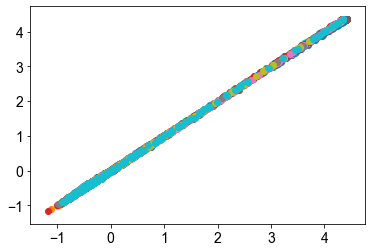

In [66]:
for i in range(20):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [69]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=20
        
        xnorm = scalerX.fit_transform(X)#normalize(X)
        
        #scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))#normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
    
        
        
        
        
        #an = anndata.AnnData(xnorm)
        #an.Y= ynorm
        xnorm = scalerX.fit_transform(X[:20])
        ynorm = np.asarray(scalerY.fit_transform(Y[:20]))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        
        #x = normalize(x)#scalerX.fit_transform(x)
        #y = normalize(y)#scalerY.fit_transform(y)
        
        #print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                #print()
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(ind, 'iteration', train_loss)

0.8572332422069431
0.9975126795754544
0.0010721778039266734 0.007446737378860348
9.555611927778424 376.0
encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
1 iteration 671.6187744140625
2 iteration 664.0569458007812
3 iteration 659.3067016601562
4 iteration 657.3389282226562
5 iteration 642.0543212890625
6 iteration 645.3873291015625
7 iteration 645.0096435546875
8 iteration 635.4271850585938
9 iteration 631.5617065429688
10 iteration 636.4569702148438
11 iteration 628.201904296875
12 iteration 621.488037109375
13 iteration 618.1304321289062
14 iteration 622.19140625
15 iteration 619.9193115234375
16 iteration 609.6980590820312
17 iteration 604.2783813476562
18 iteration 605.267578125
19 iteration 599.2105102539062
20 iteration 593.39404296875
21 iteration 595.9329833984375
22 iteration 587.9131469726562
23 iteration 584.9429931640625
24 iteration 580.4710693359375
25 iteration 578.8365478515625
26 iteration 574.5115966796875
27 

256 iteration 55.44371795654297
257 iteration 54.94707107543945
258 iteration 54.74460983276367
259 iteration 54.41389846801758
260 iteration 53.83735275268555
261 iteration 53.18994903564453
262 iteration 52.968231201171875
263 iteration 52.95432662963867
264 iteration 52.553443908691406
265 iteration 52.00798416137695
266 iteration 51.284706115722656
267 iteration 51.18073272705078
268 iteration 50.88431930541992
269 iteration 50.81537628173828
270 iteration 50.2435417175293
271 iteration 49.559852600097656
272 iteration 49.57381057739258
273 iteration 48.917633056640625
274 iteration 48.5610466003418
275 iteration 48.603126525878906
276 iteration 47.967491149902344
277 iteration 47.68177032470703
278 iteration 47.365631103515625
279 iteration 46.90224075317383
280 iteration 46.486061096191406
281 iteration 46.34058380126953
282 iteration 45.95520782470703
283 iteration 45.713558197021484
284 iteration 45.346656799316406
285 iteration 44.794578552246094
286 iteration 44.7965812683105

522 iteration 8.223589897155762
523 iteration 8.027714729309082
524 iteration 8.111379623413086
525 iteration 7.972209930419922
526 iteration 7.932525634765625
527 iteration 7.709214210510254
528 iteration 7.724244594573975
529 iteration 7.599282264709473
530 iteration 7.464540958404541
531 iteration 7.447910308837891
532 iteration 7.3294677734375
533 iteration 7.260145664215088
534 iteration 7.218009948730469
535 iteration 7.0544257164001465
536 iteration 7.001896858215332
537 iteration 6.895022392272949
538 iteration 6.85512638092041
539 iteration 6.721580505371094
540 iteration 6.6547369956970215
541 iteration 6.6992692947387695
542 iteration 6.535640716552734
543 iteration 6.423470497131348
544 iteration 6.355010509490967
545 iteration 6.160239219665527
546 iteration 6.163426399230957
547 iteration 6.211773872375488
548 iteration 5.947939395904541
549 iteration 5.8679704666137695
550 iteration 5.926023960113525
551 iteration 5.711871147155762
552 iteration 5.805709362030029
553 ite

787 iteration 0.3515752851963043
788 iteration 0.3216312527656555
789 iteration 0.3268091678619385
790 iteration 0.34349900484085083
791 iteration 0.32306596636772156
792 iteration 0.2738410532474518
793 iteration 0.33303579688072205
794 iteration 0.34116214513778687
795 iteration 0.32156088948249817
796 iteration 0.3331868648529053
797 iteration 0.2981160581111908
798 iteration 0.2927885949611664
799 iteration 0.304130494594574
800 iteration 0.32981613278388977
801 iteration 0.2960793972015381
802 iteration 0.2885320782661438
803 iteration 0.2598791718482971
804 iteration 0.2931792736053467
805 iteration 0.2688068449497223
806 iteration 0.24917367100715637
807 iteration 0.29346174001693726
808 iteration 0.2718872129917145
809 iteration 0.3097594678401947
810 iteration 0.3255268931388855
811 iteration 0.3172367513179779
812 iteration 0.272270530462265
813 iteration 0.2844596803188324
814 iteration 0.308567613363266
815 iteration 0.2977944612503052
816 iteration 0.25634700059890747
817 

1054 iteration 0.2114313393831253
1055 iteration 0.17578762769699097
1056 iteration 0.18501724302768707
1057 iteration 0.20336131751537323
1058 iteration 0.23455014824867249
1059 iteration 0.18976619839668274
1060 iteration 0.2100187987089157
1061 iteration 0.1822732388973236
1062 iteration 0.21664360165596008
1063 iteration 0.19543695449829102
1064 iteration 0.19098950922489166
1065 iteration 0.2168733775615692
1066 iteration 0.21054747700691223
1067 iteration 0.20604364573955536
1068 iteration 0.2123134881258011
1069 iteration 0.1995159536600113
1070 iteration 0.19636447727680206
1071 iteration 0.19205734133720398
1072 iteration 0.19938917458057404
1073 iteration 0.19611835479736328
1074 iteration 0.206778883934021
1075 iteration 0.21124401688575745
1076 iteration 0.2233351171016693
1077 iteration 0.1902921199798584
1078 iteration 0.2109346091747284
1079 iteration 0.21704964339733124
1080 iteration 0.21437855064868927
1081 iteration 0.21007315814495087
1082 iteration 0.21110744774341

1311 iteration 0.1831778585910797
1312 iteration 0.1669357717037201
1313 iteration 0.15500344336032867
1314 iteration 0.17430517077445984
1315 iteration 0.16336408257484436
1316 iteration 0.16818001866340637
1317 iteration 0.16875576972961426
1318 iteration 0.16244415938854218
1319 iteration 0.15503832697868347
1320 iteration 0.1521020382642746
1321 iteration 0.1656627506017685
1322 iteration 0.16714143753051758
1323 iteration 0.14861014485359192
1324 iteration 0.1564730703830719
1325 iteration 0.16322200000286102
1326 iteration 0.16428765654563904
1327 iteration 0.16512520611286163
1328 iteration 0.16528037190437317
1329 iteration 0.16386404633522034
1330 iteration 0.17593398690223694
1331 iteration 0.15904273092746735
1332 iteration 0.17469461262226105
1333 iteration 0.16816000640392303
1334 iteration 0.15440404415130615
1335 iteration 0.15886087715625763
1336 iteration 0.16647203266620636
1337 iteration 0.1665252149105072
1338 iteration 0.16789396107196808
1339 iteration 0.159167602

1556 iteration 0.15417234599590302
1557 iteration 0.1453496664762497
1558 iteration 0.15786845982074738
1559 iteration 0.14978277683258057
1560 iteration 0.14712271094322205
1561 iteration 0.14995931088924408
1562 iteration 0.14842787384986877
1563 iteration 0.14033588767051697
1564 iteration 0.15620553493499756
1565 iteration 0.1566115915775299
1566 iteration 0.15760613977909088
1567 iteration 0.157817080616951
1568 iteration 0.14239898324012756
1569 iteration 0.17783889174461365
1570 iteration 0.17112863063812256
1571 iteration 0.15289363265037537
1572 iteration 0.15050938725471497
1573 iteration 0.15138539671897888
1574 iteration 0.1558353453874588
1575 iteration 0.1560516059398651
1576 iteration 0.14723451435565948
1577 iteration 0.1496863067150116
1578 iteration 0.14682218432426453
1579 iteration 0.16541793942451477
1580 iteration 0.16433580219745636
1581 iteration 0.1491304486989975
1582 iteration 0.15491704642772675
1583 iteration 0.16313597559928894
1584 iteration 0.17093880474

1802 iteration 0.1537567675113678
1803 iteration 0.1565464437007904
1804 iteration 0.14368608593940735
1805 iteration 0.17021998763084412
1806 iteration 0.13681502640247345
1807 iteration 0.1471150666475296
1808 iteration 0.15507203340530396
1809 iteration 0.13885098695755005
1810 iteration 0.14447852969169617
1811 iteration 0.14030584692955017
1812 iteration 0.15011100471019745
1813 iteration 0.15256726741790771
1814 iteration 0.1441425085067749
1815 iteration 0.15635307133197784
1816 iteration 0.14410898089408875
1817 iteration 0.1492350548505783
1818 iteration 0.15384069085121155
1819 iteration 0.13608591258525848
1820 iteration 0.1524738073348999
1821 iteration 0.1431383341550827
1822 iteration 0.1516161859035492
1823 iteration 0.15561385452747345
1824 iteration 0.15414124727249146
1825 iteration 0.1449831873178482
1826 iteration 0.14745816588401794
1827 iteration 0.1572796106338501
1828 iteration 0.14720506966114044
1829 iteration 0.14268042147159576
1830 iteration 0.1476806849241

2054 iteration 0.1392558366060257
2055 iteration 0.14611229300498962
2056 iteration 0.144094318151474
2057 iteration 0.1482950747013092
2058 iteration 0.13561756908893585
2059 iteration 0.14552097022533417
2060 iteration 0.14260727167129517
2061 iteration 0.14404843747615814
2062 iteration 0.13425572216510773
2063 iteration 0.1386680155992508
2064 iteration 0.13332857191562653
2065 iteration 0.1307794749736786
2066 iteration 0.1376827508211136
2067 iteration 0.1369357407093048
2068 iteration 0.1427294909954071
2069 iteration 0.1463659703731537
2070 iteration 0.14059856534004211
2071 iteration 0.15610530972480774
2072 iteration 0.1562100201845169
2073 iteration 0.14111025631427765
2074 iteration 0.14011286199092865
2075 iteration 0.1568613350391388
2076 iteration 0.1520569622516632
2077 iteration 0.13994136452674866
2078 iteration 0.14238038659095764
2079 iteration 0.14155666530132294
2080 iteration 0.1482287496328354
2081 iteration 0.15385529398918152
2082 iteration 0.1407652199268341


2303 iteration 0.13059058785438538
2304 iteration 0.139943927526474
2305 iteration 0.13160593807697296
2306 iteration 0.13652198016643524
2307 iteration 0.13256661593914032
2308 iteration 0.13859598338603973
2309 iteration 0.1432863026857376
2310 iteration 0.14095266163349152
2311 iteration 0.13242241740226746
2312 iteration 0.13093721866607666
2313 iteration 0.14578469097614288
2314 iteration 0.15392586588859558
2315 iteration 0.1372596025466919
2316 iteration 0.13145382702350616
2317 iteration 0.14850474894046783
2318 iteration 0.16030804812908173
2319 iteration 0.1424163281917572
2320 iteration 0.1386500895023346
2321 iteration 0.14921386539936066
2322 iteration 0.13515205681324005
2323 iteration 0.14634981751441956
2324 iteration 0.1461797058582306
2325 iteration 0.1499057561159134
2326 iteration 0.1346452683210373
2327 iteration 0.1420021802186966
2328 iteration 0.14949554204940796
2329 iteration 0.14176133275032043
2330 iteration 0.13917186856269836
2331 iteration 0.1567025929689

2549 iteration 0.1326821744441986
2550 iteration 0.13756027817726135
2551 iteration 0.13371089100837708
2552 iteration 0.13167472183704376
2553 iteration 0.12657181918621063
2554 iteration 0.1286296248435974
2555 iteration 0.13853439688682556
2556 iteration 0.1369217038154602
2557 iteration 0.136784166097641
2558 iteration 0.14387783408164978
2559 iteration 0.1370953768491745
2560 iteration 0.13583019375801086
2561 iteration 0.13719388842582703
2562 iteration 0.14067530632019043
2563 iteration 0.1404286026954651
2564 iteration 0.14181479811668396
2565 iteration 0.1389157772064209
2566 iteration 0.1392039805650711
2567 iteration 0.1383049041032791
2568 iteration 0.14229780435562134
2569 iteration 0.14649705588817596
2570 iteration 0.14307965338230133
2571 iteration 0.1352214366197586
2572 iteration 0.1354706734418869
2573 iteration 0.1362670212984085
2574 iteration 0.13657279312610626
2575 iteration 0.1424473077058792
2576 iteration 0.1474163830280304
2577 iteration 0.13308747112751007


2801 iteration 0.12876714766025543
2802 iteration 0.148574560880661
2803 iteration 0.1323583424091339
2804 iteration 0.1344643086194992
2805 iteration 0.1324058473110199
2806 iteration 0.14365345239639282
2807 iteration 0.1396634876728058
2808 iteration 0.13691958785057068
2809 iteration 0.1359122395515442
2810 iteration 0.13275140523910522
2811 iteration 0.1450156718492508
2812 iteration 0.12912419438362122
2813 iteration 0.13088873028755188
2814 iteration 0.13636276125907898
2815 iteration 0.13421157002449036
2816 iteration 0.14142800867557526
2817 iteration 0.13597288727760315
2818 iteration 0.13679201900959015
2819 iteration 0.13685736060142517
2820 iteration 0.13570943474769592
2821 iteration 0.1272692233324051
2822 iteration 0.14250008761882782
2823 iteration 0.1384599804878235
2824 iteration 0.12984752655029297
2825 iteration 0.14253821969032288
2826 iteration 0.13049177825450897
2827 iteration 0.14109593629837036
2828 iteration 0.1401701271533966
2829 iteration 0.12967732548713

3064 iteration 0.13205640017986298
3065 iteration 0.13660044968128204
3066 iteration 0.12512072920799255
3067 iteration 0.1451098471879959
3068 iteration 0.12693184614181519
3069 iteration 0.13051161170005798
3070 iteration 0.14469508826732635
3071 iteration 0.13226231932640076
3072 iteration 0.14118054509162903
3073 iteration 0.136225625872612
3074 iteration 0.1321093589067459
3075 iteration 0.13256777822971344
3076 iteration 0.1326383352279663
3077 iteration 0.1464318186044693
3078 iteration 0.1275196224451065
3079 iteration 0.1353512406349182
3080 iteration 0.13921891152858734
3081 iteration 0.13317394256591797
3082 iteration 0.1394161731004715
3083 iteration 0.13101495802402496
3084 iteration 0.12830054759979248
3085 iteration 0.13733787834644318
3086 iteration 0.1455693542957306
3087 iteration 0.12776631116867065
3088 iteration 0.13070698082447052
3089 iteration 0.1328985095024109
3090 iteration 0.13977539539337158
3091 iteration 0.1302710473537445
3092 iteration 0.131134584546089

3318 iteration 0.14124687016010284
3319 iteration 0.12754712998867035
3320 iteration 0.13944295048713684
3321 iteration 0.13323494791984558
3322 iteration 0.13471946120262146
3323 iteration 0.13140247762203217
3324 iteration 0.14120279252529144
3325 iteration 0.14547234773635864
3326 iteration 0.1264437735080719
3327 iteration 0.14014750719070435
3328 iteration 0.14640752971172333
3329 iteration 0.1348113715648651
3330 iteration 0.14399471879005432
3331 iteration 0.13794073462486267
3332 iteration 0.13219934701919556
3333 iteration 0.13612709939479828
3334 iteration 0.13757969439029694
3335 iteration 0.13631153106689453
3336 iteration 0.1340445876121521
3337 iteration 0.12843236327171326
3338 iteration 0.13642671704292297
3339 iteration 0.1433950662612915
3340 iteration 0.1354386955499649
3341 iteration 0.13520106673240662
3342 iteration 0.13299855589866638
3343 iteration 0.13620901107788086
3344 iteration 0.13693809509277344
3345 iteration 0.13387498259544373
3346 iteration 0.13071954

3565 iteration 0.1376456320285797
3566 iteration 0.1439642608165741
3567 iteration 0.13732784986495972
3568 iteration 0.1380762755870819
3569 iteration 0.13304872810840607
3570 iteration 0.13540132343769073
3571 iteration 0.13702186942100525
3572 iteration 0.12915240228176117
3573 iteration 0.1325751692056656
3574 iteration 0.1320030391216278
3575 iteration 0.12848418951034546
3576 iteration 0.1388193666934967
3577 iteration 0.130558043718338
3578 iteration 0.12208521366119385
3579 iteration 0.13108691573143005
3580 iteration 0.139334037899971
3581 iteration 0.12493201345205307
3582 iteration 0.1359887421131134
3583 iteration 0.1258733868598938
3584 iteration 0.13609124720096588
3585 iteration 0.13271737098693848
3586 iteration 0.1227039247751236
3587 iteration 0.12957501411437988
3588 iteration 0.14787784218788147
3589 iteration 0.1345294564962387
3590 iteration 0.12410636991262436
3591 iteration 0.1294165402650833
3592 iteration 0.1350613534450531
3593 iteration 0.13033822178840637
3

3813 iteration 0.13874566555023193
3814 iteration 0.13861361145973206
3815 iteration 0.12958960235118866
3816 iteration 0.12949778139591217
3817 iteration 0.14451339840888977
3818 iteration 0.1286962926387787
3819 iteration 0.1370859295129776
3820 iteration 0.1366613209247589
3821 iteration 0.13299453258514404
3822 iteration 0.13110706210136414
3823 iteration 0.1347186118364334
3824 iteration 0.13275225460529327
3825 iteration 0.13235339522361755
3826 iteration 0.1365734487771988
3827 iteration 0.1338338851928711
3828 iteration 0.13547368347644806
3829 iteration 0.13080787658691406
3830 iteration 0.14304569363594055
3831 iteration 0.13633319735527039
3832 iteration 0.13087782263755798
3833 iteration 0.13520346581935883
3834 iteration 0.1336113065481186
3835 iteration 0.13447876274585724
3836 iteration 0.1315348893404007
3837 iteration 0.1313719004392624
3838 iteration 0.14266729354858398
3839 iteration 0.1354168951511383
3840 iteration 0.12920613586902618
3841 iteration 0.1320079565048

4060 iteration 0.1328728199005127
4061 iteration 0.13710655272006989
4062 iteration 0.1396714448928833
4063 iteration 0.13645562529563904
4064 iteration 0.13198859989643097
4065 iteration 0.13280384242534637
4066 iteration 0.1344076544046402
4067 iteration 0.1277860403060913
4068 iteration 0.13276110589504242
4069 iteration 0.13277015089988708
4070 iteration 0.13378728926181793
4071 iteration 0.13321492075920105
4072 iteration 0.12881995737552643
4073 iteration 0.13233472406864166
4074 iteration 0.1328880488872528
4075 iteration 0.1282946914434433
4076 iteration 0.13202878832817078
4077 iteration 0.133371040225029
4078 iteration 0.13694918155670166
4079 iteration 0.12844112515449524
4080 iteration 0.13501426577568054
4081 iteration 0.12694039940834045
4082 iteration 0.13596689701080322
4083 iteration 0.13013482093811035
4084 iteration 0.13408775627613068
4085 iteration 0.14131975173950195
4086 iteration 0.1391488015651703
4087 iteration 0.1247938722372055
4088 iteration 0.1377253234386

4308 iteration 0.13390298187732697
4309 iteration 0.1280275136232376
4310 iteration 0.13125857710838318
4311 iteration 0.13391897082328796
4312 iteration 0.12996278703212738
4313 iteration 0.1442110240459442
4314 iteration 0.12660866975784302
4315 iteration 0.14446988701820374
4316 iteration 0.1336163580417633
4317 iteration 0.13757939636707306
4318 iteration 0.13746583461761475
4319 iteration 0.13162371516227722
4320 iteration 0.13655595481395721
4321 iteration 0.14423146843910217
4322 iteration 0.13090237975120544
4323 iteration 0.13439926505088806
4324 iteration 0.13756141066551208
4325 iteration 0.13614678382873535
4326 iteration 0.13416843116283417
4327 iteration 0.13826492428779602
4328 iteration 0.135316863656044
4329 iteration 0.1384824514389038
4330 iteration 0.13651195168495178
4331 iteration 0.14415135979652405
4332 iteration 0.13820263743400574
4333 iteration 0.13976752758026123
4334 iteration 0.13507623970508575
4335 iteration 0.13101376593112946
4336 iteration 0.140597492

4553 iteration 0.12897320091724396
4554 iteration 0.13684648275375366
4555 iteration 0.12617675960063934
4556 iteration 0.12701472640037537
4557 iteration 0.1346314400434494
4558 iteration 0.13188205659389496
4559 iteration 0.12936235964298248
4560 iteration 0.1315106451511383
4561 iteration 0.12816718220710754
4562 iteration 0.13352403044700623
4563 iteration 0.1269993782043457
4564 iteration 0.1347486674785614
4565 iteration 0.13460680842399597
4566 iteration 0.1236017569899559
4567 iteration 0.13275983929634094
4568 iteration 0.13738568127155304
4569 iteration 0.138292595744133
4570 iteration 0.1271074265241623
4571 iteration 0.14577974379062653
4572 iteration 0.13211718201637268
4573 iteration 0.14065176248550415
4574 iteration 0.14143025875091553
4575 iteration 0.12626543641090393
4576 iteration 0.1360970139503479
4577 iteration 0.1337442398071289
4578 iteration 0.13317914307117462
4579 iteration 0.13017825782299042
4580 iteration 0.13412833213806152
4581 iteration 0.1360172033309

4802 iteration 0.13954350352287292
4803 iteration 0.12657767534255981
4804 iteration 0.13004344701766968
4805 iteration 0.12709790468215942
4806 iteration 0.12867626547813416
4807 iteration 0.12915948033332825
4808 iteration 0.1376911699771881
4809 iteration 0.1276354044675827
4810 iteration 0.13924230635166168
4811 iteration 0.13537773489952087
4812 iteration 0.1289438158273697
4813 iteration 0.13282296061515808
4814 iteration 0.12319842725992203
4815 iteration 0.12877067923545837
4816 iteration 0.13408468663692474
4817 iteration 0.13214966654777527
4818 iteration 0.1251167356967926
4819 iteration 0.1394859105348587
4820 iteration 0.12893088161945343
4821 iteration 0.13673868775367737
4822 iteration 0.14230521023273468
4823 iteration 0.13067582249641418
4824 iteration 0.14091286063194275
4825 iteration 0.1353939026594162
4826 iteration 0.132943794131279
4827 iteration 0.1488874852657318
4828 iteration 0.13887013494968414
4829 iteration 0.13297739624977112
4830 iteration 0.132113173604

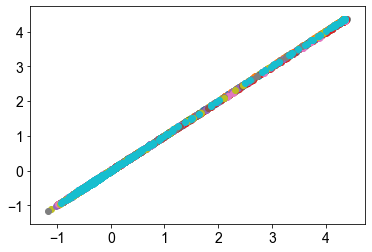

In [70]:
for i in range(20):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [79]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =10000
        batch_size=376#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(X)
        an.Y= Y
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572227432519913
0.9975142659813275
0.0010721778036602814 0.007446737378860348
9.575582998708036 376.0
encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[7.6126e-04, 3.4510e-09, 2.8552e-07,  ..., 8.7077e-03, 4.9918e-02,
         4.3794e-02],
        [5.5038e-04, 9.9882e-06, 1.5176e-06,  ..., 3.9705e-03, 6.0099e-02,
         2.6642e-01],
        [5.1000e-04, 0.0000e+00, 0.0000e+00,  ..., 2.4968e-08, 3.5905e-07,
         1.5713e-05],
        ...,
        [8.4560e-04, 8.4191e-04, 3.3739e-05,  ..., 1.7411e-02, 8.0340e-03,
         1.0350e-02],
        [7.3520e-03, 0.0000e+00, 0.0000e+00,  ..., 5.8095e-05, 1.4164e-03,
         1.3977e-03],
        [2.3561e-03, 2.5018e-03, 1.3220e-03,  ..., 7.5434e-06, 6.1466e-05,
         1.0059e-04]], dtype=torch.float64)
1 iteration
103.95748901367188
2 iteration
79.76313018798828
3 iteration
64.80119323730469
4 iteration
54.68702697753906
5 iteration
47.63319778442383
6 iteration
42.8968

0.6663632392883301
246 iteration
0.6646132469177246
247 iteration
0.6605989336967468
248 iteration
0.6562715172767639
249 iteration
0.6578165888786316
250 iteration
0.6535844802856445
251 iteration
0.65757817029953
252 iteration
0.6578670740127563
253 iteration
0.6451173424720764
254 iteration
0.6510427594184875
255 iteration
0.650356113910675
256 iteration
0.6503286361694336
257 iteration
0.646530270576477
258 iteration
0.6419113874435425
259 iteration
0.6402900218963623
260 iteration
0.6457052230834961
261 iteration
0.6454252600669861
262 iteration
0.6376577615737915
263 iteration
0.6352174878120422
264 iteration
0.6359766125679016
265 iteration
0.628777801990509
266 iteration
0.6322916150093079
267 iteration
0.6272610425949097
268 iteration
0.6304992437362671
269 iteration
0.627423882484436
270 iteration
0.6301723122596741
271 iteration
0.6235611438751221
272 iteration
0.624869704246521
273 iteration
0.6252650618553162
274 iteration
0.6217079758644104
275 iteration
0.617707788944244

0.42269474267959595
497 iteration
0.4231165647506714
498 iteration
0.4218532145023346
499 iteration
0.42256346344947815
500 iteration
0.42105281352996826
501 iteration
0.4195003807544708
502 iteration
0.41988566517829895
503 iteration
0.4188821613788605
504 iteration
0.4198931157588959
505 iteration
0.41876789927482605
506 iteration
0.41785886883735657
507 iteration
0.4172765910625458
508 iteration
0.41593605279922485
509 iteration
0.4156913757324219
510 iteration
0.4153349995613098
511 iteration
0.4161105155944824
512 iteration
0.4141155481338501
513 iteration
0.4140951633453369
514 iteration
0.41364142298698425
515 iteration
0.4110925495624542
516 iteration
0.4111475944519043
517 iteration
0.4114927649497986
518 iteration
0.40857094526290894
519 iteration
0.41030818223953247
520 iteration
0.4102160632610321
521 iteration
0.40893322229385376
522 iteration
0.4078145921230316
523 iteration
0.40693768858909607
524 iteration
0.4068693518638611
525 iteration
0.40593069791793823
526 iterati

0.34434911608695984
748 iteration
0.34194329380989075
749 iteration
0.3427653908729553
750 iteration
0.3427153527736664
751 iteration
0.3421092629432678
752 iteration
0.34355029463768005
753 iteration
0.3416544795036316
754 iteration
0.34211617708206177
755 iteration
0.34146443009376526
756 iteration
0.34187763929367065
757 iteration
0.3410055637359619
758 iteration
0.3411978483200073
759 iteration
0.3406650125980377
760 iteration
0.340666264295578
761 iteration
0.34041827917099
762 iteration
0.34051623940467834
763 iteration
0.3407149910926819
764 iteration
0.34007886052131653
765 iteration
0.33978673815727234
766 iteration
0.34011271595954895
767 iteration
0.34006625413894653
768 iteration
0.3382827341556549
769 iteration
0.33950573205947876
770 iteration
0.33892717957496643
771 iteration
0.33964911103248596
772 iteration
0.33764851093292236
773 iteration
0.3377333879470825
774 iteration
0.33975300192832947
775 iteration
0.33803674578666687
776 iteration
0.3373257517814636
777 iterat

0.3013516068458557
994 iteration
0.3013470768928528
995 iteration
0.30010101199150085
996 iteration
0.3004400432109833
997 iteration
0.3007415235042572
998 iteration
0.2994682490825653
999 iteration
0.29922714829444885
1000 iteration
0.29938244819641113
1001 iteration
0.2991601526737213
1002 iteration
0.2991805672645569
1003 iteration
0.29955539107322693
1004 iteration
0.29976433515548706
1005 iteration
0.29957202076911926
1006 iteration
0.2985728979110718
1007 iteration
0.29854246973991394
1008 iteration
0.2997206747531891
1009 iteration
0.2985426187515259
1010 iteration
0.2976943552494049
1011 iteration
0.2981853783130646
1012 iteration
0.2969970405101776
1013 iteration
0.29814058542251587
1014 iteration
0.2968946397304535
1015 iteration
0.2981364130973816
1016 iteration
0.29773053526878357
1017 iteration
0.2977740168571472
1018 iteration
0.29739296436309814
1019 iteration
0.29708433151245117
1020 iteration
0.2973145544528961
1021 iteration
0.29665929079055786
1022 iteration
0.295572

0.2695668041706085
1241 iteration
0.27102169394493103
1242 iteration
0.2695417106151581
1243 iteration
0.2697543799877167
1244 iteration
0.2694006562232971
1245 iteration
0.2688305675983429
1246 iteration
0.2680255174636841
1247 iteration
0.2695375978946686
1248 iteration
0.2696472406387329
1249 iteration
0.26838892698287964
1250 iteration
0.2700375020503998
1251 iteration
0.26961854100227356
1252 iteration
0.2683769166469574
1253 iteration
0.26834675669670105
1254 iteration
0.2694850564002991
1255 iteration
0.2689357399940491
1256 iteration
0.2683005928993225
1257 iteration
0.2681945562362671
1258 iteration
0.2687596380710602
1259 iteration
0.2682594656944275
1260 iteration
0.2681348919868469
1261 iteration
0.2692110240459442
1262 iteration
0.2679198384284973
1263 iteration
0.2674209773540497
1264 iteration
0.26798340678215027
1265 iteration
0.2675374448299408
1266 iteration
0.26596346497535706
1267 iteration
0.26892387866973877
1268 iteration
0.26590386033058167
1269 iteration
0.2678

0.250449001789093
1487 iteration
0.25012558698654175
1488 iteration
0.24948915839195251
1489 iteration
0.25026971101760864
1490 iteration
0.25048038363456726
1491 iteration
0.24976846575737
1492 iteration
0.24942345917224884
1493 iteration
0.2486332356929779
1494 iteration
0.24872331321239471
1495 iteration
0.24849098920822144
1496 iteration
0.24858251214027405
1497 iteration
0.2493075132369995
1498 iteration
0.24886421859264374
1499 iteration
0.2495764046907425
1500 iteration
0.24903342127799988
1501 iteration
0.24816091358661652
1502 iteration
0.24850036203861237
1503 iteration
0.2482195943593979
1504 iteration
0.24847586452960968
1505 iteration
0.24826687574386597
1506 iteration
0.24792596697807312
1507 iteration
0.2480328381061554
1508 iteration
0.24811172485351562
1509 iteration
0.2473909705877304
1510 iteration
0.24813106656074524
1511 iteration
0.24715553224086761
1512 iteration
0.24723419547080994
1513 iteration
0.24836359918117523
1514 iteration
0.24794192612171173
1515 iterat

0.22983427345752716
1738 iteration
0.22925832867622375
1739 iteration
0.22975614666938782
1740 iteration
0.23110000789165497
1741 iteration
0.22988340258598328
1742 iteration
0.22976034879684448
1743 iteration
0.22959719598293304
1744 iteration
0.22940035164356232
1745 iteration
0.2293492555618286
1746 iteration
0.22987762093544006
1747 iteration
0.22942118346691132
1748 iteration
0.22909501194953918
1749 iteration
0.230298712849617
1750 iteration
0.22998909652233124
1751 iteration
0.23047833144664764
1752 iteration
0.23002609610557556
1753 iteration
0.23011736571788788
1754 iteration
0.2284034788608551
1755 iteration
0.22890152037143707
1756 iteration
0.22851057350635529
1757 iteration
0.22993429005146027
1758 iteration
0.22860394418239594
1759 iteration
0.22847196459770203
1760 iteration
0.22864197194576263
1761 iteration
0.22880268096923828
1762 iteration
0.22882622480392456
1763 iteration
0.22769057750701904
1764 iteration
0.2285563349723816
1765 iteration
0.22838132083415985
1766 

0.21589182317256927
1988 iteration
0.21438105404376984
1989 iteration
0.21480706334114075
1990 iteration
0.21541810035705566
1991 iteration
0.2144768238067627
1992 iteration
0.21494711935520172
1993 iteration
0.21515774726867676
1994 iteration
0.2143942266702652
1995 iteration
0.21602533757686615
1996 iteration
0.21615128219127655
1997 iteration
0.21486783027648926
1998 iteration
0.21496886014938354
1999 iteration
0.2155168205499649
2000 iteration
0.21431423723697662
2001 iteration
0.21563458442687988
2002 iteration
0.21475984156131744
2003 iteration
0.2148367315530777
2004 iteration
0.21444232761859894
2005 iteration
0.21435563266277313
2006 iteration
0.21401581168174744
2007 iteration
0.21453678607940674
2008 iteration
0.21390709280967712
2009 iteration
0.21493761241436005
2010 iteration
0.21351785957813263
2011 iteration
0.21449953317642212
2012 iteration
0.21489275991916656
2013 iteration
0.21383918821811676
2014 iteration
0.21406899392604828
2015 iteration
0.2139207124710083
2016 

0.20526835322380066
2240 iteration
0.204987570643425
2241 iteration
0.20441368222236633
2242 iteration
0.2060617357492447
2243 iteration
0.20470452308654785
2244 iteration
0.20496027171611786
2245 iteration
0.20516955852508545
2246 iteration
0.203876331448555
2247 iteration
0.20518778264522552
2248 iteration
0.2045433223247528
2249 iteration
0.20482328534126282
2250 iteration
0.20477187633514404
2251 iteration
0.20551955699920654
2252 iteration
0.20472875237464905
2253 iteration
0.20457328855991364
2254 iteration
0.20539210736751556
2255 iteration
0.20458820462226868
2256 iteration
0.20488028228282928
2257 iteration
0.20519986748695374
2258 iteration
0.20565339922904968
2259 iteration
0.2043904811143875
2260 iteration
0.20508131384849548
2261 iteration
0.2036876529455185
2262 iteration
0.20413801074028015
2263 iteration
0.20426760613918304
2264 iteration
0.20447561144828796
2265 iteration
0.20426003634929657
2266 iteration
0.2039365917444229
2267 iteration
0.204168900847435
2268 iterat

0.19729377329349518
2491 iteration
0.19769231975078583
2492 iteration
0.19786235690116882
2493 iteration
0.19712847471237183
2494 iteration
0.1972273588180542
2495 iteration
0.19731192290782928
2496 iteration
0.19798490405082703
2497 iteration
0.19771231710910797
2498 iteration
0.19864226877689362
2499 iteration
0.19663003087043762
2500 iteration
0.1979507952928543
2501 iteration
0.1964559108018875
2502 iteration
0.19698747992515564
2503 iteration
0.19742576777935028
2504 iteration
0.19762428104877472
2505 iteration
0.19873888790607452
2506 iteration
0.19800277054309845
2507 iteration
0.1965894103050232
2508 iteration
0.1967049092054367
2509 iteration
0.1970357894897461
2510 iteration
0.19683527946472168
2511 iteration
0.1963931769132614
2512 iteration
0.1961802840232849
2513 iteration
0.19618210196495056
2514 iteration
0.19690227508544922
2515 iteration
0.19663871824741364
2516 iteration
0.1963106095790863
2517 iteration
0.19791977107524872
2518 iteration
0.19760718941688538
2519 iter

0.19243600964546204
2742 iteration
0.1923162043094635
2743 iteration
0.19268855452537537
2744 iteration
0.19159343838691711
2745 iteration
0.19227439165115356
2746 iteration
0.1924877166748047
2747 iteration
0.19152085483074188
2748 iteration
0.1933087259531021
2749 iteration
0.1924629956483841
2750 iteration
0.19325043261051178
2751 iteration
0.19184167683124542
2752 iteration
0.19264979660511017
2753 iteration
0.19153638184070587
2754 iteration
0.19251397252082825
2755 iteration
0.19201862812042236
2756 iteration
0.19198040664196014
2757 iteration
0.19237250089645386
2758 iteration
0.19195854663848877
2759 iteration
0.19208554923534393
2760 iteration
0.19164599478244781
2761 iteration
0.19253334403038025
2762 iteration
0.19226206839084625
2763 iteration
0.19263993203639984
2764 iteration
0.19145147502422333
2765 iteration
0.19318251311779022
2766 iteration
0.19294250011444092
2767 iteration
0.19256910681724548
2768 iteration
0.19268612563610077
2769 iteration
0.19252270460128784
2770

0.1887010782957077
2991 iteration
0.1889922320842743
2992 iteration
0.18864206969738007
2993 iteration
0.1895856410264969
2994 iteration
0.18912853300571442
2995 iteration
0.18955080211162567
2996 iteration
0.18923193216323853
2997 iteration
0.18933790922164917
2998 iteration
0.189897820353508
2999 iteration
0.1884274184703827
3000 iteration
0.19002528488636017
3001 iteration
0.18816690146923065
3002 iteration
0.18885180354118347
3003 iteration
0.18889638781547546
3004 iteration
0.18834781646728516
3005 iteration
0.18856923282146454
3006 iteration
0.18763139843940735
3007 iteration
0.18844211101531982
3008 iteration
0.1888972967863083
3009 iteration
0.1880655735731125
3010 iteration
0.18761198222637177
3011 iteration
0.18839183449745178
3012 iteration
0.18826311826705933
3013 iteration
0.18847902119159698
3014 iteration
0.18784824013710022
3015 iteration
0.18771156668663025
3016 iteration
0.18831393122673035
3017 iteration
0.18845082819461823
3018 iteration
0.18869203329086304
3019 ite

0.18375514447689056
3242 iteration
0.184840127825737
3243 iteration
0.1836346536874771
3244 iteration
0.18410997092723846
3245 iteration
0.1834709644317627
3246 iteration
0.18272347748279572
3247 iteration
0.18379807472229004
3248 iteration
0.18438193202018738
3249 iteration
0.1834590584039688
3250 iteration
0.1826154887676239
3251 iteration
0.1827465444803238
3252 iteration
0.1824607104063034
3253 iteration
0.1844892054796219
3254 iteration
0.18410179018974304
3255 iteration
0.18427641689777374
3256 iteration
0.18321733176708221
3257 iteration
0.1840033084154129
3258 iteration
0.1847076416015625
3259 iteration
0.18379917740821838
3260 iteration
0.18348759412765503
3261 iteration
0.18446411192417145
3262 iteration
0.18460720777511597
3263 iteration
0.18352171778678894
3264 iteration
0.18413937091827393
3265 iteration
0.18390564620494843
3266 iteration
0.18407048285007477
3267 iteration
0.1841001659631729
3268 iteration
0.18383364379405975
3269 iteration
0.18278470635414124
3270 iterati

0.18032807111740112
3491 iteration
0.18053790926933289
3492 iteration
0.18061435222625732
3493 iteration
0.18078847229480743
3494 iteration
0.18010105192661285
3495 iteration
0.1812116950750351
3496 iteration
0.1812945455312729
3497 iteration
0.18157503008842468
3498 iteration
0.18136955797672272
3499 iteration
0.18026626110076904
3500 iteration
0.18074899911880493
3501 iteration
0.1801145225763321
3502 iteration
0.18110157549381256
3503 iteration
0.1799478679895401
3504 iteration
0.1810251772403717
3505 iteration
0.18049201369285583
3506 iteration
0.1812078058719635
3507 iteration
0.17990146577358246
3508 iteration
0.18055741488933563
3509 iteration
0.18041418492794037
3510 iteration
0.18064449727535248
3511 iteration
0.18023601174354553
3512 iteration
0.17998246848583221
3513 iteration
0.18098661303520203
3514 iteration
0.18062670528888702
3515 iteration
0.18063730001449585
3516 iteration
0.17981651425361633
3517 iteration
0.18082070350646973
3518 iteration
0.1808559149503708
3519 it

0.17705096304416656
3743 iteration
0.17665846645832062
3744 iteration
0.1759425699710846
3745 iteration
0.17751020193099976
3746 iteration
0.17662058770656586
3747 iteration
0.17788605391979218
3748 iteration
0.17535652220249176
3749 iteration
0.17601698637008667
3750 iteration
0.17660924792289734
3751 iteration
0.17700140178203583
3752 iteration
0.1784156858921051
3753 iteration
0.17648866772651672
3754 iteration
0.17609810829162598
3755 iteration
0.17783710360527039
3756 iteration
0.17736896872520447
3757 iteration
0.17565764486789703
3758 iteration
0.17709553241729736
3759 iteration
0.17684601247310638
3760 iteration
0.17705018818378448
3761 iteration
0.17736519873142242
3762 iteration
0.17865987122058868
3763 iteration
0.17777685821056366
3764 iteration
0.17812225222587585
3765 iteration
0.17738528549671173
3766 iteration
0.1767740398645401
3767 iteration
0.17749717831611633
3768 iteration
0.17695891857147217
3769 iteration
0.17720170319080353
3770 iteration
0.1759171038866043
3771

0.17384973168373108
3995 iteration
0.17262811958789825
3996 iteration
0.17194603383541107
3997 iteration
0.1718684434890747
3998 iteration
0.17168068885803223
3999 iteration
0.17286109924316406
4000 iteration
0.17303846776485443
4001 iteration
0.17314413189888
4002 iteration
0.17250891029834747
4003 iteration
0.1732109785079956
4004 iteration
0.17331965267658234
4005 iteration
0.17284898459911346
4006 iteration
0.1737009435892105
4007 iteration
0.17222462594509125
4008 iteration
0.1728290170431137
4009 iteration
0.1721806824207306
4010 iteration
0.1723155379295349
4011 iteration
0.17214302718639374
4012 iteration
0.17228728532791138
4013 iteration
0.17204155027866364
4014 iteration
0.1729152947664261
4015 iteration
0.173009991645813
4016 iteration
0.1720290631055832
4017 iteration
0.17255941033363342
4018 iteration
0.17289072275161743
4019 iteration
0.1718130111694336
4020 iteration
0.17286419868469238
4021 iteration
0.1719847172498703
4022 iteration
0.17270305752754211
4023 iteration


0.17049965262413025
4243 iteration
0.16976307332515717
4244 iteration
0.17061305046081543
4245 iteration
0.16893866658210754
4246 iteration
0.17060503363609314
4247 iteration
0.16908809542655945
4248 iteration
0.17009936273097992
4249 iteration
0.16941525042057037
4250 iteration
0.16924257576465607
4251 iteration
0.16938786208629608
4252 iteration
0.16973160207271576
4253 iteration
0.1696057915687561
4254 iteration
0.16878606379032135
4255 iteration
0.1687244474887848
4256 iteration
0.16877084970474243
4257 iteration
0.16809327900409698
4258 iteration
0.16863572597503662
4259 iteration
0.1693980097770691
4260 iteration
0.16865958273410797
4261 iteration
0.16846436262130737
4262 iteration
0.16859650611877441
4263 iteration
0.16870753467082977
4264 iteration
0.16786637902259827
4265 iteration
0.16897262632846832
4266 iteration
0.16887617111206055
4267 iteration
0.16853156685829163
4268 iteration
0.16889262199401855
4269 iteration
0.16883020102977753
4270 iteration
0.1683989316225052
4271

0.1647111475467682
4492 iteration
0.1648051142692566
4493 iteration
0.1649133861064911
4494 iteration
0.16512203216552734
4495 iteration
0.16440418362617493
4496 iteration
0.16629411280155182
4497 iteration
0.16442008316516876
4498 iteration
0.1650010645389557
4499 iteration
0.16463324427604675
4500 iteration
0.16513964533805847
4501 iteration
0.16623695194721222
4502 iteration
0.16541393101215363
4503 iteration
0.16513343155384064
4504 iteration
0.16632674634456635
4505 iteration
0.16507169604301453
4506 iteration
0.16569270193576813
4507 iteration
0.16498005390167236
4508 iteration
0.16426987946033478
4509 iteration
0.164801687002182
4510 iteration
0.16423752903938293
4511 iteration
0.16469532251358032
4512 iteration
0.1661023050546646
4513 iteration
0.16499337553977966
4514 iteration
0.1654070019721985
4515 iteration
0.164668470621109
4516 iteration
0.16600678861141205
4517 iteration
0.16531874239444733
4518 iteration
0.16455525159835815
4519 iteration
0.16470281779766083
4520 itera

0.16036930680274963
4741 iteration
0.16046647727489471
4742 iteration
0.16092447936534882
4743 iteration
0.1607053279876709
4744 iteration
0.16032609343528748
4745 iteration
0.1598353236913681
4746 iteration
0.159793883562088
4747 iteration
0.16043587028980255
4748 iteration
0.15851803123950958
4749 iteration
0.1591026484966278
4750 iteration
0.16008025407791138
4751 iteration
0.1601465344429016
4752 iteration
0.1609007716178894
4753 iteration
0.16080045700073242
4754 iteration
0.1610201746225357
4755 iteration
0.16146299242973328
4756 iteration
0.16036354005336761
4757 iteration
0.16043630242347717
4758 iteration
0.16120940446853638
4759 iteration
0.16070705652236938
4760 iteration
0.16002507507801056
4761 iteration
0.16090422868728638
4762 iteration
0.16007894277572632
4763 iteration
0.16120053827762604
4764 iteration
0.16056126356124878
4765 iteration
0.1599019467830658
4766 iteration
0.1599562168121338
4767 iteration
0.16014452278614044
4768 iteration
0.16026946902275085
4769 itera

0.15687714517116547
4993 iteration
0.15687188506126404
4994 iteration
0.15728631615638733
4995 iteration
0.15741178393363953
4996 iteration
0.15750694274902344
4997 iteration
0.15628737211227417
4998 iteration
0.15644055604934692
4999 iteration
0.15644341707229614
5000 iteration
0.15761889517307281
5001 iteration
0.15769661962985992
5002 iteration
0.15682686865329742
5003 iteration
0.1575588434934616
5004 iteration
0.15649686753749847
5005 iteration
0.15661323070526123
5006 iteration
0.15636028349399567
5007 iteration
0.1573987454175949
5008 iteration
0.15755029022693634
5009 iteration
0.15746617317199707
5010 iteration
0.15804478526115417
5011 iteration
0.15739646553993225
5012 iteration
0.1577926129102707
5013 iteration
0.15750527381896973
5014 iteration
0.15806594491004944
5015 iteration
0.15755073726177216
5016 iteration
0.15684233605861664
5017 iteration
0.15760141611099243
5018 iteration
0.15646128356456757
5019 iteration
0.15811169147491455
5020 iteration
0.1576175093650818
5021

0.1533840000629425
5242 iteration
0.15371455252170563
5243 iteration
0.15314945578575134
5244 iteration
0.15218457579612732
5245 iteration
0.15387935936450958
5246 iteration
0.15357550978660583
5247 iteration
0.15312322974205017
5248 iteration
0.15296682715415955
5249 iteration
0.1541772335767746
5250 iteration
0.15350112318992615
5251 iteration
0.15428830683231354
5252 iteration
0.15369091928005219
5253 iteration
0.15453611314296722
5254 iteration
0.15308453142642975
5255 iteration
0.15391968190670013
5256 iteration
0.15356825292110443
5257 iteration
0.15304723381996155
5258 iteration
0.15288275480270386
5259 iteration
0.15343712270259857
5260 iteration
0.15285077691078186
5261 iteration
0.15319393575191498
5262 iteration
0.15313281118869781
5263 iteration
0.15286323428153992
5264 iteration
0.15385226905345917
5265 iteration
0.15352806448936462
5266 iteration
0.15348871052265167
5267 iteration
0.15427996218204498
5268 iteration
0.15322956442832947
5269 iteration
0.15399494767189026
52

0.1512375921010971
5494 iteration
0.15195612609386444
5495 iteration
0.15196508169174194
5496 iteration
0.15121209621429443
5497 iteration
0.15125615894794464
5498 iteration
0.15128564834594727
5499 iteration
0.15103958547115326
5500 iteration
0.15166355669498444
5501 iteration
0.15128451585769653
5502 iteration
0.1508302092552185
5503 iteration
0.15134771168231964
5504 iteration
0.15198111534118652
5505 iteration
0.15142029523849487
5506 iteration
0.15204909443855286
5507 iteration
0.1508377194404602
5508 iteration
0.15113864839076996
5509 iteration
0.15079058706760406
5510 iteration
0.1519489288330078
5511 iteration
0.1513785868883133
5512 iteration
0.1505412459373474
5513 iteration
0.1509198248386383
5514 iteration
0.1515226513147354
5515 iteration
0.1501082330942154
5516 iteration
0.1514068841934204
5517 iteration
0.151052325963974
5518 iteration
0.15177838504314423
5519 iteration
0.15179091691970825
5520 iteration
0.15264971554279327
5521 iteration
0.15179435908794403
5522 iterati

0.14979290962219238
5747 iteration
0.14864595234394073
5748 iteration
0.1488291323184967
5749 iteration
0.14992213249206543
5750 iteration
0.1497269868850708
5751 iteration
0.1503889411687851
5752 iteration
0.14955687522888184
5753 iteration
0.14911147952079773
5754 iteration
0.14931975305080414
5755 iteration
0.149799644947052
5756 iteration
0.15004311501979828
5757 iteration
0.14878800511360168
5758 iteration
0.14990653097629547
5759 iteration
0.14953871071338654
5760 iteration
0.14995190501213074
5761 iteration
0.14950701594352722
5762 iteration
0.1498921811580658
5763 iteration
0.14965209364891052
5764 iteration
0.14989736676216125
5765 iteration
0.1493196338415146
5766 iteration
0.14965473115444183
5767 iteration
0.1490153670310974
5768 iteration
0.14874227344989777
5769 iteration
0.14866669476032257
5770 iteration
0.14907704293727875
5771 iteration
0.1486128568649292
5772 iteration
0.14912401139736176
5773 iteration
0.14920976758003235
5774 iteration
0.14905299246311188
5775 iter

0.14940962195396423
5995 iteration
0.14768239855766296
5996 iteration
0.1485069841146469
5997 iteration
0.1480160504579544
5998 iteration
0.1471872478723526
5999 iteration
0.14780886471271515
6000 iteration
0.14902257919311523
6001 iteration
0.14850029349327087
6002 iteration
0.14792205393314362
6003 iteration
0.14837877452373505
6004 iteration
0.1483314335346222
6005 iteration
0.14737290143966675
6006 iteration
0.14882706105709076
6007 iteration
0.14795449376106262
6008 iteration
0.14778952300548553
6009 iteration
0.14820154011249542
6010 iteration
0.14667820930480957
6011 iteration
0.147278293967247
6012 iteration
0.14719806611537933
6013 iteration
0.14733175933361053
6014 iteration
0.14785131812095642
6015 iteration
0.14753234386444092
6016 iteration
0.14778749644756317
6017 iteration
0.14759838581085205
6018 iteration
0.14710886776447296
6019 iteration
0.14835794270038605
6020 iteration
0.14839273691177368
6021 iteration
0.14735129475593567
6022 iteration
0.14845024049282074
6023 i

0.14714805781841278
6235 iteration
0.1463276892900467
6236 iteration
0.14678990840911865
6237 iteration
0.14674703776836395
6238 iteration
0.1468057930469513
6239 iteration
0.14559705555438995
6240 iteration
0.14595475792884827
6241 iteration
0.1477528065443039
6242 iteration
0.1467132568359375
6243 iteration
0.14635270833969116
6244 iteration
0.14693620800971985
6245 iteration
0.14695772528648376
6246 iteration
0.14604705572128296
6247 iteration
0.14643168449401855
6248 iteration
0.14651918411254883
6249 iteration
0.14734520018100739
6250 iteration
0.146818146109581
6251 iteration
0.14639154076576233
6252 iteration
0.1467612087726593
6253 iteration
0.1462540179491043
6254 iteration
0.14580759406089783
6255 iteration
0.1472829282283783
6256 iteration
0.14689770340919495
6257 iteration
0.1460474282503128
6258 iteration
0.1465892493724823
6259 iteration
0.1457960158586502
6260 iteration
0.14628754556179047
6261 iteration
0.1459088772535324
6262 iteration
0.14643694460391998
6263 iteratio

0.14510415494441986
6480 iteration
0.14615082740783691
6481 iteration
0.14532634615898132
6482 iteration
0.1472472995519638
6483 iteration
0.14581696689128876
6484 iteration
0.14561982452869415
6485 iteration
0.14586812257766724
6486 iteration
0.14646239578723907
6487 iteration
0.14501634240150452
6488 iteration
0.14502398669719696
6489 iteration
0.14507704973220825
6490 iteration
0.14575354754924774
6491 iteration
0.14513717591762543
6492 iteration
0.14485831558704376
6493 iteration
0.145974263548851
6494 iteration
0.14546240866184235
6495 iteration
0.1457539200782776
6496 iteration
0.1451219767332077
6497 iteration
0.14546896517276764
6498 iteration
0.1456216275691986
6499 iteration
0.14524155855178833
6500 iteration
0.14513401687145233
6501 iteration
0.14519549906253815
6502 iteration
0.14469261467456818
6503 iteration
0.1452486515045166
6504 iteration
0.14544115960597992
6505 iteration
0.14524604380130768
6506 iteration
0.14575037360191345
6507 iteration
0.14458738267421722
6508 it

0.14432571828365326
6730 iteration
0.14366300404071808
6731 iteration
0.1440703272819519
6732 iteration
0.1437435746192932
6733 iteration
0.14486752450466156
6734 iteration
0.1440877765417099
6735 iteration
0.14535672962665558
6736 iteration
0.1440841257572174
6737 iteration
0.1443360298871994
6738 iteration
0.1441275030374527
6739 iteration
0.14327913522720337
6740 iteration
0.14402298629283905
6741 iteration
0.14376041293144226
6742 iteration
0.14381363987922668
6743 iteration
0.14377561211585999
6744 iteration
0.1445145308971405
6745 iteration
0.14480827748775482
6746 iteration
0.1444338709115982
6747 iteration
0.1437726765871048
6748 iteration
0.14389373362064362
6749 iteration
0.14394517242908478
6750 iteration
0.14345085620880127
6751 iteration
0.14473780989646912
6752 iteration
0.14428773522377014
6753 iteration
0.14418521523475647
6754 iteration
0.14542746543884277
6755 iteration
0.14449669420719147
6756 iteration
0.1437002569437027
6757 iteration
0.1438513994216919
6758 iterat

0.14271552860736847
6971 iteration
0.14152801036834717
6972 iteration
0.143647238612175
6973 iteration
0.14271342754364014
6974 iteration
0.14252890646457672
6975 iteration
0.14276571571826935
6976 iteration
0.14317718148231506
6977 iteration
0.14318370819091797
6978 iteration
0.14283926784992218
6979 iteration
0.1432618349790573
6980 iteration
0.14377965033054352
6981 iteration
0.1433849185705185
6982 iteration
0.14299584925174713
6983 iteration
0.14303962886333466
6984 iteration
0.14299018681049347
6985 iteration
0.14249907433986664
6986 iteration
0.1416136622428894
6987 iteration
0.14324086904525757
6988 iteration
0.1424592286348343
6989 iteration
0.1421140879392624
6990 iteration
0.14288830757141113
6991 iteration
0.14233002066612244
6992 iteration
0.1421133130788803
6993 iteration
0.14236107468605042
6994 iteration
0.14233604073524475
6995 iteration
0.14178110659122467
6996 iteration
0.1433515101671219
6997 iteration
0.14279788732528687
6998 iteration
0.14240777492523193
6999 iter

0.14049582183361053
7217 iteration
0.14145894348621368
7218 iteration
0.1411205381155014
7219 iteration
0.14093761146068573
7220 iteration
0.14105910062789917
7221 iteration
0.1418248564004898
7222 iteration
0.14144842326641083
7223 iteration
0.1408138871192932
7224 iteration
0.14139077067375183
7225 iteration
0.14165902137756348
7226 iteration
0.14137588441371918
7227 iteration
0.14112785458564758
7228 iteration
0.1416025608778
7229 iteration
0.1422247290611267
7230 iteration
0.14017778635025024
7231 iteration
0.14141736924648285
7232 iteration
0.14082472026348114
7233 iteration
0.1416931301355362
7234 iteration
0.14079652726650238
7235 iteration
0.14187133312225342
7236 iteration
0.14199067652225494
7237 iteration
0.14088411629199982
7238 iteration
0.14197048544883728
7239 iteration
0.1422635316848755
7240 iteration
0.142414391040802
7241 iteration
0.14189709722995758
7242 iteration
0.14150923490524292
7243 iteration
0.14209577441215515
7244 iteration
0.14248843491077423
7245 iterati

0.14045540988445282
7467 iteration
0.14022190868854523
7468 iteration
0.1401892900466919
7469 iteration
0.14050441980361938
7470 iteration
0.14083176851272583
7471 iteration
0.14099206030368805
7472 iteration
0.1415887027978897
7473 iteration
0.14081506431102753
7474 iteration
0.14046165347099304
7475 iteration
0.1407846063375473
7476 iteration
0.1402474194765091
7477 iteration
0.14060629904270172
7478 iteration
0.1405722200870514
7479 iteration
0.13997343182563782
7480 iteration
0.14091244339942932
7481 iteration
0.14169956743717194
7482 iteration
0.13957707583904266
7483 iteration
0.14055924117565155
7484 iteration
0.14039799571037292
7485 iteration
0.1393710821866989
7486 iteration
0.13962864875793457
7487 iteration
0.14004449546337128
7488 iteration
0.1412988007068634
7489 iteration
0.14027751982212067
7490 iteration
0.13973428308963776
7491 iteration
0.14087185263633728
7492 iteration
0.13948920369148254
7493 iteration
0.140731543302536
7494 iteration
0.14051693677902222
7495 iter

0.13937848806381226
7708 iteration
0.13900013267993927
7709 iteration
0.13953012228012085
7710 iteration
0.13966234028339386
7711 iteration
0.139372318983078
7712 iteration
0.13981980085372925
7713 iteration
0.13879533112049103
7714 iteration
0.14016935229301453
7715 iteration
0.13916805386543274
7716 iteration
0.13974304497241974
7717 iteration
0.13901793956756592
7718 iteration
0.1393207609653473
7719 iteration
0.13993504643440247
7720 iteration
0.1395934522151947
7721 iteration
0.13950398564338684
7722 iteration
0.13924722373485565
7723 iteration
0.13929598033428192
7724 iteration
0.13876613974571228
7725 iteration
0.1396273523569107
7726 iteration
0.13927845656871796
7727 iteration
0.1390106976032257
7728 iteration
0.13934551179409027
7729 iteration
0.13937029242515564
7730 iteration
0.1381939798593521
7731 iteration
0.14008305966854095
7732 iteration
0.13867811858654022
7733 iteration
0.1397799253463745
7734 iteration
0.14001628756523132
7735 iteration
0.14012424647808075
7736 ite

0.13906407356262207
7950 iteration
0.13872021436691284
7951 iteration
0.1400461345911026
7952 iteration
0.13874463737010956
7953 iteration
0.1382165551185608
7954 iteration
0.138896644115448
7955 iteration
0.13841040432453156
7956 iteration
0.13925012946128845
7957 iteration
0.13828065991401672
7958 iteration
0.13882769644260406
7959 iteration
0.1378781944513321
7960 iteration
0.13827833533287048
7961 iteration
0.13875287771224976
7962 iteration
0.13908091187477112
7963 iteration
0.13834363222122192
7964 iteration
0.13806983828544617
7965 iteration
0.13850319385528564
7966 iteration
0.13715516030788422
7967 iteration
0.1381027102470398
7968 iteration
0.13885430991649628
7969 iteration
0.13794194161891937
7970 iteration
0.13860318064689636
7971 iteration
0.13926024734973907
7972 iteration
0.1382998824119568
7973 iteration
0.13884522020816803
7974 iteration
0.1393575817346573
7975 iteration
0.14066241681575775
7976 iteration
0.13983938097953796
7977 iteration
0.13930997252464294
7978 ite

0.1384732872247696
8201 iteration
0.1388072520494461
8202 iteration
0.13865160942077637
8203 iteration
0.1372418850660324
8204 iteration
0.13757961988449097
8205 iteration
0.13872604072093964
8206 iteration
0.13733980059623718
8207 iteration
0.13819469511508942
8208 iteration
0.13823480904102325
8209 iteration
0.13827495276927948
8210 iteration
0.13794134557247162
8211 iteration
0.13788892328739166
8212 iteration
0.1374780535697937
8213 iteration
0.1377844363451004
8214 iteration
0.13738983869552612
8215 iteration
0.1380780041217804
8216 iteration
0.1373930424451828
8217 iteration
0.13782940804958344
8218 iteration
0.13740964233875275
8219 iteration
0.13905955851078033
8220 iteration
0.13873793184757233
8221 iteration
0.1381991058588028
8222 iteration
0.1379731297492981
8223 iteration
0.13859330117702484
8224 iteration
0.1393173485994339
8225 iteration
0.1381613314151764
8226 iteration
0.1391613632440567
8227 iteration
0.13818980753421783
8228 iteration
0.1384422779083252
8229 iteratio

0.1372787356376648
8445 iteration
0.138092502951622
8446 iteration
0.13730193674564362
8447 iteration
0.13679605722427368
8448 iteration
0.1372748464345932
8449 iteration
0.13728849589824677
8450 iteration
0.13804379105567932
8451 iteration
0.13768090307712555
8452 iteration
0.1371527910232544
8453 iteration
0.13747283816337585
8454 iteration
0.1373126059770584
8455 iteration
0.1360945850610733
8456 iteration
0.1376553624868393
8457 iteration
0.1376631259918213
8458 iteration
0.13727474212646484
8459 iteration
0.1377836912870407
8460 iteration
0.13777045905590057
8461 iteration
0.13813833892345428
8462 iteration
0.13744953274726868
8463 iteration
0.1375628262758255
8464 iteration
0.13774538040161133
8465 iteration
0.13739612698554993
8466 iteration
0.13746990263462067
8467 iteration
0.13695566356182098
8468 iteration
0.1368097960948944
8469 iteration
0.13861018419265747
8470 iteration
0.13747763633728027
8471 iteration
0.13727742433547974
8472 iteration
0.13654109835624695
8473 iterati

0.13809919357299805
8699 iteration
0.13722458481788635
8700 iteration
0.137364462018013
8701 iteration
0.13662323355674744
8702 iteration
0.13674768805503845
8703 iteration
0.13711300492286682
8704 iteration
0.1375480741262436
8705 iteration
0.1374092698097229
8706 iteration
0.13783910870552063
8707 iteration
0.13708364963531494
8708 iteration
0.13661450147628784
8709 iteration
0.13753271102905273
8710 iteration
0.13723905384540558
8711 iteration
0.1374599039554596
8712 iteration
0.13783524930477142
8713 iteration
0.13783089816570282
8714 iteration
0.1366322934627533
8715 iteration
0.13687491416931152
8716 iteration
0.1378023326396942
8717 iteration
0.1386733502149582
8718 iteration
0.13706836104393005
8719 iteration
0.13744677603244781
8720 iteration
0.13722342252731323
8721 iteration
0.13679276406764984
8722 iteration
0.13679544627666473
8723 iteration
0.13733817636966705
8724 iteration
0.13736872375011444
8725 iteration
0.13698948919773102
8726 iteration
0.13749298453330994
8727 ite

0.1362214833498001
8947 iteration
0.1368289440870285
8948 iteration
0.13571235537528992
8949 iteration
0.13636228442192078
8950 iteration
0.13547773659229279
8951 iteration
0.1356716901063919
8952 iteration
0.13588173687458038
8953 iteration
0.13641893863677979
8954 iteration
0.13578952848911285
8955 iteration
0.13589473068714142
8956 iteration
0.13662466406822205
8957 iteration
0.135043203830719
8958 iteration
0.135319322347641
8959 iteration
0.13661743700504303
8960 iteration
0.13570795953273773
8961 iteration
0.1350601762533188
8962 iteration
0.13544587790966034
8963 iteration
0.13673564791679382
8964 iteration
0.1356005221605301
8965 iteration
0.1365348994731903
8966 iteration
0.13640020787715912
8967 iteration
0.13708223402500153
8968 iteration
0.13545632362365723
8969 iteration
0.136191263794899
8970 iteration
0.13622622191905975
8971 iteration
0.13640537858009338
8972 iteration
0.13603059947490692
8973 iteration
0.13624615967273712
8974 iteration
0.1365775167942047
8975 iteratio

0.13664110004901886
9185 iteration
0.13534769415855408
9186 iteration
0.13588584959506989
9187 iteration
0.1367482990026474
9188 iteration
0.13583315908908844
9189 iteration
0.135905921459198
9190 iteration
0.1360769122838974
9191 iteration
0.13645179569721222
9192 iteration
0.13599781692028046
9193 iteration
0.13655947148799896
9194 iteration
0.13592539727687836
9195 iteration
0.13556860387325287
9196 iteration
0.1354127824306488
9197 iteration
0.13454413414001465
9198 iteration
0.13568973541259766
9199 iteration
0.13408596813678741
9200 iteration
0.1358177363872528
9201 iteration
0.13505373895168304
9202 iteration
0.13569842278957367
9203 iteration
0.136236310005188
9204 iteration
0.13655804097652435
9205 iteration
0.1360272914171219
9206 iteration
0.13452781736850739
9207 iteration
0.13572141528129578
9208 iteration
0.13535073399543762
9209 iteration
0.1350754052400589
9210 iteration
0.1353277713060379
9211 iteration
0.13458552956581116
9212 iteration
0.13486391305923462
9213 iterat

0.13526135683059692
9434 iteration
0.1349044144153595
9435 iteration
0.13493633270263672
9436 iteration
0.1346081644296646
9437 iteration
0.135589599609375
9438 iteration
0.13499760627746582
9439 iteration
0.13508643209934235
9440 iteration
0.13451771438121796
9441 iteration
0.1349887251853943
9442 iteration
0.1347104161977768
9443 iteration
0.13559351861476898
9444 iteration
0.13517004251480103
9445 iteration
0.13417112827301025
9446 iteration
0.1345536857843399
9447 iteration
0.13455292582511902
9448 iteration
0.1342514157295227
9449 iteration
0.13449406623840332
9450 iteration
0.13472993671894073
9451 iteration
0.13537876307964325
9452 iteration
0.13442280888557434
9453 iteration
0.13464167714118958
9454 iteration
0.13462191820144653
9455 iteration
0.13425372540950775
9456 iteration
0.13416746258735657
9457 iteration
0.1354692578315735
9458 iteration
0.13441815972328186
9459 iteration
0.13492178916931152
9460 iteration
0.13503232598304749
9461 iteration
0.13371819257736206
9462 iter

0.13547568023204803
9685 iteration
0.13311897218227386
9686 iteration
0.13372685015201569
9687 iteration
0.1342134028673172
9688 iteration
0.13367687165737152
9689 iteration
0.13349245488643646
9690 iteration
0.1348656564950943
9691 iteration
0.1329459547996521
9692 iteration
0.13454051315784454
9693 iteration
0.13461442291736603
9694 iteration
0.13501401245594025
9695 iteration
0.13297975063323975
9696 iteration
0.13407588005065918
9697 iteration
0.13436059653759003
9698 iteration
0.13574887812137604
9699 iteration
0.13517670333385468
9700 iteration
0.13417881727218628
9701 iteration
0.13468290865421295
9702 iteration
0.13441962003707886
9703 iteration
0.13421836495399475
9704 iteration
0.13395801186561584
9705 iteration
0.1348021924495697
9706 iteration
0.13541191816329956
9707 iteration
0.13431598246097565
9708 iteration
0.13424038887023926
9709 iteration
0.13397018611431122
9710 iteration
0.13460864126682281
9711 iteration
0.13427695631980896
9712 iteration
0.13357459008693695
9713

0.13451625406742096
9937 iteration
0.13592660427093506
9938 iteration
0.13360293209552765
9939 iteration
0.13404931128025055
9940 iteration
0.13436290621757507
9941 iteration
0.13443300127983093
9942 iteration
0.13444529473781586
9943 iteration
0.13409966230392456
9944 iteration
0.1348731815814972
9945 iteration
0.13450443744659424
9946 iteration
0.1344481259584427
9947 iteration
0.13454239070415497
9948 iteration
0.13286583125591278
9949 iteration
0.13435150682926178
9950 iteration
0.13252560794353485
9951 iteration
0.1340239942073822
9952 iteration
0.133375883102417
9953 iteration
0.1344088464975357
9954 iteration
0.1331302374601364
9955 iteration
0.13427089154720306
9956 iteration
0.13358880579471588
9957 iteration
0.13433687388896942
9958 iteration
0.13387611508369446
9959 iteration
0.13432613015174866
9960 iteration
0.134305939078331
9961 iteration
0.13396918773651123
9962 iteration
0.13364192843437195
9963 iteration
0.13459022343158722
9964 iteration
0.13410118222236633
9965 iter

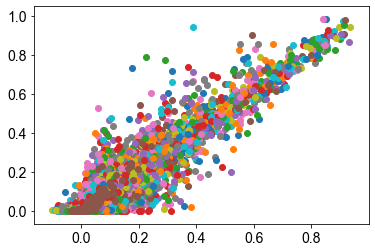

In [80]:
for i in range(376):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [82]:
lesses=  np.zeros(376)
for i in range(376):
    lesses[i] = (get_loss_paper(recon_x.detach().numpy()[i], y.detach().numpy()[i]))

In [83]:
np.nanmean(lesses)

0.11062987973689097

In [85]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=20#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.85723200168907
0.9975132040553918
0.0010721778035425679 0.007446737378860348
9.570560202637155 376.0
encoder_layer_sizes [227, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.3208,  0.4195, -0.2720,  ..., -0.1550, -0.2161, -0.2520],
        [ 3.6430,  0.7997,  6.3485,  ...,  7.6013, 11.8517, -0.1351],
        [-0.3518, -0.1885, -0.2741,  ..., -0.2335, -0.2188, -0.2698],
        ...,
        [-0.0220, -0.1885, -0.2451,  ..., -0.1959, -0.2184, -0.2656],
        [-0.3585, -0.1880, -0.2460,  ..., -0.2145, -0.2026, -0.2698],
        [-0.3423, -0.1869, -0.2739,  ..., -0.2335, -0.2188, -0.2537]],
       dtype=torch.float64)
1 iteration
275.18280029296875
2 iteration
263.6346435546875
3 iteration
253.7543182373047
4 iteration
243.1788330078125
5 iteration
240.1480255126953
6 iteration
234.93753051757812
7 iteration
229.56594848632812
8 iteration
223.8144989013672
9 iteration
219.55087280273438
10 iteration
211.5159149169922
11 iteration
203.60202

3.150529384613037
245 iteration
3.130908727645874
246 iteration
3.2335472106933594
247 iteration
3.0624327659606934
248 iteration
2.9972968101501465
249 iteration
2.9240384101867676
250 iteration
3.0104787349700928
251 iteration
2.8408100605010986
252 iteration
2.93984055519104
253 iteration
3.1906933784484863
254 iteration
3.5679657459259033
255 iteration
3.735867977142334
256 iteration
3.524209976196289
257 iteration
3.4293906688690186
258 iteration
3.420506238937378
259 iteration
3.14033842086792
260 iteration
3.348966121673584
261 iteration
3.3590426445007324
262 iteration
3.1918606758117676
263 iteration
3.1583189964294434
264 iteration
3.145857095718384
265 iteration
3.0192112922668457
266 iteration
3.0199670791625977
267 iteration
2.9643287658691406
268 iteration
2.8689467906951904
269 iteration
3.0171477794647217
270 iteration
2.850250005722046
271 iteration
2.824309825897217
272 iteration
2.712092876434326
273 iteration
2.784499168395996
274 iteration
2.602229595184326
275 ite

0.15736660361289978
495 iteration
0.1623481959104538
496 iteration
0.15479111671447754
497 iteration
0.1462189257144928
498 iteration
0.19846999645233154
499 iteration
0.15111973881721497
500 iteration
0.15436133742332458
501 iteration
0.15698173642158508
502 iteration
0.16823235154151917
503 iteration
0.16085083782672882
504 iteration
0.16206292808055878
505 iteration
0.18230409920215607
506 iteration
0.16096869111061096
507 iteration
0.17785656452178955
508 iteration
0.1449296623468399
509 iteration
0.17327314615249634
510 iteration
0.15848951041698456
511 iteration
0.15241104364395142
512 iteration
0.14900605380535126
513 iteration
0.16270697116851807
514 iteration
0.1508522480726242
515 iteration
0.15326710045337677
516 iteration
0.16576805710792542
517 iteration
0.16484785079956055
518 iteration
0.16350071132183075
519 iteration
0.1637832522392273
520 iteration
0.16744184494018555
521 iteration
0.139273002743721
522 iteration
0.1558513343334198
523 iteration
0.1445269137620926
524

0.1493864506483078
738 iteration
0.13675786554813385
739 iteration
0.1346476525068283
740 iteration
0.1500706672668457
741 iteration
0.14932239055633545
742 iteration
0.13762167096138
743 iteration
0.14416134357452393
744 iteration
0.1413930356502533
745 iteration
0.13375777006149292
746 iteration
0.13823552429676056
747 iteration
0.13333547115325928
748 iteration
0.1253628432750702
749 iteration
0.12563538551330566
750 iteration
0.14607295393943787
751 iteration
0.12231755256652832
752 iteration
0.14385351538658142
753 iteration
0.1369551420211792
754 iteration
0.12369616329669952
755 iteration
0.13622424006462097
756 iteration
0.13406559824943542
757 iteration
0.12953618168830872
758 iteration
0.13000525534152985
759 iteration
0.12548010051250458
760 iteration
0.1438622772693634
761 iteration
0.11547650396823883
762 iteration
0.14448463916778564
763 iteration
0.12997153401374817
764 iteration
0.13456091284751892
765 iteration
0.14069126546382904
766 iteration
0.14787375926971436
767 

0.13599787652492523
983 iteration
0.1452246606349945
984 iteration
0.15424492955207825
985 iteration
0.12067288160324097
986 iteration
0.14710012078285217
987 iteration
0.13233211636543274
988 iteration
0.13500139117240906
989 iteration
0.13031986355781555
990 iteration
0.13308930397033691
991 iteration
0.12602533400058746
992 iteration
0.12933841347694397
993 iteration
0.13126838207244873
994 iteration
0.1141388863325119
995 iteration
0.12860286235809326
996 iteration
0.13569186627864838
997 iteration
0.13782931864261627
998 iteration
0.1256733387708664
999 iteration
0.1314300000667572
1000 iteration
0.1261766254901886
1001 iteration
0.12299327552318573
1002 iteration
0.12309975922107697
1003 iteration
0.12264649569988251
1004 iteration
0.12241534143686295
1005 iteration
0.12852725386619568
1006 iteration
0.13194137811660767
1007 iteration
0.12458422034978867
1008 iteration
0.1310916244983673
1009 iteration
0.13257311284542084
1010 iteration
0.14558252692222595
1011 iteration
0.129127

0.15485011041164398
1227 iteration
0.15576398372650146
1228 iteration
0.17262469232082367
1229 iteration
0.15741094946861267
1230 iteration
0.15825363993644714
1231 iteration
0.16549578309059143
1232 iteration
0.16360273957252502
1233 iteration
0.15194812417030334
1234 iteration
0.13551881909370422
1235 iteration
0.15242823958396912
1236 iteration
0.13511088490486145
1237 iteration
0.1340024322271347
1238 iteration
0.1405872106552124
1239 iteration
0.13083302974700928
1240 iteration
0.12604036927223206
1241 iteration
0.12415168434381485
1242 iteration
0.13864558935165405
1243 iteration
0.12229610979557037
1244 iteration
0.1302368938922882
1245 iteration
0.13092026114463806
1246 iteration
0.1412339210510254
1247 iteration
0.13631156086921692
1248 iteration
0.1208883672952652
1249 iteration
0.12138037383556366
1250 iteration
0.1304064840078354
1251 iteration
0.12479116767644882
1252 iteration
0.12372438609600067
1253 iteration
0.1212899461388588
1254 iteration
0.12896132469177246
1255 it

0.13521480560302734
1469 iteration
0.1262625753879547
1470 iteration
0.11974110454320908
1471 iteration
0.13057050108909607
1472 iteration
0.121623694896698
1473 iteration
0.12452264130115509
1474 iteration
0.13742327690124512
1475 iteration
0.14184054732322693
1476 iteration
0.12367694079875946
1477 iteration
0.14697380363941193
1478 iteration
0.13186928629875183
1479 iteration
0.1374400109052658
1480 iteration
0.12464366853237152
1481 iteration
0.13149674236774445
1482 iteration
0.13285359740257263
1483 iteration
0.13980180025100708
1484 iteration
0.13088715076446533
1485 iteration
0.1320388913154602
1486 iteration
0.1382344514131546
1487 iteration
0.1269707828760147
1488 iteration
0.13770045340061188
1489 iteration
0.1300964057445526
1490 iteration
0.13323022425174713
1491 iteration
0.12641534209251404
1492 iteration
0.13028988242149353
1493 iteration
0.13014917075634003
1494 iteration
0.13989296555519104
1495 iteration
0.13082115352153778
1496 iteration
0.13744468986988068
1497 ite

0.14370843768119812
1712 iteration
0.12762470543384552
1713 iteration
0.14108335971832275
1714 iteration
0.1264621466398239
1715 iteration
0.12769313156604767
1716 iteration
0.14493969082832336
1717 iteration
0.12110836803913116
1718 iteration
0.12711891531944275
1719 iteration
0.12017685174942017
1720 iteration
0.13273262977600098
1721 iteration
0.1254039704799652
1722 iteration
0.1205400675535202
1723 iteration
0.13520538806915283
1724 iteration
0.12687566876411438
1725 iteration
0.12973690032958984
1726 iteration
0.1266053318977356
1727 iteration
0.11893650144338608
1728 iteration
0.13374243676662445
1729 iteration
0.12300027906894684
1730 iteration
0.14309576153755188
1731 iteration
0.12158188968896866
1732 iteration
0.12714819610118866
1733 iteration
0.1468132585287094
1734 iteration
0.13424059748649597
1735 iteration
0.14165638387203217
1736 iteration
0.12151559442281723
1737 iteration
0.13452410697937012
1738 iteration
0.11521007865667343
1739 iteration
0.1374509483575821
1740 i

0.12890473008155823
1957 iteration
0.13198727369308472
1958 iteration
0.16278903186321259
1959 iteration
0.13580191135406494
1960 iteration
0.14262253046035767
1961 iteration
0.1468675583600998
1962 iteration
0.12515418231487274
1963 iteration
0.17358526587486267
1964 iteration
0.1382192075252533
1965 iteration
0.16264107823371887
1966 iteration
0.15288519859313965
1967 iteration
0.13836181163787842
1968 iteration
0.15033280849456787
1969 iteration
0.13068589568138123
1970 iteration
0.14488807320594788
1971 iteration
0.13630658388137817
1972 iteration
0.14652900397777557
1973 iteration
0.1330479085445404
1974 iteration
0.15684081614017487
1975 iteration
0.13610465824604034
1976 iteration
0.17512035369873047
1977 iteration
0.14916595816612244
1978 iteration
0.1767774373292923
1979 iteration
0.16239485144615173
1980 iteration
0.16270402073860168
1981 iteration
0.14727985858917236
1982 iteration
0.15924549102783203
1983 iteration
0.150976300239563
1984 iteration
0.14219948649406433
1985 i

0.12772323191165924
2204 iteration
0.12889084219932556
2205 iteration
0.12083248794078827
2206 iteration
0.1293749064207077
2207 iteration
0.12167544662952423
2208 iteration
0.13332128524780273
2209 iteration
0.13834352791309357
2210 iteration
0.11884133517742157
2211 iteration
0.1510389745235443
2212 iteration
0.1213402971625328
2213 iteration
0.13283462822437286
2214 iteration
0.13574516773223877
2215 iteration
0.12055139243602753
2216 iteration
0.1322440803050995
2217 iteration
0.1236916184425354
2218 iteration
0.11923028528690338
2219 iteration
0.13120830059051514
2220 iteration
0.1261630803346634
2221 iteration
0.14354856312274933
2222 iteration
0.12553489208221436
2223 iteration
0.1401178389787674
2224 iteration
0.1429891586303711
2225 iteration
0.12615928053855896
2226 iteration
0.1497901976108551
2227 iteration
0.13399629294872284
2228 iteration
0.1517048329114914
2229 iteration
0.12476563453674316
2230 iteration
0.145586758852005
2231 iteration
0.12729842960834503
2232 iterati

0.12698397040367126
2450 iteration
0.12957176566123962
2451 iteration
0.12344769388437271
2452 iteration
0.1249588280916214
2453 iteration
0.11215116828680038
2454 iteration
0.13419613242149353
2455 iteration
0.11736873537302017
2456 iteration
0.12735143303871155
2457 iteration
0.1287470906972885
2458 iteration
0.13155439496040344
2459 iteration
0.1312999725341797
2460 iteration
0.12405194342136383
2461 iteration
0.12198153883218765
2462 iteration
0.13324812054634094
2463 iteration
0.13066618144512177
2464 iteration
0.13406971096992493
2465 iteration
0.1376543492078781
2466 iteration
0.1306428164243698
2467 iteration
0.13062340021133423
2468 iteration
0.1285589039325714
2469 iteration
0.15010543167591095
2470 iteration
0.1289995014667511
2471 iteration
0.1461351215839386
2472 iteration
0.14027948677539825
2473 iteration
0.14615875482559204
2474 iteration
0.14183510839939117
2475 iteration
0.15199744701385498
2476 iteration
0.14184319972991943
2477 iteration
0.17178574204444885
2478 ite

0.13965603709220886
2699 iteration
0.12138054519891739
2700 iteration
0.13616344332695007
2701 iteration
0.1404884159564972
2702 iteration
0.13717451691627502
2703 iteration
0.133459210395813
2704 iteration
0.13810773193836212
2705 iteration
0.13822238147258759
2706 iteration
0.13936007022857666
2707 iteration
0.1372602880001068
2708 iteration
0.13546141982078552
2709 iteration
0.14668500423431396
2710 iteration
0.13107509911060333
2711 iteration
0.1459517925977707
2712 iteration
0.131576269865036
2713 iteration
0.1469181776046753
2714 iteration
0.12896813452243805
2715 iteration
0.15349635481834412
2716 iteration
0.14508561789989471
2717 iteration
0.13583561778068542
2718 iteration
0.13107888400554657
2719 iteration
0.14625760912895203
2720 iteration
0.13325874507427216
2721 iteration
0.13250771164894104
2722 iteration
0.13757339119911194
2723 iteration
0.12927290797233582
2724 iteration
0.13100628554821014
2725 iteration
0.12842707335948944
2726 iteration
0.1259392350912094
2727 iter

0.11845745146274567
2948 iteration
0.12792256474494934
2949 iteration
0.12172859907150269
2950 iteration
0.12399361282587051
2951 iteration
0.11941178143024445
2952 iteration
0.11217781156301498
2953 iteration
0.11722922325134277
2954 iteration
0.1176087036728859
2955 iteration
0.11988499015569687
2956 iteration
0.11721289157867432
2957 iteration
0.11346802860498428
2958 iteration
0.12390048801898956
2959 iteration
0.13180133700370789
2960 iteration
0.12715622782707214
2961 iteration
0.12269121408462524
2962 iteration
0.12297066301107407
2963 iteration
0.1196206584572792
2964 iteration
0.11961785703897476
2965 iteration
0.1272936761379242
2966 iteration
0.12691986560821533
2967 iteration
0.1152176633477211
2968 iteration
0.12824353575706482
2969 iteration
0.13036666810512543
2970 iteration
0.12832775712013245
2971 iteration
0.13331207633018494
2972 iteration
0.12268988788127899
2973 iteration
0.1253128945827484
2974 iteration
0.1274101436138153
2975 iteration
0.1211591511964798
2976 it

0.14588727056980133
3193 iteration
0.13104578852653503
3194 iteration
0.140534907579422
3195 iteration
0.1451423019170761
3196 iteration
0.14642217755317688
3197 iteration
0.1442052721977234
3198 iteration
0.13124139606952667
3199 iteration
0.14074090123176575
3200 iteration
0.12332010269165039
3201 iteration
0.14467911422252655
3202 iteration
0.13950231671333313
3203 iteration
0.12545445561408997
3204 iteration
0.13248424232006073
3205 iteration
0.12395639717578888
3206 iteration
0.13462014496326447
3207 iteration
0.14120261371135712
3208 iteration
0.12198058515787125
3209 iteration
0.13908755779266357
3210 iteration
0.13335171341896057
3211 iteration
0.1254650205373764
3212 iteration
0.14424797892570496
3213 iteration
0.13089747726917267
3214 iteration
0.14111168682575226
3215 iteration
0.1342976838350296
3216 iteration
0.15203766524791718
3217 iteration
0.14340345561504364
3218 iteration
0.1337258219718933
3219 iteration
0.15375325083732605
3220 iteration
0.13828404247760773
3221 it

0.13644437491893768
3438 iteration
0.13681404292583466
3439 iteration
0.11992541700601578
3440 iteration
0.12898722290992737
3441 iteration
0.12085628509521484
3442 iteration
0.12800268828868866
3443 iteration
0.12485458701848984
3444 iteration
0.13287046551704407
3445 iteration
0.12451343238353729
3446 iteration
0.11220356076955795
3447 iteration
0.12607812881469727
3448 iteration
0.12270921468734741
3449 iteration
0.11753187328577042
3450 iteration
0.12558779120445251
3451 iteration
0.11453630775213242
3452 iteration
0.12424669414758682
3453 iteration
0.1285683810710907
3454 iteration
0.14616374671459198
3455 iteration
0.13942500948905945
3456 iteration
0.13123638927936554
3457 iteration
0.1257498562335968
3458 iteration
0.1373109370470047
3459 iteration
0.13330474495887756
3460 iteration
0.1312638223171234
3461 iteration
0.12612323462963104
3462 iteration
0.1322493553161621
3463 iteration
0.1484793722629547
3464 iteration
0.13603638112545013
3465 iteration
0.1344359964132309
3466 it

0.13758894801139832
3685 iteration
0.125970259308815
3686 iteration
0.13067097961902618
3687 iteration
0.12937787175178528
3688 iteration
0.12831485271453857
3689 iteration
0.1385347843170166
3690 iteration
0.1235356479883194
3691 iteration
0.1255977898836136
3692 iteration
0.13297459483146667
3693 iteration
0.13469496369361877
3694 iteration
0.13109329342842102
3695 iteration
0.12803015112876892
3696 iteration
0.15257009863853455
3697 iteration
0.13603217899799347
3698 iteration
0.1559256762266159
3699 iteration
0.1406138837337494
3700 iteration
0.14493881165981293
3701 iteration
0.12946495413780212
3702 iteration
0.14466789364814758
3703 iteration
0.12897257506847382
3704 iteration
0.13084812462329865
3705 iteration
0.12849920988082886
3706 iteration
0.12639708817005157
3707 iteration
0.12469325214624405
3708 iteration
0.12555931508541107
3709 iteration
0.1320105940103531
3710 iteration
0.1220402866601944
3711 iteration
0.13750021159648895
3712 iteration
0.1225251704454422
3713 itera

0.13410499691963196
3931 iteration
0.12291941791772842
3932 iteration
0.12857140600681305
3933 iteration
0.12621662020683289
3934 iteration
0.12684699892997742
3935 iteration
0.12754040956497192
3936 iteration
0.12629438936710358
3937 iteration
0.11492496728897095
3938 iteration
0.12796631455421448
3939 iteration
0.11940880864858627
3940 iteration
0.1262216866016388
3941 iteration
0.12025705724954605
3942 iteration
0.12300077825784683
3943 iteration
0.12587802112102509
3944 iteration
0.12473750114440918
3945 iteration
0.12855707108974457
3946 iteration
0.14075270295143127
3947 iteration
0.12845242023468018
3948 iteration
0.13300809264183044
3949 iteration
0.1374344527721405
3950 iteration
0.12014645338058472
3951 iteration
0.1352871209383011
3952 iteration
0.12788338959217072
3953 iteration
0.13165496289730072
3954 iteration
0.12323126941919327
3955 iteration
0.1286068856716156
3956 iteration
0.1413266956806183
3957 iteration
0.12345661967992783
3958 iteration
0.13246652483940125
3959 

0.12511900067329407
4174 iteration
0.13093754649162292
4175 iteration
0.1106388196349144
4176 iteration
0.13662946224212646
4177 iteration
0.12234847247600555
4178 iteration
0.1252150535583496
4179 iteration
0.12128434330224991
4180 iteration
0.1259675770998001
4181 iteration
0.11840122938156128
4182 iteration
0.12715855240821838
4183 iteration
0.1300259381532669
4184 iteration
0.1327192634344101
4185 iteration
0.13685445487499237
4186 iteration
0.13342589139938354
4187 iteration
0.13649070262908936
4188 iteration
0.12961842119693756
4189 iteration
0.13186119496822357
4190 iteration
0.12115929275751114
4191 iteration
0.13580715656280518
4192 iteration
0.13400627672672272
4193 iteration
0.11951561272144318
4194 iteration
0.16343805193901062
4195 iteration
0.134360671043396
4196 iteration
0.12046843767166138
4197 iteration
0.12872520089149475
4198 iteration
0.14008089900016785
4199 iteration
0.11599919945001602
4200 iteration
0.1335330754518509
4201 iteration
0.12433352321386337
4202 ite

0.12524786591529846
4419 iteration
0.1316971778869629
4420 iteration
0.13292841613292694
4421 iteration
0.1362317055463791
4422 iteration
0.126251682639122
4423 iteration
0.12710624933242798
4424 iteration
0.1339724361896515
4425 iteration
0.12789730727672577
4426 iteration
0.13581185042858124
4427 iteration
0.1379392445087433
4428 iteration
0.13805973529815674
4429 iteration
0.1392657607793808
4430 iteration
0.13580241799354553
4431 iteration
0.14098374545574188
4432 iteration
0.13154037296772003
4433 iteration
0.14257438480854034
4434 iteration
0.13448934257030487
4435 iteration
0.12805692851543427
4436 iteration
0.12839046120643616
4437 iteration
0.12666143476963043
4438 iteration
0.12929770350456238
4439 iteration
0.12611563503742218
4440 iteration
0.139109805226326
4441 iteration
0.13206863403320312
4442 iteration
0.1335495412349701
4443 iteration
0.12430288642644882
4444 iteration
0.13797490298748016
4445 iteration
0.13743923604488373
4446 iteration
0.1311475783586502
4447 iterat

0.13068285584449768
4677 iteration
0.12611238658428192
4678 iteration
0.11842715740203857
4679 iteration
0.13070495426654816
4680 iteration
0.12871673703193665
4681 iteration
0.1274835467338562
4682 iteration
0.12257830053567886
4683 iteration
0.1277337521314621
4684 iteration
0.12117139250040054
4685 iteration
0.13002032041549683
4686 iteration
0.12500476837158203
4687 iteration
0.1358642876148224
4688 iteration
0.13129599392414093
4689 iteration
0.1279425323009491
4690 iteration
0.12703247368335724
4691 iteration
0.11664970964193344
4692 iteration
0.1269705593585968
4693 iteration
0.14160151779651642
4694 iteration
0.12319278717041016
4695 iteration
0.13168556988239288
4696 iteration
0.12346561253070831
4697 iteration
0.1332182139158249
4698 iteration
0.1264912486076355
4699 iteration
0.1403060257434845
4700 iteration
0.13560304045677185
4701 iteration
0.13775284588336945
4702 iteration
0.12676990032196045
4703 iteration
0.13905929028987885
4704 iteration
0.12740567326545715
4705 ite

0.13027432560920715
4920 iteration
0.11363573372364044
4921 iteration
0.12517544627189636
4922 iteration
0.11827639490365982
4923 iteration
0.12253211438655853
4924 iteration
0.11710038036108017
4925 iteration
0.11747582256793976
4926 iteration
0.12759262323379517
4927 iteration
0.11782674491405487
4928 iteration
0.12397780269384384
4929 iteration
0.11865091323852539
4930 iteration
0.12322932481765747
4931 iteration
0.11708934605121613
4932 iteration
0.12789931893348694
4933 iteration
0.12610264122486115
4934 iteration
0.10924309492111206
4935 iteration
0.11955936998128891
4936 iteration
0.11192270368337631
4937 iteration
0.12032908201217651
4938 iteration
0.11501289904117584
4939 iteration
0.11697256565093994
4940 iteration
0.11394785344600677
4941 iteration
0.11509094387292862
4942 iteration
0.11715555191040039
4943 iteration
0.11871866136789322
4944 iteration
0.11465555429458618
4945 iteration
0.12336180359125137
4946 iteration
0.11632280051708221
4947 iteration
0.10910248756408691


0.13254061341285706
5167 iteration
0.14203450083732605
5168 iteration
0.12414133548736572
5169 iteration
0.12610939145088196
5170 iteration
0.1232537031173706
5171 iteration
0.12528200447559357
5172 iteration
0.12458246946334839
5173 iteration
0.12742693722248077
5174 iteration
0.12353028357028961
5175 iteration
0.12371692806482315
5176 iteration
0.12428245693445206
5177 iteration
0.11495969444513321
5178 iteration
0.11943189799785614
5179 iteration
0.1156756728887558
5180 iteration
0.12475691735744476
5181 iteration
0.10972742736339569
5182 iteration
0.11351855844259262
5183 iteration
0.11830632388591766
5184 iteration
0.1222439855337143
5185 iteration
0.11073052883148193
5186 iteration
0.11859072744846344
5187 iteration
0.115176722407341
5188 iteration
0.12124285846948624
5189 iteration
0.1114741787314415
5190 iteration
0.11942394077777863
5191 iteration
0.12041153758764267
5192 iteration
0.1182737797498703
5193 iteration
0.11780071258544922
5194 iteration
0.1205870732665062
5195 ite

0.1251530945301056
5413 iteration
0.1335875540971756
5414 iteration
0.123735211789608
5415 iteration
0.13867679238319397
5416 iteration
0.11978591978549957
5417 iteration
0.13480007648468018
5418 iteration
0.11747859418392181
5419 iteration
0.12132923305034637
5420 iteration
0.12692832946777344
5421 iteration
0.12505769729614258
5422 iteration
0.12290044128894806
5423 iteration
0.1154526099562645
5424 iteration
0.11639164388179779
5425 iteration
0.11483798176050186
5426 iteration
0.11618728935718536
5427 iteration
0.11870811134576797
5428 iteration
0.1225101500749588
5429 iteration
0.11583644151687622
5430 iteration
0.11458287388086319
5431 iteration
0.11897106468677521
5432 iteration
0.11421571671962738
5433 iteration
0.11870203167200089
5434 iteration
0.11814794689416885
5435 iteration
0.1253800392150879
5436 iteration
0.11548147350549698
5437 iteration
0.12293186038732529
5438 iteration
0.11738519370555878
5439 iteration
0.11627084016799927
5440 iteration
0.13335560262203217
5441 it

0.12996551394462585
5658 iteration
0.115961454808712
5659 iteration
0.11353595554828644
5660 iteration
0.12959635257720947
5661 iteration
0.11303925514221191
5662 iteration
0.13565342128276825
5663 iteration
0.11452756077051163
5664 iteration
0.1273360550403595
5665 iteration
0.12490018457174301
5666 iteration
0.13446907699108124
5667 iteration
0.12752434611320496
5668 iteration
0.12767300009727478
5669 iteration
0.1365281641483307
5670 iteration
0.1257476955652237
5671 iteration
0.12737484276294708
5672 iteration
0.13008520007133484
5673 iteration
0.12687520682811737
5674 iteration
0.12763604521751404
5675 iteration
0.12153466045856476
5676 iteration
0.13321836292743683
5677 iteration
0.11899103224277496
5678 iteration
0.1255757361650467
5679 iteration
0.13843122124671936
5680 iteration
0.11998628079891205
5681 iteration
0.12904882431030273
5682 iteration
0.11939068138599396
5683 iteration
0.13739736378192902
5684 iteration
0.11525033414363861
5685 iteration
0.1369868814945221
5686 it

0.11303219944238663
5907 iteration
0.11775729805231094
5908 iteration
0.11133638769388199
5909 iteration
0.11131782829761505
5910 iteration
0.116502545773983
5911 iteration
0.11759450286626816
5912 iteration
0.12265904992818832
5913 iteration
0.11533190310001373
5914 iteration
0.11575894057750702
5915 iteration
0.11355598270893097
5916 iteration
0.11628583818674088
5917 iteration
0.11957831680774689
5918 iteration
0.11813964694738388
5919 iteration
0.12176182121038437
5920 iteration
0.11431100219488144
5921 iteration
0.11433001607656479
5922 iteration
0.1067936047911644
5923 iteration
0.11078847944736481
5924 iteration
0.11670547723770142
5925 iteration
0.11183464527130127
5926 iteration
0.11602111160755157
5927 iteration
0.11703282594680786
5928 iteration
0.1154051423072815
5929 iteration
0.11357462406158447
5930 iteration
0.12097970396280289
5931 iteration
0.1149149090051651
5932 iteration
0.11899177730083466
5933 iteration
0.11668379604816437
5934 iteration
0.11557326465845108
5935 

0.12462329864501953
6156 iteration
0.1216742992401123
6157 iteration
0.12294705212116241
6158 iteration
0.11410774290561676
6159 iteration
0.12905851006507874
6160 iteration
0.1159287691116333
6161 iteration
0.12872551381587982
6162 iteration
0.11094902455806732
6163 iteration
0.125733882188797
6164 iteration
0.12012989819049835
6165 iteration
0.12087923288345337
6166 iteration
0.1201181411743164
6167 iteration
0.11337997019290924
6168 iteration
0.11501860618591309
6169 iteration
0.11582555621862411
6170 iteration
0.12763981521129608
6171 iteration
0.12106367200613022
6172 iteration
0.12151583284139633
6173 iteration
0.10982649028301239
6174 iteration
0.11398465931415558
6175 iteration
0.12003852427005768
6176 iteration
0.11176824569702148
6177 iteration
0.11721383035182953
6178 iteration
0.11294591426849365
6179 iteration
0.11776517331600189
6180 iteration
0.1127999797463417
6181 iteration
0.11326684802770615
6182 iteration
0.1098494678735733
6183 iteration
0.11210427433252335
6184 it

0.10906871408224106
6407 iteration
0.12610343098640442
6408 iteration
0.12319415807723999
6409 iteration
0.12310483306646347
6410 iteration
0.1178995743393898
6411 iteration
0.12682922184467316
6412 iteration
0.1169990748167038
6413 iteration
0.13733980059623718
6414 iteration
0.1142580658197403
6415 iteration
0.13536188006401062
6416 iteration
0.12382330000400543
6417 iteration
0.15259990096092224
6418 iteration
0.12009765952825546
6419 iteration
0.13645002245903015
6420 iteration
0.11969717592000961
6421 iteration
0.13346359133720398
6422 iteration
0.11871156841516495
6423 iteration
0.12792854011058807
6424 iteration
0.12110669910907745
6425 iteration
0.12828972935676575
6426 iteration
0.11862155050039291
6427 iteration
0.11607110500335693
6428 iteration
0.12252269685268402
6429 iteration
0.11953376233577728
6430 iteration
0.12254047393798828
6431 iteration
0.12578508257865906
6432 iteration
0.11947349458932877
6433 iteration
0.11460836976766586
6434 iteration
0.12570400536060333
643

0.13065962493419647
6651 iteration
0.12326149642467499
6652 iteration
0.132788747549057
6653 iteration
0.11820715665817261
6654 iteration
0.1342865526676178
6655 iteration
0.11264940351247787
6656 iteration
0.12946811318397522
6657 iteration
0.12459421157836914
6658 iteration
0.12272818386554718
6659 iteration
0.11427302658557892
6660 iteration
0.10482386499643326
6661 iteration
0.12465658038854599
6662 iteration
0.11554612219333649
6663 iteration
0.11504101753234863
6664 iteration
0.11127002537250519
6665 iteration
0.11544401943683624
6666 iteration
0.11087390035390854
6667 iteration
0.11148986965417862
6668 iteration
0.1202613115310669
6669 iteration
0.11318230628967285
6670 iteration
0.12104950845241547
6671 iteration
0.11169896274805069
6672 iteration
0.11603335291147232
6673 iteration
0.11685740947723389
6674 iteration
0.12449538707733154
6675 iteration
0.11377070099115372
6676 iteration
0.1268852949142456
6677 iteration
0.11954671144485474
6678 iteration
0.11641611903905869
6679 

0.11391039192676544
6897 iteration
0.11553897708654404
6898 iteration
0.10951553285121918
6899 iteration
0.11833469569683075
6900 iteration
0.11084669828414917
6901 iteration
0.11303117126226425
6902 iteration
0.11834919452667236
6903 iteration
0.1140792965888977
6904 iteration
0.11358709633350372
6905 iteration
0.11507730185985565
6906 iteration
0.11739234626293182
6907 iteration
0.10932153463363647
6908 iteration
0.1150057315826416
6909 iteration
0.11574311554431915
6910 iteration
0.10847485065460205
6911 iteration
0.11641567945480347
6912 iteration
0.11105725914239883
6913 iteration
0.1152554303407669
6914 iteration
0.10599708557128906
6915 iteration
0.12747402489185333
6916 iteration
0.1155562773346901
6917 iteration
0.10932064056396484
6918 iteration
0.12238528579473495
6919 iteration
0.11771734058856964
6920 iteration
0.1094168871641159
6921 iteration
0.10439720004796982
6922 iteration
0.12234463542699814
6923 iteration
0.11373267322778702
6924 iteration
0.12038256973028183
6925 

0.11994870752096176
7146 iteration
0.11510632932186127
7147 iteration
0.1141553744673729
7148 iteration
0.11657845973968506
7149 iteration
0.1117040142416954
7150 iteration
0.10464541614055634
7151 iteration
0.10877622663974762
7152 iteration
0.11008016020059586
7153 iteration
0.11536405235528946
7154 iteration
0.1008671298623085
7155 iteration
0.11047699302434921
7156 iteration
0.11135907471179962
7157 iteration
0.11199186742305756
7158 iteration
0.10713794082403183
7159 iteration
0.10625283420085907
7160 iteration
0.11931388080120087
7161 iteration
0.11210975795984268
7162 iteration
0.10706237703561783
7163 iteration
0.11377525329589844
7164 iteration
0.12111439555883408
7165 iteration
0.1216176375746727
7166 iteration
0.11840911209583282
7167 iteration
0.1150076761841774
7168 iteration
0.12610192596912384
7169 iteration
0.11679024994373322
7170 iteration
0.11798042058944702
7171 iteration
0.1121387928724289
7172 iteration
0.1254730522632599
7173 iteration
0.11673609912395477
7174 it

0.11590176820755005
7394 iteration
0.10999055951833725
7395 iteration
0.11804024130105972
7396 iteration
0.12076044082641602
7397 iteration
0.11995259672403336
7398 iteration
0.12021230161190033
7399 iteration
0.11369337886571884
7400 iteration
0.11261172592639923
7401 iteration
0.1164756566286087
7402 iteration
0.1186113953590393
7403 iteration
0.11320745944976807
7404 iteration
0.11043304204940796
7405 iteration
0.11579199880361557
7406 iteration
0.11105383932590485
7407 iteration
0.12106187641620636
7408 iteration
0.10971537977457047
7409 iteration
0.10933516174554825
7410 iteration
0.11924435198307037
7411 iteration
0.11384157091379166
7412 iteration
0.12473180145025253
7413 iteration
0.11841259896755219
7414 iteration
0.11717555671930313
7415 iteration
0.11558141559362411
7416 iteration
0.1185176819562912
7417 iteration
0.11233706772327423
7418 iteration
0.10831750929355621
7419 iteration
0.11762343347072601
7420 iteration
0.1100894957780838
7421 iteration
0.12371810525655746
7422

0.10861237347126007
7645 iteration
0.11287640035152435
7646 iteration
0.12037213146686554
7647 iteration
0.11770856380462646
7648 iteration
0.12782569229602814
7649 iteration
0.1150861531496048
7650 iteration
0.12607720494270325
7651 iteration
0.11671952158212662
7652 iteration
0.12566354870796204
7653 iteration
0.1108221784234047
7654 iteration
0.12095149606466293
7655 iteration
0.11541633307933807
7656 iteration
0.1306842863559723
7657 iteration
0.11168905347585678
7658 iteration
0.13215655088424683
7659 iteration
0.11736003309488297
7660 iteration
0.12959140539169312
7661 iteration
0.1159573420882225
7662 iteration
0.1169453039765358
7663 iteration
0.11380960792303085
7664 iteration
0.12376072257757187
7665 iteration
0.12213015556335449
7666 iteration
0.11250345408916473
7667 iteration
0.12396109104156494
7668 iteration
0.11262514442205429
7669 iteration
0.11797764152288437
7670 iteration
0.11514203250408173
7671 iteration
0.11477456241846085
7672 iteration
0.11253924667835236
7673 

0.11457104980945587
7885 iteration
0.10725948959589005
7886 iteration
0.11314624547958374
7887 iteration
0.10289003700017929
7888 iteration
0.11684484779834747
7889 iteration
0.11241753399372101
7890 iteration
0.11093480885028839
7891 iteration
0.11150474846363068
7892 iteration
0.1140703335404396
7893 iteration
0.10718397796154022
7894 iteration
0.10713167488574982
7895 iteration
0.10532808303833008
7896 iteration
0.11006999015808105
7897 iteration
0.10929141938686371
7898 iteration
0.11282055079936981
7899 iteration
0.1089121550321579
7900 iteration
0.11726753413677216
7901 iteration
0.11800898611545563
7902 iteration
0.11187605559825897
7903 iteration
0.10864676535129547
7904 iteration
0.11072710901498795
7905 iteration
0.11193158477544785
7906 iteration
0.10417542606592178
7907 iteration
0.1112702488899231
7908 iteration
0.10344693809747696
7909 iteration
0.10637728869915009
7910 iteration
0.11484313011169434
7911 iteration
0.10047836601734161
7912 iteration
0.1133740097284317
7913

0.11769433319568634
8126 iteration
0.12583979964256287
8127 iteration
0.11807973682880402
8128 iteration
0.13063672184944153
8129 iteration
0.11378234624862671
8130 iteration
0.13421115279197693
8131 iteration
0.1233060210943222
8132 iteration
0.11312122642993927
8133 iteration
0.12146055698394775
8134 iteration
0.12850725650787354
8135 iteration
0.12084736675024033
8136 iteration
0.12420620769262314
8137 iteration
0.11843600124120712
8138 iteration
0.12376749515533447
8139 iteration
0.13595141470432281
8140 iteration
0.1224280595779419
8141 iteration
0.11793096363544464
8142 iteration
0.12232933193445206
8143 iteration
0.1282423734664917
8144 iteration
0.1237117201089859
8145 iteration
0.11999990046024323
8146 iteration
0.12004456669092178
8147 iteration
0.13154497742652893
8148 iteration
0.1247054934501648
8149 iteration
0.11765526235103607
8150 iteration
0.1263924092054367
8151 iteration
0.11543438583612442
8152 iteration
0.12295661866664886
8153 iteration
0.11207796633243561
8154 i

0.12161432206630707
8391 iteration
0.10493935644626617
8392 iteration
0.11598052829504013
8393 iteration
0.12064436823129654
8394 iteration
0.11422141641378403
8395 iteration
0.11875693500041962
8396 iteration
0.12593235075473785
8397 iteration
0.11579062044620514
8398 iteration
0.12720923125743866
8399 iteration
0.11006037890911102
8400 iteration
0.12956945598125458
8401 iteration
0.11220214515924454
8402 iteration
0.12224795669317245
8403 iteration
0.11400635540485382
8404 iteration
0.12143976986408234
8405 iteration
0.11214784532785416
8406 iteration
0.1262073516845703
8407 iteration
0.12073640525341034
8408 iteration
0.11605353653430939
8409 iteration
0.11558622121810913
8410 iteration
0.11039252579212189
8411 iteration
0.118587926030159
8412 iteration
0.12342041730880737
8413 iteration
0.1213502436876297
8414 iteration
0.1350765973329544
8415 iteration
0.11938898265361786
8416 iteration
0.1243138536810875
8417 iteration
0.11874546855688095
8418 iteration
0.12298104912042618
8419 i

0.10925791412591934
8643 iteration
0.1097811907529831
8644 iteration
0.10403609275817871
8645 iteration
0.10795065015554428
8646 iteration
0.10559382289648056
8647 iteration
0.09901733696460724
8648 iteration
0.09810926765203476
8649 iteration
0.10163472592830658
8650 iteration
0.10230585187673569
8651 iteration
0.10942023992538452
8652 iteration
0.10145170986652374
8653 iteration
0.10742251574993134
8654 iteration
0.10327935218811035
8655 iteration
0.10665352642536163
8656 iteration
0.10411505401134491
8657 iteration
0.10373139381408691
8658 iteration
0.11706371605396271
8659 iteration
0.10069195181131363
8660 iteration
0.11203370243310928
8661 iteration
0.10689433664083481
8662 iteration
0.10755549371242523
8663 iteration
0.10993989557027817
8664 iteration
0.10967664420604706
8665 iteration
0.11681697517633438
8666 iteration
0.11217842251062393
8667 iteration
0.11746802181005478
8668 iteration
0.10463498532772064
8669 iteration
0.11358831822872162
8670 iteration
0.11443507671356201
8

0.11134244501590729
8892 iteration
0.11656524986028671
8893 iteration
0.10721977055072784
8894 iteration
0.10511106252670288
8895 iteration
0.11168348789215088
8896 iteration
0.11260411888360977
8897 iteration
0.10899176448583603
8898 iteration
0.10572397708892822
8899 iteration
0.11259496212005615
8900 iteration
0.11013402789831161
8901 iteration
0.1138484925031662
8902 iteration
0.10228556394577026
8903 iteration
0.10506369918584824
8904 iteration
0.1078818291425705
8905 iteration
0.11263718456029892
8906 iteration
0.11252553761005402
8907 iteration
0.1108245700597763
8908 iteration
0.11799357086420059
8909 iteration
0.10521473735570908
8910 iteration
0.11340145021677017
8911 iteration
0.10771255195140839
8912 iteration
0.11177680641412735
8913 iteration
0.10760724544525146
8914 iteration
0.10993804782629013
8915 iteration
0.10522688925266266
8916 iteration
0.10400746762752533
8917 iteration
0.10632910579442978
8918 iteration
0.10325318574905396
8919 iteration
0.10758253186941147
892

0.11034420877695084
9137 iteration
0.10148469358682632
9138 iteration
0.10418198257684708
9139 iteration
0.10254795849323273
9140 iteration
0.1029924601316452
9141 iteration
0.1117154210805893
9142 iteration
0.10790510475635529
9143 iteration
0.10871066153049469
9144 iteration
0.11012826859951019
9145 iteration
0.10349942743778229
9146 iteration
0.10610892623662949
9147 iteration
0.09914533793926239
9148 iteration
0.09787515550851822
9149 iteration
0.09664388000965118
9150 iteration
0.0997253805398941
9151 iteration
0.10819963365793228
9152 iteration
0.0945228859782219
9153 iteration
0.10627283155918121
9154 iteration
0.10126253217458725
9155 iteration
0.09944752603769302
9156 iteration
0.10534189641475677
9157 iteration
0.10893192142248154
9158 iteration
0.10412879288196564
9159 iteration
0.10270168632268906
9160 iteration
0.10772047191858292
9161 iteration
0.10468064248561859
9162 iteration
0.10327980667352676
9163 iteration
0.10068619251251221
9164 iteration
0.10482297092676163
9165

0.1150100976228714
9384 iteration
0.10034922510385513
9385 iteration
0.11090405285358429
9386 iteration
0.10867424309253693
9387 iteration
0.10780632495880127
9388 iteration
0.11069761216640472
9389 iteration
0.09717829525470734
9390 iteration
0.1094113439321518
9391 iteration
0.11033365875482559
9392 iteration
0.10233334451913834
9393 iteration
0.11402969062328339
9394 iteration
0.09588472545146942
9395 iteration
0.10828380286693573
9396 iteration
0.11351741850376129
9397 iteration
0.10085548460483551
9398 iteration
0.10411933809518814
9399 iteration
0.10532797873020172
9400 iteration
0.09778197109699249
9401 iteration
0.10284342616796494
9402 iteration
0.10457154363393784
9403 iteration
0.10268821567296982
9404 iteration
0.10368760675191879
9405 iteration
0.11075979471206665
9406 iteration
0.1122770756483078
9407 iteration
0.10673795640468597
9408 iteration
0.10926111042499542
9409 iteration
0.10462509095668793
9410 iteration
0.1092844158411026
9411 iteration
0.09850016236305237
9412

0.11092627048492432
9635 iteration
0.10280533879995346
9636 iteration
0.10269670188426971
9637 iteration
0.10176382213830948
9638 iteration
0.09926977008581161
9639 iteration
0.1013331413269043
9640 iteration
0.10151157528162003
9641 iteration
0.09766040742397308
9642 iteration
0.09806074947118759
9643 iteration
0.0921420156955719
9644 iteration
0.09696462750434875
9645 iteration
0.10016189515590668
9646 iteration
0.09976895153522491
9647 iteration
0.10217815637588501
9648 iteration
0.10220024734735489
9649 iteration
0.09488830715417862
9650 iteration
0.09528745710849762
9651 iteration
0.09147769957780838
9652 iteration
0.09921226650476456
9653 iteration
0.09988298267126083
9654 iteration
0.10734089463949203
9655 iteration
0.10051901638507843
9656 iteration
0.10106198489665985
9657 iteration
0.10399307310581207
9658 iteration
0.09553245455026627
9659 iteration
0.10557285696268082
9660 iteration
0.10238584131002426
9661 iteration
0.10076018422842026
9662 iteration
0.11327008157968521
96

0.10245367139577866
9882 iteration
0.10937925428152084
9883 iteration
0.0998697504401207
9884 iteration
0.10228350013494492
9885 iteration
0.10374882072210312
9886 iteration
0.10384980589151382
9887 iteration
0.10297118127346039
9888 iteration
0.10783417522907257
9889 iteration
0.09918136149644852
9890 iteration
0.10386679321527481
9891 iteration
0.12292461097240448
9892 iteration
0.10085172951221466
9893 iteration
0.10982406139373779
9894 iteration
0.11841156333684921
9895 iteration
0.09806643426418304
9896 iteration
0.13021191954612732
9897 iteration
0.10475697368383408
9898 iteration
0.11121253669261932
9899 iteration
0.11097009479999542
9900 iteration
0.11251597106456757
9901 iteration
0.1048138290643692
9902 iteration
0.1170157790184021
9903 iteration
0.10091270506381989
9904 iteration
0.10923166573047638
9905 iteration
0.11641379445791245
9906 iteration
0.10407118499279022
9907 iteration
0.10617363452911377
9908 iteration
0.10371376574039459
9909 iteration
0.10705511271953583
991

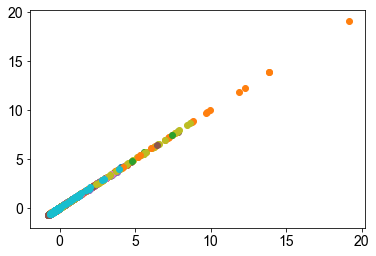

In [86]:
for i in range(20):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [87]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=50#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.857241122320249
0.997512383555535
0.0010721778031371311 0.007446737378860348
9.56972217536942 376.0
encoder_layer_sizes [227, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.3311, -0.1883, -0.2733,  ..., -0.2335, -0.2180, -0.2380],
        [-0.1564, -0.1871, -0.2570,  ..., -0.1702, -0.1348, -0.2672],
        [-0.3131, -0.1846, -0.2566,  ..., -0.2272, -0.2188, -0.2561],
        ...,
        [-0.1918, -0.1884, -0.2726,  ..., -0.2310, -0.2188, -0.2650],
        [-0.3311, -0.1871, -0.2709,  ..., -0.1570,  0.0409, -0.2698],
        [ 0.7791, -0.1757, -0.2741,  ..., -0.0574,  0.0363, -0.2666]],
       dtype=torch.float64)
1 iteration
270.0951232910156
2 iteration
259.427978515625
3 iteration
246.70947265625
4 iteration
240.54261779785156
5 iteration
235.66268920898438
6 iteration
230.70091247558594
7 iteration
227.7354736328125
8 iteration
222.11744689941406
9 iteration
218.53530883789062
10 iteration
209.9219970703125
11 iteration
205.73561096

5.2775115966796875
261 iteration
5.260312557220459
262 iteration
5.254254341125488
263 iteration
5.202972412109375
264 iteration
5.197301864624023
265 iteration
5.184212684631348
266 iteration
5.164773941040039
267 iteration
5.138731479644775
268 iteration
5.090239524841309
269 iteration
5.08849573135376
270 iteration
5.071377754211426
271 iteration
5.049256801605225
272 iteration
5.047647476196289
273 iteration
5.027510166168213
274 iteration
4.990353584289551
275 iteration
4.995457649230957
276 iteration
4.974479675292969
277 iteration
4.9613494873046875
278 iteration
4.939110279083252
279 iteration
4.903177261352539
280 iteration
4.886594772338867
281 iteration
4.877384185791016
282 iteration
4.825809478759766
283 iteration
4.846655368804932
284 iteration
4.8065996170043945
285 iteration
4.802034854888916
286 iteration
4.7906694412231445
287 iteration
4.736329555511475
288 iteration
4.7449140548706055
289 iteration
4.730760097503662
290 iteration
4.71057653427124
291 iteration
4.663

1.815900444984436
524 iteration
1.7965213060379028
525 iteration
1.8273141384124756
526 iteration
1.800359845161438
527 iteration
1.8065521717071533
528 iteration
1.8097267150878906
529 iteration
1.795627474784851
530 iteration
1.7746833562850952
531 iteration
1.7530369758605957
532 iteration
1.7717303037643433
533 iteration
1.7547171115875244
534 iteration
1.7535293102264404
535 iteration
1.7436610460281372
536 iteration
1.7547956705093384
537 iteration
1.7273025512695312
538 iteration
1.7524453401565552
539 iteration
1.7148964405059814
540 iteration
1.7265199422836304
541 iteration
1.724259376525879
542 iteration
1.71147882938385
543 iteration
1.7258726358413696
544 iteration
1.7151856422424316
545 iteration
1.7329334020614624
546 iteration
1.7295985221862793
547 iteration
1.6930289268493652
548 iteration
1.708255648612976
549 iteration
1.713324785232544
550 iteration
1.6881870031356812
551 iteration
1.6962502002716064
552 iteration
1.7004368305206299
553 iteration
1.6916017532348633

1.1087603569030762
787 iteration
1.1057947874069214
788 iteration
1.1650454998016357
789 iteration
1.1132498979568481
790 iteration
1.0861930847167969
791 iteration
1.136580467224121
792 iteration
1.0765587091445923
793 iteration
1.0871613025665283
794 iteration
1.0442111492156982
795 iteration
1.0933674573898315
796 iteration
1.0968916416168213
797 iteration
1.0681862831115723
798 iteration
1.0622133016586304
799 iteration
1.1879390478134155
800 iteration
1.2673650979995728
801 iteration
1.2283800840377808
802 iteration
1.2815561294555664
803 iteration
1.3738529682159424
804 iteration
1.3931084871292114
805 iteration
1.235276222229004
806 iteration
1.240238070487976
807 iteration
1.360153317451477
808 iteration
1.2819409370422363
809 iteration
1.3551968336105347
810 iteration
1.3935927152633667
811 iteration
1.4683489799499512
812 iteration
1.446326732635498
813 iteration
1.4126002788543701
814 iteration
1.296303391456604
815 iteration
1.3676663637161255
816 iteration
1.26352179050445

0.7674406170845032
1050 iteration
0.7128142714500427
1051 iteration
0.7349684834480286
1052 iteration
0.712205171585083
1053 iteration
0.6987002491950989
1054 iteration
0.6857277750968933
1055 iteration
0.6783416271209717
1056 iteration
0.6977902054786682
1057 iteration
0.6703949570655823
1058 iteration
0.7199298739433289
1059 iteration
0.6985561847686768
1060 iteration
0.6928321719169617
1061 iteration
0.6643036603927612
1062 iteration
0.6838318109512329
1063 iteration
0.7532354593276978
1064 iteration
0.700899600982666
1065 iteration
0.6683456301689148
1066 iteration
0.7066761255264282
1067 iteration
0.6621120572090149
1068 iteration
0.6537758111953735
1069 iteration
0.6666290163993835
1070 iteration
0.6982182264328003
1071 iteration
0.6577445864677429
1072 iteration
0.6424964666366577
1073 iteration
0.6168471574783325
1074 iteration
0.6935887336730957
1075 iteration
0.6947302222251892
1076 iteration
0.7282670736312866
1077 iteration
0.7284983992576599
1078 iteration
0.62942308187484

0.35958027839660645
1311 iteration
0.3420739769935608
1312 iteration
0.3758455514907837
1313 iteration
0.35696229338645935
1314 iteration
0.34995758533477783
1315 iteration
0.38782554864883423
1316 iteration
0.34668052196502686
1317 iteration
0.34964606165885925
1318 iteration
0.3906514048576355
1319 iteration
0.3593924343585968
1320 iteration
0.3438284397125244
1321 iteration
0.38657787442207336
1322 iteration
0.3765137791633606
1323 iteration
0.3558081090450287
1324 iteration
0.3867199718952179
1325 iteration
0.40972599387168884
1326 iteration
0.3760046064853668
1327 iteration
0.41534173488616943
1328 iteration
0.37583014369010925
1329 iteration
0.3494204580783844
1330 iteration
0.40889784693717957
1331 iteration
0.40569573640823364
1332 iteration
0.34684205055236816
1333 iteration
0.3602846562862396
1334 iteration
0.37385112047195435
1335 iteration
0.3647303879261017
1336 iteration
0.36536818742752075
1337 iteration
0.3745637834072113
1338 iteration
0.3438221216201782
1339 iteration

0.30927276611328125
1572 iteration
0.31616902351379395
1573 iteration
0.2995698153972626
1574 iteration
0.3073575496673584
1575 iteration
0.30613768100738525
1576 iteration
0.3140276372432709
1577 iteration
0.29591208696365356
1578 iteration
0.3089233636856079
1579 iteration
0.2979520857334137
1580 iteration
0.3065359890460968
1581 iteration
0.3098796010017395
1582 iteration
0.2909267544746399
1583 iteration
0.29719895124435425
1584 iteration
0.2879486382007599
1585 iteration
0.2985043227672577
1586 iteration
0.29640066623687744
1587 iteration
0.31172674894332886
1588 iteration
0.2939075529575348
1589 iteration
0.29605889320373535
1590 iteration
0.2963615357875824
1591 iteration
0.294264018535614
1592 iteration
0.3130703866481781
1593 iteration
0.30369046330451965
1594 iteration
0.3157441318035126
1595 iteration
0.29143062233924866
1596 iteration
0.3130321204662323
1597 iteration
0.2971057593822479
1598 iteration
0.30037811398506165
1599 iteration
0.30930787324905396
1600 iteration
0.3

0.2846010625362396
1831 iteration
0.27502381801605225
1832 iteration
0.27965283393859863
1833 iteration
0.2971271276473999
1834 iteration
0.28954774141311646
1835 iteration
0.2907063364982605
1836 iteration
0.2715757489204407
1837 iteration
0.30168524384498596
1838 iteration
0.30363795161247253
1839 iteration
0.28066566586494446
1840 iteration
0.27645933628082275
1841 iteration
0.28135907649993896
1842 iteration
0.2789311110973358
1843 iteration
0.2825468182563782
1844 iteration
0.2785281240940094
1845 iteration
0.28023648262023926
1846 iteration
0.27037203311920166
1847 iteration
0.27085769176483154
1848 iteration
0.2763898968696594
1849 iteration
0.265864759683609
1850 iteration
0.27963611483573914
1851 iteration
0.2769424021244049
1852 iteration
0.275517076253891
1853 iteration
0.2925220727920532
1854 iteration
0.2668098211288452
1855 iteration
0.2847103476524353
1856 iteration
0.27700090408325195
1857 iteration
0.27382731437683105
1858 iteration
0.28386881947517395
1859 iteration
0

0.26023924350738525
2088 iteration
0.26113858819007874
2089 iteration
0.25702208280563354
2090 iteration
0.2559256851673126
2091 iteration
0.2555224895477295
2092 iteration
0.24925784766674042
2093 iteration
0.26281920075416565
2094 iteration
0.24877814948558807
2095 iteration
0.26108214259147644
2096 iteration
0.2586905360221863
2097 iteration
0.2510976791381836
2098 iteration
0.2619287073612213
2099 iteration
0.27106285095214844
2100 iteration
0.2719411551952362
2101 iteration
0.26532843708992004
2102 iteration
0.26523900032043457
2103 iteration
0.2721730172634125
2104 iteration
0.27155858278274536
2105 iteration
0.26965367794036865
2106 iteration
0.2710878551006317
2107 iteration
0.27052730321884155
2108 iteration
0.2638806104660034
2109 iteration
0.26604676246643066
2110 iteration
0.26666200160980225
2111 iteration
0.2655189633369446
2112 iteration
0.27211859822273254
2113 iteration
0.25279727578163147
2114 iteration
0.27101290225982666
2115 iteration
0.27693554759025574
2116 itera

0.26120615005493164
2347 iteration
0.24104240536689758
2348 iteration
0.25241318345069885
2349 iteration
0.24703188240528107
2350 iteration
0.26470160484313965
2351 iteration
0.22529740631580353
2352 iteration
0.2663428783416748
2353 iteration
0.2511916756629944
2354 iteration
0.2417965680360794
2355 iteration
0.2501924932003021
2356 iteration
0.2529941499233246
2357 iteration
0.23952403664588928
2358 iteration
0.2561167776584625
2359 iteration
0.25186529755592346
2360 iteration
0.24229949712753296
2361 iteration
0.253329336643219
2362 iteration
0.2503548264503479
2363 iteration
0.25551921129226685
2364 iteration
0.24434234201908112
2365 iteration
0.2521577775478363
2366 iteration
0.2518700659275055
2367 iteration
0.25284644961357117
2368 iteration
0.2546311318874359
2369 iteration
0.2429504543542862
2370 iteration
0.2559696137905121
2371 iteration
0.2490440011024475
2372 iteration
0.25253650546073914
2373 iteration
0.25993168354034424
2374 iteration
0.25650790333747864
2375 iteration


0.22820991277694702
2607 iteration
0.23785191774368286
2608 iteration
0.23581519722938538
2609 iteration
0.23598724603652954
2610 iteration
0.2218296080827713
2611 iteration
0.23913323879241943
2612 iteration
0.22704029083251953
2613 iteration
0.23508335649967194
2614 iteration
0.23727840185165405
2615 iteration
0.23386573791503906
2616 iteration
0.23046086728572845
2617 iteration
0.2436927855014801
2618 iteration
0.23203186690807343
2619 iteration
0.23367631435394287
2620 iteration
0.22955749928951263
2621 iteration
0.23411831259727478
2622 iteration
0.23610267043113708
2623 iteration
0.24395515024662018
2624 iteration
0.22704650461673737
2625 iteration
0.2507188320159912
2626 iteration
0.23741164803504944
2627 iteration
0.2271086573600769
2628 iteration
0.25616711378097534
2629 iteration
0.22543178498744965
2630 iteration
0.2718312442302704
2631 iteration
0.27308350801467896
2632 iteration
0.23968762159347534
2633 iteration
0.2533832788467407
2634 iteration
0.266692191362381
2635 ite

0.23568853735923767
2869 iteration
0.2293085902929306
2870 iteration
0.24125386774539948
2871 iteration
0.22846384346485138
2872 iteration
0.22988292574882507
2873 iteration
0.23978319764137268
2874 iteration
0.2318117916584015
2875 iteration
0.24160166084766388
2876 iteration
0.2309703677892685
2877 iteration
0.2497701644897461
2878 iteration
0.25071725249290466
2879 iteration
0.22674009203910828
2880 iteration
0.2622632384300232
2881 iteration
0.22599132359027863
2882 iteration
0.24448619782924652
2883 iteration
0.22612334787845612
2884 iteration
0.23323802649974823
2885 iteration
0.23464855551719666
2886 iteration
0.22315742075443268
2887 iteration
0.24805782735347748
2888 iteration
0.22189213335514069
2889 iteration
0.23503775894641876
2890 iteration
0.2300156056880951
2891 iteration
0.2272263467311859
2892 iteration
0.23324303328990936
2893 iteration
0.22487252950668335
2894 iteration
0.22947542369365692
2895 iteration
0.2371608018875122
2896 iteration
0.22532565891742706
2897 ite

0.24988916516304016
3128 iteration
0.2531658411026001
3129 iteration
0.25306814908981323
3130 iteration
0.22916805744171143
3131 iteration
0.2744663655757904
3132 iteration
0.24243785440921783
3133 iteration
0.24352633953094482
3134 iteration
0.2520240545272827
3135 iteration
0.2673851549625397
3136 iteration
0.23964200913906097
3137 iteration
0.24415767192840576
3138 iteration
0.27174103260040283
3139 iteration
0.24675558507442474
3140 iteration
0.23764778673648834
3141 iteration
0.2586885988712311
3142 iteration
0.25210797786712646
3143 iteration
0.24880865216255188
3144 iteration
0.25587981939315796
3145 iteration
0.2435496747493744
3146 iteration
0.24171346426010132
3147 iteration
0.24339503049850464
3148 iteration
0.2657904326915741
3149 iteration
0.2402539849281311
3150 iteration
0.2447684109210968
3151 iteration
0.2531425952911377
3152 iteration
0.23951968550682068
3153 iteration
0.24451439082622528
3154 iteration
0.24343498051166534
3155 iteration
0.237319678068161
3156 iterati

0.23550784587860107
3367 iteration
0.2374323606491089
3368 iteration
0.23703216016292572
3369 iteration
0.2417593151330948
3370 iteration
0.23089206218719482
3371 iteration
0.23295268416404724
3372 iteration
0.2335784137248993
3373 iteration
0.22351951897144318
3374 iteration
0.23062466084957123
3375 iteration
0.22594179213047028
3376 iteration
0.22964347898960114
3377 iteration
0.225880429148674
3378 iteration
0.23746216297149658
3379 iteration
0.2339489907026291
3380 iteration
0.22523216903209686
3381 iteration
0.23622596263885498
3382 iteration
0.23650062084197998
3383 iteration
0.23048457503318787
3384 iteration
0.2259090393781662
3385 iteration
0.23134884238243103
3386 iteration
0.2355794757604599
3387 iteration
0.2206888645887375
3388 iteration
0.23788763582706451
3389 iteration
0.241176038980484
3390 iteration
0.22516155242919922
3391 iteration
0.2398211658000946
3392 iteration
0.23421844840049744
3393 iteration
0.23187847435474396
3394 iteration
0.23380734026432037
3395 iterati

0.23908309638500214
3629 iteration
0.23071609437465668
3630 iteration
0.2399728149175644
3631 iteration
0.24393920600414276
3632 iteration
0.23367175459861755
3633 iteration
0.2346838414669037
3634 iteration
0.23527774214744568
3635 iteration
0.23499944806098938
3636 iteration
0.22671331465244293
3637 iteration
0.2287968248128891
3638 iteration
0.22455227375030518
3639 iteration
0.23688797652721405
3640 iteration
0.22805705666542053
3641 iteration
0.23632439970970154
3642 iteration
0.22764036059379578
3643 iteration
0.23604589700698853
3644 iteration
0.23945209383964539
3645 iteration
0.22573183476924896
3646 iteration
0.2424059361219406
3647 iteration
0.2458634376525879
3648 iteration
0.22655467689037323
3649 iteration
0.23104141652584076
3650 iteration
0.21904999017715454
3651 iteration
0.23139286041259766
3652 iteration
0.21880275011062622
3653 iteration
0.21844223141670227
3654 iteration
0.22567196190357208
3655 iteration
0.22767528891563416
3656 iteration
0.22400979697704315
3657 

0.22624103724956512
3890 iteration
0.23879069089889526
3891 iteration
0.24245117604732513
3892 iteration
0.23141151666641235
3893 iteration
0.2351790964603424
3894 iteration
0.23180298507213593
3895 iteration
0.22099022567272186
3896 iteration
0.23892778158187866
3897 iteration
0.21975600719451904
3898 iteration
0.24423672258853912
3899 iteration
0.24109838902950287
3900 iteration
0.22734977304935455
3901 iteration
0.25033485889434814
3902 iteration
0.23188179731369019
3903 iteration
0.23664912581443787
3904 iteration
0.23778831958770752
3905 iteration
0.22866062819957733
3906 iteration
0.2390945851802826
3907 iteration
0.2361782044172287
3908 iteration
0.23223759233951569
3909 iteration
0.2356833964586258
3910 iteration
0.24508099257946014
3911 iteration
0.2610715627670288
3912 iteration
0.23490896821022034
3913 iteration
0.24342544376850128
3914 iteration
0.2507665157318115
3915 iteration
0.23556527495384216
3916 iteration
0.23497092723846436
3917 iteration
0.2501543462276459
3918 it

0.2193295657634735
4151 iteration
0.22364602982997894
4152 iteration
0.22734351456165314
4153 iteration
0.21653006970882416
4154 iteration
0.2326684594154358
4155 iteration
0.22056308388710022
4156 iteration
0.21973036229610443
4157 iteration
0.21842575073242188
4158 iteration
0.22063741087913513
4159 iteration
0.2146432101726532
4160 iteration
0.21708452701568604
4161 iteration
0.21423301100730896
4162 iteration
0.2103702425956726
4163 iteration
0.22034916281700134
4164 iteration
0.2082347422838211
4165 iteration
0.2127310186624527
4166 iteration
0.2152213156223297
4167 iteration
0.22245445847511292
4168 iteration
0.2085110992193222
4169 iteration
0.21652965247631073
4170 iteration
0.22314271330833435
4171 iteration
0.21190257370471954
4172 iteration
0.2249579280614853
4173 iteration
0.21017494797706604
4174 iteration
0.2182578295469284
4175 iteration
0.21860481798648834
4176 iteration
0.21459513902664185
4177 iteration
0.22247742116451263
4178 iteration
0.2231231927871704
4179 iterat

0.21818523108959198
4391 iteration
0.21917133033275604
4392 iteration
0.21782618761062622
4393 iteration
0.22316308319568634
4394 iteration
0.21482063829898834
4395 iteration
0.21394962072372437
4396 iteration
0.22433628141880035
4397 iteration
0.21859493851661682
4398 iteration
0.22482559084892273
4399 iteration
0.21933189034461975
4400 iteration
0.22797061502933502
4401 iteration
0.22965894639492035
4402 iteration
0.22682449221611023
4403 iteration
0.2225879281759262
4404 iteration
0.22792555391788483
4405 iteration
0.22214265167713165
4406 iteration
0.21916770935058594
4407 iteration
0.21692679822444916
4408 iteration
0.2137220799922943
4409 iteration
0.22100532054901123
4410 iteration
0.21700088679790497
4411 iteration
0.210962176322937
4412 iteration
0.22853076457977295
4413 iteration
0.21956512331962585
4414 iteration
0.22614581882953644
4415 iteration
0.22853931784629822
4416 iteration
0.22699275612831116
4417 iteration
0.22294902801513672
4418 iteration
0.22533199191093445
4419

0.2174878865480423
4637 iteration
0.21406807005405426
4638 iteration
0.21966652572155
4639 iteration
0.21520580351352692
4640 iteration
0.21517741680145264
4641 iteration
0.2168312519788742
4642 iteration
0.21119078993797302
4643 iteration
0.21101272106170654
4644 iteration
0.21225467324256897
4645 iteration
0.21756099164485931
4646 iteration
0.2190014272928238
4647 iteration
0.21259605884552002
4648 iteration
0.21930213272571564
4649 iteration
0.21611154079437256
4650 iteration
0.21777988970279694
4651 iteration
0.21824300289154053
4652 iteration
0.22565464675426483
4653 iteration
0.22059768438339233
4654 iteration
0.22912615537643433
4655 iteration
0.21874718368053436
4656 iteration
0.2299491912126541
4657 iteration
0.2176869958639145
4658 iteration
0.22413188219070435
4659 iteration
0.21717427670955658
4660 iteration
0.21733886003494263
4661 iteration
0.21456964313983917
4662 iteration
0.21674686670303345
4663 iteration
0.22714342176914215
4664 iteration
0.2149716168642044
4665 iter

0.2265617698431015
4882 iteration
0.21379785239696503
4883 iteration
0.22344383597373962
4884 iteration
0.2144031971693039
4885 iteration
0.2180941253900528
4886 iteration
0.23268701136112213
4887 iteration
0.21438533067703247
4888 iteration
0.22393164038658142
4889 iteration
0.21295896172523499
4890 iteration
0.21782951056957245
4891 iteration
0.2181416004896164
4892 iteration
0.22489173710346222
4893 iteration
0.22883114218711853
4894 iteration
0.22360265254974365
4895 iteration
0.21582092344760895
4896 iteration
0.2402469664812088
4897 iteration
0.2180158942937851
4898 iteration
0.2347390204668045
4899 iteration
0.2108575403690338
4900 iteration
0.22538995742797852
4901 iteration
0.2196720838546753
4902 iteration
0.2170213907957077
4903 iteration
0.21421965956687927
4904 iteration
0.21621371805667877
4905 iteration
0.2358487844467163
4906 iteration
0.2092929482460022
4907 iteration
0.2127419263124466
4908 iteration
0.20967614650726318
4909 iteration
0.21608462929725647
4910 iteratio

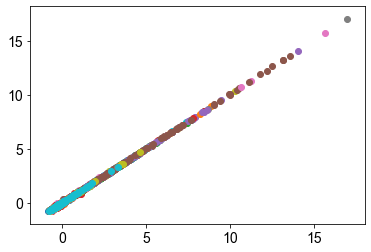

In [89]:
for i in range(50):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [92]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=50#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572356871900311
0.997514442190101
0.0010721778046549899 0.007446737378860348
9.294770809126708 376.0
encoder_layer_sizes [227, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.2950, -0.1876, -0.2741,  ..., -0.2335, -0.2188, -0.2672],
        [-0.3592,  0.3017,  0.0083,  ..., -0.2025, -0.2188,  0.0087],
        [-0.2640,  2.2946, -0.1050,  ..., -0.1589, -0.1807, -0.2565],
        ...,
        [ 0.2983, -0.1131,  0.0483,  ...,  0.4374,  0.4715, -0.2650],
        [-0.2073, -0.1840, -0.2741,  ..., -0.0203, -0.0214, -0.2644],
        [-0.0295, -0.1781, -0.2741,  ..., -0.1997, -0.2141, -0.2674]],
       dtype=torch.float64)
1 iteration
177.56768798828125
2 iteration
171.78082275390625
3 iteration
159.7906036376953
4 iteration
155.38890075683594
5 iteration
150.6853485107422
6 iteration
147.71139526367188
7 iteration
143.83062744140625
8 iteration
142.15322875976562
9 iteration
139.62191772460938
10 iteration
135.08621215820312
11 iteration
133.

3.465897560119629
257 iteration
3.4127259254455566
258 iteration
3.409773349761963
259 iteration
3.403597116470337
260 iteration
3.393577814102173
261 iteration
3.3842878341674805
262 iteration
3.377262830734253
263 iteration
3.3458364009857178
264 iteration
3.3444406986236572
265 iteration
3.290278911590576
266 iteration
3.324779748916626
267 iteration
3.3085684776306152
268 iteration
3.260721445083618
269 iteration
3.291919469833374
270 iteration
3.2742061614990234
271 iteration
3.2793893814086914
272 iteration
3.221780300140381
273 iteration
3.2520883083343506
274 iteration
3.2418406009674072
275 iteration
3.209890365600586
276 iteration
3.196364402770996
277 iteration
3.188948631286621
278 iteration
3.1872451305389404
279 iteration
3.1959879398345947
280 iteration
3.155520439147949
281 iteration
3.1654727458953857
282 iteration
3.1489429473876953
283 iteration
3.111398696899414
284 iteration
3.1052770614624023
285 iteration
3.12176513671875
286 iteration
3.1202704906463623
287 iter

1.6402767896652222
518 iteration
1.6837178468704224
519 iteration
1.6299009323120117
520 iteration
1.6154513359069824
521 iteration
1.632627010345459
522 iteration
1.5940043926239014
523 iteration
1.6368658542633057
524 iteration
1.6102677583694458
525 iteration
1.6193710565567017
526 iteration
1.6524620056152344
527 iteration
1.6852186918258667
528 iteration
1.6960214376449585
529 iteration
1.8428311347961426
530 iteration
1.9531222581863403
531 iteration
1.786504864692688
532 iteration
1.6713792085647583
533 iteration
1.7628979682922363
534 iteration
1.7972095012664795
535 iteration
1.5873193740844727
536 iteration
1.6470304727554321
537 iteration
1.6592129468917847
538 iteration
1.6389412879943848
539 iteration
1.539727807044983
540 iteration
1.5947896242141724
541 iteration
1.6262518167495728
542 iteration
1.564916729927063
543 iteration
1.5556704998016357
544 iteration
1.5323525667190552
545 iteration
1.5085837841033936
546 iteration
1.5571578741073608
547 iteration
1.591579437255

0.7297925353050232
777 iteration
0.7479031085968018
778 iteration
0.6981481909751892
779 iteration
0.6939787864685059
780 iteration
0.6971874833106995
781 iteration
0.6734897494316101
782 iteration
0.6388161182403564
783 iteration
0.6696856021881104
784 iteration
0.6621190905570984
785 iteration
0.6701169610023499
786 iteration
0.6936088800430298
787 iteration
0.681748628616333
788 iteration
0.7281444668769836
789 iteration
0.7374497056007385
790 iteration
0.7659298181533813
791 iteration
0.8022889494895935
792 iteration
0.8107010722160339
793 iteration
0.8350469470024109
794 iteration
0.7979288697242737
795 iteration
0.758486807346344
796 iteration
0.7916504144668579
797 iteration
0.7540196180343628
798 iteration
0.764029324054718
799 iteration
0.7399937510490417
800 iteration
0.755266547203064
801 iteration
0.7572479844093323
802 iteration
0.6947273015975952
803 iteration
0.7084205150604248
804 iteration
0.7396724820137024
805 iteration
0.6676810383796692
806 iteration
0.694184899330

0.4288385510444641
1036 iteration
0.38880592584609985
1037 iteration
0.4204785227775574
1038 iteration
0.4175260066986084
1039 iteration
0.3802863657474518
1040 iteration
0.42448127269744873
1041 iteration
0.41701847314834595
1042 iteration
0.3980177044868469
1043 iteration
0.4133000075817108
1044 iteration
0.4132874011993408
1045 iteration
0.3893479108810425
1046 iteration
0.38379043340682983
1047 iteration
0.3896730840206146
1048 iteration
0.38618606328964233
1049 iteration
0.3886820077896118
1050 iteration
0.3915592133998871
1051 iteration
0.37622392177581787
1052 iteration
0.3957594335079193
1053 iteration
0.39074990153312683
1054 iteration
0.4034179747104645
1055 iteration
0.37842243909835815
1056 iteration
0.40902966260910034
1057 iteration
0.4134025573730469
1058 iteration
0.3989303708076477
1059 iteration
0.3957594335079193
1060 iteration
0.41120094060897827
1061 iteration
0.3833191990852356
1062 iteration
0.37495529651641846
1063 iteration
0.40014761686325073
1064 iteration
0.

KeyboardInterrupt: 

In [95]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=100#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[150], decoder_layer_sizes=[90], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572433155598318
0.99751470519456
0.0010721778033416177 0.007446737378860348
9.576682831209395 376.0
encoder_layer_sizes [227, 150]
decoder_layer_sizes [90]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[ 0.5841, -0.1885, -0.2741,  ..., -0.2335, -0.2188, -0.2695],
        [-0.3592, -0.1875, -0.2741,  ..., -0.2307, -0.2188, -0.2417],
        [-0.3208,  0.4195, -0.2720,  ..., -0.1550, -0.2161, -0.2520],
        ...,
        [-0.2542, -0.1885,  1.5065,  ..., -0.1921, -0.0900, -0.2680],
        [-0.0186, -0.1872, -0.0951,  ...,  0.0346,  0.7122, -0.2698],
        [-0.1890, -0.1885, -0.2739,  ..., -0.2144, -0.1552, -0.2698]],
       dtype=torch.float64)
1 iteration
277.1260986328125
2 iteration
257.152099609375
3 iteration
249.2100372314453
4 iteration
237.68211364746094
5 iteration
230.82350158691406
6 iteration
216.12905883789062
7 iteration
200.07232666015625
8 iteration
184.86985778808594
9 iteration
171.99444580078125
10 iteration
172.1976776123047
11 iteration
149.9510

3.4254510402679443
257 iteration
3.432126522064209
258 iteration
3.402958631515503
259 iteration
3.3653953075408936
260 iteration
3.3336596488952637
261 iteration
3.354832649230957
262 iteration
3.339944839477539
263 iteration
3.3134689331054688
264 iteration
3.2927215099334717
265 iteration
3.2403392791748047
266 iteration
3.243485927581787
267 iteration
3.239567756652832
268 iteration
3.1774916648864746
269 iteration
3.2253992557525635
270 iteration
3.2035491466522217
271 iteration
3.1978724002838135
272 iteration
3.2670540809631348
273 iteration
3.2526979446411133
274 iteration
3.2050697803497314
275 iteration
3.277406930923462
276 iteration
3.1769814491271973
277 iteration
3.09078311920166
278 iteration
3.0959548950195312
279 iteration
3.067007064819336
280 iteration
3.018982172012329
281 iteration
3.018996477127075
282 iteration
3.0356409549713135
283 iteration
2.9926886558532715
284 iteration
2.9484572410583496
285 iteration
2.9803626537323
286 iteration
2.955442190170288
287 ite

1.145946979522705
514 iteration
1.1485832929611206
515 iteration
1.1283574104309082
516 iteration
1.1176834106445312
517 iteration
1.1200977563858032
518 iteration
1.1237800121307373
519 iteration
1.1271957159042358
520 iteration
1.1164814233779907
521 iteration
1.1044740676879883
522 iteration
1.10578453540802
523 iteration
1.1152715682983398
524 iteration
1.1112029552459717
525 iteration
1.085970401763916
526 iteration
1.104339361190796
527 iteration
1.1084067821502686
528 iteration
1.0884716510772705
529 iteration
1.0950597524642944
530 iteration
1.089321255683899
531 iteration
1.0765353441238403
532 iteration
1.078704833984375
533 iteration
1.0561941862106323
534 iteration
1.0774126052856445
535 iteration
1.0704058408737183
536 iteration
1.0766839981079102
537 iteration
1.0938986539840698
538 iteration
1.0738929510116577
539 iteration
1.079744577407837
540 iteration
1.0763455629348755
541 iteration
1.06168532371521
542 iteration
1.0505578517913818
543 iteration
1.0640486478805542
5

0.6631265878677368
771 iteration
0.6753312945365906
772 iteration
0.6747971177101135
773 iteration
0.6738894581794739
774 iteration
0.6535793542861938
775 iteration
0.6669723391532898
776 iteration
0.6731744408607483
777 iteration
0.6678048968315125
778 iteration
0.6546949744224548
779 iteration
0.6668117046356201
780 iteration
0.6658694744110107
781 iteration
0.6467728614807129
782 iteration
0.6514236330986023
783 iteration
0.6651484966278076
784 iteration
0.6531835794448853
785 iteration
0.6511515974998474
786 iteration
0.6511781215667725
787 iteration
0.659237802028656
788 iteration
0.6523600816726685
789 iteration
0.6571977734565735
790 iteration
0.6619220972061157
791 iteration
0.6650875210762024
792 iteration
0.6621593236923218
793 iteration
0.6646618843078613
794 iteration
0.6605944633483887
795 iteration
0.6506521701812744
796 iteration
0.6355807781219482
797 iteration
0.6484529376029968
798 iteration
0.6720054745674133
799 iteration
0.68247389793396
800 iteration
0.64033842086

0.4881835877895355
1024 iteration
0.5028672218322754
1025 iteration
0.5159304738044739
1026 iteration
0.5094364285469055
1027 iteration
0.5175470113754272
1028 iteration
0.4902457296848297
1029 iteration
0.47726792097091675
1030 iteration
0.478596955537796
1031 iteration
0.4988767206668854
1032 iteration
0.519712507724762
1033 iteration
0.48706045746803284
1034 iteration
0.4729626178741455
1035 iteration
0.47164836525917053
1036 iteration
0.482481449842453
1037 iteration
0.4866120517253876
1038 iteration
0.4948943257331848
1039 iteration
0.47995972633361816
1040 iteration
0.4730662405490875
1041 iteration
0.476689875125885
1042 iteration
0.4769371449947357
1043 iteration
0.4963253140449524
1044 iteration
0.5017310380935669
1045 iteration
0.47754189372062683
1046 iteration
0.4654657244682312
1047 iteration
0.4838668406009674
1048 iteration
0.5102481842041016
1049 iteration
0.5130993127822876
1050 iteration
0.5093157291412354
1051 iteration
0.49908578395843506
1052 iteration
0.4945193231

0.3994846045970917
1279 iteration
0.41018685698509216
1280 iteration
0.3850674331188202
1281 iteration
0.3661136329174042
1282 iteration
0.37234100699424744
1283 iteration
0.3796641528606415
1284 iteration
0.3877258598804474
1285 iteration
0.4069939851760864
1286 iteration
0.3911481201648712
1287 iteration
0.3876516819000244
1288 iteration
0.3956080973148346
1289 iteration
0.3740016520023346
1290 iteration
0.38212212920188904
1291 iteration
0.3800569772720337
1292 iteration
0.3865503966808319
1293 iteration
0.3770175278186798
1294 iteration
0.3711741268634796
1295 iteration
0.3834100365638733
1296 iteration
0.3813420236110687
1297 iteration
0.36975982785224915
1298 iteration
0.3858843147754669
1299 iteration
0.40510642528533936
1300 iteration
0.38450613617897034
1301 iteration
0.388955682516098
1302 iteration
0.3882523477077484
1303 iteration
0.3892311751842499
1304 iteration
0.3801655173301697
1305 iteration
0.38762909173965454
1306 iteration
0.37045037746429443
1307 iteration
0.37464

KeyboardInterrupt: 

In [96]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=100#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[150], decoder_layer_sizes=[90], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.857236793259781
0.9975151082819206
0.0010721778033616347 0.007446737378860348
9.502745910253507 376.0
encoder_layer_sizes [227, 150]
decoder_layer_sizes [90]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.2797, -0.1885, -0.2741,  ..., -0.2335, -0.2188, -0.2558],
        [-0.3196, -0.1718, -0.2741,  ..., -0.1599, -0.1584, -0.2295],
        [-0.1578, -0.1885, -0.2741,  ..., -0.1923, -0.2188, -0.2683],
        ...,
        [ 0.0124, -0.1459,  0.0384,  ...,  1.5280,  1.0769, -0.2686],
        [ 0.1424, -0.1852, -0.2526,  ...,  0.2990,  0.5382, -0.2697],
        [-0.3267, -0.1881, -0.2647,  ..., -0.2240, -0.2164, -0.2658]],
       dtype=torch.float64)
1 iteration
275.6121826171875
2 iteration
259.5240173339844
3 iteration
248.58229064941406
4 iteration
239.59197998046875
5 iteration
230.51971435546875
6 iteration
219.96554565429688
7 iteration
210.6575927734375
8 iteration
197.29122924804688
9 iteration
186.66900634765625
10 iteration
177.47894287109375
11 iteration
170.4

10.626880645751953
240 iteration
10.664667129516602
241 iteration
10.690102577209473
242 iteration
10.718199729919434
243 iteration
10.699180603027344
244 iteration
10.498626708984375
245 iteration
10.395323753356934
246 iteration
10.351536750793457
247 iteration
10.365594863891602
248 iteration
10.376130104064941
249 iteration
10.358684539794922
250 iteration
10.197572708129883
251 iteration
10.128625869750977
252 iteration
10.094067573547363
253 iteration
10.034806251525879
254 iteration
10.021466255187988
255 iteration
9.951677322387695
256 iteration
9.88681697845459
257 iteration
9.853527069091797
258 iteration
9.830747604370117
259 iteration
9.801931381225586
260 iteration
9.752270698547363
261 iteration
9.661174774169922
262 iteration
9.598860740661621
263 iteration
9.579754829406738
264 iteration
9.561464309692383
265 iteration
9.5452299118042
266 iteration
9.463273048400879
267 iteration
9.445901870727539
268 iteration
9.396072387695312
269 iteration
9.376401901245117
270 itera

5.725498676300049
500 iteration
5.68459415435791
501 iteration
5.651979446411133
502 iteration
5.618031024932861
503 iteration
5.615808010101318
504 iteration
5.6875128746032715
505 iteration
5.677508354187012
506 iteration
5.660906791687012
507 iteration
5.638096809387207
508 iteration
5.573774337768555
509 iteration
5.538883686065674
510 iteration
5.522858142852783
511 iteration
5.542550086975098
512 iteration
5.553670883178711
513 iteration
5.533534049987793
514 iteration
5.486591339111328
515 iteration
5.486795425415039
516 iteration
5.449887752532959
517 iteration
5.4299845695495605
518 iteration
5.438070774078369
519 iteration
5.438796520233154
520 iteration
5.450080394744873
521 iteration
5.4588494300842285
522 iteration
5.477247714996338
523 iteration
5.50533390045166
524 iteration
5.460395336151123
525 iteration
5.432028293609619
526 iteration
5.416182041168213
527 iteration
5.392889499664307
528 iteration
5.408128261566162
529 iteration
5.3784098625183105
530 iteration
5.4200

4.748276233673096
760 iteration
4.699990749359131
761 iteration
4.704785346984863
762 iteration
4.726134777069092
763 iteration
4.65129280090332
764 iteration
4.6121602058410645
765 iteration
4.585686206817627
766 iteration
4.546969890594482
767 iteration
4.566929340362549
768 iteration
4.537052631378174
769 iteration
4.53688907623291
770 iteration
4.570416450500488
771 iteration
4.531106472015381
772 iteration
4.490732192993164
773 iteration
4.470952987670898
774 iteration
4.489160060882568
775 iteration
4.482211112976074
776 iteration
4.461282253265381
777 iteration
4.44137716293335
778 iteration
4.403584957122803
779 iteration
4.419865608215332
780 iteration
4.422991752624512
781 iteration
4.4287519454956055
782 iteration
4.429987907409668
783 iteration
4.399040699005127
784 iteration
4.393406867980957
785 iteration
4.38425874710083
786 iteration
4.395183086395264
787 iteration
4.410195827484131
788 iteration
4.423612117767334
789 iteration
4.429619312286377
790 iteration
4.42919111

3.9526660442352295
1033 iteration
3.9516210556030273
1034 iteration
3.9630215167999268
1035 iteration
3.9770641326904297
1036 iteration
3.9946913719177246
1037 iteration
3.9887893199920654
1038 iteration
3.982250928878784
1039 iteration
3.9726128578186035
1040 iteration
3.9800591468811035
1041 iteration
3.985455274581909
1042 iteration
3.9716362953186035
1043 iteration
3.962801456451416
1044 iteration
3.9726171493530273
1045 iteration
4.005472183227539
1046 iteration
4.024038791656494
1047 iteration
4.031839370727539
1048 iteration
4.067434310913086
1049 iteration
4.066990375518799
1050 iteration
4.0401930809021
1051 iteration
4.035489082336426
1052 iteration
4.037900924682617
1053 iteration
4.005251884460449
1054 iteration
3.9866721630096436
1055 iteration
3.973475456237793
1056 iteration
3.9837656021118164
1057 iteration
3.9745309352874756
1058 iteration
3.9764719009399414
1059 iteration
3.9966013431549072
1060 iteration
4.039731979370117
1061 iteration
4.067133903503418
1062 iterati

3.7633209228515625
1296 iteration
3.7498364448547363
1297 iteration
3.747751235961914
1298 iteration
3.7667412757873535
1299 iteration
3.7804062366485596
1300 iteration
3.7674875259399414
1301 iteration
3.745715856552124
1302 iteration
3.7287464141845703
1303 iteration
3.7306103706359863
1304 iteration
3.755006790161133
1305 iteration
3.738821506500244
1306 iteration
3.7317960262298584
1307 iteration
3.728550434112549
1308 iteration
3.720513343811035
1309 iteration
3.6902849674224854
1310 iteration
3.683281660079956
1311 iteration
3.6827774047851562
1312 iteration
3.6855297088623047
1313 iteration
3.6880979537963867
1314 iteration
3.6805248260498047
1315 iteration
3.677297592163086
1316 iteration
3.6736602783203125
1317 iteration
3.6790382862091064
1318 iteration
3.696004867553711
1319 iteration
3.6945135593414307
1320 iteration
3.702253818511963
1321 iteration
3.704129219055176
1322 iteration
3.712735891342163
1323 iteration
3.751490592956543
1324 iteration
3.7991628646850586
1325 ite

3.5175740718841553
1553 iteration
3.5233829021453857
1554 iteration
3.519968032836914
1555 iteration
3.5186092853546143
1556 iteration
3.5261526107788086
1557 iteration
3.524460792541504
1558 iteration
3.535583257675171
1559 iteration
3.5410311222076416
1560 iteration
3.545182466506958
1561 iteration
3.56498384475708
1562 iteration
3.5938076972961426
1563 iteration
3.6065590381622314
1564 iteration
3.6060290336608887
1565 iteration
3.5973639488220215
1566 iteration
3.5939719676971436
1567 iteration
3.567967414855957
1568 iteration
3.5540049076080322
1569 iteration
3.5439510345458984
1570 iteration
3.5793206691741943
1571 iteration
3.6482303142547607
1572 iteration
3.686192035675049
1573 iteration
3.719179391860962
1574 iteration
3.7413320541381836
1575 iteration
3.8023717403411865
1576 iteration
3.9785315990448
1577 iteration
4.110288143157959
1578 iteration
4.034172534942627
1579 iteration
3.929607629776001
1580 iteration
3.8517258167266846
1581 iteration
3.862931251525879
1582 iterat

3.5364949703216553
1810 iteration
3.514737606048584
1811 iteration
3.5103421211242676
1812 iteration
3.5158441066741943
1813 iteration
3.504415273666382
1814 iteration
3.517625331878662
1815 iteration
3.51068115234375
1816 iteration
3.495889186859131
1817 iteration
3.4962575435638428
1818 iteration
3.5209832191467285
1819 iteration
3.5388906002044678
1820 iteration
3.548593044281006
1821 iteration
3.5531017780303955
1822 iteration
3.543057441711426
1823 iteration
3.543170213699341
1824 iteration
3.531996965408325
1825 iteration
3.518932580947876
1826 iteration
3.503842830657959
1827 iteration
3.4730658531188965
1828 iteration
3.4364571571350098
1829 iteration
3.4180994033813477
1830 iteration
3.4473581314086914
1831 iteration
3.44944429397583
1832 iteration
3.445895195007324
1833 iteration
3.4658889770507812
1834 iteration
3.450942277908325
1835 iteration
3.4674994945526123
1836 iteration
3.454986810684204
1837 iteration
3.472334623336792
1838 iteration
3.4843311309814453
1839 iteratio

3.32806396484375
2068 iteration
3.3476879596710205
2069 iteration
3.356370210647583
2070 iteration
3.3423261642456055
2071 iteration
3.3427093029022217
2072 iteration
3.3504133224487305
2073 iteration
3.3570897579193115
2074 iteration
3.331634759902954
2075 iteration
3.3240609169006348
2076 iteration
3.3198769092559814
2077 iteration
3.3169612884521484
2078 iteration
3.3181612491607666
2079 iteration
3.3257880210876465
2080 iteration
3.3214762210845947
2081 iteration
3.3180861473083496
2082 iteration
3.3192970752716064
2083 iteration
3.3152267932891846
2084 iteration
3.3277227878570557
2085 iteration
3.3591148853302
2086 iteration
3.391772508621216
2087 iteration
3.4511170387268066
2088 iteration
3.519406795501709
2089 iteration
3.5778329372406006
2090 iteration
3.6284706592559814
2091 iteration
3.6295840740203857
2092 iteration
3.553861141204834
2093 iteration
3.448547124862671
2094 iteration
3.369194746017456
2095 iteration
3.35652494430542
2096 iteration
3.383236885070801
2097 itera

3.2545387744903564
2328 iteration
3.2395272254943848
2329 iteration
3.236703872680664
2330 iteration
3.243725538253784
2331 iteration
3.2517306804656982
2332 iteration
3.2487378120422363
2333 iteration
3.231570243835449
2334 iteration
3.241039991378784
2335 iteration
3.2582521438598633
2336 iteration
3.280327081680298
2337 iteration
3.290243625640869
2338 iteration
3.2930245399475098
2339 iteration
3.2916274070739746
2340 iteration
3.285432815551758
2341 iteration
3.2667126655578613
2342 iteration
3.2810757160186768
2343 iteration
3.2702219486236572
2344 iteration
3.2644715309143066
2345 iteration
3.2679800987243652
2346 iteration
3.2787210941314697
2347 iteration
3.3022332191467285
2348 iteration
3.3126163482666016
2349 iteration
3.3310883045196533
2350 iteration
3.3622655868530273
2351 iteration
3.406179189682007
2352 iteration
3.428293228149414
2353 iteration
3.4346649646759033
2354 iteration
3.422564744949341
2355 iteration
3.423150062561035
2356 iteration
3.412559747695923
2357 it

3.2527060508728027
2580 iteration
3.2442078590393066
2581 iteration
3.222724199295044
2582 iteration
3.223787784576416
2583 iteration
3.240088701248169
2584 iteration
3.3137056827545166
2585 iteration
3.3529045581817627
2586 iteration
3.3511862754821777
2587 iteration
3.353494167327881
2588 iteration
3.3558220863342285
2589 iteration
3.3580868244171143
2590 iteration
3.3588995933532715
2591 iteration
3.35092830657959
2592 iteration
3.3100461959838867
2593 iteration
3.2561373710632324
2594 iteration
3.2246766090393066
2595 iteration
3.189784049987793
2596 iteration
3.170154094696045
2597 iteration
3.1852729320526123
2598 iteration
3.1960415840148926
2599 iteration
3.2056467533111572
2600 iteration
3.2172155380249023
2601 iteration
3.204718589782715
2602 iteration
3.1841931343078613
2603 iteration
3.181306838989258
2604 iteration
3.1660115718841553
2605 iteration
3.167863368988037
2606 iteration
3.168407678604126
2607 iteration
3.1630640029907227
2608 iteration
3.1616132259368896
2609 it

3.172032356262207
2837 iteration
3.2008893489837646
2838 iteration
3.2432634830474854
2839 iteration
3.267080307006836
2840 iteration
3.3034780025482178
2841 iteration
3.2896804809570312
2842 iteration
3.2269277572631836
2843 iteration
3.1797194480895996
2844 iteration
3.137361764907837
2845 iteration
3.1375648975372314
2846 iteration
3.17935848236084
2847 iteration
3.2209572792053223
2848 iteration
3.196333885192871
2849 iteration
3.1684093475341797
2850 iteration
3.1966066360473633
2851 iteration
3.2071127891540527
2852 iteration
3.193812370300293
2853 iteration
3.1634042263031006
2854 iteration
3.1259560585021973
2855 iteration
3.1242969036102295
2856 iteration
3.1302475929260254
2857 iteration
3.157644033432007
2858 iteration
3.1878528594970703
2859 iteration
3.2146806716918945
2860 iteration
3.2051382064819336
2861 iteration
3.2756824493408203
2862 iteration
3.2974486351013184
2863 iteration
3.3396596908569336
2864 iteration
3.3421969413757324
2865 iteration
3.3058841228485107
286

3.115060806274414
3095 iteration
3.0785555839538574
3096 iteration
3.0623767375946045
3097 iteration
3.057204246520996
3098 iteration
3.0550320148468018
3099 iteration
3.046022653579712
3100 iteration
3.0677688121795654
3101 iteration
3.0640106201171875
3102 iteration
3.055910348892212
3103 iteration
3.053330898284912
3104 iteration
3.0365374088287354
3105 iteration
3.035595178604126
3106 iteration
3.0423288345336914
3107 iteration
3.043644428253174
3108 iteration
3.0450735092163086
3109 iteration
3.0485622882843018
3110 iteration
3.0527350902557373
3111 iteration
3.0608227252960205
3112 iteration
3.0788607597351074
3113 iteration
3.102958917617798
3114 iteration
3.1181838512420654
3115 iteration
3.107357978820801
3116 iteration
3.0758469104766846
3117 iteration
3.0563127994537354
3118 iteration
3.0655736923217773
3119 iteration
3.0670533180236816
3120 iteration
3.0684714317321777
3121 iteration
3.0630500316619873
3122 iteration
3.0574686527252197
3123 iteration
3.058023691177368
3124 

3.1031625270843506
3356 iteration
3.0907468795776367
3357 iteration
3.08597469329834
3358 iteration
3.092313528060913
3359 iteration
3.068551540374756
3360 iteration
3.038327932357788
3361 iteration
3.030583143234253
3362 iteration
3.035090923309326
3363 iteration
3.0399365425109863
3364 iteration
3.043555498123169
3365 iteration
3.0210366249084473
3366 iteration
3.0193212032318115
3367 iteration
3.0277183055877686
3368 iteration
3.0336923599243164
3369 iteration
3.0319204330444336
3370 iteration
3.0359768867492676
3371 iteration
3.0350756645202637
3372 iteration
3.0632331371307373
3373 iteration
3.0828843116760254
3374 iteration
3.0572891235351562
3375 iteration
3.0450081825256348
3376 iteration
3.078770399093628
3377 iteration
3.0617780685424805
3378 iteration
3.0760302543640137
3379 iteration
3.061309576034546
3380 iteration
3.045058012008667
3381 iteration
3.040534734725952
3382 iteration
3.039851188659668
3383 iteration
3.0184638500213623
3384 iteration
3.015455961227417
3385 iter

2.9815762042999268
3615 iteration
3.0132994651794434
3616 iteration
3.0226171016693115
3617 iteration
3.015598773956299
3618 iteration
3.0086288452148438
3619 iteration
2.9872331619262695
3620 iteration
2.9727728366851807
3621 iteration
2.93955659866333
3622 iteration
2.9351706504821777
3623 iteration
2.9487624168395996
3624 iteration
2.939673662185669
3625 iteration
2.934316635131836
3626 iteration
2.9259777069091797
3627 iteration
2.9288551807403564
3628 iteration
2.921285390853882
3629 iteration
2.9248528480529785
3630 iteration
2.9350059032440186
3631 iteration
2.966212511062622
3632 iteration
2.993483781814575
3633 iteration
3.0258736610412598
3634 iteration
3.013575553894043
3635 iteration
3.0161550045013428
3636 iteration
3.007171392440796
3637 iteration
2.9930057525634766
3638 iteration
2.9825692176818848
3639 iteration
2.966257095336914
3640 iteration
2.9693779945373535
3641 iteration
2.988111972808838
3642 iteration
3.012005090713501
3643 iteration
3.023275375366211
3644 iter

KeyboardInterrupt: 

In [98]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=200#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[180], decoder_layer_sizes=[130], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572390162492977
0.9975144725704381
0.0010721778042786228 0.007446737378860348
9.354784262997352 376.0
encoder_layer_sizes [227, 180]
decoder_layer_sizes [130]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.3160,  0.0578,  5.4428,  ..., -0.2259, -0.1849,  2.7159],
        [-0.3441, -0.0980, -0.1462,  ..., -0.2263, -0.0203,  0.0899],
        [-0.3356, -0.1885, -0.2737,  ..., -0.2335, -0.2188, -0.2679],
        ...,
        [ 0.0726, -0.1822, -0.2739,  ..., -0.0568, -0.2132, -0.2560],
        [-0.3527,  2.0704, -0.2741,  ..., -0.2335, -0.2188, -0.2394],
        [-0.3035, -0.1565, -0.2550,  ..., -0.2320, -0.2188,  6.7116]],
       dtype=torch.float64)
1 iteration
248.67848205566406
2 iteration
230.81996154785156
3 iteration
224.82347106933594
4 iteration
218.5746612548828
5 iteration
211.6781768798828
6 iteration
211.9226531982422
7 iteration
197.8099365234375
8 iteration
191.98660278320312
9 iteration
182.18719482421875
10 iteration
173.76283264160156
11 iteration
166.

6.894388198852539
239 iteration
6.820478439331055
240 iteration
6.774835109710693
241 iteration
6.757321834564209
242 iteration
6.7794108390808105
243 iteration
6.722777843475342
244 iteration
6.696323871612549
245 iteration
6.658055305480957
246 iteration
6.622381687164307
247 iteration
6.595380783081055
248 iteration
6.570979595184326
249 iteration
6.537839889526367
250 iteration
6.479910850524902
251 iteration
6.4567551612854
252 iteration
6.420412063598633
253 iteration
6.390736103057861
254 iteration
6.3617777824401855
255 iteration
6.3849568367004395
256 iteration
6.400157928466797
257 iteration
6.468950271606445
258 iteration
6.5713958740234375
259 iteration
6.643918514251709
260 iteration
6.578704833984375
261 iteration
6.3759541511535645
262 iteration
6.247188091278076
263 iteration
6.253712177276611
264 iteration
6.279218673706055
265 iteration
6.280930995941162
266 iteration
6.2167840003967285
267 iteration
6.119713306427002
268 iteration
6.130008697509766
269 iteration
6.14

3.5248477458953857
495 iteration
3.4704535007476807
496 iteration
3.4329373836517334
497 iteration
3.431490898132324
498 iteration
3.406602144241333
499 iteration
3.3864545822143555
500 iteration
3.3860366344451904
501 iteration
3.408764362335205
502 iteration
3.382049798965454
503 iteration
3.3677666187286377
504 iteration
3.390986442565918
505 iteration
3.4059088230133057
506 iteration
3.389129400253296
507 iteration
3.3899734020233154
508 iteration
3.3606185913085938
509 iteration
3.3248817920684814
510 iteration
3.2991373538970947
511 iteration
3.3139617443084717
512 iteration
3.345486640930176
513 iteration
3.322422981262207
514 iteration
3.268195867538452
515 iteration
3.294339895248413
516 iteration
3.297617197036743
517 iteration
3.2996819019317627
518 iteration
3.3473377227783203
519 iteration
3.446169376373291
520 iteration
3.6146111488342285
521 iteration
3.6841485500335693
522 iteration
3.5703935623168945
523 iteration
3.485816717147827
524 iteration
3.4641997814178467
525 

2.674518346786499
752 iteration
2.6426236629486084
753 iteration
2.5654714107513428
754 iteration
2.4910264015197754
755 iteration
2.4679408073425293
756 iteration
2.4722096920013428
757 iteration
2.492149591445923
758 iteration
2.494264602661133
759 iteration
2.5050644874572754
760 iteration
2.449514389038086
761 iteration
2.389724016189575
762 iteration
2.3589999675750732
763 iteration
2.400350570678711
764 iteration
2.4476752281188965
765 iteration
2.457137107849121
766 iteration
2.4328360557556152
767 iteration
2.402639627456665
768 iteration
2.3781652450561523
769 iteration
2.371011972427368
770 iteration
2.351344108581543
771 iteration
2.348271131515503
772 iteration
2.3783183097839355
773 iteration
2.3708608150482178
774 iteration
2.3744683265686035
775 iteration
2.3741703033447266
776 iteration
2.358654260635376
777 iteration
2.357093572616577
778 iteration
2.400641679763794
779 iteration
2.399705410003662
780 iteration
2.3920490741729736
781 iteration
2.3806211948394775
782 it

1.8679096698760986
1009 iteration
1.88535475730896
1010 iteration
1.9331772327423096
1011 iteration
1.9669870138168335
1012 iteration
1.9791803359985352
1013 iteration
2.0378236770629883
1014 iteration
2.128077983856201
1015 iteration
2.252488613128662
1016 iteration
2.354020118713379
1017 iteration
2.452979326248169
1018 iteration
2.3258795738220215
1019 iteration
2.1907358169555664
1020 iteration
2.1713953018188477
1021 iteration
2.145547389984131
1022 iteration
2.2032158374786377
1023 iteration
2.2087104320526123
1024 iteration
2.214625358581543
1025 iteration
2.234771966934204
1026 iteration
2.124358892440796
1027 iteration
2.1288013458251953
1028 iteration
2.0844953060150146
1029 iteration
2.0331151485443115
1030 iteration
2.0075013637542725
1031 iteration
1.9826343059539795
1032 iteration
1.9926992654800415
1033 iteration
2.057194471359253
1034 iteration
2.0693938732147217
1035 iteration
1.9918148517608643
1036 iteration
1.9536850452423096
1037 iteration
1.9219492673873901
1038 i

1.6062923669815063
1267 iteration
1.6110105514526367
1268 iteration
1.611746072769165
1269 iteration
1.6046849489212036
1270 iteration
1.6341041326522827
1271 iteration
1.7389466762542725
1272 iteration
1.9445675611495972
1273 iteration
2.1771981716156006
1274 iteration
2.415294647216797
1275 iteration
2.490368366241455
1276 iteration
2.254599094390869
1277 iteration
1.994430661201477
1278 iteration
1.8705499172210693
1279 iteration
1.8907806873321533
1280 iteration
1.9197700023651123
1281 iteration
1.8729257583618164
1282 iteration
1.8209811449050903
1283 iteration
1.7713924646377563
1284 iteration
1.7406105995178223
1285 iteration
1.7401740550994873
1286 iteration
1.7275323867797852
1287 iteration
1.7214126586914062
1288 iteration
1.6889320611953735
1289 iteration
1.6799099445343018
1290 iteration
1.6799260377883911
1291 iteration
1.6661947965621948
1292 iteration
1.6170376539230347
1293 iteration
1.5762790441513062
1294 iteration
1.62284255027771
1295 iteration
1.5916210412979126
12

1.4098891019821167
1510 iteration
1.3830211162567139
1511 iteration
1.3378021717071533
1512 iteration
1.3542460203170776
1513 iteration
1.3590561151504517
1514 iteration
1.3748762607574463
1515 iteration
1.3846594095230103
1516 iteration
1.3834795951843262
1517 iteration
1.404913067817688
1518 iteration
1.4233165979385376
1519 iteration
1.468904733657837
1520 iteration
1.45784592628479
1521 iteration
1.49497389793396
1522 iteration
1.478273630142212
1523 iteration
1.5191740989685059
1524 iteration
1.5225608348846436
1525 iteration
1.4932923316955566
1526 iteration
1.4255555868148804
1527 iteration
1.341702938079834
1528 iteration
1.3127368688583374
1529 iteration
1.3257114887237549
1530 iteration
1.3862249851226807
1531 iteration
1.4596145153045654
1532 iteration
1.5111807584762573
1533 iteration
1.5066428184509277
1534 iteration
1.4799777269363403
1535 iteration
1.4650871753692627
1536 iteration
1.476131558418274
1537 iteration
1.5257627964019775
1538 iteration
1.597161889076233
1539 

1.495381474494934
1766 iteration
1.4235423803329468
1767 iteration
1.3648278713226318
1768 iteration
1.3820935487747192
1769 iteration
1.3783024549484253
1770 iteration
1.3894344568252563
1771 iteration
1.349509835243225
1772 iteration
1.3508524894714355
1773 iteration
1.338289499282837
1774 iteration
1.333708643913269
1775 iteration
1.364966630935669
1776 iteration
1.369252324104309
1777 iteration
1.4153012037277222
1778 iteration
1.4124995470046997
1779 iteration
1.3860152959823608
1780 iteration
1.3706797361373901
1781 iteration
1.3470911979675293
1782 iteration
1.2877153158187866
1783 iteration
1.2386832237243652
1784 iteration
1.2268918752670288
1785 iteration
1.2112414836883545
1786 iteration
1.1717835664749146
1787 iteration
1.1476365327835083
1788 iteration
1.1709246635437012
1789 iteration
1.19795823097229
1790 iteration
1.2207531929016113
1791 iteration
1.2148462533950806
1792 iteration
1.191255807876587
1793 iteration
1.1784991025924683
1794 iteration
1.1909785270690918
1795

1.094387173652649
2025 iteration
1.076889157295227
2026 iteration
1.1163957118988037
2027 iteration
1.1353455781936646
2028 iteration
1.1028475761413574
2029 iteration
1.052769660949707
2030 iteration
1.0421674251556396
2031 iteration
1.065809726715088
2032 iteration
1.115130066871643
2033 iteration
1.1355535984039307
2034 iteration
1.0666515827178955
2035 iteration
1.029801845550537
2036 iteration
1.0466737747192383
2037 iteration
1.0682088136672974
2038 iteration
1.0590386390686035
2039 iteration
1.0630208253860474
2040 iteration
1.0429749488830566
2041 iteration
1.0657405853271484
2042 iteration
1.0751409530639648
2043 iteration
1.08707857131958
2044 iteration
1.0927313566207886
2045 iteration
1.1048495769500732
2046 iteration
1.0758486986160278
2047 iteration
1.0499132871627808
2048 iteration
1.0147936344146729
2049 iteration
1.0069713592529297
2050 iteration
1.0188541412353516
2051 iteration
1.0373932123184204
2052 iteration
1.0746852159500122
2053 iteration
1.0744911432266235
205

1.16472589969635
2270 iteration
1.1063199043273926
2271 iteration
1.1104421615600586
2272 iteration
1.1101810932159424
2273 iteration
1.0868353843688965
2274 iteration
1.0808123350143433
2275 iteration
1.0719475746154785
2276 iteration
1.060495376586914
2277 iteration
1.0310349464416504
2278 iteration
1.0182536840438843
2279 iteration
1.0282073020935059
2280 iteration
0.9982296228408813
2281 iteration
0.998923122882843
2282 iteration
1.0027663707733154
2283 iteration
0.9978498220443726
2284 iteration
0.9809278845787048
2285 iteration
0.9794355034828186
2286 iteration
0.9581056237220764
2287 iteration
0.9545037150382996
2288 iteration
0.9603099822998047
2289 iteration
0.9542225003242493
2290 iteration
0.9588386416435242
2291 iteration
0.9388310313224792
2292 iteration
0.9272700548171997
2293 iteration
0.9301969408988953
2294 iteration
0.9328452348709106
2295 iteration
0.9359931349754333
2296 iteration
0.9275518655776978
2297 iteration
0.942483127117157
2298 iteration
0.974599301815033
2

0.9794832468032837
2526 iteration
0.9905418157577515
2527 iteration
0.9687919616699219
2528 iteration
0.9453178644180298
2529 iteration
0.9094436764717102
2530 iteration
0.9251253604888916
2531 iteration
0.9116984009742737
2532 iteration
0.8969333171844482
2533 iteration
0.8860950469970703
2534 iteration
0.8969678282737732
2535 iteration
0.9090071320533752
2536 iteration
0.9322558641433716
2537 iteration
0.9389801025390625
2538 iteration
0.9535775780677795
2539 iteration
0.9392114281654358
2540 iteration
0.8946571350097656
2541 iteration
0.9055342078208923
2542 iteration
0.8783746361732483
2543 iteration
0.8779808878898621
2544 iteration
0.8839108943939209
2545 iteration
0.8818719983100891
2546 iteration
0.8919726610183716
2547 iteration
0.8988205790519714
2548 iteration
0.8915743231773376
2549 iteration
0.8816782236099243
2550 iteration
0.88019859790802
2551 iteration
0.8897907137870789
2552 iteration
0.8846226334571838
2553 iteration
0.8808929920196533
2554 iteration
0.87914717197418

0.8880131244659424
2782 iteration
0.9321475028991699
2783 iteration
0.9616467952728271
2784 iteration
0.9840261340141296
2785 iteration
1.037974238395691
2786 iteration
1.0853081941604614
2787 iteration
1.1520758867263794
2788 iteration
1.2298176288604736
2789 iteration
1.2470451593399048
2790 iteration
1.201625943183899
2791 iteration
1.1404526233673096
2792 iteration
1.1083734035491943
2793 iteration
1.1147089004516602
2794 iteration
1.1502176523208618
2795 iteration
1.1118438243865967
2796 iteration
1.0678906440734863
2797 iteration
1.0085132122039795
2798 iteration
1.026178002357483
2799 iteration
1.040888786315918
2800 iteration
1.0319560766220093
2801 iteration
0.9863281846046448
2802 iteration
0.9430084228515625
2803 iteration
0.9259901642799377
2804 iteration
0.9576825499534607
2805 iteration
0.9820321798324585
2806 iteration
0.9745415449142456
2807 iteration
0.9572506546974182
2808 iteration
0.9467949867248535
2809 iteration
0.9225971102714539
2810 iteration
0.9049755930900574

0.8414876461029053
3038 iteration
0.8146523833274841
3039 iteration
0.8192378282546997
3040 iteration
0.8133447766304016
3041 iteration
0.8092089891433716
3042 iteration
0.7979494333267212
3043 iteration
0.7976107001304626
3044 iteration
0.7879816293716431
3045 iteration
0.7947534918785095
3046 iteration
0.7913366556167603
3047 iteration
0.7926866412162781
3048 iteration
0.7819451093673706
3049 iteration
0.7852668166160583
3050 iteration
0.7918409705162048
3051 iteration
0.8179027438163757
3052 iteration
0.854917049407959
3053 iteration
0.8828220963478088
3054 iteration
0.899810254573822
3055 iteration
0.935760498046875
3056 iteration
0.9565214514732361
3057 iteration
0.9554669857025146
3058 iteration
0.9382767677307129
3059 iteration
0.8935316205024719
3060 iteration
0.8545031547546387
3061 iteration
0.8662187457084656
3062 iteration
0.9044411182403564
3063 iteration
0.9588224291801453
3064 iteration
0.9750694036483765
3065 iteration
0.977495551109314
3066 iteration
0.9907163977622986

0.8428592085838318
3294 iteration
0.8242095708847046
3295 iteration
0.8086639642715454
3296 iteration
0.7858374118804932
3297 iteration
0.7772485613822937
3298 iteration
0.7789488434791565
3299 iteration
0.7939284443855286
3300 iteration
0.794648289680481
3301 iteration
0.794569194316864
3302 iteration
0.8111754655838013
3303 iteration
0.8252425193786621
3304 iteration
0.8218312859535217
3305 iteration
0.8267347812652588
3306 iteration
0.8198831677436829
3307 iteration
0.8103951811790466
3308 iteration
0.7821969389915466
3309 iteration
0.756553590297699
3310 iteration
0.7658381462097168
3311 iteration
0.7709099054336548
3312 iteration
0.7715322375297546
3313 iteration
0.7890281081199646
3314 iteration
0.7999931573867798
3315 iteration
0.7962254881858826
3316 iteration
0.8006845712661743
3317 iteration
0.7863600254058838
3318 iteration
0.773923933506012
3319 iteration
0.787335991859436
3320 iteration
0.7835922241210938
3321 iteration
0.8060762286186218
3322 iteration
0.8250820636749268


0.8623101711273193
3539 iteration
0.8348768353462219
3540 iteration
0.8074370622634888
3541 iteration
0.7841441631317139
3542 iteration
0.7641326189041138
3543 iteration
0.7484579682350159
3544 iteration
0.7572463750839233
3545 iteration
0.7686366438865662
3546 iteration
0.7797485589981079
3547 iteration
0.7844158411026001
3548 iteration
0.7976828217506409
3549 iteration
0.7892979979515076
3550 iteration
0.7813453078269958
3551 iteration
0.7671625018119812
3552 iteration
0.7420950531959534
3553 iteration
0.740882396697998
3554 iteration
0.7584512233734131
3555 iteration
0.7645632028579712
3556 iteration
0.7788650989532471
3557 iteration
0.7878949046134949
3558 iteration
0.8175572156906128
3559 iteration
0.8722541332244873
3560 iteration
0.9021257162094116
3561 iteration
0.9234310388565063
3562 iteration
0.9163276553153992
3563 iteration
0.8593071699142456
3564 iteration
0.8056768178939819
3565 iteration
0.7853865027427673
3566 iteration
0.7741764187812805
3567 iteration
0.8096064925193

0.8064786791801453
3795 iteration
0.7979996204376221
3796 iteration
0.8180201649665833
3797 iteration
0.8557850122451782
3798 iteration
0.8976144194602966
3799 iteration
0.9183353185653687
3800 iteration
0.9431806206703186
3801 iteration
0.966970682144165
3802 iteration
0.9645106792449951
3803 iteration
0.9599670171737671
3804 iteration
0.8981721997261047
3805 iteration
0.8465656042098999
3806 iteration
0.8095723986625671
3807 iteration
0.8266759514808655
3808 iteration
0.8824926614761353
3809 iteration
0.8989610075950623
3810 iteration
0.9027893543243408
3811 iteration
0.8593692779541016
3812 iteration
0.8261386156082153
3813 iteration
0.8201130628585815
3814 iteration
0.7865617871284485
3815 iteration
0.8081773519515991
3816 iteration
0.822243869304657
3817 iteration
0.8215343952178955
3818 iteration
0.8208516836166382
3819 iteration
0.7941306829452515
3820 iteration
0.8045727014541626
3821 iteration
0.7870531678199768
3822 iteration
0.7840928435325623
3823 iteration
0.79422873258590

0.7799723148345947
4052 iteration
0.784802258014679
4053 iteration
0.7883255481719971
4054 iteration
0.8160568475723267
4055 iteration
0.8577686548233032
4056 iteration
0.8826069831848145
4057 iteration
0.8948621153831482
4058 iteration
0.9024499654769897
4059 iteration
0.8834705948829651
4060 iteration
0.876315176486969
4061 iteration
0.8246481418609619
4062 iteration
0.7568328976631165
4063 iteration
0.7646090984344482
4064 iteration
0.7935646772384644
4065 iteration
0.8132634162902832
4066 iteration
0.8302993178367615
4067 iteration
0.8335031270980835
4068 iteration
0.7966428995132446
4069 iteration
0.760193943977356
4070 iteration
0.7626196146011353
4071 iteration
0.753734290599823
4072 iteration
0.7682235836982727
4073 iteration
0.7727603912353516
4074 iteration
0.777404248714447
4075 iteration
0.7753521203994751
4076 iteration
0.7667468190193176
4077 iteration
0.7693707942962646
4078 iteration
0.7935117483139038
4079 iteration
0.7871919274330139
4080 iteration
0.7824510335922241


0.821831226348877
4308 iteration
0.8817359209060669
4309 iteration
0.9040412306785583
4310 iteration
0.8771598935127258
4311 iteration
0.881203830242157
4312 iteration
0.9069240093231201
4313 iteration
0.8938667178153992
4314 iteration
0.8378431797027588
4315 iteration
0.7880074381828308
4316 iteration
0.7986490726470947
4317 iteration
0.8268069624900818
4318 iteration
0.8244091868400574
4319 iteration
0.8297456502914429
4320 iteration
0.8059550523757935
4321 iteration
0.7750609517097473
4322 iteration
0.7485591173171997
4323 iteration
0.742888331413269
4324 iteration
0.7196266651153564
4325 iteration
0.7187973260879517
4326 iteration
0.7282519340515137
4327 iteration
0.7234410047531128
4328 iteration
0.7152416706085205
4329 iteration
0.7173000574111938
4330 iteration
0.722037136554718
4331 iteration
0.7348597645759583
4332 iteration
0.7417126297950745
4333 iteration
0.7309074997901917
4334 iteration
0.7387837171554565
4335 iteration
0.7256755232810974
4336 iteration
0.70763099193573
4

0.7027416825294495
4564 iteration
0.6920618414878845
4565 iteration
0.7050381302833557
4566 iteration
0.7101887464523315
4567 iteration
0.7205635905265808
4568 iteration
0.6993299722671509
4569 iteration
0.6959688067436218
4570 iteration
0.6968643665313721
4571 iteration
0.7095798254013062
4572 iteration
0.723792314529419
4573 iteration
0.735384464263916
4574 iteration
0.7658004760742188
4575 iteration
0.7731077075004578
4576 iteration
0.794512152671814
4577 iteration
0.7993872165679932
4578 iteration
0.8012996912002563
4579 iteration
0.7951595187187195
4580 iteration
0.8101864457130432
4581 iteration
0.8676994442939758
4582 iteration
0.9127132892608643
4583 iteration
0.9570478200912476
4584 iteration
0.9027059674263
4585 iteration
0.8022947907447815
4586 iteration
0.7241165041923523
4587 iteration
0.7256333827972412
4588 iteration
0.7513904571533203
4589 iteration
0.7732254266738892
4590 iteration
0.7724083065986633
4591 iteration
0.7516820430755615
4592 iteration
0.7353447079658508
4

0.7332098484039307
4815 iteration
0.7224109172821045
4816 iteration
0.703722357749939
4817 iteration
0.7161865234375
4818 iteration
0.7236515879631042
4819 iteration
0.7377690672874451
4820 iteration
0.7414770722389221
4821 iteration
0.7401337623596191
4822 iteration
0.7311569452285767
4823 iteration
0.7227867245674133
4824 iteration
0.7014854550361633
4825 iteration
0.694187343120575
4826 iteration
0.7004492282867432
4827 iteration
0.7186813354492188
4828 iteration
0.7264372110366821
4829 iteration
0.7415236830711365
4830 iteration
0.7364420890808105
4831 iteration
0.7453089356422424
4832 iteration
0.7400177121162415
4833 iteration
0.7295515537261963
4834 iteration
0.7346915602684021
4835 iteration
0.7233712673187256
4836 iteration
0.7192431092262268
4837 iteration
0.7075334191322327
4838 iteration
0.7027685046195984
4839 iteration
0.6893230676651001
4840 iteration
0.6806381940841675
4841 iteration
0.6695055961608887
4842 iteration
0.6728174090385437
4843 iteration
0.6749191284179688


In [99]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=200#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572304502145107
0.9975148771170967
0.0010721778031399453 0.007446737378860348
9.450904535815893 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[ 1.2311, -0.1827, -0.0858,  ..., -0.0510, -0.2188, -0.1341],
        [-0.2599, -0.1584, -0.2540,  ..., -0.1863, -0.2188,  0.9165],
        [-0.3622, -0.1885, -0.2741,  ..., -0.2335, -0.2188, -0.2531],
        ...,
        [-0.3277, -0.1430,  0.0273,  ...,  0.4170,  0.3064, -0.0344],
        [-0.1088, -0.1877, -0.2738,  ..., -0.2330, -0.2188, -0.2621],
        [-0.3097, -0.1872, -0.2712,  ..., -0.2266, -0.2152, -0.2677]],
       dtype=torch.float64)
1 iteration
278.7406005859375
2 iteration
261.3393859863281
3 iteration
250.94964599609375
4 iteration
241.9605255126953
5 iteration
221.99728393554688
6 iteration
207.31884765625
7 iteration
199.56800842285156
8 iteration
181.66310119628906
9 iteration
171.8867950439453
10 iteration
161.48065185546875
11 iteration
152.290

5.746830463409424
244 iteration
5.745669364929199
245 iteration
5.714132785797119
246 iteration
5.599851608276367
247 iteration
5.607956409454346
248 iteration
5.5490803718566895
249 iteration
5.581521511077881
250 iteration
5.514932155609131
251 iteration
5.486691474914551
252 iteration
5.4563188552856445
253 iteration
5.4536285400390625
254 iteration
5.4407806396484375
255 iteration
5.489465713500977
256 iteration
5.4736456871032715
257 iteration
5.473801136016846
258 iteration
5.421591758728027
259 iteration
5.334858417510986
260 iteration
5.383420467376709
261 iteration
5.606844425201416
262 iteration
5.674227237701416
263 iteration
5.870275974273682
264 iteration
5.836103916168213
265 iteration
5.53811502456665
266 iteration
5.265676498413086
267 iteration
5.3253703117370605
268 iteration
5.442975044250488
269 iteration
5.424717426300049
270 iteration
5.28743839263916
271 iteration
5.221388339996338
272 iteration
5.265244960784912
273 iteration
5.203768253326416
274 iteration
5.09

3.100045680999756
504 iteration
2.946380853652954
505 iteration
2.8838367462158203
506 iteration
2.854738712310791
507 iteration
2.836076259613037
508 iteration
2.8477323055267334
509 iteration
2.7983553409576416
510 iteration
2.782879114151001
511 iteration
2.804783821105957
512 iteration
2.767836570739746
513 iteration
2.7444944381713867
514 iteration
2.7602179050445557
515 iteration
2.737386703491211
516 iteration
2.681051015853882
517 iteration
2.651862144470215
518 iteration
2.6841626167297363
519 iteration
2.687542676925659
520 iteration
2.6431870460510254
521 iteration
2.6302237510681152
522 iteration
2.627390146255493
523 iteration
2.5839765071868896
524 iteration
2.579080820083618
525 iteration
2.5672314167022705
526 iteration
2.5773420333862305
527 iteration
2.594158887863159
528 iteration
2.618659019470215
529 iteration
2.6396243572235107
530 iteration
2.7459423542022705
531 iteration
2.861355781555176
532 iteration
2.9983572959899902
533 iteration
3.0284957885742188
534 ite

2.2243072986602783
764 iteration
2.172912359237671
765 iteration
2.1271698474884033
766 iteration
2.117011308670044
767 iteration
2.1174840927124023
768 iteration
2.146442413330078
769 iteration
2.1109871864318848
770 iteration
2.0550625324249268
771 iteration
2.0005598068237305
772 iteration
2.0128605365753174
773 iteration
2.0831894874572754
774 iteration
2.0341663360595703
775 iteration
1.9709080457687378
776 iteration
2.007627487182617
777 iteration
2.0231382846832275
778 iteration
2.0155489444732666
779 iteration
1.9396603107452393
780 iteration
1.9343615770339966
781 iteration
1.9195387363433838
782 iteration
1.9251532554626465
783 iteration
1.941766381263733
784 iteration
1.8754332065582275
785 iteration
1.8990768194198608
786 iteration
1.8940929174423218
787 iteration
1.8790602684020996
788 iteration
1.8829734325408936
789 iteration
1.8970919847488403
790 iteration
1.9406111240386963
791 iteration
1.9712326526641846
792 iteration
2.0312705039978027
793 iteration
2.1317844390869

1.5401909351348877
1024 iteration
1.4987777471542358
1025 iteration
1.4459211826324463
1026 iteration
1.4177310466766357
1027 iteration
1.436256766319275
1028 iteration
1.4154150485992432
1029 iteration
1.4383594989776611
1030 iteration
1.3982009887695312
1031 iteration
1.4044893980026245
1032 iteration
1.4303358793258667
1033 iteration
1.4954495429992676
1034 iteration
1.5315388441085815
1035 iteration
1.4716869592666626
1036 iteration
1.4339693784713745
1037 iteration
1.393007516860962
1038 iteration
1.3387725353240967
1039 iteration
1.362908124923706
1040 iteration
1.3828973770141602
1041 iteration
1.3806986808776855
1042 iteration
1.423842191696167
1043 iteration
1.4921456575393677
1044 iteration
1.5520315170288086
1045 iteration
1.480207920074463
1046 iteration
1.4163007736206055
1047 iteration
1.4519073963165283
1048 iteration
1.5005000829696655
1049 iteration
1.6607705354690552
1050 iteration
1.9183231592178345
1051 iteration
2.287290573120117
1052 iteration
2.5137782096862793
1

1.0726865530014038
1273 iteration
1.0516467094421387
1274 iteration
1.0322190523147583
1275 iteration
1.0152801275253296
1276 iteration
1.0130527019500732
1277 iteration
1.0304981470108032
1278 iteration
1.013067603111267
1279 iteration
1.0194649696350098
1280 iteration
1.0502630472183228
1281 iteration
1.0498155355453491
1282 iteration
1.035812497138977
1283 iteration
1.0138760805130005
1284 iteration
0.9914119839668274
1285 iteration
0.968311607837677
1286 iteration
0.9848333597183228
1287 iteration
0.964718222618103
1288 iteration
0.9809247851371765
1289 iteration
0.9889950752258301
1290 iteration
1.0257951021194458
1291 iteration
1.0114189386367798
1292 iteration
1.025652289390564
1293 iteration
1.0114318132400513
1294 iteration
1.028192162513733
1295 iteration
0.9806658029556274
1296 iteration
0.9329084753990173
1297 iteration
0.9235209822654724
1298 iteration
0.9504299759864807
1299 iteration
0.9648446440696716
1300 iteration
0.9820433259010315
1301 iteration
1.0211915969848633
1

0.7692317366600037
1521 iteration
0.7723353505134583
1522 iteration
0.7681176066398621
1523 iteration
0.7659651041030884
1524 iteration
0.7827385067939758
1525 iteration
0.758422315120697
1526 iteration
0.7745317816734314
1527 iteration
0.740562915802002
1528 iteration
0.7429592609405518
1529 iteration
0.7456667423248291
1530 iteration
0.7553854584693909
1531 iteration
0.7401089668273926
1532 iteration
0.7347570061683655
1533 iteration
0.7258316874504089
1534 iteration
0.7407566905021667
1535 iteration
0.758299708366394
1536 iteration
0.7239899635314941
1537 iteration
0.7186320424079895
1538 iteration
0.7374855279922485
1539 iteration
0.7724287509918213
1540 iteration
0.7608930468559265
1541 iteration
0.7245929837226868
1542 iteration
0.7285033464431763
1543 iteration
0.7269044518470764
1544 iteration
0.7230455875396729
1545 iteration
0.716480553150177
1546 iteration
0.6927560567855835
1547 iteration
0.6866607666015625
1548 iteration
0.6814779043197632
1549 iteration
0.6817682385444641

0.581687867641449
1769 iteration
0.5875039100646973
1770 iteration
0.6110852956771851
1771 iteration
0.620448887348175
1772 iteration
0.5987535715103149
1773 iteration
0.5805274844169617
1774 iteration
0.5808999538421631
1775 iteration
0.6002619862556458
1776 iteration
0.6211877465248108
1777 iteration
0.6125730872154236
1778 iteration
0.5828991532325745
1779 iteration
0.5661672353744507
1780 iteration
0.579133927822113
1781 iteration
0.5833014845848083
1782 iteration
0.5843849182128906
1783 iteration
0.573472797870636
1784 iteration
0.5732879042625427
1785 iteration
0.579720675945282
1786 iteration
0.5796244144439697
1787 iteration
0.5692695379257202
1788 iteration
0.5772073864936829
1789 iteration
0.5819293260574341
1790 iteration
0.5881772041320801
1791 iteration
0.5892981886863708
1792 iteration
0.5852202773094177
1793 iteration
0.5722844004631042
1794 iteration
0.5873751640319824
1795 iteration
0.5986906290054321
1796 iteration
0.6054134964942932
1797 iteration
0.5916783213615417


0.5960338115692139
2015 iteration
0.6036727428436279
2016 iteration
0.5982436537742615
2017 iteration
0.5852421522140503
2018 iteration
0.5536211133003235
2019 iteration
0.5566093921661377
2020 iteration
0.5664739608764648
2021 iteration
0.585891842842102
2022 iteration
0.5895221829414368
2023 iteration
0.5785778164863586
2024 iteration
0.5649437308311462
2025 iteration
0.5549507141113281
2026 iteration
0.5440749526023865
2027 iteration
0.5507894158363342
2028 iteration
0.5536954402923584
2029 iteration
0.5587582588195801
2030 iteration
0.5762883424758911
2031 iteration
0.57896488904953
2032 iteration
0.5604066252708435
2033 iteration
0.5537658929824829
2034 iteration
0.5360885858535767
2035 iteration
0.5425785779953003
2036 iteration
0.5529859066009521
2037 iteration
0.5635254383087158
2038 iteration
0.5640991926193237
2039 iteration
0.5476283431053162
2040 iteration
0.5550051331520081
2041 iteration
0.5408507585525513
2042 iteration
0.5452360510826111
2043 iteration
0.550418376922607

0.505286455154419
2263 iteration
0.5146955251693726
2264 iteration
0.5173656940460205
2265 iteration
0.5286670923233032
2266 iteration
0.5249719023704529
2267 iteration
0.5300255417823792
2268 iteration
0.5280871391296387
2269 iteration
0.5273645520210266
2270 iteration
0.5102092623710632
2271 iteration
0.5155239105224609
2272 iteration
0.5201355814933777
2273 iteration
0.5392380356788635
2274 iteration
0.5514042377471924
2275 iteration
0.5684758424758911
2276 iteration
0.5961170196533203
2277 iteration
0.6145593523979187
2278 iteration
0.6373147964477539
2279 iteration
0.6445419788360596
2280 iteration
0.6488947868347168
2281 iteration
0.6413010358810425
2282 iteration
0.6417024731636047
2283 iteration
0.6332865357398987
2284 iteration
0.6190250515937805
2285 iteration
0.5775741934776306
2286 iteration
0.5532528162002563
2287 iteration
0.5305987596511841
2288 iteration
0.5340839624404907
2289 iteration
0.5400139689445496
2290 iteration
0.5463798642158508
2291 iteration
0.5553368926048

0.5113142728805542
2512 iteration
0.5030214190483093
2513 iteration
0.4858272969722748
2514 iteration
0.4844662547111511
2515 iteration
0.48335808515548706
2516 iteration
0.494690477848053
2517 iteration
0.5048094987869263
2518 iteration
0.507287859916687
2519 iteration
0.501862645149231
2520 iteration
0.5048235058784485
2521 iteration
0.5208951830863953
2522 iteration
0.5225116014480591
2523 iteration
0.5055447220802307
2524 iteration
0.49804893136024475
2525 iteration
0.48886922001838684
2526 iteration
0.48790425062179565
2527 iteration
0.4971773028373718
2528 iteration
0.4985727071762085
2529 iteration
0.4968494474887848
2530 iteration
0.4911169409751892
2531 iteration
0.49687033891677856
2532 iteration
0.49218422174453735
2533 iteration
0.4935140311717987
2534 iteration
0.48392197489738464
2535 iteration
0.4735172986984253
2536 iteration
0.46754348278045654
2537 iteration
0.47565215826034546
2538 iteration
0.4824985861778259
2539 iteration
0.48957547545433044
2540 iteration
0.48291

0.5839809775352478
2760 iteration
0.5663556456565857
2761 iteration
0.5526289343833923
2762 iteration
0.5255557298660278
2763 iteration
0.4980882406234741
2764 iteration
0.4713543951511383
2765 iteration
0.47237616777420044
2766 iteration
0.4798639416694641
2767 iteration
0.49881431460380554
2768 iteration
0.513844907283783
2769 iteration
0.514003574848175
2770 iteration
0.515188455581665
2771 iteration
0.5251311659812927
2772 iteration
0.5058719515800476
2773 iteration
0.5229827761650085
2774 iteration
0.5090792775154114
2775 iteration
0.48735347390174866
2776 iteration
0.48702746629714966
2777 iteration
0.48711246252059937
2778 iteration
0.503301739692688
2779 iteration
0.5029917359352112
2780 iteration
0.5108383297920227
2781 iteration
0.5133547782897949
2782 iteration
0.5010021328926086
2783 iteration
0.48598700761795044
2784 iteration
0.48763224482536316
2785 iteration
0.47295311093330383
2786 iteration
0.4713127017021179
2787 iteration
0.46442022919654846
2788 iteration
0.4629192

0.4699784517288208
3007 iteration
0.48172664642333984
3008 iteration
0.476676344871521
3009 iteration
0.49070873856544495
3010 iteration
0.48933732509613037
3011 iteration
0.4891877770423889
3012 iteration
0.49470293521881104
3013 iteration
0.48259010910987854
3014 iteration
0.4691132605075836
3015 iteration
0.4576478898525238
3016 iteration
0.44669410586357117
3017 iteration
0.4363802969455719
3018 iteration
0.4423188865184784
3019 iteration
0.44002658128738403
3020 iteration
0.4424978494644165
3021 iteration
0.43648436665534973
3022 iteration
0.43513283133506775
3023 iteration
0.44941961765289307
3024 iteration
0.4482331871986389
3025 iteration
0.44544583559036255
3026 iteration
0.4547353982925415
3027 iteration
0.4430021047592163
3028 iteration
0.4394247829914093
3029 iteration
0.44413644075393677
3030 iteration
0.4445662796497345
3031 iteration
0.44331154227256775
3032 iteration
0.4583267867565155
3033 iteration
0.4635005593299866
3034 iteration
0.4663524627685547
3035 iteration
0.

0.5363214612007141
3254 iteration
0.5283967852592468
3255 iteration
0.5356791019439697
3256 iteration
0.5352124571800232
3257 iteration
0.5145761966705322
3258 iteration
0.4975433349609375
3259 iteration
0.49685001373291016
3260 iteration
0.46915894746780396
3261 iteration
0.4794251322746277
3262 iteration
0.4931643009185791
3263 iteration
0.4526928663253784
3264 iteration
0.44667336344718933
3265 iteration
0.45057129859924316
3266 iteration
0.4263869524002075
3267 iteration
0.4400867223739624
3268 iteration
0.4430094063282013
3269 iteration
0.43233445286750793
3270 iteration
0.4353407025337219
3271 iteration
0.42310377955436707
3272 iteration
0.4314858615398407
3273 iteration
0.4378955066204071
3274 iteration
0.42245787382125854
3275 iteration
0.41785040497779846
3276 iteration
0.399188756942749
3277 iteration
0.40897682309150696
3278 iteration
0.4177452027797699
3279 iteration
0.4271056354045868
3280 iteration
0.4331405758857727
3281 iteration
0.42930087447166443
3282 iteration
0.428

0.42555558681488037
3501 iteration
0.41478431224823
3502 iteration
0.4097151458263397
3503 iteration
0.4172576069831848
3504 iteration
0.4341283440589905
3505 iteration
0.41329947113990784
3506 iteration
0.40148842334747314
3507 iteration
0.4021340608596802
3508 iteration
0.40842369198799133
3509 iteration
0.4154261648654938
3510 iteration
0.4137383699417114
3511 iteration
0.4078204035758972
3512 iteration
0.39669665694236755
3513 iteration
0.3822682201862335
3514 iteration
0.39689797163009644
3515 iteration
0.3931073248386383
3516 iteration
0.40375110507011414
3517 iteration
0.39650648832321167
3518 iteration
0.3796316385269165
3519 iteration
0.37339112162590027
3520 iteration
0.37318137288093567
3521 iteration
0.3754248321056366
3522 iteration
0.38321954011917114
3523 iteration
0.3810751438140869
3524 iteration
0.38224852085113525
3525 iteration
0.3750843405723572
3526 iteration
0.37755244970321655
3527 iteration
0.3882691264152527
3528 iteration
0.39059603214263916
3529 iteration
0.

0.39489901065826416
3748 iteration
0.38027122616767883
3749 iteration
0.36109036207199097
3750 iteration
0.37115538120269775
3751 iteration
0.3865591287612915
3752 iteration
0.3800356388092041
3753 iteration
0.3815211355686188
3754 iteration
0.41949009895324707
3755 iteration
0.46448302268981934
3756 iteration
0.4916374683380127
3757 iteration
0.5206552743911743
3758 iteration
0.5480876564979553
3759 iteration
0.5708067417144775
3760 iteration
0.5375470519065857
3761 iteration
0.48258158564567566
3762 iteration
0.4307502806186676
3763 iteration
0.4077913165092468
3764 iteration
0.4360746443271637
3765 iteration
0.45015591382980347
3766 iteration
0.4450114965438843
3767 iteration
0.4267972707748413
3768 iteration
0.39367347955703735
3769 iteration
0.37806060910224915
3770 iteration
0.38417938351631165
3771 iteration
0.38944923877716064
3772 iteration
0.4060540795326233
3773 iteration
0.42101868987083435
3774 iteration
0.41319721937179565
3775 iteration
0.39863377809524536
3776 iteration

0.3365022540092468
3995 iteration
0.3402722477912903
3996 iteration
0.33924931287765503
3997 iteration
0.3389580249786377
3998 iteration
0.3430139422416687
3999 iteration
0.3650110363960266
4000 iteration
0.3823918402194977
4001 iteration
0.40845417976379395
4002 iteration
0.4189783036708832
4003 iteration
0.4327777922153473
4004 iteration
0.43236732482910156
4005 iteration
0.45088326930999756
4006 iteration
0.47845688462257385
4007 iteration
0.48871955275535583
4008 iteration
0.4648347795009613
4009 iteration
0.43106019496917725
4010 iteration
0.39557167887687683
4011 iteration
0.368872731924057
4012 iteration
0.36190009117126465
4013 iteration
0.3730422258377075
4014 iteration
0.36122992634773254
4015 iteration
0.3737730085849762
4016 iteration
0.37598028779029846
4017 iteration
0.38022637367248535
4018 iteration
0.37034738063812256
4019 iteration
0.36115729808807373
4020 iteration
0.35970133543014526
4021 iteration
0.35373514890670776
4022 iteration
0.35176995396614075
4023 iteratio

0.34915652871131897
4242 iteration
0.3300482928752899
4243 iteration
0.3261461555957794
4244 iteration
0.3474901616573334
4245 iteration
0.34431788325309753
4246 iteration
0.3597097098827362
4247 iteration
0.3584214150905609
4248 iteration
0.33792686462402344
4249 iteration
0.33986157178878784
4250 iteration
0.3529771864414215
4251 iteration
0.36380770802497864
4252 iteration
0.37328431010246277
4253 iteration
0.3848739564418793
4254 iteration
0.3963581919670105
4255 iteration
0.4161897599697113
4256 iteration
0.4618789553642273
4257 iteration
0.4567396640777588
4258 iteration
0.4287627041339874
4259 iteration
0.42127788066864014
4260 iteration
0.39607730507850647
4261 iteration
0.41611671447753906
4262 iteration
0.4114230275154114
4263 iteration
0.3707006871700287
4264 iteration
0.3443070948123932
4265 iteration
0.34769412875175476
4266 iteration
0.3373856842517853
4267 iteration
0.3428422212600708
4268 iteration
0.3641635775566101
4269 iteration
0.3531908690929413
4270 iteration
0.35

0.35260242223739624
4489 iteration
0.357014000415802
4490 iteration
0.34851303696632385
4491 iteration
0.41098731756210327
4492 iteration
0.6856202483177185
4493 iteration
0.7229601144790649
4494 iteration
0.6927921175956726
4495 iteration
0.6210715770721436
4496 iteration
0.6703370809555054
4497 iteration
0.6054558157920837
4498 iteration
0.5783202648162842
4499 iteration
0.5119478106498718
4500 iteration
0.5049487948417664
4501 iteration
0.4900272488594055
4502 iteration
0.5027648210525513
4503 iteration
0.4687054753303528
4504 iteration
0.4378833770751953
4505 iteration
0.4196811616420746
4506 iteration
0.40615031123161316
4507 iteration
0.3917018473148346
4508 iteration
0.37278982996940613
4509 iteration
0.3847946524620056
4510 iteration
0.391623318195343
4511 iteration
0.3745855391025543
4512 iteration
0.36965805292129517
4513 iteration
0.36174389719963074
4514 iteration
0.359013170003891
4515 iteration
0.3683187961578369
4516 iteration
0.36057159304618835
4517 iteration
0.3544002

0.35164496302604675
4736 iteration
0.36874473094940186
4737 iteration
0.3639795780181885
4738 iteration
0.3368700444698334
4739 iteration
0.3283059597015381
4740 iteration
0.3243648409843445
4741 iteration
0.3221011459827423
4742 iteration
0.32122689485549927
4743 iteration
0.335149347782135
4744 iteration
0.3621881902217865
4745 iteration
0.3595472574234009
4746 iteration
0.3535366952419281
4747 iteration
0.34750670194625854
4748 iteration
0.34329330921173096
4749 iteration
0.3362119793891907
4750 iteration
0.33535444736480713
4751 iteration
0.31689703464508057
4752 iteration
0.3099531829357147
4753 iteration
0.2910975515842438
4754 iteration
0.2949947416782379
4755 iteration
0.2902478277683258
4756 iteration
0.2783520817756653
4757 iteration
0.28727707266807556
4758 iteration
0.28498533368110657
4759 iteration
0.28627192974090576
4760 iteration
0.28768837451934814
4761 iteration
0.27839916944503784
4762 iteration
0.2763829827308655
4763 iteration
0.28368112444877625
4764 iteration
0.

0.29858553409576416
4983 iteration
0.29829075932502747
4984 iteration
0.2877591848373413
4985 iteration
0.27856871485710144
4986 iteration
0.279604971408844
4987 iteration
0.28766846656799316
4988 iteration
0.2943056523799896
4989 iteration
0.308564692735672
4990 iteration
0.3238512873649597
4991 iteration
0.33660784363746643
4992 iteration
0.3381248414516449
4993 iteration
0.3221147060394287
4994 iteration
0.3019077479839325
4995 iteration
0.2916521430015564
4996 iteration
0.29339951276779175
4997 iteration
0.2932159900665283
4998 iteration
0.30299338698387146
4999 iteration
0.29999521374702454
5000 iteration
0.3108537197113037


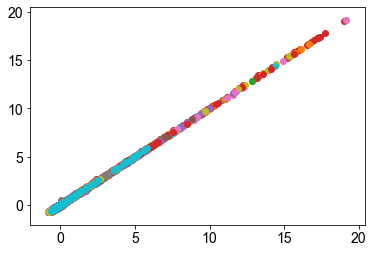

In [100]:
for i in range(200):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [101]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572342466470505
0.9975138533905277
0.00107217780263679 0.007446737378860348
9.543739909911274 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.3441, -0.0980, -0.1462,  ..., -0.2263, -0.0203,  0.0899],
        [-0.3527,  2.0704, -0.2741,  ..., -0.2335, -0.2188, -0.2394],
        [-0.2126, -0.1882,  0.1217,  ..., -0.2147, -0.2188, -0.2672],
        ...,
        [ 0.4868, -0.1884, -0.2705,  ..., -0.0601, -0.2117, -0.2693],
        [-0.3610, -0.1885, -0.2741,  ..., -0.0093, -0.2188, -0.2559],
        [ 0.5178, -0.1738, -0.2738,  ...,  0.5037,  1.3042, -0.2698]],
       dtype=torch.float64)
1 iteration
267.8096923828125
2 iteration
253.47796630859375
3 iteration
244.19944763183594
4 iteration
233.18841552734375
5 iteration
221.29885864257812
6 iteration
208.62808227539062
7 iteration
197.07691955566406
8 iteration
187.16226196289062
9 iteration
177.3838653564453
10 iteration
169.4290008544922
11 iteration
160.8

10.049893379211426
242 iteration
10.407952308654785
243 iteration
10.689350128173828
244 iteration
9.88326644897461
245 iteration
9.582128524780273
246 iteration
9.83078670501709
247 iteration
9.846181869506836
248 iteration
9.45086669921875
249 iteration
9.341480255126953
250 iteration
9.554569244384766
251 iteration
9.419442176818848
252 iteration
9.2672758102417
253 iteration
9.264434814453125
254 iteration
9.2645902633667
255 iteration
9.250473022460938
256 iteration
9.194485664367676
257 iteration
9.23682975769043
258 iteration
9.256803512573242
259 iteration
9.164056777954102
260 iteration
9.10228157043457
261 iteration
9.061609268188477
262 iteration
8.99024486541748
263 iteration
8.945708274841309
264 iteration
8.860238075256348
265 iteration
8.756793975830078
266 iteration
8.727052688598633
267 iteration
8.724702835083008
268 iteration
8.622030258178711
269 iteration
8.612170219421387
270 iteration
8.530806541442871
271 iteration
8.514358520507812
272 iteration
8.5639982223510

5.78406286239624
504 iteration
5.69931697845459
505 iteration
5.736836910247803
506 iteration
5.7256622314453125
507 iteration
5.613862991333008
508 iteration
5.561564922332764
509 iteration
5.592020034790039
510 iteration
5.6268086433410645
511 iteration
5.576849937438965
512 iteration
5.5393147468566895
513 iteration
5.508230209350586
514 iteration
5.512933731079102
515 iteration
5.471597194671631
516 iteration
5.406330108642578
517 iteration
5.365466594696045
518 iteration
5.394335746765137
519 iteration
5.3674397468566895
520 iteration
5.329082012176514
521 iteration
5.334534168243408
522 iteration
5.355733871459961
523 iteration
5.4532012939453125
524 iteration
5.644694805145264
525 iteration
6.072922706604004
526 iteration
6.572667598724365
527 iteration
6.9790802001953125
528 iteration
6.555227279663086
529 iteration
5.9176506996154785
530 iteration
5.870262622833252
531 iteration
6.253039360046387
532 iteration
6.240876197814941
533 iteration
5.7340240478515625
534 iteration
5.

4.539808750152588
762 iteration
4.502690315246582
763 iteration
4.370185852050781
764 iteration
4.302107810974121
765 iteration
4.272474765777588
766 iteration
4.276413440704346
767 iteration
4.304784774780273
768 iteration
4.299358367919922
769 iteration
4.2183308601379395
770 iteration
4.185084819793701
771 iteration
4.156493186950684
772 iteration
4.18755578994751
773 iteration
4.2201361656188965
774 iteration
4.179403305053711
775 iteration
4.1127028465271
776 iteration
4.082982063293457
777 iteration
4.046747207641602
778 iteration
4.0155463218688965
779 iteration
4.028296947479248
780 iteration
4.065138816833496
781 iteration
4.219241142272949
782 iteration
4.443772315979004
783 iteration
4.72247314453125
784 iteration
4.901004791259766
785 iteration
4.793331623077393
786 iteration
4.570261001586914
787 iteration
4.4545722007751465
788 iteration
4.493009567260742
789 iteration
4.782780647277832
790 iteration
5.108108043670654
791 iteration
5.112963676452637
792 iteration
4.725587

3.4896020889282227
1022 iteration
3.528503894805908
1023 iteration
3.5658419132232666
1024 iteration
3.650790214538574
1025 iteration
3.7149975299835205
1026 iteration
3.746553897857666
1027 iteration
3.602405548095703
1028 iteration
3.486814260482788
1029 iteration
3.4469029903411865
1030 iteration
3.449097156524658
1031 iteration
3.443709373474121
1032 iteration
3.456188917160034
1033 iteration
3.493773937225342
1034 iteration
3.5316853523254395
1035 iteration
3.641005039215088
1036 iteration
3.6842854022979736
1037 iteration
3.6846280097961426
1038 iteration
3.7077066898345947
1039 iteration
3.720944404602051
1040 iteration
3.787419319152832
1041 iteration
3.7582056522369385
1042 iteration
3.747629404067993
1043 iteration
3.6330432891845703
1044 iteration
3.519644021987915
1045 iteration
3.413623809814453
1046 iteration
3.437593936920166
1047 iteration
3.527064561843872
1048 iteration
3.639862060546875
1049 iteration
3.740312099456787
1050 iteration
3.7229597568511963
1051 iteration

3.092254877090454
1270 iteration
3.038463830947876
1271 iteration
3.009032726287842
1272 iteration
3.01631760597229
1273 iteration
3.047633171081543
1274 iteration
3.1241211891174316
1275 iteration
3.2253894805908203
1276 iteration
3.354456901550293
1277 iteration
3.515301465988159
1278 iteration
3.5383801460266113
1279 iteration
3.4094419479370117
1280 iteration
3.2593111991882324
1281 iteration
3.151499032974243
1282 iteration
3.1152701377868652
1283 iteration
3.1298940181732178
1284 iteration
3.15252423286438
1285 iteration
3.152029514312744
1286 iteration
3.145461082458496
1287 iteration
3.1042957305908203
1288 iteration
3.058243751525879
1289 iteration
3.01554536819458
1290 iteration
2.967336416244507
1291 iteration
2.953538656234741
1292 iteration
2.9400060176849365
1293 iteration
2.9533417224884033
1294 iteration
2.9951553344726562
1295 iteration
3.0275444984436035
1296 iteration
3.0095977783203125
1297 iteration
3.1034750938415527
1298 iteration
3.1909384727478027
1299 iteratio

2.9171268939971924
1517 iteration
2.9871585369110107
1518 iteration
3.171793222427368
1519 iteration
3.336071252822876
1520 iteration
3.5357303619384766
1521 iteration
3.616680383682251
1522 iteration
3.5296878814697266
1523 iteration
3.19816517829895
1524 iteration
2.9251816272735596
1525 iteration
2.8621909618377686
1526 iteration
3.0479965209960938
1527 iteration
3.166830062866211
1528 iteration
3.209965944290161
1529 iteration
3.254722833633423
1530 iteration
3.2026519775390625
1531 iteration
3.1132280826568604
1532 iteration
2.977722644805908
1533 iteration
2.8992505073547363
1534 iteration
2.843764305114746
1535 iteration
2.816851854324341
1536 iteration
2.878600835800171
1537 iteration
2.8827295303344727
1538 iteration
2.911442756652832
1539 iteration
2.843428611755371
1540 iteration
2.78066086769104
1541 iteration
2.710308074951172
1542 iteration
2.7113265991210938
1543 iteration
2.6992485523223877
1544 iteration
2.6786534786224365
1545 iteration
2.6438498497009277
1546 iterati

2.5733296871185303
1762 iteration
2.588533401489258
1763 iteration
2.632657051086426
1764 iteration
2.702087879180908
1765 iteration
2.6540632247924805
1766 iteration
2.5639541149139404
1767 iteration
2.5214977264404297
1768 iteration
2.529203176498413
1769 iteration
2.5018346309661865
1770 iteration
2.425675868988037
1771 iteration
2.386817693710327
1772 iteration
2.371811866760254
1773 iteration
2.420360565185547
1774 iteration
2.489055871963501
1775 iteration
2.54180645942688
1776 iteration
2.6402933597564697
1777 iteration
2.530377149581909
1778 iteration
2.470909833908081
1779 iteration
2.4544782638549805
1780 iteration
2.4435875415802
1781 iteration
2.4641454219818115
1782 iteration
2.431657075881958
1783 iteration
2.4323196411132812
1784 iteration
2.441593885421753
1785 iteration
2.4707064628601074
1786 iteration
2.5718584060668945
1787 iteration
2.9276111125946045
1788 iteration
3.4424736499786377
1789 iteration
3.668764591217041
1790 iteration
3.6318588256835938
1791 iteration

3.044890880584717
2012 iteration
2.7827436923980713
2013 iteration
2.9281246662139893
2014 iteration
2.9862232208251953
2015 iteration
2.812241792678833
2016 iteration
2.6665308475494385
2017 iteration
2.6501612663269043
2018 iteration
2.608149290084839
2019 iteration
2.520733118057251
2020 iteration
2.485275983810425
2021 iteration
2.3823437690734863
2022 iteration
2.3863935470581055
2023 iteration
2.4129021167755127
2024 iteration
2.341156244277954
2025 iteration
2.3012828826904297
2026 iteration
2.3690152168273926
2027 iteration
2.3403725624084473
2028 iteration
2.276667594909668
2029 iteration
2.2376937866210938
2030 iteration
2.179171562194824
2031 iteration
2.189389944076538
2032 iteration
2.188316822052002
2033 iteration
2.1431922912597656
2034 iteration
2.1414496898651123
2035 iteration
2.1683411598205566
2036 iteration
2.217423677444458
2037 iteration
2.165224313735962
2038 iteration
2.107062578201294
2039 iteration
2.087996244430542
2040 iteration
2.071115255355835
2041 itera

2.0065207481384277
2267 iteration
1.9633575677871704
2268 iteration
1.9281703233718872
2269 iteration
1.9145715236663818
2270 iteration
1.913793683052063
2271 iteration
1.9243491888046265
2272 iteration
1.9209822416305542
2273 iteration
1.9124462604522705
2274 iteration
1.8944419622421265
2275 iteration
1.8923912048339844
2276 iteration
1.9136230945587158
2277 iteration
2.0494868755340576
2278 iteration
2.098482131958008
2279 iteration
2.1942012310028076
2280 iteration
2.12064266204834
2281 iteration
2.0683515071868896
2282 iteration
2.02205753326416
2283 iteration
2.0279529094696045
2284 iteration
2.094754219055176
2285 iteration
2.2294259071350098
2286 iteration
2.4443273544311523
2287 iteration
2.6397528648376465
2288 iteration
2.788231611251831
2289 iteration
2.807262659072876
2290 iteration
2.779074192047119
2291 iteration
2.5804519653320312
2292 iteration
2.415553331375122
2293 iteration
2.426184892654419
2294 iteration
2.427401542663574
2295 iteration
2.4348552227020264
2296 ite

1.7135554552078247
2513 iteration
1.7108606100082397
2514 iteration
1.7224845886230469
2515 iteration
1.7275197505950928
2516 iteration
1.7328938245773315
2517 iteration
1.8180155754089355
2518 iteration
1.8529860973358154
2519 iteration
1.866689682006836
2520 iteration
1.8298823833465576
2521 iteration
1.787529706954956
2522 iteration
1.7529628276824951
2523 iteration
1.7422902584075928
2524 iteration
1.7599642276763916
2525 iteration
1.801731824874878
2526 iteration
1.877656102180481
2527 iteration
1.9849079847335815
2528 iteration
2.1987252235412598
2529 iteration
2.372710943222046
2530 iteration
2.6348061561584473
2531 iteration
2.525026559829712
2532 iteration
2.212576150894165
2533 iteration
2.0662875175476074
2534 iteration
2.0947861671447754
2535 iteration
2.108114004135132
2536 iteration
2.042598009109497
2537 iteration
2.0221269130706787
2538 iteration
1.9888283014297485
2539 iteration
1.9727553129196167
2540 iteration
1.9678500890731812
2541 iteration
1.9275567531585693
2542

2.0237083435058594
2761 iteration
2.0270421504974365
2762 iteration
1.963751196861267
2763 iteration
1.8909454345703125
2764 iteration
1.8703694343566895
2765 iteration
1.8616448640823364
2766 iteration
1.833509922027588
2767 iteration
1.7819346189498901
2768 iteration
1.7773022651672363
2769 iteration
1.789649248123169
2770 iteration
1.7848213911056519
2771 iteration
1.8298639059066772
2772 iteration
1.8336340188980103
2773 iteration
1.8216615915298462
2774 iteration
1.7651493549346924
2775 iteration
1.7044026851654053
2776 iteration
1.6908477544784546
2777 iteration
1.6853742599487305
2778 iteration
1.679803729057312
2779 iteration
1.6765000820159912
2780 iteration
1.657751202583313
2781 iteration
1.6365299224853516
2782 iteration
1.6496610641479492
2783 iteration
1.6522331237792969
2784 iteration
1.6980994939804077
2785 iteration
1.6905744075775146
2786 iteration
1.7006340026855469
2787 iteration
1.6920539140701294
2788 iteration
1.6765244007110596
2789 iteration
1.676090121269226
2

2.944791078567505
3011 iteration
2.9733705520629883
3012 iteration
2.5952658653259277
3013 iteration
2.4173593521118164
3014 iteration
2.447324514389038
3015 iteration
2.3956992626190186
3016 iteration
2.22790789604187
3017 iteration
2.1513497829437256
3018 iteration
2.1551618576049805
3019 iteration
2.063807249069214
3020 iteration
2.0515506267547607
3021 iteration
1.9424470663070679
3022 iteration
1.889898419380188
3023 iteration
1.8621290922164917
3024 iteration
1.870242953300476
3025 iteration
1.82453453540802
3026 iteration
1.757422924041748
3027 iteration
1.7378672361373901
3028 iteration
1.7106282711029053
3029 iteration
1.6818429231643677
3030 iteration
1.6661309003829956
3031 iteration
1.666974425315857
3032 iteration
1.6186058521270752
3033 iteration
1.6169978380203247
3034 iteration
1.5735818147659302
3035 iteration
1.5778963565826416
3036 iteration
1.5395145416259766
3037 iteration
1.540481448173523
3038 iteration
1.5280523300170898
3039 iteration
1.5268915891647339
3040 it

1.4115079641342163
3255 iteration
1.4282313585281372
3256 iteration
1.4496960639953613
3257 iteration
1.4850795269012451
3258 iteration
1.4976806640625
3259 iteration
1.5124202966690063
3260 iteration
1.5423177480697632
3261 iteration
1.559565782546997
3262 iteration
1.5467609167099
3263 iteration
1.5507746934890747
3264 iteration
1.5509194135665894
3265 iteration
1.5801360607147217
3266 iteration
1.5818891525268555
3267 iteration
1.5711520910263062
3268 iteration
1.5299934148788452
3269 iteration
1.5092926025390625
3270 iteration
1.4772628545761108
3271 iteration
1.5122965574264526
3272 iteration
1.5759657621383667
3273 iteration
1.5972980260849
3274 iteration
1.602866291999817
3275 iteration
1.6060385704040527
3276 iteration
1.604940414428711
3277 iteration
1.5905225276947021
3278 iteration
1.5716999769210815
3279 iteration
1.5443177223205566
3280 iteration
1.5294020175933838
3281 iteration
1.4866676330566406
3282 iteration
1.4762959480285645
3283 iteration
1.498857855796814
3284 ite

1.4414101839065552
3499 iteration
1.510556936264038
3500 iteration
1.5185703039169312
3501 iteration
1.5476548671722412
3502 iteration
1.5173423290252686
3503 iteration
1.4595519304275513
3504 iteration
1.4011027812957764
3505 iteration
1.403092861175537
3506 iteration
1.4386805295944214
3507 iteration
1.479479193687439
3508 iteration
1.5365737676620483
3509 iteration
1.5528035163879395
3510 iteration
1.5774821043014526
3511 iteration
1.5679209232330322
3512 iteration
1.5541110038757324
3513 iteration
1.553228735923767
3514 iteration
1.6086522340774536
3515 iteration
1.6846314668655396
3516 iteration
1.7835209369659424
3517 iteration
1.8524173498153687
3518 iteration
1.8574374914169312
3519 iteration
1.7695664167404175
3520 iteration
1.6548993587493896
3521 iteration
1.6319129467010498
3522 iteration
1.651808500289917
3523 iteration
1.7169981002807617
3524 iteration
1.7136993408203125
3525 iteration
1.6514639854431152
3526 iteration
1.5868797302246094
3527 iteration
1.5775952339172363


1.4442634582519531
3746 iteration
1.4225653409957886
3747 iteration
1.4401129484176636
3748 iteration
1.4460963010787964
3749 iteration
1.4639314413070679
3750 iteration
1.4551366567611694
3751 iteration
1.4137179851531982
3752 iteration
1.3618546724319458
3753 iteration
1.3591291904449463
3754 iteration
1.3487154245376587
3755 iteration
1.3520597219467163
3756 iteration
1.3506907224655151
3757 iteration
1.3606441020965576
3758 iteration
1.3637738227844238
3759 iteration
1.3586511611938477
3760 iteration
1.3593626022338867
3761 iteration
1.3682376146316528
3762 iteration
1.3299152851104736
3763 iteration
1.3363580703735352
3764 iteration
1.3574916124343872
3765 iteration
1.3714627027511597
3766 iteration
1.4038559198379517
3767 iteration
1.4288243055343628
3768 iteration
1.444564700126648
3769 iteration
1.5139679908752441
3770 iteration
1.6076629161834717
3771 iteration
1.7388596534729004
3772 iteration
1.805484652519226
3773 iteration
1.9001668691635132
3774 iteration
1.97202408313751

1.4470319747924805
3994 iteration
1.4977089166641235
3995 iteration
1.523039698600769
3996 iteration
1.5419360399246216
3997 iteration
1.5421440601348877
3998 iteration
1.5198707580566406
3999 iteration
1.4719007015228271
4000 iteration
1.4266400337219238
4001 iteration
1.3883167505264282
4002 iteration
1.3776049613952637
4003 iteration
1.4091708660125732
4004 iteration
1.436800241470337
4005 iteration
1.4652137756347656
4006 iteration
1.4659686088562012
4007 iteration
1.402286171913147
4008 iteration
1.3927738666534424
4009 iteration
1.3849968910217285
4010 iteration
1.3776568174362183
4011 iteration
1.3739584684371948
4012 iteration
1.3646254539489746
4013 iteration
1.3490017652511597
4014 iteration
1.3577667474746704
4015 iteration
1.357530951499939
4016 iteration
1.3213452100753784
4017 iteration
1.297439694404602
4018 iteration
1.2869778871536255
4019 iteration
1.284601092338562
4020 iteration
1.3037140369415283
4021 iteration
1.3027877807617188
4022 iteration
1.3113828897476196
4

1.2792930603027344
4237 iteration
1.265987515449524
4238 iteration
1.2591944932937622
4239 iteration
1.296745777130127
4240 iteration
1.3454487323760986
4241 iteration
1.372757911682129
4242 iteration
1.38132643699646
4243 iteration
1.3498358726501465
4244 iteration
1.3302803039550781
4245 iteration
1.3181593418121338
4246 iteration
1.3084365129470825
4247 iteration
1.3048056364059448
4248 iteration
1.2869958877563477
4249 iteration
1.2769451141357422
4250 iteration
1.3036787509918213
4251 iteration
1.3353191614151
4252 iteration
1.370129108428955
4253 iteration
1.4052423238754272
4254 iteration
1.4494343996047974
4255 iteration
1.4712297916412354
4256 iteration
1.5170570611953735
4257 iteration
1.571655511856079
4258 iteration
1.603894591331482
4259 iteration
1.6751015186309814
4260 iteration
1.7129652500152588
4261 iteration
1.726749300956726
4262 iteration
1.610612392425537
4263 iteration
1.557202935218811
4264 iteration
1.5479543209075928
4265 iteration
1.6165008544921875
4266 iter

1.250327706336975
4485 iteration
1.2437142133712769
4486 iteration
1.2459700107574463
4487 iteration
1.2691048383712769
4488 iteration
1.2991942167282104
4489 iteration
1.3144136667251587
4490 iteration
1.3484593629837036
4491 iteration
1.3669086694717407
4492 iteration
1.7297906875610352
4493 iteration
1.6809219121932983
4494 iteration
1.7873897552490234
4495 iteration
1.7720333337783813
4496 iteration
1.7427664995193481
4497 iteration
1.8296566009521484
4498 iteration
1.7744663953781128
4499 iteration
1.75792396068573
4500 iteration
1.7042237520217896
4501 iteration
1.6306815147399902
4502 iteration
1.6286402940750122
4503 iteration
1.5614757537841797
4504 iteration
1.5049816370010376
4505 iteration
1.4926979541778564
4506 iteration
1.4427640438079834
4507 iteration
1.4664943218231201
4508 iteration
1.4868414402008057
4509 iteration
1.4160521030426025
4510 iteration
1.3693795204162598
4511 iteration
1.4106050729751587
4512 iteration
1.4687193632125854
4513 iteration
1.515339612960815

1.320396065711975
4729 iteration
1.2984206676483154
4730 iteration
1.2844678163528442
4731 iteration
1.2981404066085815
4732 iteration
1.2866082191467285
4733 iteration
1.2817643880844116
4734 iteration
1.3001002073287964
4735 iteration
1.2852280139923096
4736 iteration
1.2980248928070068
4737 iteration
1.316371202468872
4738 iteration
1.3325145244598389
4739 iteration
1.371993899345398
4740 iteration
1.4118324518203735
4741 iteration
1.456132411956787
4742 iteration
1.4894710779190063
4743 iteration
1.5657116174697876
4744 iteration
1.6943426132202148
4745 iteration
1.8366425037384033
4746 iteration
1.9032561779022217
4747 iteration
1.904632806777954
4748 iteration
1.837646245956421
4749 iteration
1.681217908859253
4750 iteration
1.538529396057129
4751 iteration
1.5664371252059937
4752 iteration
1.6187676191329956
4753 iteration
1.6120450496673584
4754 iteration
1.5345957279205322
4755 iteration
1.4420063495635986
4756 iteration
1.4290786981582642
4757 iteration
1.4451966285705566
475

1.179886817932129
4978 iteration
1.17274010181427
4979 iteration
1.1731089353561401
4980 iteration
1.1624538898468018
4981 iteration
1.1624045372009277
4982 iteration
1.1959010362625122
4983 iteration
1.2112520933151245
4984 iteration
1.1982614994049072
4985 iteration
1.2127442359924316
4986 iteration
1.1815639734268188
4987 iteration
1.1839666366577148
4988 iteration
1.1942497491836548
4989 iteration
1.1881675720214844
4990 iteration
1.2016960382461548
4991 iteration
1.2418583631515503
4992 iteration
1.292702555656433
4993 iteration
1.3877677917480469
4994 iteration
1.4988478422164917
4995 iteration
1.6346250772476196
4996 iteration
1.7559698820114136
4997 iteration
1.8456498384475708
4998 iteration
1.8907159566879272
4999 iteration
1.8679780960083008
5000 iteration
1.8085176944732666


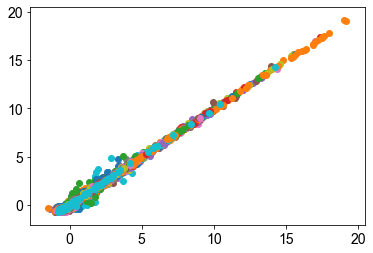

In [102]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [104]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        ynorm = scalerY.fit_transform(Y)
        #ynorm = scalerY.fit_transform(Y_nmf)
        xnorm = scalerX.fit_transform(X)
        #xnorm = scalerX.fit_transform(X_nmf)
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572241928592377
0.9975153305901501
0.0010721778027673065 0.007446737378860348
9.133157430300335 376.0
encoder_layer_sizes [240, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.0911, -0.1803, -0.2605,  ..., -0.2582, -0.3947, -0.3195],
        [-0.3014, -0.1867, -0.2698,  ..., -0.1018, -0.3561, -0.3144],
        [-0.3635, -0.1885, -0.2741,  ..., -0.0660, -0.1727, -0.2633],
        ...,
        [-0.2836, -0.1854, -0.2492,  ...,  0.0477,  0.4423,  0.4721],
        [-0.0972, -0.1761, -0.2568,  ...,  0.1210, -0.2446, -0.0239],
        [-0.2817, -0.1844, -0.2741,  ..., -0.1962, -0.0539,  0.0670]],
       dtype=torch.float64)
1 iteration
589.3911743164062
2 iteration
548.078857421875
3 iteration
529.1415405273438
4 iteration
521.5299682617188
5 iteration
497.96881103515625
6 iteration
488.1959228515625
7 iteration
465.48785400390625
8 iteration
447.1941223144531
9 iteration
428.47271728515625
10 iteration
412.3218078613281
11 iteration
396.6764

35.8241081237793
241 iteration
35.98865509033203
242 iteration
36.01001739501953
243 iteration
35.566619873046875
244 iteration
35.31779479980469
245 iteration
35.036102294921875
246 iteration
35.148651123046875
247 iteration
34.98828125
248 iteration
34.634037017822266
249 iteration
34.70825958251953
250 iteration
34.466941833496094
251 iteration
34.31129455566406
252 iteration
34.54876708984375
253 iteration
34.495140075683594
254 iteration
34.8968505859375
255 iteration
35.26390838623047
256 iteration
35.14994812011719
257 iteration
34.59355926513672
258 iteration
33.59727478027344
259 iteration
33.4515380859375
260 iteration
33.72810745239258
261 iteration
33.5652961730957
262 iteration
33.3351936340332
263 iteration
32.96443176269531
264 iteration
32.74124526977539
265 iteration
33.01606750488281
266 iteration
33.044677734375
267 iteration
32.81001663208008
268 iteration
32.7315673828125
269 iteration
32.4344596862793
270 iteration
32.443626403808594
271 iteration
32.4288749694824

20.893299102783203
494 iteration
20.45077896118164
495 iteration
20.25905418395996
496 iteration
20.357879638671875
497 iteration
20.3689022064209
498 iteration
20.302106857299805
499 iteration
20.183305740356445
500 iteration
19.951438903808594
501 iteration
19.841928482055664
502 iteration
19.849285125732422
503 iteration
19.949480056762695
504 iteration
19.86978530883789
505 iteration
19.683006286621094
506 iteration
19.69424057006836
507 iteration
19.74074935913086
508 iteration
19.80860137939453
509 iteration
19.949840545654297
510 iteration
20.0926513671875
511 iteration
20.227245330810547
512 iteration
20.35651206970215
513 iteration
20.24285888671875
514 iteration
20.03789710998535
515 iteration
19.828052520751953
516 iteration
19.863004684448242
517 iteration
20.098405838012695
518 iteration
20.3689022064209
519 iteration
20.459348678588867
520 iteration
20.32277488708496
521 iteration
19.884721755981445
522 iteration
19.564502716064453
523 iteration
19.595478057861328
524 ite

15.87365436553955
746 iteration
15.604150772094727
747 iteration
15.600650787353516
748 iteration
15.706360816955566
749 iteration
15.789076805114746
750 iteration
15.773133277893066
751 iteration
15.523994445800781
752 iteration
15.413751602172852
753 iteration
15.373652458190918
754 iteration
15.517560005187988
755 iteration
15.7221097946167
756 iteration
16.092729568481445
757 iteration
16.283126831054688
758 iteration
16.48653793334961
759 iteration
16.63534164428711
760 iteration
17.049846649169922
761 iteration
17.67023468017578
762 iteration
17.865827560424805
763 iteration
17.817028045654297
764 iteration
17.323055267333984
765 iteration
17.053329467773438
766 iteration
17.060407638549805
767 iteration
16.985427856445312
768 iteration
16.43065071105957
769 iteration
16.0726261138916
770 iteration
16.07024574279785
771 iteration
16.063161849975586
772 iteration
16.046920776367188
773 iteration
15.814031600952148
774 iteration
15.505484580993652
775 iteration
15.415008544921875
7

12.63770866394043
1004 iteration
12.51618480682373
1005 iteration
12.372055053710938
1006 iteration
12.411901473999023
1007 iteration
12.431674003601074
1008 iteration
12.289521217346191
1009 iteration
12.147514343261719
1010 iteration
12.204931259155273
1011 iteration
12.371688842773438
1012 iteration
12.441619873046875
1013 iteration
12.468017578125
1014 iteration
12.509662628173828
1015 iteration
12.55005931854248
1016 iteration
12.505805969238281
1017 iteration
12.33828353881836
1018 iteration
12.26430892944336
1019 iteration
12.30439567565918
1020 iteration
12.366473197937012
1021 iteration
12.598673820495605
1022 iteration
12.944067001342773
1023 iteration
13.429048538208008
1024 iteration
13.949020385742188
1025 iteration
14.71121597290039
1026 iteration
14.353819847106934
1027 iteration
13.373887062072754
1028 iteration
13.190604209899902
1029 iteration
13.449204444885254
1030 iteration
13.510955810546875
1031 iteration
13.065703392028809
1032 iteration
12.787335395812988
1033 

10.897577285766602
1247 iteration
10.476709365844727
1248 iteration
10.38636302947998
1249 iteration
10.362567901611328
1250 iteration
10.317604064941406
1251 iteration
10.147665023803711
1252 iteration
10.035483360290527
1253 iteration
9.980367660522461
1254 iteration
10.253616333007812
1255 iteration
10.292093276977539
1256 iteration
10.010486602783203
1257 iteration
9.888258934020996
1258 iteration
9.954120635986328
1259 iteration
9.984269142150879
1260 iteration
10.000940322875977
1261 iteration
9.985382080078125
1262 iteration
9.997349739074707
1263 iteration
9.96468448638916
1264 iteration
9.954620361328125
1265 iteration
9.923630714416504
1266 iteration
9.927163124084473
1267 iteration
9.983366012573242
1268 iteration
10.224180221557617
1269 iteration
10.454180717468262
1270 iteration
10.755067825317383
1271 iteration
10.978546142578125
1272 iteration
11.17834758758545
1273 iteration
11.940502166748047
1274 iteration
12.84408187866211
1275 iteration
13.130353927612305
1276 itera

8.510501861572266
1502 iteration
8.531416893005371
1503 iteration
8.52872371673584
1504 iteration
8.471238136291504
1505 iteration
8.435294151306152
1506 iteration
8.429676055908203
1507 iteration
8.4501371383667
1508 iteration
8.494210243225098
1509 iteration
8.592499732971191
1510 iteration
8.768431663513184
1511 iteration
9.000821113586426
1512 iteration
9.229405403137207
1513 iteration
9.624777793884277
1514 iteration
9.888930320739746
1515 iteration
9.840343475341797
1516 iteration
9.691431999206543
1517 iteration
9.263825416564941
1518 iteration
8.94371223449707
1519 iteration
9.051753997802734
1520 iteration
9.071603775024414
1521 iteration
9.05259895324707
1522 iteration
9.00793743133545
1523 iteration
8.8467378616333
1524 iteration
8.72046184539795
1525 iteration
8.768646240234375
1526 iteration
8.74958324432373
1527 iteration
8.690255165100098
1528 iteration
8.560126304626465
1529 iteration
8.479783058166504
1530 iteration
8.495927810668945
1531 iteration
8.499466896057129
15

8.08228874206543
1757 iteration
8.153322219848633
1758 iteration
8.128376007080078
1759 iteration
8.136369705200195
1760 iteration
8.163415908813477
1761 iteration
8.239373207092285
1762 iteration
8.129324913024902
1763 iteration
8.036090850830078
1764 iteration
7.9285807609558105
1765 iteration
8.020926475524902
1766 iteration
8.169801712036133
1767 iteration
8.320570945739746
1768 iteration
8.323777198791504
1769 iteration
8.314605712890625
1770 iteration
8.443897247314453
1771 iteration
8.700494766235352
1772 iteration
9.109161376953125
1773 iteration
9.588277816772461
1774 iteration
9.7593355178833
1775 iteration
9.54406452178955
1776 iteration
9.007460594177246
1777 iteration
8.598214149475098
1778 iteration
8.620948791503906
1779 iteration
9.084827423095703
1780 iteration
9.484152793884277
1781 iteration
9.37091064453125
1782 iteration
8.902390480041504
1783 iteration
8.686087608337402
1784 iteration
8.890371322631836
1785 iteration
9.02646255493164
1786 iteration
8.7651681900024

8.064096450805664
2011 iteration
8.015826225280762
2012 iteration
7.846534729003906
2013 iteration
7.672521114349365
2014 iteration
7.521040916442871
2015 iteration
7.685933589935303
2016 iteration
7.857337474822998
2017 iteration
8.02791976928711
2018 iteration
8.019671440124512
2019 iteration
7.822971820831299
2020 iteration
7.528317928314209
2021 iteration
7.504704475402832
2022 iteration
7.541618824005127
2023 iteration
7.514944076538086
2024 iteration
7.385518550872803
2025 iteration
7.2895636558532715
2026 iteration
7.286859512329102
2027 iteration
7.3504638671875
2028 iteration
7.508427619934082
2029 iteration
7.649543285369873
2030 iteration
7.662164688110352
2031 iteration
7.511459827423096
2032 iteration
7.352463245391846
2033 iteration
7.315029144287109
2034 iteration
7.389167308807373
2035 iteration
7.495248794555664
2036 iteration
7.492209434509277
2037 iteration
7.441671371459961
2038 iteration
7.415153980255127
2039 iteration
7.501379489898682
2040 iteration
7.7298040390

KeyboardInterrupt: 

In [105]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        #ynorm = scalerY.fit_transform(Y)
        #ynorm = scalerY.fit_transform(Y_nmf)
        #xnorm = scalerX.fit_transform(X)
        #xnorm = scalerX.fit_transform(X_nmf)
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572268966921958
0.9975132165665463
0.0010721778047561746 0.007446737378860348
9.55115918902617 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.1713, -0.1885, -0.2741,  ..., -0.2131, -0.2188, -0.2664],
        [-0.0373, -0.1774, -0.2070,  ...,  0.1119,  0.8105, -0.2680],
        [-0.3255, -0.1835, -0.2073,  ..., -0.2141, -0.2115, -0.1970],
        ...,
        [-0.3148, -0.1885, -0.2741,  ..., -0.2335, -0.2188, -0.2695],
        [-0.2052, -0.1791, -0.2518,  ..., -0.2179, -0.2184, -0.2600],
        [-0.3201,  0.8965, -0.1996,  ..., -0.2112, -0.2168,  2.3822]],
       dtype=torch.float64)
1 iteration
252.04312133789062
2 iteration
231.30331420898438
3 iteration
224.49351501464844
4 iteration
217.27627563476562
5 iteration
205.4868927001953
6 iteration
198.8457794189453
7 iteration
186.6717529296875
8 iteration
178.9164581298828
9 iteration
170.0068817138672
10 iteration
165.21534729003906
11 iteration
155.68

8.564655303955078
241 iteration
8.517589569091797
242 iteration
8.533211708068848
243 iteration
8.597127914428711
244 iteration
8.653489112854004
245 iteration
8.784248352050781
246 iteration
8.745116233825684
247 iteration
8.612357139587402
248 iteration
8.47387409210205
249 iteration
8.479559898376465
250 iteration
8.52432918548584
251 iteration
8.455806732177734
252 iteration
8.358423233032227
253 iteration
8.388643264770508
254 iteration
8.42113971710205
255 iteration
8.432395935058594
256 iteration
8.33864974975586
257 iteration
8.318065643310547
258 iteration
8.282763481140137
259 iteration
8.18791675567627
260 iteration
8.058858871459961
261 iteration
8.03851318359375
262 iteration
8.052600860595703
263 iteration
8.00925350189209
264 iteration
7.970737934112549
265 iteration
7.936857223510742
266 iteration
7.8918776512146
267 iteration
7.897253513336182
268 iteration
7.9418206214904785
269 iteration
7.86653470993042
270 iteration
7.886853218078613
271 iteration
7.797423362731934

5.198166370391846
499 iteration
5.191218376159668
500 iteration
5.179934978485107
501 iteration
5.232726097106934
502 iteration
5.27392053604126
503 iteration
5.1584153175354
504 iteration
5.039707183837891
505 iteration
4.981047630310059
506 iteration
4.956405162811279
507 iteration
5.031712055206299
508 iteration
5.099249839782715
509 iteration
5.117897033691406
510 iteration
5.095820903778076
511 iteration
5.105691909790039
512 iteration
5.1216325759887695
513 iteration
5.070500373840332
514 iteration
4.939620018005371
515 iteration
4.894054412841797
516 iteration
4.919533729553223
517 iteration
4.985231876373291
518 iteration
4.976991176605225
519 iteration
4.896029472351074
520 iteration
4.868831634521484
521 iteration
4.89328670501709
522 iteration
4.944271087646484
523 iteration
4.948046684265137
524 iteration
4.919856548309326
525 iteration
4.887009620666504
526 iteration
4.918569564819336
527 iteration
4.976909160614014
528 iteration
4.940736293792725
529 iteration
4.881912231

3.8139803409576416
763 iteration
3.830216407775879
764 iteration
3.899033308029175
765 iteration
3.96223521232605
766 iteration
4.011488914489746
767 iteration
4.055148601531982
768 iteration
4.1766815185546875
769 iteration
4.52711296081543
770 iteration
5.007033824920654
771 iteration
5.819053649902344
772 iteration
5.652789115905762
773 iteration
5.300750255584717
774 iteration
4.755612850189209
775 iteration
4.854828357696533
776 iteration
4.800168514251709
777 iteration
4.565530776977539
778 iteration
4.455976963043213
779 iteration
4.5279693603515625
780 iteration
4.388136386871338
781 iteration
4.198103427886963
782 iteration
4.2387895584106445
783 iteration
4.301140785217285
784 iteration
4.059567451477051
785 iteration
4.002875804901123
786 iteration
4.080784797668457
787 iteration
3.9738388061523438
788 iteration
3.8958048820495605
789 iteration
3.9526262283325195
790 iteration
3.8761353492736816
791 iteration
3.847959280014038
792 iteration
3.871145486831665
793 iteration
3.

3.1249148845672607
1017 iteration
3.136545419692993
1018 iteration
3.1447067260742188
1019 iteration
3.1717729568481445
1020 iteration
3.2086799144744873
1021 iteration
3.3015341758728027
1022 iteration
3.3966190814971924
1023 iteration
3.4571192264556885
1024 iteration
3.4049692153930664
1025 iteration
3.3097424507141113
1026 iteration
3.19423246383667
1027 iteration
3.1400907039642334
1028 iteration
3.1546435356140137
1029 iteration
3.2661869525909424
1030 iteration
3.4265170097351074
1031 iteration
3.5876240730285645
1032 iteration
3.681269884109497
1033 iteration
3.605377674102783
1034 iteration
3.379826068878174
1035 iteration
3.2452197074890137
1036 iteration
3.206664562225342
1037 iteration
3.2495131492614746
1038 iteration
3.297356128692627
1039 iteration
3.2314271926879883
1040 iteration
3.1492514610290527
1041 iteration
3.142880439758301
1042 iteration
3.1526966094970703
1043 iteration
3.199807643890381
1044 iteration
3.157085657119751
1045 iteration
3.105997323989868
1046 it

2.776433229446411
1270 iteration
2.755432367324829
1271 iteration
2.7025997638702393
1272 iteration
2.6915948390960693
1273 iteration
2.6669046878814697
1274 iteration
2.639740228652954
1275 iteration
2.618987798690796
1276 iteration
2.6071531772613525
1277 iteration
2.613252878189087
1278 iteration
2.5953938961029053
1279 iteration
2.595716953277588
1280 iteration
2.607943296432495
1281 iteration
2.60628342628479
1282 iteration
2.5929811000823975
1283 iteration
2.58542537689209
1284 iteration
2.5798468589782715
1285 iteration
2.571232795715332
1286 iteration
2.5890564918518066
1287 iteration
2.7187280654907227
1288 iteration
2.8844218254089355
1289 iteration
3.083390235900879
1290 iteration
3.1161131858825684
1291 iteration
3.040294647216797
1292 iteration
2.8474960327148438
1293 iteration
2.713294744491577
1294 iteration
2.673776626586914
1295 iteration
2.68544340133667
1296 iteration
2.749857187271118
1297 iteration
2.789555311203003
1298 iteration
2.8042116165161133
1299 iteration


2.3485424518585205
1516 iteration
2.365908145904541
1517 iteration
2.398940324783325
1518 iteration
2.4259421825408936
1519 iteration
2.466536521911621
1520 iteration
2.480912208557129
1521 iteration
2.4017748832702637
1522 iteration
2.3786160945892334
1523 iteration
2.389765739440918
1524 iteration
2.453296661376953
1525 iteration
2.520806074142456
1526 iteration
2.623892068862915
1527 iteration
2.6578307151794434
1528 iteration
2.761282205581665
1529 iteration
2.7798523902893066
1530 iteration
2.805861711502075
1531 iteration
2.769322395324707
1532 iteration
2.7092173099517822
1533 iteration
2.7549755573272705
1534 iteration
2.7624220848083496
1535 iteration
2.8399710655212402
1536 iteration
2.8012194633483887
1537 iteration
2.7185394763946533
1538 iteration
2.5487060546875
1539 iteration
2.4806063175201416
1540 iteration
2.4717142581939697
1541 iteration
2.532465934753418
1542 iteration
2.5320301055908203
1543 iteration
2.5103795528411865
1544 iteration
2.5033681392669678
1545 itera

2.1164209842681885
1770 iteration
2.1341452598571777
1771 iteration
2.1263484954833984
1772 iteration
2.079315185546875
1773 iteration
2.08412504196167
1774 iteration
2.127089738845825
1775 iteration
2.169553518295288
1776 iteration
2.1054601669311523
1777 iteration
2.1163182258605957
1778 iteration
2.084862470626831
1779 iteration
2.083608388900757
1780 iteration
2.0595293045043945
1781 iteration
2.086068868637085
1782 iteration
2.100160837173462
1783 iteration
2.1148152351379395
1784 iteration
2.1091670989990234
1785 iteration
2.0969083309173584
1786 iteration
2.0962696075439453
1787 iteration
2.120220422744751
1788 iteration
2.1253395080566406
1789 iteration
2.1902596950531006
1790 iteration
2.207822561264038
1791 iteration
2.2843761444091797
1792 iteration
2.3205957412719727
1793 iteration
2.3396100997924805
1794 iteration
2.2990474700927734
1795 iteration
2.25883150100708
1796 iteration
2.168383836746216
1797 iteration
2.136291980743408
1798 iteration
2.150820255279541
1799 iterat

2.4830944538116455
2015 iteration
2.2708311080932617
2016 iteration
2.2318623065948486
2017 iteration
2.2668631076812744
2018 iteration
2.2838351726531982
2019 iteration
2.2679243087768555
2020 iteration
2.0880863666534424
2021 iteration
2.154965877532959
2022 iteration
2.1845524311065674
2023 iteration
2.121807336807251
2024 iteration
2.0556302070617676
2025 iteration
2.0317163467407227
2026 iteration
2.0271878242492676
2027 iteration
2.0329034328460693
2028 iteration
1.9465348720550537
2029 iteration
1.9514778852462769
2030 iteration
1.9514390230178833
2031 iteration
1.9686102867126465
2032 iteration
1.978420615196228
2033 iteration
1.895589828491211
2034 iteration
1.9005991220474243
2035 iteration
1.9476675987243652
2036 iteration
1.9279197454452515
2037 iteration
1.9140230417251587
2038 iteration
1.8877854347229004
2039 iteration
1.8869191408157349
2040 iteration
1.9268066883087158
2041 iteration
1.897607445716858
2042 iteration
1.8833264112472534
2043 iteration
1.8653132915496826


1.844847559928894
2263 iteration
1.8954811096191406
2264 iteration
1.8183866739273071
2265 iteration
1.8360793590545654
2266 iteration
1.824164867401123
2267 iteration
1.8240045309066772
2268 iteration
1.8266805410385132
2269 iteration
1.7945501804351807
2270 iteration
1.8059779405593872
2271 iteration
1.7806984186172485
2272 iteration
1.7591224908828735
2273 iteration
1.7421687841415405
2274 iteration
1.745642900466919
2275 iteration
1.7817940711975098
2276 iteration
1.7660927772521973
2277 iteration
1.7474526166915894
2278 iteration
1.7268999814987183
2279 iteration
1.7182945013046265
2280 iteration
1.697648048400879
2281 iteration
1.706021785736084
2282 iteration
1.7567018270492554
2283 iteration
1.7765883207321167
2284 iteration
1.9260740280151367
2285 iteration
1.9575989246368408
2286 iteration
1.8916401863098145
2287 iteration
1.920078158378601
2288 iteration
1.916966199874878
2289 iteration
1.9273868799209595
2290 iteration
1.8230026960372925
2291 iteration
1.8152905702590942
22

2.0532569885253906
2513 iteration
1.9585093259811401
2514 iteration
1.9906630516052246
2515 iteration
2.004978656768799
2516 iteration
1.9808741807937622
2517 iteration
1.9145351648330688
2518 iteration
1.7776451110839844
2519 iteration
1.722608208656311
2520 iteration
1.709296464920044
2521 iteration
1.7423909902572632
2522 iteration
1.7519413232803345
2523 iteration
1.7538052797317505
2524 iteration
1.70187246799469
2525 iteration
1.661135196685791
2526 iteration
1.6193209886550903
2527 iteration
1.6485224962234497
2528 iteration
1.6430716514587402
2529 iteration
1.685842752456665
2530 iteration
1.6755030155181885
2531 iteration
1.7092212438583374
2532 iteration
1.68012535572052
2533 iteration
1.6358819007873535
2534 iteration
1.5958970785140991
2535 iteration
1.5877028703689575
2536 iteration
1.607352375984192
2537 iteration
1.6208540201187134
2538 iteration
1.5973418951034546
2539 iteration
1.5828734636306763
2540 iteration
1.596801519393921
2541 iteration
1.59685218334198
2542 ite

1.4817495346069336
2762 iteration
1.5279923677444458
2763 iteration
1.5867297649383545
2764 iteration
1.6459168195724487
2765 iteration
1.7052713632583618
2766 iteration
1.7880877256393433
2767 iteration
1.8406423330307007
2768 iteration
1.9231737852096558
2769 iteration
1.9862107038497925
2770 iteration
2.056058406829834
2771 iteration
2.0713868141174316
2772 iteration
2.047739267349243
2773 iteration
2.084914445877075
2774 iteration
1.993891954421997
2775 iteration
1.9581615924835205
2776 iteration
1.914536952972412
2777 iteration
1.9269429445266724
2778 iteration
2.042529582977295
2779 iteration
1.960038661956787
2780 iteration
1.7710188627243042
2781 iteration
1.6916831731796265
2782 iteration
1.6974551677703857
2783 iteration
1.7556123733520508
2784 iteration
1.7927062511444092
2785 iteration
1.789954662322998
2786 iteration
1.744901180267334
2787 iteration
1.6650599241256714
2788 iteration
1.607736587524414
2789 iteration
1.5985736846923828
2790 iteration
1.5869927406311035
2791 

1.3653899431228638
3015 iteration
1.378893494606018
3016 iteration
1.382878065109253
3017 iteration
1.3755820989608765
3018 iteration
1.3652186393737793
3019 iteration
1.366477370262146
3020 iteration
1.3959858417510986
3021 iteration
1.4045592546463013
3022 iteration
1.4090180397033691
3023 iteration
1.4046906232833862
3024 iteration
1.415663480758667
3025 iteration
1.430519700050354
3026 iteration
1.4265915155410767
3027 iteration
1.42233407497406
3028 iteration
1.3871082067489624
3029 iteration
1.3803743124008179
3030 iteration
1.3901880979537964
3031 iteration
1.409203052520752
3032 iteration
1.445519208908081
3033 iteration
1.494814395904541
3034 iteration
1.6317332983016968
3035 iteration
1.7376233339309692
3036 iteration
1.871611475944519
3037 iteration
2.120715618133545
3038 iteration
2.2565577030181885
3039 iteration
2.2502799034118652
3040 iteration
2.0629348754882812
3041 iteration
1.9426560401916504
3042 iteration
1.8641780614852905
3043 iteration
1.8217277526855469
3044 it

1.3720662593841553
3259 iteration
1.4245731830596924
3260 iteration
1.4691920280456543
3261 iteration
1.5098177194595337
3262 iteration
1.5271817445755005
3263 iteration
1.5099862813949585
3264 iteration
1.4838051795959473
3265 iteration
1.482880711555481
3266 iteration
1.492882251739502
3267 iteration
1.548415184020996
3268 iteration
1.586681604385376
3269 iteration
1.6140192747116089
3270 iteration
1.6167805194854736
3271 iteration
1.6825834512710571
3272 iteration
1.7574341297149658
3273 iteration
1.7785052061080933
3274 iteration
1.7110604047775269
3275 iteration
1.5885928869247437
3276 iteration
1.4840338230133057
3277 iteration
1.474315881729126
3278 iteration
1.5490434169769287
3279 iteration
1.6151765584945679
3280 iteration
1.6679736375808716
3281 iteration
1.7823209762573242
3282 iteration
1.6782784461975098
3283 iteration
1.6831331253051758
3284 iteration
1.5973438024520874
3285 iteration
1.5825122594833374
3286 iteration
1.533069133758545
3287 iteration
1.5562934875488281
3

1.6377021074295044
3505 iteration
1.5151238441467285
3506 iteration
1.4219646453857422
3507 iteration
1.4022643566131592
3508 iteration
1.4263962507247925
3509 iteration
1.4403141736984253
3510 iteration
1.3878976106643677
3511 iteration
1.319599986076355
3512 iteration
1.2912859916687012
3513 iteration
1.2882145643234253
3514 iteration
1.2917007207870483
3515 iteration
1.296104073524475
3516 iteration
1.2620683908462524
3517 iteration
1.2320775985717773
3518 iteration
1.218462586402893
3519 iteration
1.23480224609375
3520 iteration
1.2562252283096313
3521 iteration
1.2245029211044312
3522 iteration
1.2318333387374878
3523 iteration
1.2290130853652954
3524 iteration
1.2327340841293335
3525 iteration
1.2238752841949463
3526 iteration
1.2183386087417603
3527 iteration
1.2269140481948853
3528 iteration
1.2143173217773438
3529 iteration
1.2183310985565186
3530 iteration
1.2356489896774292
3531 iteration
1.2353235483169556
3532 iteration
1.2283157110214233
3533 iteration
1.2151768207550049


1.2628049850463867
3754 iteration
1.2544304132461548
3755 iteration
1.2457972764968872
3756 iteration
1.2478975057601929
3757 iteration
1.2450016736984253
3758 iteration
1.2350810766220093
3759 iteration
1.2390167713165283
3760 iteration
1.2557505369186401
3761 iteration
1.240774154663086
3762 iteration
1.225167155265808
3763 iteration
1.2072087526321411
3764 iteration
1.1900826692581177
3765 iteration
1.2317004203796387
3766 iteration
1.2783925533294678
3767 iteration
1.2977616786956787
3768 iteration
1.3143327236175537
3769 iteration
1.3014554977416992
3770 iteration
1.2789393663406372
3771 iteration
1.251995325088501
3772 iteration
1.2597285509109497
3773 iteration
1.2569024562835693
3774 iteration
1.2978218793869019
3775 iteration
1.321354627609253
3776 iteration
1.3374991416931152
3777 iteration
1.34870183467865
3778 iteration
1.3156012296676636
3779 iteration
1.2948744297027588
3780 iteration
1.279651403427124
3781 iteration
1.2873986959457397
3782 iteration
1.3081449270248413
37

1.3053470849990845
4006 iteration
1.2904953956604004
4007 iteration
1.2476139068603516
4008 iteration
1.253668189048767
4009 iteration
1.2583688497543335
4010 iteration
1.2876688241958618
4011 iteration
1.287183403968811
4012 iteration
1.2780154943466187
4013 iteration
1.2559353113174438
4014 iteration
1.252235770225525
4015 iteration
1.258810043334961
4016 iteration
1.2897542715072632
4017 iteration
1.3399349451065063
4018 iteration
1.3544378280639648
4019 iteration
1.3295820951461792
4020 iteration
1.2816731929779053
4021 iteration
1.2745795249938965
4022 iteration
1.2861456871032715
4023 iteration
1.3052343130111694
4024 iteration
1.283193826675415
4025 iteration
1.3027976751327515
4026 iteration
1.2721103429794312
4027 iteration
1.2813001871109009
4028 iteration
1.2619209289550781
4029 iteration
1.2139739990234375
4030 iteration
1.169755220413208
4031 iteration
1.155065894126892
4032 iteration
1.1632272005081177
4033 iteration
1.146975040435791
4034 iteration
1.167318344116211
4035

1.0999093055725098
4250 iteration
1.0928928852081299
4251 iteration
1.0820392370224
4252 iteration
1.0951433181762695
4253 iteration
1.1339541673660278
4254 iteration
1.1736143827438354
4255 iteration
1.1894593238830566
4256 iteration
1.207337498664856
4257 iteration
1.1998350620269775
4258 iteration
1.189993977546692
4259 iteration
1.1906780004501343
4260 iteration
1.1781206130981445
4261 iteration
1.1719964742660522
4262 iteration
1.1745240688323975
4263 iteration
1.162377953529358
4264 iteration
1.1651841402053833
4265 iteration
1.1708805561065674
4266 iteration
1.1776268482208252
4267 iteration
1.1823554039001465
4268 iteration
1.1955713033676147
4269 iteration
1.222400188446045
4270 iteration
1.2413150072097778
4271 iteration
1.259476661682129
4272 iteration
1.2687524557113647
4273 iteration
1.2723052501678467
4274 iteration
1.243721604347229
4275 iteration
1.2016081809997559
4276 iteration
1.2064862251281738
4277 iteration
1.1899676322937012
4278 iteration
1.2062344551086426
4279

1.0683112144470215
4502 iteration
1.0759384632110596
4503 iteration
1.0689975023269653
4504 iteration
1.0743942260742188
4505 iteration
1.0860552787780762
4506 iteration
1.0850764513015747
4507 iteration
1.0798312425613403
4508 iteration
1.0836812257766724
4509 iteration
1.0849785804748535
4510 iteration
1.0847210884094238
4511 iteration
1.0613064765930176
4512 iteration
1.048799753189087
4513 iteration
1.0439867973327637
4514 iteration
1.044019103050232
4515 iteration
1.0559403896331787
4516 iteration
1.0583245754241943
4517 iteration
1.077311635017395
4518 iteration
1.1260523796081543
4519 iteration
1.1897013187408447
4520 iteration
1.2571096420288086
4521 iteration
1.3127846717834473
4522 iteration
1.3456437587738037
4523 iteration
1.3577908277511597
4524 iteration
1.317685842514038
4525 iteration
1.262267827987671
4526 iteration
1.1743857860565186
4527 iteration
1.1589654684066772
4528 iteration
1.1535733938217163
4529 iteration
1.2024343013763428
4530 iteration
1.257563829421997
4

1.3508741855621338
4745 iteration
1.334044337272644
4746 iteration
1.3145418167114258
4747 iteration
1.2976993322372437
4748 iteration
1.2517379522323608
4749 iteration
1.2257627248764038
4750 iteration
1.1947304010391235
4751 iteration
1.1669565439224243
4752 iteration
1.1662359237670898
4753 iteration
1.129575252532959
4754 iteration
1.1361687183380127
4755 iteration
1.1170527935028076
4756 iteration
1.087194800376892
4757 iteration
1.0672358274459839
4758 iteration
1.0744131803512573
4759 iteration
1.0637235641479492
4760 iteration
1.0646257400512695
4761 iteration
1.0436322689056396
4762 iteration
1.0152817964553833
4763 iteration
1.0116260051727295
4764 iteration
1.0001550912857056
4765 iteration
0.9977309107780457
4766 iteration
0.994864821434021
4767 iteration
0.9958990216255188
4768 iteration
0.99447101354599
4769 iteration
0.9939356446266174
4770 iteration
0.9928008913993835
4771 iteration
0.9974612593650818
4772 iteration
1.0084232091903687
4773 iteration
0.9972636699676514
4

1.088596224784851
4991 iteration
1.0406301021575928
4992 iteration
1.033228874206543
4993 iteration
1.0804944038391113
4994 iteration
1.086910367012024
4995 iteration
1.1278634071350098
4996 iteration
1.1341642141342163
4997 iteration
1.1288291215896606
4998 iteration
1.1367545127868652
4999 iteration
1.0898267030715942
5000 iteration
1.1086827516555786


In [ ]:
#why does my normalize work better than standard scaler?

In [106]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572208825838055
0.9975136833665323
0.0010721778037825168 0.007446737378860348
9.418566801930826 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[ 3.8497e-01, -1.4581e-01,  3.8669e-01,  ...,  2.1208e+00,
          4.9881e+00, -1.8513e-01],
        [-2.7122e-01, -1.8853e-01, -2.7145e-01,  ..., -2.2816e-01,
         -2.1883e-01, -2.6907e-01],
        [ 3.4670e-01, -1.5642e-01,  6.3095e-01,  ...,  6.3187e-02,
         -2.1109e-01, -2.6127e-01],
        ...,
        [-1.4530e-02, -1.6778e-01, -2.3481e-01,  ...,  2.7392e-03,
         -4.9956e-02, -2.6953e-01],
        [-2.8175e-01, -1.8437e-01, -2.7406e-01,  ..., -2.3351e-01,
         -2.1883e-01,  2.5174e-01],
        [ 1.1097e-01, -1.8847e-01, -2.7406e-01,  ..., -2.3351e-01,
         -2.1294e-01, -2.3302e-01]], dtype=torch.float64)
1 iteration
274.5052490234375
2 iteration
254.14859008789062
3 iteration
249.8715057373047
4 iteration
239.65646362304688
5 iteration

10.029661178588867
235 iteration
10.016587257385254
236 iteration
9.929248809814453
237 iteration
9.806379318237305
238 iteration
9.86156177520752
239 iteration
9.9479398727417
240 iteration
9.924185752868652
241 iteration
9.76389217376709
242 iteration
9.534456253051758
243 iteration
9.41485595703125
244 iteration
9.500140190124512
245 iteration
9.510459899902344
246 iteration
9.380327224731445
247 iteration
9.36071491241455
248 iteration
9.258094787597656
249 iteration
9.134714126586914
250 iteration
9.162652969360352
251 iteration
9.15990924835205
252 iteration
9.183859825134277
253 iteration
9.192204475402832
254 iteration
9.267642974853516
255 iteration
9.350594520568848
256 iteration
9.37905502319336
257 iteration
9.49687671661377
258 iteration
9.528677940368652
259 iteration
9.656980514526367
260 iteration
9.328747749328613
261 iteration
9.343242645263672
262 iteration
9.23959732055664
263 iteration
9.408347129821777
264 iteration
9.170795440673828
265 iteration
9.15824031829834

5.959290027618408
497 iteration
6.15518045425415
498 iteration
6.1752238273620605
499 iteration
6.140043258666992
500 iteration
6.043471336364746
501 iteration
6.032562732696533
502 iteration
5.912150859832764
503 iteration
5.804077625274658
504 iteration
5.670508861541748
505 iteration
5.70434045791626
506 iteration
5.7582106590271
507 iteration
5.757193565368652
508 iteration
5.687681674957275
509 iteration
5.540951251983643
510 iteration
5.491133213043213
511 iteration
5.5511603355407715
512 iteration
5.623620986938477
513 iteration
5.626526355743408
514 iteration
5.611255168914795
515 iteration
5.6191935539245605
516 iteration
5.661220550537109
517 iteration
5.723206520080566
518 iteration
5.726902008056641
519 iteration
5.654916763305664
520 iteration
5.550483226776123
521 iteration
5.501617908477783
522 iteration
5.454870223999023
523 iteration
5.3739776611328125
524 iteration
5.392639636993408
525 iteration
5.439562797546387
526 iteration
5.503331661224365
527 iteration
5.549333

5.826205730438232
758 iteration
5.63509464263916
759 iteration
5.201785564422607
760 iteration
5.3109588623046875
761 iteration
5.3568925857543945
762 iteration
4.9128899574279785
763 iteration
4.700347423553467
764 iteration
4.858754634857178
765 iteration
4.859532833099365
766 iteration
4.619876384735107
767 iteration
4.585585117340088
768 iteration
4.657890319824219
769 iteration
4.462209701538086
770 iteration
4.441504955291748
771 iteration
4.54469633102417
772 iteration
4.388435363769531
773 iteration
4.314241886138916
774 iteration
4.368301868438721
775 iteration
4.2841596603393555
776 iteration
4.27825403213501
777 iteration
4.205422401428223
778 iteration
4.173569679260254
779 iteration
4.1807708740234375
780 iteration
4.129251003265381
781 iteration
4.11546516418457
782 iteration
4.109289169311523
783 iteration
4.085703372955322
784 iteration
4.074167251586914
785 iteration
4.0373077392578125
786 iteration
4.023052215576172
787 iteration
4.022487163543701
788 iteration
3.9942

3.3914408683776855
1015 iteration
3.3856096267700195
1016 iteration
3.414039373397827
1017 iteration
3.431663751602173
1018 iteration
3.4776785373687744
1019 iteration
3.506821393966675
1020 iteration
3.5906314849853516
1021 iteration
3.6307666301727295
1022 iteration
3.641606330871582
1023 iteration
3.588125705718994
1024 iteration
3.5525546073913574
1025 iteration
3.521472215652466
1026 iteration
3.531851291656494
1027 iteration
3.5559728145599365
1028 iteration
3.6269047260284424
1029 iteration
3.673513174057007
1030 iteration
3.791477918624878
1031 iteration
3.857191562652588
1032 iteration
3.893146514892578
1033 iteration
3.9263904094696045
1034 iteration
3.9139909744262695
1035 iteration
3.815709114074707
1036 iteration
3.6537699699401855
1037 iteration
3.542006492614746
1038 iteration
3.560567617416382
1039 iteration
3.620725154876709
1040 iteration
3.656628370285034
1041 iteration
3.5972018241882324
1042 iteration
3.5395264625549316
1043 iteration
3.4407665729522705
1044 iterat

1266 iteration
3.1730353832244873
1267 iteration
3.2144367694854736
1268 iteration
3.193363904953003
1269 iteration
3.168884038925171
1270 iteration
3.0784385204315186
1271 iteration
3.0500872135162354
1272 iteration
3.0300252437591553
1273 iteration
3.0089876651763916
1274 iteration
3.032923460006714
1275 iteration
3.0267534255981445
1276 iteration
3.031123399734497
1277 iteration
3.065046787261963
1278 iteration
3.0958523750305176
1279 iteration
3.137044668197632
1280 iteration
3.1464271545410156
1281 iteration
3.155230760574341
1282 iteration
3.181968927383423
1283 iteration
3.126568078994751
1284 iteration
3.0672054290771484
1285 iteration
2.978785991668701
1286 iteration
2.950803279876709
1287 iteration
2.9551570415496826
1288 iteration
2.9941365718841553
1289 iteration
3.0288398265838623
1290 iteration
3.0803773403167725
1291 iteration
3.1572022438049316
1292 iteration
3.222820997238159
1293 iteration
3.232537031173706
1294 iteration
3.1897125244140625
1295 iteration
3.1810920238

3.233626127243042
1519 iteration
3.0510241985321045
1520 iteration
2.9291234016418457
1521 iteration
2.935054063796997
1522 iteration
3.0147106647491455
1523 iteration
3.0608067512512207
1524 iteration
2.977140426635742
1525 iteration
2.8710556030273438
1526 iteration
2.835634708404541
1527 iteration
2.8050413131713867
1528 iteration
2.8489131927490234
1529 iteration
2.873682975769043
1530 iteration
2.8866794109344482
1531 iteration
2.8655507564544678
1532 iteration
2.8541042804718018
1533 iteration
2.8798325061798096
1534 iteration
2.892136335372925
1535 iteration
2.8536925315856934
1536 iteration
2.8173165321350098
1537 iteration
2.8063488006591797
1538 iteration
2.802187919616699
1539 iteration
2.8589344024658203
1540 iteration
2.942821741104126
1541 iteration
2.942584991455078
1542 iteration
2.871018648147583
1543 iteration
2.863640308380127
1544 iteration
2.867546558380127
1545 iteration
2.7962889671325684
1546 iteration
2.7336575984954834
1547 iteration
2.720364570617676
1548 ite

2.704832077026367
1769 iteration
2.800983190536499
1770 iteration
3.0277621746063232
1771 iteration
3.072845220565796
1772 iteration
2.8141040802001953
1773 iteration
2.8064773082733154
1774 iteration
2.7523820400238037
1775 iteration
2.9532546997070312
1776 iteration
2.857170343399048
1777 iteration
2.9254517555236816
1778 iteration
2.854806423187256
1779 iteration
2.809364080429077
1780 iteration
2.856567859649658
1781 iteration
2.7630155086517334
1782 iteration
2.7284834384918213
1783 iteration
2.6660444736480713
1784 iteration
2.5846948623657227
1785 iteration
2.5981922149658203
1786 iteration
2.5593392848968506
1787 iteration
2.570500135421753
1788 iteration
2.614849090576172
1789 iteration
2.621077299118042
1790 iteration
2.6327905654907227
1791 iteration
2.6009888648986816
1792 iteration
2.5888638496398926
1793 iteration
2.5806884765625
1794 iteration
2.5454633235931396
1795 iteration
2.553084135055542
1796 iteration
2.511791944503784
1797 iteration
2.4928700923919678
1798 itera

2.3086097240448
2023 iteration
2.2771408557891846
2024 iteration
2.2917280197143555
2025 iteration
2.328995704650879
2026 iteration
2.3573877811431885
2027 iteration
2.3244128227233887
2028 iteration
2.301669120788574
2029 iteration
2.2974722385406494
2030 iteration
2.3044002056121826
2031 iteration
2.3212037086486816
2032 iteration
2.3367514610290527
2033 iteration
2.342383623123169
2034 iteration
2.3480632305145264
2035 iteration
2.356215715408325
2036 iteration
2.350466012954712
2037 iteration
2.3472607135772705
2038 iteration
2.380078077316284
2039 iteration
2.433420181274414
2040 iteration
2.5172042846679688
2041 iteration
2.596829414367676
2042 iteration
2.688783645629883
2043 iteration
2.7183775901794434
2044 iteration
2.611762285232544
2045 iteration
2.463895320892334
2046 iteration
2.343343734741211
2047 iteration
2.3030037879943848
2048 iteration
2.3592100143432617
2049 iteration
2.4180808067321777
2050 iteration
2.4256479740142822
2051 iteration
2.3743724822998047
2052 itera

2.1600418090820312
2276 iteration
2.1702330112457275
2277 iteration
2.145779848098755
2278 iteration
2.130157947540283
2279 iteration
2.1157386302948
2280 iteration
2.1247658729553223
2281 iteration
2.150672197341919
2282 iteration
2.1561079025268555
2283 iteration
2.11407208442688
2284 iteration
2.0909903049468994
2285 iteration
2.111732244491577
2286 iteration
2.1513524055480957
2287 iteration
2.1769046783447266
2288 iteration
2.1821460723876953
2289 iteration
2.158973455429077
2290 iteration
2.113901138305664
2291 iteration
2.0663304328918457
2292 iteration
2.101923942565918
2293 iteration
2.1504099369049072
2294 iteration
2.1859467029571533
2295 iteration
2.2105178833007812
2296 iteration
2.2187788486480713
2297 iteration
2.1949093341827393
2298 iteration
2.199080467224121
2299 iteration
2.1802074909210205
2300 iteration
2.19429087638855
2301 iteration
2.174496650695801
2302 iteration
2.229066848754883
2303 iteration
2.3667168617248535
2304 iteration
2.6816565990448
2305 iteration


2.075171947479248
2530 iteration
2.0594499111175537
2531 iteration
2.0597479343414307
2532 iteration
2.1001110076904297
2533 iteration
2.0878536701202393
2534 iteration
2.1120970249176025
2535 iteration
2.0745413303375244
2536 iteration
2.027804136276245
2537 iteration
2.0401113033294678
2538 iteration
2.0235774517059326
2539 iteration
1.9726821184158325
2540 iteration
1.9818938970565796
2541 iteration
1.974765658378601
2542 iteration
1.943690538406372
2543 iteration
1.923071265220642
2544 iteration
1.9167463779449463
2545 iteration
1.9210872650146484
2546 iteration
1.9697242975234985
2547 iteration
1.9681923389434814
2548 iteration
1.9708162546157837
2549 iteration
1.9564239978790283
2550 iteration
1.9562575817108154
2551 iteration
1.9431681632995605
2552 iteration
1.9421297311782837
2553 iteration
1.9866632223129272
2554 iteration
2.0597403049468994
2555 iteration
2.1550285816192627
2556 iteration
2.269482135772705
2557 iteration
2.4423398971557617
2558 iteration
2.6920039653778076
2

KeyboardInterrupt: 

In [109]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572338355796983
0.9975146219858608
0.001072177803943615 0.007446737378860348
9.562791231029534 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.1282, -0.1858, -0.2741,  ..., -0.2614, -0.4126, -0.3160],
        [ 0.0106, -0.1754, -0.2733,  ..., -0.2585, -0.4124, -0.3059],
        [-0.3612, -0.1838, -0.2741,  ...,  1.7567,  0.4232, -0.2119],
        ...,
        [ 1.6877, -0.1479, -0.1353,  ..., -0.2482, -0.4126, -0.2452],
        [-0.2582,  0.5470, -0.2713,  ..., -0.1998,  2.5666,  3.4187],
        [-0.3098, -0.1885, -0.2741,  ..., -0.2610, -0.4126, -0.3186]],
       dtype=torch.float64)
1 iteration
700.8599243164062
2 iteration
657.8197631835938
3 iteration
644.3519287109375
4 iteration
626.966552734375
5 iteration
603.3541259765625
6 iteration
577.3364868164062
7 iteration
551.4170532226562
8 iteration
524.2869873046875
9 iteration
500.79150390625
10 iteration
480.7623291015625
11 iteration
459.6538391113

35.51272201538086
240 iteration
35.18119430541992
241 iteration
35.251163482666016
242 iteration
35.0813102722168
243 iteration
34.77841567993164
244 iteration
34.79617691040039
245 iteration
34.74960708618164
246 iteration
34.753814697265625
247 iteration
35.10247039794922
248 iteration
35.827789306640625
249 iteration
36.94654846191406
250 iteration
36.53617477416992
251 iteration
35.02595901489258
252 iteration
34.32535171508789
253 iteration
34.75712585449219
254 iteration
34.8238525390625
255 iteration
34.545536041259766
256 iteration
33.99757766723633
257 iteration
33.923954010009766
258 iteration
33.798641204833984
259 iteration
33.57511520385742
260 iteration
33.60400390625
261 iteration
33.493831634521484
262 iteration
33.19355773925781
263 iteration
33.076438903808594
264 iteration
32.8486213684082
265 iteration
32.71435546875
266 iteration
32.65221405029297
267 iteration
32.57065963745117
268 iteration
32.4473762512207
269 iteration
32.48079299926758
270 iteration
32.6688423

19.71367835998535
498 iteration
19.85944175720215
499 iteration
20.05830192565918
500 iteration
20.37047576904297
501 iteration
20.5688419342041
502 iteration
21.135208129882812
503 iteration
21.903507232666016
504 iteration
22.473962783813477
505 iteration
22.47347640991211
506 iteration
21.867414474487305
507 iteration
22.347179412841797
508 iteration
21.99965476989746
509 iteration
21.95659065246582
510 iteration
22.941669464111328
511 iteration
22.66297721862793
512 iteration
22.84716796875
513 iteration
22.1185302734375
514 iteration
20.814416885375977
515 iteration
21.34807014465332
516 iteration
21.3599796295166
517 iteration
20.658512115478516
518 iteration
20.71327781677246
519 iteration
20.678861618041992
520 iteration
20.293567657470703
521 iteration
20.478864669799805
522 iteration
20.034231185913086
523 iteration
19.72005271911621
524 iteration
19.73944091796875
525 iteration
19.84735107421875
526 iteration
19.427350997924805
527 iteration
19.254301071166992
528 iteration


14.955679893493652
752 iteration
15.059863090515137
753 iteration
15.269972801208496
754 iteration
14.859672546386719
755 iteration
14.564949989318848
756 iteration
14.799219131469727
757 iteration
14.662955284118652
758 iteration
14.6666898727417
759 iteration
14.666632652282715
760 iteration
14.580018043518066
761 iteration
14.524200439453125
762 iteration
14.610499382019043
763 iteration
14.562727928161621
764 iteration
14.65621566772461
765 iteration
14.628500938415527
766 iteration
14.1728515625
767 iteration
14.202265739440918
768 iteration
14.137310028076172
769 iteration
14.411547660827637
770 iteration
14.509235382080078
771 iteration
14.502460479736328
772 iteration
14.273722648620605
773 iteration
13.83375358581543
774 iteration
13.55393123626709
775 iteration
13.735747337341309
776 iteration
14.009098052978516
777 iteration
14.2168550491333
778 iteration
14.225618362426758
779 iteration
14.057454109191895
780 iteration
14.021222114562988
781 iteration
14.291513442993164
782

12.098442077636719
1011 iteration
11.976637840270996
1012 iteration
11.664847373962402
1013 iteration
11.666398048400879
1014 iteration
11.687603950500488
1015 iteration
11.538504600524902
1016 iteration
11.406662940979004
1017 iteration
11.476972579956055
1018 iteration
11.478133201599121
1019 iteration
11.47937297821045
1020 iteration
11.493871688842773
1021 iteration
11.578116416931152
1022 iteration
11.48944091796875
1023 iteration
11.32831859588623
1024 iteration
11.202585220336914
1025 iteration
11.117107391357422
1026 iteration
11.071868896484375
1027 iteration
11.02774715423584
1028 iteration
11.019413948059082
1029 iteration
11.077266693115234
1030 iteration
11.03125286102295
1031 iteration
11.02673625946045
1032 iteration
11.062544822692871
1033 iteration
11.218481063842773
1034 iteration
11.361888885498047
1035 iteration
11.62524700164795
1036 iteration
11.907962799072266
1037 iteration
12.135432243347168
1038 iteration
12.214248657226562
1039 iteration
12.042954444885254
10

10.614093780517578
1262 iteration
10.808736801147461
1263 iteration
11.005728721618652
1264 iteration
11.235234260559082
1265 iteration
11.66898250579834
1266 iteration
12.598003387451172
1267 iteration
13.250457763671875
1268 iteration
13.540349960327148
1269 iteration
12.564128875732422
1270 iteration
11.91435432434082
1271 iteration
12.073843002319336
1272 iteration
12.587634086608887
1273 iteration
12.350111961364746
1274 iteration
11.637967109680176
1275 iteration
11.157539367675781
1276 iteration
11.544400215148926
1277 iteration
11.740942001342773
1278 iteration
11.63870906829834
1279 iteration
11.14883804321289
1280 iteration
11.340620040893555
1281 iteration
11.264827728271484
1282 iteration
11.086417198181152
1283 iteration
10.858152389526367
1284 iteration
10.727242469787598
1285 iteration
10.607011795043945
1286 iteration
10.748310089111328
1287 iteration
10.74889850616455
1288 iteration
10.631498336791992
1289 iteration
10.445212364196777
1290 iteration
10.54969310760498
1

9.910369873046875
1513 iteration
9.815605163574219
1514 iteration
9.926092147827148
1515 iteration
9.870955467224121
1516 iteration
9.867511749267578
1517 iteration
9.843921661376953
1518 iteration
9.816466331481934
1519 iteration
9.785820007324219
1520 iteration
9.592556953430176
1521 iteration
9.413354873657227
1522 iteration
9.45364761352539
1523 iteration
9.582189559936523
1524 iteration
9.536084175109863
1525 iteration
9.5114164352417
1526 iteration
9.416064262390137
1527 iteration
9.268681526184082
1528 iteration
9.229130744934082
1529 iteration
9.370050430297852
1530 iteration
9.509780883789062
1531 iteration
9.482385635375977
1532 iteration
9.42009162902832
1533 iteration
9.473898887634277
1534 iteration
9.499567985534668
1535 iteration
9.530169486999512
1536 iteration
9.41341495513916
1537 iteration
9.219995498657227
1538 iteration
9.214354515075684
1539 iteration
9.301782608032227
1540 iteration
9.454790115356445
1541 iteration
9.376823425292969
1542 iteration
9.4407157897949

9.194541931152344
1763 iteration
9.108101844787598
1764 iteration
9.042620658874512
1765 iteration
9.007343292236328
1766 iteration
8.843317985534668
1767 iteration
8.914655685424805
1768 iteration
8.854179382324219
1769 iteration
8.809001922607422
1770 iteration
8.831313133239746
1771 iteration
8.707784652709961
1772 iteration
8.716362953186035
1773 iteration
8.64160442352295
1774 iteration
8.595029830932617
1775 iteration
8.60286808013916
1776 iteration
8.639019012451172
1777 iteration
8.757468223571777
1778 iteration
8.87759780883789
1779 iteration
8.97447395324707
1780 iteration
9.00441837310791
1781 iteration
8.970354080200195
1782 iteration
8.987664222717285
1783 iteration
8.947585105895996
1784 iteration
8.909363746643066
1785 iteration
8.841386795043945
1786 iteration
8.7504301071167
1787 iteration
8.621933937072754
1788 iteration
8.628010749816895
1789 iteration
8.701648712158203
1790 iteration
8.891167640686035
1791 iteration
9.093923568725586
1792 iteration
9.159006118774414

8.53703498840332
2018 iteration
8.687902450561523
2019 iteration
8.888752937316895
2020 iteration
8.941404342651367
2021 iteration
8.92894458770752
2022 iteration
8.5748929977417
2023 iteration
8.408519744873047
2024 iteration
8.35265064239502
2025 iteration
8.403372764587402
2026 iteration
8.479140281677246
2027 iteration
8.633485794067383
2028 iteration
8.597433090209961
2029 iteration
8.384114265441895
2030 iteration
8.13631534576416
2031 iteration
7.9514851570129395
2032 iteration
7.984862327575684
2033 iteration
8.141709327697754
2034 iteration
8.178136825561523
2035 iteration
8.047383308410645
2036 iteration
8.00672721862793
2037 iteration
8.18550968170166
2038 iteration
8.346518516540527
2039 iteration
8.289111137390137
2040 iteration
8.219435691833496
2041 iteration
8.215201377868652
2042 iteration
8.328190803527832
2043 iteration
8.588428497314453
2044 iteration
8.745797157287598
2045 iteration
8.987466812133789
2046 iteration
9.205724716186523
2047 iteration
9.183808326721191

8.142480850219727
2276 iteration
8.116436004638672
2277 iteration
8.099379539489746
2278 iteration
8.216111183166504
2279 iteration
8.349308013916016
2280 iteration
8.292824745178223
2281 iteration
8.160670280456543
2282 iteration
7.8219895362854
2283 iteration
7.679385662078857
2284 iteration
7.522977828979492
2285 iteration
7.627456188201904
2286 iteration
7.798165798187256
2287 iteration
7.9365692138671875
2288 iteration
7.893158435821533
2289 iteration
7.577155590057373
2290 iteration
7.406303882598877
2291 iteration
7.345811367034912
2292 iteration
7.4788689613342285
2293 iteration
7.546410083770752
2294 iteration
7.506965160369873
2295 iteration
7.348666191101074
2296 iteration
7.188241958618164
2297 iteration
7.2098541259765625
2298 iteration
7.245725154876709
2299 iteration
7.294660568237305
2300 iteration
7.277607440948486
2301 iteration
7.2649641036987305
2302 iteration
7.277216911315918
2303 iteration
7.252681255340576
2304 iteration
7.172015190124512
2305 iteration
7.151990

6.974247932434082
2530 iteration
6.900208950042725
2531 iteration
6.902904510498047
2532 iteration
6.858606815338135
2533 iteration
6.853516578674316
2534 iteration
6.876002788543701
2535 iteration
6.913931369781494
2536 iteration
6.973503589630127
2537 iteration
7.045446872711182
2538 iteration
7.14088773727417
2539 iteration
7.185957908630371
2540 iteration
7.259593963623047
2541 iteration
7.316356658935547
2542 iteration
7.387299060821533
2543 iteration
7.386800765991211
2544 iteration
7.307281017303467
2545 iteration
7.316948890686035
2546 iteration
7.318357944488525
2547 iteration
7.301639080047607
2548 iteration
7.219333648681641
2549 iteration
7.2313079833984375
2550 iteration
7.195002555847168
2551 iteration
7.230991840362549
2552 iteration
7.23257303237915
2553 iteration
7.245668888092041
2554 iteration
7.157823085784912
2555 iteration
7.140990257263184
2556 iteration
7.131282329559326
2557 iteration
7.173094749450684
2558 iteration
7.146818161010742
2559 iteration
7.043707847

6.741746425628662
2780 iteration
6.67958402633667
2781 iteration
6.636047840118408
2782 iteration
6.576179504394531
2783 iteration
6.5718865394592285
2784 iteration
6.542982578277588
2785 iteration
6.586112976074219
2786 iteration
6.624828338623047
2787 iteration
6.645956039428711
2788 iteration
6.6322150230407715
2789 iteration
6.66128396987915
2790 iteration
6.676677703857422
2791 iteration
6.626465320587158
2792 iteration
6.766688346862793
2793 iteration
6.603785514831543
2794 iteration
6.558199405670166
2795 iteration
6.550144672393799
2796 iteration
6.520062446594238
2797 iteration
6.623549938201904
2798 iteration
6.771188735961914
2799 iteration
6.911823749542236
2800 iteration
6.884191036224365
2801 iteration
6.892241954803467
2802 iteration
7.031396389007568
2803 iteration
7.092856407165527
2804 iteration
7.226999282836914
2805 iteration
7.202977657318115
2806 iteration
7.101224899291992
2807 iteration
6.994931697845459
2808 iteration
6.973320960998535
2809 iteration
6.97892665

7.004010200500488
3033 iteration
7.067104339599609
3034 iteration
7.006679534912109
3035 iteration
6.883866310119629
3036 iteration
6.659625053405762
3037 iteration
6.507849216461182
3038 iteration
6.400387287139893
3039 iteration
6.483929634094238
3040 iteration
6.530162334442139
3041 iteration
6.566654682159424
3042 iteration
6.548827171325684
3043 iteration
6.562615871429443
3044 iteration
6.551628589630127
3045 iteration
6.490651607513428
3046 iteration
6.414867877960205
3047 iteration
6.443721294403076
3048 iteration
6.4651031494140625
3049 iteration
6.503819942474365
3050 iteration
6.3655524253845215
3051 iteration
6.304035186767578
3052 iteration
6.3756794929504395
3053 iteration
6.539280414581299
3054 iteration
6.6624979972839355
3055 iteration
6.6720290184021
3056 iteration
6.7893171310424805
3057 iteration
6.909881114959717
3058 iteration
6.880473613739014
3059 iteration
6.769488334655762
3060 iteration
6.700037002563477
3061 iteration
6.705920219421387
3062 iteration
6.71756

5.934735298156738
3282 iteration
5.975289821624756
3283 iteration
5.991551876068115
3284 iteration
6.006985664367676
3285 iteration
6.061706066131592
3286 iteration
6.103481292724609
3287 iteration
6.210082054138184
3288 iteration
6.333263397216797
3289 iteration
6.525854587554932
3290 iteration
6.875222206115723
3291 iteration
7.1395392417907715
3292 iteration
7.500676155090332
3293 iteration
7.5610833168029785
3294 iteration
7.5808587074279785
3295 iteration
7.4692535400390625
3296 iteration
7.325475215911865
3297 iteration
7.054501056671143
3298 iteration
6.977588653564453
3299 iteration
6.861478805541992
3300 iteration
6.817862033843994
3301 iteration
6.804880142211914
3302 iteration
6.83847188949585
3303 iteration
6.8812174797058105
3304 iteration
6.912569046020508
3305 iteration
6.904268264770508
3306 iteration
6.756005764007568
3307 iteration
6.569835662841797
3308 iteration
6.458828926086426
3309 iteration
6.426907539367676
3310 iteration
6.42708683013916
3311 iteration
6.33164

5.817591190338135
3533 iteration
5.917129993438721
3534 iteration
5.994530200958252
3535 iteration
6.051605224609375
3536 iteration
6.079550743103027
3537 iteration
6.090369701385498
3538 iteration
6.029994487762451
3539 iteration
5.925413131713867
3540 iteration
5.80119514465332
3541 iteration
5.881111145019531
3542 iteration
5.982346534729004
3543 iteration
6.028860092163086
3544 iteration
6.19408655166626
3545 iteration
6.349029064178467
3546 iteration
6.414692401885986
3547 iteration
6.3669586181640625
3548 iteration
6.299371719360352
3549 iteration
6.246539115905762
3550 iteration
6.211244106292725
3551 iteration
6.150897026062012
3552 iteration
6.16692590713501
3553 iteration
6.152752876281738
3554 iteration
6.168895244598389
3555 iteration
6.223284721374512
3556 iteration
6.300998210906982
3557 iteration
6.406376361846924
3558 iteration
6.4421844482421875
3559 iteration
6.382257461547852
3560 iteration
6.218403339385986
3561 iteration
6.388725280761719
3562 iteration
6.633286476

5.702247619628906
3783 iteration
5.7294921875
3784 iteration
5.805900573730469
3785 iteration
5.981166839599609
3786 iteration
6.188755512237549
3787 iteration
6.28736686706543
3788 iteration
6.305810451507568
3789 iteration
6.169498920440674
3790 iteration
5.9431562423706055
3791 iteration
5.771796703338623
3792 iteration
5.744951248168945
3793 iteration
5.920415878295898
3794 iteration
6.088608264923096
3795 iteration
6.276727676391602
3796 iteration
6.420668601989746
3797 iteration
6.440977573394775
3798 iteration
6.324594497680664
3799 iteration
6.167178630828857
3800 iteration
5.929146766662598
3801 iteration
5.797818183898926
3802 iteration
5.744564533233643
3803 iteration
5.827962875366211
3804 iteration
5.907096862792969
3805 iteration
5.819798469543457
3806 iteration
5.781189918518066
3807 iteration
5.807615756988525
3808 iteration
5.802128791809082
3809 iteration
5.777872085571289
3810 iteration
5.877573490142822
3811 iteration
5.981453895568848
3812 iteration
6.0103688240051

5.459746360778809
4037 iteration
5.490516662597656
4038 iteration
5.495481967926025
4039 iteration
5.513840198516846
4040 iteration
5.53294038772583
4041 iteration
5.582901954650879
4042 iteration
5.609142780303955
4043 iteration
5.634145259857178
4044 iteration
5.663780689239502
4045 iteration
5.65634298324585
4046 iteration
5.6089630126953125
4047 iteration
5.644365310668945
4048 iteration
5.556880474090576
4049 iteration
5.460916519165039
4050 iteration
5.5289483070373535
4051 iteration
5.583676338195801
4052 iteration
5.774354457855225
4053 iteration
6.123220920562744
4054 iteration
6.563780784606934
4055 iteration
7.071908950805664
4056 iteration
7.17266845703125
4057 iteration
7.044374942779541
4058 iteration
6.538941383361816
4059 iteration
6.136610507965088
4060 iteration
5.959112644195557
4061 iteration
6.0632781982421875
4062 iteration
6.323085308074951
4063 iteration
6.5201029777526855
4064 iteration
6.555305480957031
4065 iteration
6.7005414962768555
4066 iteration
6.495438

5.330440521240234
4287 iteration
5.2799553871154785
4288 iteration
5.25083065032959
4289 iteration
5.1874847412109375
4290 iteration
5.152015209197998
4291 iteration
5.186239242553711
4292 iteration
5.182194232940674
4293 iteration
5.197774887084961
4294 iteration
5.169910430908203
4295 iteration
5.197200298309326
4296 iteration
5.158956050872803
4297 iteration
5.15504789352417
4298 iteration
5.151256561279297
4299 iteration
5.168233394622803
4300 iteration
5.197015762329102
4301 iteration
5.215890407562256
4302 iteration
5.361981391906738
4303 iteration
5.551339626312256
4304 iteration
5.88543176651001
4305 iteration
6.215400218963623
4306 iteration
6.557823657989502
4307 iteration
7.061174392700195
4308 iteration
7.423041343688965
4309 iteration
7.693019390106201
4310 iteration
7.474751949310303
4311 iteration
6.883888244628906
4312 iteration
6.746671676635742
4313 iteration
6.863743305206299
4314 iteration
7.375746250152588
4315 iteration
7.879098892211914
4316 iteration
7.960633277

6.127182960510254
4536 iteration
6.137843132019043
4537 iteration
6.1256818771362305
4538 iteration
6.188508987426758
4539 iteration
6.083607196807861
4540 iteration
5.985655307769775
4541 iteration
5.835866928100586
4542 iteration
5.758807182312012
4543 iteration
5.7446746826171875
4544 iteration
5.695331573486328
4545 iteration
5.539430141448975
4546 iteration
5.57785177230835
4547 iteration
5.673128604888916
4548 iteration
5.629207134246826
4549 iteration
5.630988597869873
4550 iteration
5.482795715332031
4551 iteration
5.3832807540893555
4552 iteration
5.322539806365967
4553 iteration
5.408148765563965
4554 iteration
5.474120140075684
4555 iteration
5.370624542236328
4556 iteration
5.319623947143555
4557 iteration
5.234653949737549
4558 iteration
5.2598876953125
4559 iteration
5.174655914306641
4560 iteration
5.115638256072998
4561 iteration
5.11475944519043
4562 iteration
5.082973003387451
4563 iteration
5.079442501068115
4564 iteration
4.976556777954102
4565 iteration
4.966748714

5.123112201690674
4785 iteration
5.070066928863525
4786 iteration
5.042993545532227
4787 iteration
5.0331244468688965
4788 iteration
5.1132121086120605
4789 iteration
5.309134483337402
4790 iteration
5.4825358390808105
4791 iteration
5.643393039703369
4792 iteration
6.116579055786133
4793 iteration
6.437575340270996
4794 iteration
6.824481964111328
4795 iteration
7.284256935119629
4796 iteration
7.620421409606934
4797 iteration
7.434366703033447
4798 iteration
6.886814594268799
4799 iteration
6.165237903594971
4800 iteration
6.047415256500244
4801 iteration
6.281247138977051
4802 iteration
6.3947577476501465
4803 iteration
6.350956439971924
4804 iteration
6.180165767669678
4805 iteration
5.942165851593018
4806 iteration
5.928591251373291
4807 iteration
5.869937419891357
4808 iteration
5.6511735916137695
4809 iteration
5.59304141998291
4810 iteration
5.639620304107666
4811 iteration
5.617963790893555
4812 iteration
5.650487422943115
4813 iteration
5.5402116775512695
4814 iteration
5.477

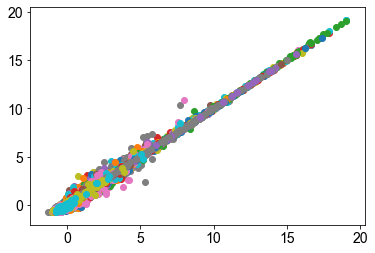

In [110]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [111]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X_nmf)#_nmf)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y_nmf)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572284526637479
0.9975146397417369
0.0010721778036043026 0.007446737378860348
9.572152105915418 376.0
encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.5986, -0.5064, -0.3737,  ..., 11.4562, -0.3272, -0.3452],
        [ 0.9439, -0.4649, -0.3733,  ..., -0.2306, -0.3272, -0.1643],
        [-0.5640,  1.6448, -0.3714,  ..., -0.2396, -0.3272, -0.3452],
        ...,
        [ 1.3256,  0.2144, -0.3737,  ..., -0.1681, -0.0686, -0.3452],
        [-0.4764, -0.5064, -0.3737,  ..., -0.2396, -0.3272,  7.5542],
        [-0.5545, -0.4148, -0.3693,  ..., -0.2396,  1.4193, -0.3452]],
       dtype=torch.float64)
1 iteration
71.63504791259766
2 iteration
67.55561828613281
3 iteration
65.38106536865234
4 iteration
62.809810638427734
5 iteration
61.66556167602539
6 iteration
62.80455017089844
7 iteration
60.53261184692383
8 iteration
59.47920608520508
9 iteration
58.49801254272461
10 iteration
58.05378341674805
11 iteration
57.4264793

38.56357955932617
245 iteration
37.91638946533203
246 iteration
38.14651107788086
247 iteration
37.74449157714844
248 iteration
37.970951080322266
249 iteration
37.63103485107422
250 iteration
37.87618637084961
251 iteration
37.51418685913086
252 iteration
37.73786544799805
253 iteration
37.49066925048828
254 iteration
37.56455612182617
255 iteration
37.47478485107422
256 iteration
37.41297912597656
257 iteration
37.445552825927734
258 iteration
37.33428192138672
259 iteration
37.38288116455078
260 iteration
37.26181411743164
261 iteration
37.33121109008789
262 iteration
37.19398880004883
263 iteration
37.19747543334961
264 iteration
37.18967056274414
265 iteration
37.13051223754883
266 iteration
37.14303970336914
267 iteration
37.09109878540039
268 iteration
37.1237678527832
269 iteration
37.0622673034668
270 iteration
37.1062126159668
271 iteration
37.110321044921875
272 iteration
37.194374084472656
273 iteration
37.312889099121094
274 iteration
37.294193267822266
275 iteration
37.17

35.16055679321289
510 iteration
35.15491485595703
511 iteration
35.132930755615234
512 iteration
35.11526107788086
513 iteration
35.11116027832031
514 iteration
35.215354919433594
515 iteration
35.10704040527344
516 iteration
35.086368560791016
517 iteration
35.00320816040039
518 iteration
35.0045166015625
519 iteration
35.006465911865234
520 iteration
34.978240966796875
521 iteration
34.978702545166016
522 iteration
35.015724182128906
523 iteration
35.307838439941406
524 iteration
36.671722412109375
525 iteration
35.98081970214844
526 iteration
35.61286163330078
527 iteration
36.12141036987305
528 iteration
37.49247741699219
529 iteration
37.04115676879883
530 iteration
37.14832305908203
531 iteration
36.577919006347656
532 iteration
36.823143005371094
533 iteration
36.391693115234375
534 iteration
36.381202697753906
535 iteration
36.25513458251953
536 iteration
36.06277847290039
537 iteration
36.063045501708984
538 iteration
35.89480972290039
539 iteration
35.814605712890625
540 iter

34.411312103271484
778 iteration
34.40172576904297
779 iteration
34.34846115112305
780 iteration
34.31721496582031
781 iteration
34.31815719604492
782 iteration
34.286460876464844
783 iteration
34.264949798583984
784 iteration
34.25944900512695
785 iteration
34.30276870727539
786 iteration
34.373634338378906
787 iteration
34.590415954589844
788 iteration
34.4798698425293
789 iteration
34.467254638671875
790 iteration
34.70037841796875
791 iteration
34.477115631103516
792 iteration
34.3620491027832
793 iteration
34.157310485839844
794 iteration
34.26248550415039
795 iteration
34.5206298828125
796 iteration
34.21223831176758
797 iteration
34.30754089355469
798 iteration
34.438926696777344
799 iteration
34.308868408203125
800 iteration
34.26625061035156
801 iteration
34.25596237182617
802 iteration
34.38155746459961
803 iteration
34.20420455932617
804 iteration
34.248008728027344
805 iteration
34.472625732421875
806 iteration
34.84086227416992
807 iteration
34.598087310791016
808 iteratio

34.47500991821289
1041 iteration
34.59575271606445
1042 iteration
34.43540573120117
1043 iteration
34.433815002441406
1044 iteration
34.52442169189453
1045 iteration
34.35601043701172
1046 iteration
34.342803955078125
1047 iteration
34.45569610595703
1048 iteration
34.211326599121094
1049 iteration
34.33528137207031
1050 iteration
34.36763000488281
1051 iteration
34.24067306518555
1052 iteration
34.240394592285156
1053 iteration
34.16584777832031
1054 iteration
34.23253631591797
1055 iteration
34.26565933227539
1056 iteration
34.17129135131836
1057 iteration
34.1751708984375
1058 iteration
34.12179183959961
1059 iteration
34.17741394042969
1060 iteration
34.04621124267578
1061 iteration
34.062007904052734
1062 iteration
34.052730560302734
1063 iteration
33.99523162841797
1064 iteration
34.00136947631836
1065 iteration
33.97987365722656
1066 iteration
33.95378875732422
1067 iteration
33.997802734375
1068 iteration
34.016849517822266
1069 iteration
34.11149597167969
1070 iteration
33.941

33.929466247558594
1295 iteration
33.897159576416016
1296 iteration
33.4250373840332
1297 iteration
33.83013916015625
1298 iteration
33.271209716796875
1299 iteration
33.650054931640625
1300 iteration
33.2271614074707
1301 iteration
33.516456604003906
1302 iteration
33.24752426147461
1303 iteration
33.3391227722168
1304 iteration
33.21018600463867
1305 iteration
33.230960845947266
1306 iteration
33.16876983642578
1307 iteration
33.115909576416016
1308 iteration
33.13869857788086
1309 iteration
33.040672302246094
1310 iteration
33.0870361328125
1311 iteration
33.0089111328125
1312 iteration
33.10037612915039
1313 iteration
32.965389251708984
1314 iteration
33.00150680541992
1315 iteration
32.95871353149414
1316 iteration
32.979434967041016
1317 iteration
32.93375015258789
1318 iteration
32.9306640625
1319 iteration
32.93779373168945
1320 iteration
32.9058837890625
1321 iteration
32.92723846435547
1322 iteration
32.9780387878418
1323 iteration
33.00214767456055
1324 iteration
33.26284027

32.26947021484375
1547 iteration
32.52891540527344
1548 iteration
32.57160949707031
1549 iteration
33.33694839477539
1550 iteration
32.47659683227539
1551 iteration
32.882469177246094
1552 iteration
33.90632247924805
1553 iteration
33.7329216003418
1554 iteration
41.884193420410156
1555 iteration
41.51997756958008
1556 iteration
40.216407775878906
1557 iteration
39.316993713378906
1558 iteration
39.48514175415039
1559 iteration
38.56378173828125
1560 iteration
38.08982849121094
1561 iteration
37.47035598754883
1562 iteration
37.40022659301758
1563 iteration
36.8780517578125
1564 iteration
36.45765686035156
1565 iteration
36.4365119934082
1566 iteration
36.026451110839844
1567 iteration
35.78968048095703
1568 iteration
35.5397834777832
1569 iteration
35.25221633911133
1570 iteration
35.135013580322266
1571 iteration
34.96745681762695
1572 iteration
34.77853012084961
1573 iteration
34.579856872558594
1574 iteration
34.41792297363281
1575 iteration
34.28605651855469
1576 iteration
34.1408

31.994895935058594
1806 iteration
31.89695930480957
1807 iteration
31.951494216918945
1808 iteration
31.844165802001953
1809 iteration
31.928020477294922
1810 iteration
31.93511390686035
1811 iteration
32.03372573852539
1812 iteration
32.545536041259766
1813 iteration
32.360130310058594
1814 iteration
32.20016098022461
1815 iteration
31.829830169677734
1816 iteration
31.903337478637695
1817 iteration
32.258750915527344
1818 iteration
32.16603088378906
1819 iteration
32.04595947265625
1820 iteration
31.814550399780273
1821 iteration
31.963014602661133
1822 iteration
32.17818832397461
1823 iteration
31.90422821044922
1824 iteration
31.898529052734375
1825 iteration
32.09572982788086
1826 iteration
31.943037033081055
1827 iteration
31.814130783081055
1828 iteration
31.922607421875
1829 iteration
32.09178161621094
1830 iteration
31.847604751586914
1831 iteration
32.63898849487305
1832 iteration
33.18759536743164
1833 iteration
32.336769104003906
1834 iteration
32.573570251464844
1835 itera

32.25735855102539
2056 iteration
32.144317626953125
2057 iteration
32.098777770996094
2058 iteration
32.044795989990234
2059 iteration
31.99138069152832
2060 iteration
31.937761306762695
2061 iteration
31.92928695678711
2062 iteration
31.855192184448242
2063 iteration
31.798385620117188
2064 iteration
31.804950714111328
2065 iteration
31.737756729125977
2066 iteration
31.727571487426758
2067 iteration
31.776914596557617
2068 iteration
31.818321228027344
2069 iteration
32.19163131713867
2070 iteration
31.959823608398438
2071 iteration
31.887304306030273
2072 iteration
31.692598342895508
2073 iteration
31.74983024597168
2074 iteration
31.904403686523438
2075 iteration
31.682708740234375
2076 iteration
31.703821182250977
2077 iteration
31.69075584411621
2078 iteration
31.691734313964844
2079 iteration
31.827953338623047
2080 iteration
31.565580368041992
2081 iteration
31.84292984008789
2082 iteration
32.21049118041992
2083 iteration
31.786670684814453
2084 iteration
32.00101089477539
2085

31.392887115478516
2302 iteration
31.24279022216797
2303 iteration
31.287036895751953
2304 iteration
31.276790618896484
2305 iteration
31.238229751586914
2306 iteration
31.218069076538086
2307 iteration
31.210487365722656
2308 iteration
31.219905853271484
2309 iteration
31.240800857543945
2310 iteration
31.274906158447266
2311 iteration
31.25919532775879
2312 iteration
31.358684539794922
2313 iteration
31.54273796081543
2314 iteration
31.786325454711914
2315 iteration
32.025997161865234
2316 iteration
31.947847366333008
2317 iteration
31.871675491333008
2318 iteration
31.26131820678711
2319 iteration
31.586822509765625
2320 iteration
32.1022834777832
2321 iteration
31.687480926513672
2322 iteration
31.29747772216797
2323 iteration
31.770605087280273
2324 iteration
31.940820693969727
2325 iteration
31.43498992919922
2326 iteration
31.56988525390625
2327 iteration
31.847679138183594
2328 iteration
31.794248580932617
2329 iteration
31.35858154296875
2330 iteration
31.93311882019043
2331 i

37.66835403442383
2556 iteration
37.71083450317383
2557 iteration
37.2523078918457
2558 iteration
36.900390625
2559 iteration
36.79877471923828
2560 iteration
36.46848678588867
2561 iteration
36.35358810424805
2562 iteration
36.10799789428711
2563 iteration
35.86331558227539
2564 iteration
35.78243637084961
2565 iteration
35.58521270751953
2566 iteration
35.3992919921875
2567 iteration
35.2813606262207
2568 iteration
35.12374496459961
2569 iteration
35.04673767089844
2570 iteration
34.91102981567383
2571 iteration
34.791648864746094
2572 iteration
34.6992073059082
2573 iteration
34.597896575927734
2574 iteration
34.49102020263672
2575 iteration
34.43362808227539
2576 iteration
34.35811996459961
2577 iteration
34.2647705078125
2578 iteration
34.1402587890625
2579 iteration
34.11204528808594
2580 iteration
34.03468322753906
2581 iteration
33.985816955566406
2582 iteration
33.93791198730469
2583 iteration
33.852413177490234
2584 iteration
33.81605911254883
2585 iteration
33.74620819091797

31.501148223876953
2803 iteration
31.523944854736328
2804 iteration
31.550989151000977
2805 iteration
31.461565017700195
2806 iteration
31.344196319580078
2807 iteration
31.472145080566406
2808 iteration
31.382089614868164
2809 iteration
31.33172607421875
2810 iteration
31.313453674316406
2811 iteration
31.3172550201416
2812 iteration
31.292102813720703
2813 iteration
31.220609664916992
2814 iteration
31.292516708374023
2815 iteration
31.264841079711914
2816 iteration
31.28339195251465
2817 iteration
31.2305850982666
2818 iteration
31.2353515625
2819 iteration
31.20489501953125
2820 iteration
31.164703369140625
2821 iteration
31.194026947021484
2822 iteration
31.265771865844727
2823 iteration
31.292770385742188
2824 iteration
31.287975311279297
2825 iteration
31.209043502807617
2826 iteration
31.162477493286133
2827 iteration
31.08908462524414
2828 iteration
31.101064682006836
2829 iteration
31.10104751586914
2830 iteration
31.16986656188965
2831 iteration
31.28980827331543
2832 iterat

30.81049156188965
3059 iteration
30.816667556762695
3060 iteration
30.78451156616211
3061 iteration
30.767988204956055
3062 iteration
30.712936401367188
3063 iteration
30.750404357910156
3064 iteration
30.683391571044922
3065 iteration
30.68814468383789
3066 iteration
30.696491241455078
3067 iteration
30.640918731689453
3068 iteration
30.643047332763672
3069 iteration
30.607444763183594
3070 iteration
30.619140625
3071 iteration
30.599319458007812
3072 iteration
30.607393264770508
3073 iteration
30.59699821472168
3074 iteration
30.606868743896484
3075 iteration
30.639732360839844
3076 iteration
30.7608699798584
3077 iteration
30.902481079101562
3078 iteration
31.2536678314209
3079 iteration
31.188587188720703
3080 iteration
30.953798294067383
3081 iteration
30.66055679321289
3082 iteration
30.624378204345703
3083 iteration
30.853235244750977
3084 iteration
30.947877883911133
3085 iteration
30.74103546142578
3086 iteration
30.608795166015625
3087 iteration
30.648530960083008
3088 iterat

31.445350646972656
3312 iteration
30.971559524536133
3313 iteration
31.625415802001953
3314 iteration
30.874839782714844
3315 iteration
32.99502944946289
3316 iteration
38.830875396728516
3317 iteration
37.708927154541016
3318 iteration
41.29409408569336
3319 iteration
40.09598159790039
3320 iteration
39.62721252441406
3321 iteration
38.55597686767578
3322 iteration
37.61237335205078
3323 iteration
37.57714080810547
3324 iteration
36.52738571166992
3325 iteration
36.176536560058594
3326 iteration
35.656925201416016
3327 iteration
35.35771560668945
3328 iteration
35.068603515625
3329 iteration
34.57265090942383
3330 iteration
34.297821044921875
3331 iteration
33.876129150390625
3332 iteration
33.66901397705078
3333 iteration
33.55855941772461
3334 iteration
33.17708969116211
3335 iteration
33.04410934448242
3336 iteration
32.889041900634766
3337 iteration
32.65577697753906
3338 iteration
32.623905181884766
3339 iteration
32.327911376953125
3340 iteration
32.27766418457031
3341 iteration

30.151933670043945
3563 iteration
30.14076805114746
3564 iteration
30.145917892456055
3565 iteration
30.206871032714844
3566 iteration
30.212968826293945
3567 iteration
30.198984146118164
3568 iteration
30.147600173950195
3569 iteration
30.08997344970703
3570 iteration
30.064546585083008
3571 iteration
30.06629180908203
3572 iteration
30.075544357299805
3573 iteration
30.087568283081055
3574 iteration
30.1173038482666
3575 iteration
30.134614944458008
3576 iteration
30.18639373779297
3577 iteration
30.205215454101562
3578 iteration
30.27211570739746
3579 iteration
30.228910446166992
3580 iteration
30.21921157836914
3581 iteration
30.149930953979492
3582 iteration
30.07058334350586
3583 iteration
30.038169860839844
3584 iteration
29.992151260375977
3585 iteration
30.012929916381836
3586 iteration
30.047155380249023
3587 iteration
30.059385299682617
3588 iteration
30.08679962158203
3589 iteration
30.150842666625977
3590 iteration
30.18073844909668
3591 iteration
30.317493438720703
3592 i

29.899808883666992
3819 iteration
29.80466079711914
3820 iteration
29.82549476623535
3821 iteration
29.897323608398438
3822 iteration
30.3378963470459
3823 iteration
30.55769920349121
3824 iteration
31.298145294189453
3825 iteration
30.193405151367188
3826 iteration
30.498977661132812
3827 iteration
31.815034866333008
3828 iteration
30.668596267700195
3829 iteration
31.027135848999023
3830 iteration
31.44692039489746
3831 iteration
30.750843048095703
3832 iteration
31.046051025390625
3833 iteration
30.618146896362305
3834 iteration
30.78287696838379
3835 iteration
30.677507400512695
3836 iteration
30.41681671142578
3837 iteration
30.615442276000977
3838 iteration
30.43332290649414
3839 iteration
30.41261100769043
3840 iteration
30.294193267822266
3841 iteration
30.356504440307617
3842 iteration
30.28911781311035
3843 iteration
30.248987197875977
3844 iteration
30.164316177368164
3845 iteration
30.192975997924805
3846 iteration
30.128170013427734
3847 iteration
30.147672653198242
3848 i

29.936918258666992
4063 iteration
30.126359939575195
4064 iteration
29.923912048339844
4065 iteration
29.956539154052734
4066 iteration
29.95091438293457
4067 iteration
29.896360397338867
4068 iteration
29.907821655273438
4069 iteration
29.9444637298584
4070 iteration
29.812772750854492
4071 iteration
29.882545471191406
4072 iteration
29.76536750793457
4073 iteration
29.745559692382812
4074 iteration
29.775484085083008
4075 iteration
29.665130615234375
4076 iteration
29.730363845825195
4077 iteration
29.691139221191406
4078 iteration
29.6978702545166
4079 iteration
29.721139907836914
4080 iteration
29.71866798400879
4081 iteration
29.833112716674805
4082 iteration
29.799583435058594
4083 iteration
29.968666076660156
4084 iteration
29.78084945678711
4085 iteration
29.708847045898438
4086 iteration
29.64263916015625
4087 iteration
29.65705108642578
4088 iteration
29.723770141601562
4089 iteration
29.69635772705078
4090 iteration
29.733043670654297
4091 iteration
29.72621726989746
4092 it

30.757305145263672
4319 iteration
30.708436965942383
4320 iteration
30.82658576965332
4321 iteration
30.80314826965332
4322 iteration
30.691858291625977
4323 iteration
30.714244842529297
4324 iteration
30.680065155029297
4325 iteration
30.676950454711914
4326 iteration
30.701393127441406
4327 iteration
30.671791076660156
4328 iteration
30.77972412109375
4329 iteration
30.67292594909668
4330 iteration
30.60084342956543
4331 iteration
30.60663414001465
4332 iteration
30.534284591674805
4333 iteration
30.531455993652344
4334 iteration
30.546491622924805
4335 iteration
30.497129440307617
4336 iteration
30.53624725341797
4337 iteration
30.537460327148438
4338 iteration
30.571035385131836
4339 iteration
30.82232666015625
4340 iteration
31.053733825683594
4341 iteration
32.0084342956543
4342 iteration
30.76055908203125
4343 iteration
30.9046688079834
4344 iteration
32.230587005615234
4345 iteration
30.709667205810547
4346 iteration
31.788827896118164
4347 iteration
32.979679107666016
4348 ite

29.96881103515625
4564 iteration
30.061399459838867
4565 iteration
30.231712341308594
4566 iteration
30.094785690307617
4567 iteration
30.145214080810547
4568 iteration
30.128799438476562
4569 iteration
30.3134708404541
4570 iteration
30.47199821472168
4571 iteration
30.275474548339844
4572 iteration
30.229537963867188
4573 iteration
30.033466339111328
4574 iteration
30.205150604248047
4575 iteration
30.3701114654541
4576 iteration
30.093229293823242
4577 iteration
30.223264694213867
4578 iteration
30.327728271484375
4579 iteration
30.315391540527344
4580 iteration
30.201433181762695
4581 iteration
30.277793884277344
4582 iteration
30.118146896362305
4583 iteration
30.39519500732422
4584 iteration
30.519817352294922
4585 iteration
30.0346736907959
4586 iteration
30.686006546020508
4587 iteration
30.847978591918945
4588 iteration
30.30023193359375
4589 iteration
31.397754669189453
4590 iteration
30.984901428222656
4591 iteration
31.053991317749023
4592 iteration
31.204662322998047
4593 

30.07744789123535
4819 iteration
30.056516647338867
4820 iteration
30.03219985961914
4821 iteration
30.0341854095459
4822 iteration
30.032060623168945
4823 iteration
30.015846252441406
4824 iteration
29.979358673095703
4825 iteration
30.00409507751465
4826 iteration
29.984891891479492
4827 iteration
29.96876335144043
4828 iteration
30.001100540161133
4829 iteration
30.06355857849121
4830 iteration
30.132448196411133
4831 iteration
30.1792049407959
4832 iteration
30.339004516601562
4833 iteration
30.366905212402344
4834 iteration
30.76026725769043
4835 iteration
30.5146427154541
4836 iteration
30.486433029174805
4837 iteration
29.93855094909668
4838 iteration
30.28229522705078
4839 iteration
30.846803665161133
4840 iteration
30.05850601196289
4841 iteration
30.48908233642578
4842 iteration
31.45058250427246
4843 iteration
30.127790451049805
4844 iteration
31.35490608215332
4845 iteration
31.7596492767334
4846 iteration
30.91826820373535
4847 iteration
31.289228439331055
4848 iteration
3

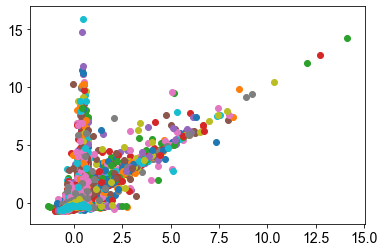

In [112]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [113]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        xnorm = pcaX.fit_transform(normalize(X))#_nmf)
        #scalerX.fit_transform(X)
        ynorm = pcaY.fit_transform(normalize(Y))     
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572384010623478
0.997514617235397
0.0010721778034586823 0.007446737378860348
9.485898676886242 376.0
encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-3.1612, -0.2804, -3.9011,  ...,  0.0448,  0.5514, -0.3893],
        [-2.0752, -1.4576, -0.3357,  ..., -0.4812, -0.5864, -0.2578],
        [-3.8014, -0.2415, -2.3285,  ...,  0.0294,  1.1321, -1.6043],
        ...,
        [-3.7765,  1.0679, -1.3977,  ..., -0.3819, -0.4738,  0.2030],
        [ 0.0540,  2.8233, -3.1243,  ..., -0.7412,  0.0824, -0.0128],
        [-0.6900, -0.3226,  4.3282,  ...,  0.1382, -0.3638,  0.5967]],
       dtype=torch.float64)
1 iteration
581.751220703125
2 iteration
570.56103515625
3 iteration
563.001220703125
4 iteration
558.7313842773438
5 iteration
551.2653198242188
6 iteration
540.895751953125
7 iteration
532.2743530273438
8 iteration
521.899658203125
9 iteration
514.7487182617188
10 iteration
508.5423583984375
11 iteration
499.2934265136719


131.97828674316406
238 iteration
128.8442840576172
239 iteration
131.3290557861328
240 iteration
129.69802856445312
241 iteration
126.97328186035156
242 iteration
125.86458587646484
243 iteration
129.27880859375
244 iteration
127.16859436035156
245 iteration
124.38273620605469
246 iteration
124.57311248779297
247 iteration
124.23194122314453
248 iteration
122.01518249511719
249 iteration
121.47396850585938
250 iteration
123.13544464111328
251 iteration
122.23137664794922
252 iteration
119.30892944335938
253 iteration
119.58234405517578
254 iteration
119.5054702758789
255 iteration
120.0709228515625
256 iteration
118.90991973876953
257 iteration
120.09925842285156
258 iteration
119.83074188232422
259 iteration
118.04234313964844
260 iteration
117.33894348144531
261 iteration
115.01151275634766
262 iteration
116.27928161621094
263 iteration
114.34745788574219
264 iteration
115.953857421875
265 iteration
120.48625183105469
266 iteration
124.06907653808594
267 iteration
125.64370727539062


93.1721420288086
497 iteration
90.23802185058594
498 iteration
89.256103515625
499 iteration
91.8489990234375
500 iteration
92.3431396484375
501 iteration
95.54444885253906
502 iteration
89.56452178955078
503 iteration
94.72362518310547
504 iteration
98.70230102539062
505 iteration
100.10235595703125
506 iteration
96.99368286132812
507 iteration
95.20272827148438
508 iteration
89.6574478149414
509 iteration
90.45606994628906
510 iteration
88.22593688964844
511 iteration
86.23572540283203
512 iteration
85.47417449951172
513 iteration
84.38001251220703
514 iteration
82.52969360351562
515 iteration
82.17815399169922
516 iteration
80.68959045410156
517 iteration
79.82605743408203
518 iteration
79.05648040771484
519 iteration
78.34008026123047
520 iteration
78.29138946533203
521 iteration
77.11101531982422
522 iteration
76.98440551757812
523 iteration
76.16853332519531
524 iteration
75.07428741455078
525 iteration
74.4430923461914
526 iteration
73.93547821044922
527 iteration
73.33898162841

62.160057067871094
761 iteration
59.15251159667969
762 iteration
56.64036560058594
763 iteration
55.81611251831055
764 iteration
58.7790412902832
765 iteration
66.79130554199219
766 iteration
66.32890319824219
767 iteration
63.775794982910156
768 iteration
57.51900863647461
769 iteration
57.405216217041016
770 iteration
61.53019714355469
771 iteration
60.6314582824707
772 iteration
59.63376998901367
773 iteration
58.755714416503906
774 iteration
62.224334716796875
775 iteration
66.8296890258789
776 iteration
58.72412872314453
777 iteration
60.3055419921875
778 iteration
71.11734008789062
779 iteration
75.662353515625
780 iteration
70.05999755859375
781 iteration
79.01152038574219
782 iteration
83.2953872680664
783 iteration
73.6190185546875
784 iteration
78.14717864990234
785 iteration
72.31620025634766
786 iteration
71.11776733398438
787 iteration
71.72766876220703
788 iteration
67.80756378173828
789 iteration
67.57113647460938
790 iteration
67.9618911743164
791 iteration
76.042808532

46.83038330078125
1026 iteration
47.39735794067383
1027 iteration
48.57878875732422
1028 iteration
48.645286560058594
1029 iteration
48.336368560791016
1030 iteration
46.90412902832031
1031 iteration
45.67881774902344
1032 iteration
45.30268096923828
1033 iteration
45.808555603027344
1034 iteration
46.55026626586914
1035 iteration
47.00941467285156
1036 iteration
48.95754623413086
1037 iteration
50.42168426513672
1038 iteration
51.411006927490234
1039 iteration
49.66873550415039
1040 iteration
46.230918884277344
1041 iteration
45.956661224365234
1042 iteration
48.15850830078125
1043 iteration
48.109153747558594
1044 iteration
48.22977828979492
1045 iteration
45.508670806884766
1046 iteration
45.629737854003906
1047 iteration
48.529327392578125
1048 iteration
48.65266418457031
1049 iteration
48.6873664855957
1050 iteration
48.882694244384766
1051 iteration
45.61495590209961
1052 iteration
46.67110824584961
1053 iteration
50.373069763183594
1054 iteration
49.808353424072266
1055 iteratio

65.78313446044922
1277 iteration
65.0737075805664
1278 iteration
64.77208709716797
1279 iteration
59.84407424926758
1280 iteration
60.992225646972656
1281 iteration
57.36258316040039
1282 iteration
56.7890739440918
1283 iteration
55.888099670410156
1284 iteration
53.16731262207031
1285 iteration
54.30608367919922
1286 iteration
50.43226623535156
1287 iteration
51.283241271972656
1288 iteration
50.184326171875
1289 iteration
49.196746826171875
1290 iteration
48.328330993652344
1291 iteration
47.041996002197266
1292 iteration
46.31490707397461
1293 iteration
46.19083786010742
1294 iteration
46.544822692871094
1295 iteration
45.63225173950195
1296 iteration
45.66630935668945
1297 iteration
44.57469940185547
1298 iteration
43.685543060302734
1299 iteration
43.7072868347168
1300 iteration
43.10875701904297
1301 iteration
43.23507308959961
1302 iteration
43.245418548583984
1303 iteration
43.0110969543457
1304 iteration
43.495792388916016
1305 iteration
43.74267578125
1306 iteration
43.560535

39.68632507324219
1529 iteration
39.48122787475586
1530 iteration
40.275455474853516
1531 iteration
40.15052795410156
1532 iteration
39.81448745727539
1533 iteration
37.72161865234375
1534 iteration
37.826507568359375
1535 iteration
39.489952087402344
1536 iteration
40.39266586303711
1537 iteration
40.079833984375
1538 iteration
40.72830581665039
1539 iteration
42.2083854675293
1540 iteration
45.62627029418945
1541 iteration
45.00751876831055
1542 iteration
43.13518142700195
1543 iteration
39.92441940307617
1544 iteration
39.27253723144531
1545 iteration
40.3633918762207
1546 iteration
40.337562561035156
1547 iteration
41.123470306396484
1548 iteration
40.582275390625
1549 iteration
40.011802673339844
1550 iteration
39.3544807434082
1551 iteration
40.33879089355469
1552 iteration
42.75069808959961
1553 iteration
42.2569580078125
1554 iteration
42.22886657714844
1555 iteration
41.72468185424805
1556 iteration
41.0179557800293
1557 iteration
41.00082778930664
1558 iteration
41.0565414428

41.59908676147461
1781 iteration
41.5821533203125
1782 iteration
41.031307220458984
1783 iteration
40.61853790283203
1784 iteration
40.39162063598633
1785 iteration
40.06020736694336
1786 iteration
39.68340301513672
1787 iteration
39.534759521484375
1788 iteration
39.28782653808594
1789 iteration
39.244571685791016
1790 iteration
38.99620056152344
1791 iteration
38.934959411621094
1792 iteration
38.78318786621094
1793 iteration
38.419586181640625
1794 iteration
38.070281982421875
1795 iteration
37.73146057128906
1796 iteration
37.589229583740234
1797 iteration
37.8959846496582
1798 iteration
37.2378044128418
1799 iteration
36.96009826660156
1800 iteration
36.734310150146484
1801 iteration
37.099517822265625
1802 iteration
37.84846496582031
1803 iteration
39.62343978881836
1804 iteration
42.205692291259766
1805 iteration
43.61991882324219
1806 iteration
41.22573471069336
1807 iteration
37.30995178222656
1808 iteration
37.103782653808594
1809 iteration
39.96900177001953
1810 iteration
40

49.28030014038086
2032 iteration
57.00832748413086
2033 iteration
54.05342102050781
2034 iteration
58.56122970581055
2035 iteration
51.363731384277344
2036 iteration
52.01755905151367
2037 iteration
52.68367004394531
2038 iteration
51.09782028198242
2039 iteration
48.76886749267578
2040 iteration
45.70060729980469
2041 iteration
47.125431060791016
2042 iteration
45.839839935302734
2043 iteration
43.26749801635742
2044 iteration
43.98003005981445
2045 iteration
45.0306282043457
2046 iteration
41.94259262084961
2047 iteration
43.00711441040039
2048 iteration
43.57865524291992
2049 iteration
40.75125503540039
2050 iteration
43.16804885864258
2051 iteration
40.220008850097656
2052 iteration
38.54966735839844
2053 iteration
40.88554000854492
2054 iteration
38.21722412109375
2055 iteration
37.13918685913086
2056 iteration
38.052955627441406
2057 iteration
37.41200256347656
2058 iteration
36.510868072509766
2059 iteration
37.1800651550293
2060 iteration
37.4478645324707
2061 iteration
36.0784

41.57700729370117
2287 iteration
38.566505432128906
2288 iteration
39.23933410644531
2289 iteration
43.087913513183594
2290 iteration
40.106388092041016
2291 iteration
42.80377197265625
2292 iteration
44.30355453491211
2293 iteration
36.77951431274414
2294 iteration
40.852455139160156
2295 iteration
42.859134674072266
2296 iteration
39.611572265625
2297 iteration
44.4117317199707
2298 iteration
45.53626251220703
2299 iteration
51.74248504638672
2300 iteration
49.72624969482422
2301 iteration
44.67771530151367
2302 iteration
48.234561920166016
2303 iteration
46.63669204711914
2304 iteration
46.02836608886719
2305 iteration
44.8608283996582
2306 iteration
46.00115966796875
2307 iteration
41.67329025268555
2308 iteration
42.50093078613281
2309 iteration
42.619815826416016
2310 iteration
46.018455505371094
2311 iteration
43.18403625488281
2312 iteration
40.532325744628906
2313 iteration
40.22309494018555
2314 iteration
40.38490295410156
2315 iteration
40.6381721496582
2316 iteration
40.812

32.4490966796875
2539 iteration
32.41803741455078
2540 iteration
32.7244873046875
2541 iteration
32.4293212890625
2542 iteration
32.916934967041016
2543 iteration
33.68535232543945
2544 iteration
33.94215393066406
2545 iteration
34.588294982910156
2546 iteration
36.60867691040039
2547 iteration
34.77811050415039
2548 iteration
32.87126541137695
2549 iteration
33.71728515625
2550 iteration
35.5234375
2551 iteration
37.15458679199219
2552 iteration
35.783241271972656
2553 iteration
32.796546936035156
2554 iteration
32.30989456176758
2555 iteration
32.74109649658203
2556 iteration
34.97572708129883
2557 iteration
33.615081787109375
2558 iteration
32.96358871459961
2559 iteration
34.003849029541016
2560 iteration
34.158695220947266
2561 iteration
33.494815826416016
2562 iteration
33.75478744506836
2563 iteration
33.34930419921875
2564 iteration
32.411258697509766
2565 iteration
32.01498794555664
2566 iteration
32.638492584228516
2567 iteration
33.077579498291016
2568 iteration
31.774166107

32.6878662109375
2785 iteration
32.762142181396484
2786 iteration
32.733455657958984
2787 iteration
32.86906051635742
2788 iteration
31.032649993896484
2789 iteration
30.328075408935547
2790 iteration
31.03696632385254
2791 iteration
31.98871421813965
2792 iteration
31.716175079345703
2793 iteration
30.46661376953125
2794 iteration
31.06554412841797
2795 iteration
30.966428756713867
2796 iteration
30.881412506103516
2797 iteration
30.41262435913086
2798 iteration
30.639280319213867
2799 iteration
32.17688751220703
2800 iteration
31.21379852294922
2801 iteration
30.699804306030273
2802 iteration
30.877666473388672
2803 iteration
31.121341705322266
2804 iteration
30.018186569213867
2805 iteration
29.6977596282959
2806 iteration
29.364810943603516
2807 iteration
28.9993953704834
2808 iteration
29.581031799316406
2809 iteration
30.788124084472656
2810 iteration
33.664493560791016
2811 iteration
34.01637268066406
2812 iteration
33.505069732666016
2813 iteration
32.175437927246094
2814 itera

29.218238830566406
3034 iteration
28.882030487060547
3035 iteration
28.88201904296875
3036 iteration
29.18787384033203
3037 iteration
29.2680606842041
3038 iteration
30.17658233642578
3039 iteration
29.430492401123047
3040 iteration
29.01407814025879
3041 iteration
27.938936233520508
3042 iteration
27.90806007385254
3043 iteration
29.13018798828125
3044 iteration
30.313081741333008
3045 iteration
30.843643188476562
3046 iteration
31.253389358520508
3047 iteration
29.83909797668457
3048 iteration
28.141794204711914
3049 iteration
28.212940216064453
3050 iteration
29.33770751953125
3051 iteration
30.3738956451416
3052 iteration
31.19847297668457
3053 iteration
30.93060302734375
3054 iteration
30.0624942779541
3055 iteration
29.3577823638916
3056 iteration
29.51302719116211
3057 iteration
28.970569610595703
3058 iteration
28.155332565307617
3059 iteration
29.71783447265625
3060 iteration
32.309226989746094
3061 iteration
33.89740753173828
3062 iteration
33.305908203125
3063 iteration
31.4

28.664628982543945
3282 iteration
30.28696632385254
3283 iteration
29.445201873779297
3284 iteration
29.242473602294922
3285 iteration
29.62066078186035
3286 iteration
29.976152420043945
3287 iteration
28.91250991821289
3288 iteration
28.525957107543945
3289 iteration
30.156923294067383
3290 iteration
30.709196090698242
3291 iteration
29.778196334838867
3292 iteration
29.482738494873047
3293 iteration
29.28844451904297
3294 iteration
28.81534767150879
3295 iteration
28.118236541748047
3296 iteration
28.54530906677246
3297 iteration
28.93707275390625
3298 iteration
28.805673599243164
3299 iteration
27.837265014648438
3300 iteration
28.218711853027344
3301 iteration
27.890371322631836
3302 iteration
28.00163459777832
3303 iteration
28.623384475708008
3304 iteration
28.618417739868164
3305 iteration
28.29330062866211
3306 iteration
28.22449493408203
3307 iteration
28.064714431762695
3308 iteration
27.80461311340332
3309 iteration
28.670169830322266
3310 iteration
28.561532974243164
3311 i

27.92882537841797
3537 iteration
27.013683319091797
3538 iteration
25.727548599243164
3539 iteration
25.7457275390625
3540 iteration
27.933597564697266
3541 iteration
29.570051193237305
3542 iteration
29.349348068237305
3543 iteration
29.700489044189453
3544 iteration
31.45546531677246
3545 iteration
32.437103271484375
3546 iteration
32.44050979614258
3547 iteration
30.598716735839844
3548 iteration
29.818763732910156
3549 iteration
32.31914520263672
3550 iteration
35.91050338745117
3551 iteration
34.2352294921875
3552 iteration
33.23225402832031
3553 iteration
37.16072082519531
3554 iteration
34.24749755859375
3555 iteration
37.96580123901367
3556 iteration
37.624473571777344
3557 iteration
34.19720458984375
3558 iteration
35.87686538696289
3559 iteration
37.290245056152344
3560 iteration
37.992069244384766
3561 iteration
36.03374481201172
3562 iteration
36.92588424682617
3563 iteration
34.93986892700195
3564 iteration
34.23099136352539
3565 iteration
33.09085464477539
3566 iteration


26.523609161376953
3792 iteration
25.605518341064453
3793 iteration
25.040725708007812
3794 iteration
25.02349281311035
3795 iteration
25.48943328857422
3796 iteration
26.223859786987305
3797 iteration
27.450305938720703
3798 iteration
28.871862411499023
3799 iteration
29.100435256958008
3800 iteration
28.27764892578125
3801 iteration
26.648521423339844
3802 iteration
25.34003448486328
3803 iteration
25.044782638549805
3804 iteration
26.41795539855957
3805 iteration
28.013731002807617
3806 iteration
28.9611759185791
3807 iteration
28.121265411376953
3808 iteration
26.287616729736328
3809 iteration
24.887969970703125
3810 iteration
25.48781394958496
3811 iteration
26.958295822143555
3812 iteration
27.51803970336914
3813 iteration
27.167984008789062
3814 iteration
25.672901153564453
3815 iteration
25.28411865234375
3816 iteration
25.991073608398438
3817 iteration
27.010723114013672
3818 iteration
27.95736312866211
3819 iteration
27.485071182250977
3820 iteration
25.56423568725586
3821 it

26.24202537536621
4036 iteration
26.766658782958984
4037 iteration
28.287551879882812
4038 iteration
27.466995239257812
4039 iteration
25.749723434448242
4040 iteration
25.1503849029541
4041 iteration
25.59095001220703
4042 iteration
26.79097557067871
4043 iteration
27.17497444152832
4044 iteration
27.696624755859375
4045 iteration
27.30219268798828
4046 iteration
27.81534767150879
4047 iteration
29.089107513427734
4048 iteration
30.874143600463867
4049 iteration
29.901592254638672
4050 iteration
27.867937088012695
4051 iteration
27.12441062927246
4052 iteration
28.305126190185547
4053 iteration
30.28346061706543
4054 iteration
30.031511306762695
4055 iteration
26.875913619995117
4056 iteration
25.378881454467773
4057 iteration
27.62847900390625
4058 iteration
28.362363815307617
4059 iteration
26.968997955322266
4060 iteration
25.872398376464844
4061 iteration
25.965238571166992
4062 iteration
26.57676887512207
4063 iteration
27.22884178161621
4064 iteration
27.682580947875977
4065 ite

28.267471313476562
4285 iteration
29.50534439086914
4286 iteration
26.141454696655273
4287 iteration
26.218582153320312
4288 iteration
26.284929275512695
4289 iteration
25.24366569519043
4290 iteration
26.276514053344727
4291 iteration
25.415498733520508
4292 iteration
26.293107986450195
4293 iteration
26.134244918823242
4294 iteration
24.9173526763916
4295 iteration
25.16238021850586
4296 iteration
24.42806625366211
4297 iteration
24.666236877441406
4298 iteration
25.455591201782227
4299 iteration
25.214149475097656
4300 iteration
25.81068992614746
4301 iteration
25.361915588378906
4302 iteration
24.675552368164062
4303 iteration
24.877368927001953
4304 iteration
23.85550880432129
4305 iteration
23.620378494262695
4306 iteration
24.0122013092041
4307 iteration
24.2401065826416
4308 iteration
24.7233943939209
4309 iteration
25.38544464111328
4310 iteration
26.724660873413086
4311 iteration
26.621543884277344
4312 iteration
26.59821128845215
4313 iteration
24.911272048950195
4314 iterat

26.395353317260742
4537 iteration
27.381298065185547
4538 iteration
26.456392288208008
4539 iteration
25.255035400390625
4540 iteration
23.6901798248291
4541 iteration
23.201284408569336
4542 iteration
24.43777084350586
4543 iteration
25.510499954223633
4544 iteration
25.73107147216797
4545 iteration
25.362001419067383
4546 iteration
25.235950469970703
4547 iteration
24.82232666015625
4548 iteration
24.89375877380371
4549 iteration
25.341703414916992
4550 iteration
26.08681869506836
4551 iteration
26.79340171813965
4552 iteration
27.08595085144043
4553 iteration
26.442352294921875
4554 iteration
26.08928871154785
4555 iteration
26.20923614501953
4556 iteration
26.1754093170166
4557 iteration
25.615985870361328
4558 iteration
24.910152435302734
4559 iteration
24.939485549926758
4560 iteration
25.201236724853516
4561 iteration
26.0244197845459
4562 iteration
26.624271392822266
4563 iteration
26.454917907714844
4564 iteration
24.85285186767578
4565 iteration
23.785627365112305
4566 iterat

24.90317153930664
4792 iteration
24.419925689697266
4793 iteration
24.386796951293945
4794 iteration
24.319486618041992
4795 iteration
23.987348556518555
4796 iteration
24.53078269958496
4797 iteration
24.721952438354492
4798 iteration
25.236007690429688
4799 iteration
25.553504943847656
4800 iteration
24.57716941833496
4801 iteration
23.708702087402344
4802 iteration
23.151159286499023
4803 iteration
22.945768356323242
4804 iteration
23.203872680664062
4805 iteration
23.571483612060547
4806 iteration
23.59532356262207
4807 iteration
23.3472900390625
4808 iteration
23.695051193237305
4809 iteration
23.680768966674805
4810 iteration
23.7193546295166
4811 iteration
23.84000587463379
4812 iteration
23.284143447875977
4813 iteration
22.697969436645508
4814 iteration
22.37141990661621
4815 iteration
22.30936050415039
4816 iteration
22.825664520263672
4817 iteration
22.8873233795166
4818 iteration
23.308731079101562
4819 iteration
24.517202377319336
4820 iteration
25.248865127563477
4821 ite

(-10, 10)

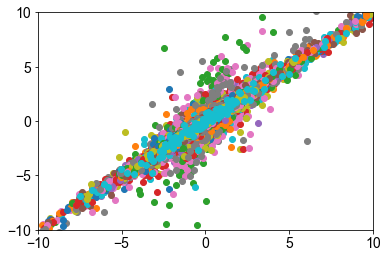

In [115]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
plt.xlim(-10,10)
plt.ylim(-10,10)

In [118]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        x_nmf = nmfX.fit_transform(X)
         
        y_nmf = nmfY.fit_transform(Y)
        x_in = scalerX.fit_transform(x_nmf)
        y_in = scalerY.fit_transform(y_nmf)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = pcaY.fit_transform(normalize(Y))     
        
        
        an = anndata.AnnData(x_in)
        an.Y= y_in
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572359513763298
0.9975135057682984
0.0010721778033264343 0.007446737378860348
9.546461046393148 376.0
encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-5.9983e-01, -5.0670e-01, -3.5860e-01,  ..., -2.3616e-01,
         -3.2714e-01, -3.4548e-01],
        [ 8.2249e-01, -4.9303e-01,  3.9713e+00,  ..., -2.3812e-01,
         -3.2714e-01, -3.4548e-01],
        [-5.9983e-01, -5.0004e-01, -3.7384e-01,  ..., -2.3963e-01,
         -2.1663e-01, -3.4548e-01],
        ...,
        [-6.4022e-04, -5.0670e-01, -3.7384e-01,  ..., -2.3963e-01,
         -3.2714e-01, -8.2169e-02],
        [ 3.2948e-01, -5.0378e-01,  2.9951e+00,  ..., -2.3472e-01,
         -3.2714e-01, -3.4548e-01],
        [-5.9232e-01, -5.0670e-01,  4.3556e-01,  ..., -2.3963e-01,
         -1.5702e-01, -3.4548e-01]], dtype=torch.float64)
1 iteration
71.34202575683594
2 iteration
66.5655288696289
3 iteration
64.96513366699219
4 iteration
63.80538558959961
5 iteration
61.

37.26766586303711
242 iteration
37.207157135009766
243 iteration
37.32495880126953
244 iteration
36.9222297668457
245 iteration
37.22527313232422
246 iteration
36.82377624511719
247 iteration
36.955177307128906
248 iteration
36.76398849487305
249 iteration
36.83387756347656
250 iteration
36.706687927246094
251 iteration
36.724151611328125
252 iteration
36.57652282714844
253 iteration
36.66680145263672
254 iteration
36.47755813598633
255 iteration
36.59757995605469
256 iteration
36.44108581542969
257 iteration
36.497886657714844
258 iteration
36.38260269165039
259 iteration
36.41876220703125
260 iteration
36.326560974121094
261 iteration
36.34650802612305
262 iteration
36.33500671386719
263 iteration
36.3027229309082
264 iteration
36.29993438720703
265 iteration
36.32636260986328
266 iteration
36.41484451293945
267 iteration
36.616573333740234
268 iteration
36.593624114990234
269 iteration
36.611473083496094
270 iteration
36.402198791503906
271 iteration
36.480552673339844
272 iteration

34.5322151184082
498 iteration
34.59148025512695
499 iteration
34.513145446777344
500 iteration
34.48133850097656
501 iteration
34.48947525024414
502 iteration
34.48838806152344
503 iteration
34.4848518371582
504 iteration
34.5421028137207
505 iteration
34.53318405151367
506 iteration
34.61103820800781
507 iteration
34.6700439453125
508 iteration
34.637088775634766
509 iteration
35.10297775268555
510 iteration
35.21461486816406
511 iteration
37.73807144165039
512 iteration
36.11808776855469
513 iteration
38.51591110229492
514 iteration
38.80742645263672
515 iteration
41.40871047973633
516 iteration
37.423133850097656
517 iteration
38.949554443359375
518 iteration
37.95156478881836
519 iteration
38.193546295166016
520 iteration
37.2542724609375
521 iteration
37.142677307128906
522 iteration
37.36246109008789
523 iteration
36.913124084472656
524 iteration
36.63939666748047
525 iteration
36.55274200439453
526 iteration
36.51750183105469
527 iteration
36.14427947998047
528 iteration
36.133

36.39729309082031
753 iteration
36.25000762939453
754 iteration
35.39460754394531
755 iteration
35.82746887207031
756 iteration
35.55113220214844
757 iteration
35.605491638183594
758 iteration
35.565147399902344
759 iteration
35.48686981201172
760 iteration
34.81111145019531
761 iteration
34.835304260253906
762 iteration
35.007469177246094
763 iteration
34.6918830871582
764 iteration
34.76640701293945
765 iteration
34.50465774536133
766 iteration
34.52363204956055
767 iteration
34.37252426147461
768 iteration
34.37660217285156
769 iteration
34.20522689819336
770 iteration
34.25067138671875
771 iteration
34.10999298095703
772 iteration
34.083248138427734
773 iteration
34.044166564941406
774 iteration
33.96562576293945
775 iteration
33.983577728271484
776 iteration
33.903900146484375
777 iteration
33.86134719848633
778 iteration
33.87024688720703
779 iteration
33.7801628112793
780 iteration
33.76617431640625
781 iteration
33.77794647216797
782 iteration
33.72649002075195
783 iteration
33

33.66691207885742
1013 iteration
33.206787109375
1014 iteration
33.44241714477539
1015 iteration
33.97069549560547
1016 iteration
33.22459030151367
1017 iteration
34.564849853515625
1018 iteration
34.99304962158203
1019 iteration
36.757568359375
1020 iteration
37.228118896484375
1021 iteration
37.346290588378906
1022 iteration
35.541202545166016
1023 iteration
35.81953430175781
1024 iteration
36.10343551635742
1025 iteration
35.28491973876953
1026 iteration
35.386173248291016
1027 iteration
35.22190475463867
1028 iteration
34.97438430786133
1029 iteration
34.73575210571289
1030 iteration
34.643394470214844
1031 iteration
34.5700798034668
1032 iteration
34.476165771484375
1033 iteration
34.27439880371094
1034 iteration
34.26185607910156
1035 iteration
34.11997604370117
1036 iteration
33.9697151184082
1037 iteration
33.928985595703125
1038 iteration
33.82864761352539
1039 iteration
33.791316986083984
1040 iteration
33.728763580322266
1041 iteration
33.655941009521484
1042 iteration
33.56

38.68434143066406
1266 iteration
38.76984405517578
1267 iteration
38.5273551940918
1268 iteration
38.6062126159668
1269 iteration
38.46335220336914
1270 iteration
38.439693450927734
1271 iteration
38.34575271606445
1272 iteration
38.26677322387695
1273 iteration
38.20115280151367
1274 iteration
38.14760208129883
1275 iteration
38.08525848388672
1276 iteration
38.00692367553711
1277 iteration
37.994483947753906
1278 iteration
37.88723373413086
1279 iteration
37.850379943847656
1280 iteration
37.821346282958984
1281 iteration
37.801612854003906
1282 iteration
37.726131439208984
1283 iteration
37.7053108215332
1284 iteration
37.645721435546875
1285 iteration
37.61180114746094
1286 iteration
37.582115173339844
1287 iteration
37.5173454284668
1288 iteration
37.50835037231445
1289 iteration
37.43470764160156
1290 iteration
37.41727066040039
1291 iteration
37.385311126708984
1292 iteration
37.35932922363281
1293 iteration
37.30423355102539
1294 iteration
37.27802276611328
1295 iteration
37.21

35.28384017944336
1516 iteration
34.84485626220703
1517 iteration
34.78836441040039
1518 iteration
34.9702262878418
1519 iteration
34.92707824707031
1520 iteration
34.7247200012207
1521 iteration
35.04533767700195
1522 iteration
35.508548736572266
1523 iteration
35.45866775512695
1524 iteration
35.15776062011719
1525 iteration
35.0676383972168
1526 iteration
35.15619659423828
1527 iteration
34.970497131347656
1528 iteration
34.87890625
1529 iteration
34.9154052734375
1530 iteration
34.78822708129883
1531 iteration
34.87934112548828
1532 iteration
34.75052261352539
1533 iteration
34.721435546875
1534 iteration
34.64100646972656
1535 iteration
34.6252326965332
1536 iteration
34.60755157470703
1537 iteration
34.695011138916016
1538 iteration
34.85780715942383
1539 iteration
35.12995910644531
1540 iteration
34.667423248291016
1541 iteration
35.006004333496094
1542 iteration
35.80084991455078
1543 iteration
35.91252136230469
1544 iteration
35.03248596191406
1545 iteration
35.68251037597656


33.709022521972656
1773 iteration
33.731056213378906
1774 iteration
33.53813552856445
1775 iteration
33.61338806152344
1776 iteration
33.5157585144043
1777 iteration
33.6348876953125
1778 iteration
33.701602935791016
1779 iteration
33.62392044067383
1780 iteration
33.72202682495117
1781 iteration
33.59931945800781
1782 iteration
33.576515197753906
1783 iteration
33.540653228759766
1784 iteration
33.553836822509766
1785 iteration
33.64006042480469
1786 iteration
33.734458923339844
1787 iteration
33.708892822265625
1788 iteration
33.718116760253906
1789 iteration
33.565818786621094
1790 iteration
33.65890121459961
1791 iteration
33.79859161376953
1792 iteration
33.5997200012207
1793 iteration
33.81990432739258
1794 iteration
34.251033782958984
1795 iteration
34.37923812866211
1796 iteration
34.524681091308594
1797 iteration
34.84321212768555
1798 iteration
34.266937255859375
1799 iteration
34.377750396728516
1800 iteration
34.342384338378906
1801 iteration
34.69330978393555
1802 iteratio

34.187923431396484
2027 iteration
34.23407745361328
2028 iteration
33.953155517578125
2029 iteration
33.983150482177734
2030 iteration
33.841800689697266
2031 iteration
33.75839614868164
2032 iteration
33.70280838012695
2033 iteration
33.665504455566406
2034 iteration
33.544822692871094
2035 iteration
33.52275085449219
2036 iteration
33.54034423828125
2037 iteration
33.406211853027344
2038 iteration
33.44207000732422
2039 iteration
33.33089828491211
2040 iteration
33.34762191772461
2041 iteration
33.2789306640625
2042 iteration
33.28514099121094
2043 iteration
33.29755783081055
2044 iteration
33.186126708984375
2045 iteration
33.22335433959961
2046 iteration
33.20111083984375
2047 iteration
33.22038269042969
2048 iteration
33.1092414855957
2049 iteration
33.27183151245117
2050 iteration
33.30264663696289
2051 iteration
33.166015625
2052 iteration
33.19683837890625
2053 iteration
33.217166900634766
2054 iteration
33.346370697021484
2055 iteration
33.02475357055664
2056 iteration
33.1678

32.4693603515625
2280 iteration
32.62179183959961
2281 iteration
32.727848052978516
2282 iteration
32.8067741394043
2283 iteration
33.00376892089844
2284 iteration
32.9404182434082
2285 iteration
33.22441482543945
2286 iteration
34.57353210449219
2287 iteration
35.56393051147461
2288 iteration
34.78710174560547
2289 iteration
36.17959213256836
2290 iteration
35.816307067871094
2291 iteration
35.14696502685547
2292 iteration
34.716609954833984
2293 iteration
35.167293548583984
2294 iteration
34.45520782470703
2295 iteration
34.31514358520508
2296 iteration
34.30683517456055
2297 iteration
34.093177795410156
2298 iteration
34.11759948730469
2299 iteration
33.554988861083984
2300 iteration
33.89625549316406
2301 iteration
33.55259704589844
2302 iteration
33.49195098876953
2303 iteration
33.37208557128906
2304 iteration
33.420127868652344
2305 iteration
33.22123336791992
2306 iteration
33.25297164916992
2307 iteration
33.0675163269043
2308 iteration
33.13908386230469
2309 iteration
32.9445

32.516845703125
2531 iteration
32.23258972167969
2532 iteration
32.43703079223633
2533 iteration
32.59990310668945
2534 iteration
32.533180236816406
2535 iteration
32.5217399597168
2536 iteration
32.30162811279297
2537 iteration
32.49971389770508
2538 iteration
32.43179702758789
2539 iteration
32.531925201416016
2540 iteration
32.57134246826172
2541 iteration
32.90901565551758
2542 iteration
32.73267364501953
2543 iteration
32.63499450683594
2544 iteration
32.34364700317383
2545 iteration
32.48883819580078
2546 iteration
32.2813606262207
2547 iteration
32.30476760864258
2548 iteration
32.281742095947266
2549 iteration
32.35626983642578
2550 iteration
32.37247085571289
2551 iteration
32.33130645751953
2552 iteration
32.29519271850586
2553 iteration
32.317813873291016
2554 iteration
32.22650146484375
2555 iteration
32.36540222167969
2556 iteration
32.50003433227539
2557 iteration
32.627105712890625
2558 iteration
32.61116409301758
2559 iteration
32.59518051147461
2560 iteration
32.375045

KeyboardInterrupt: 

(-10, 10)

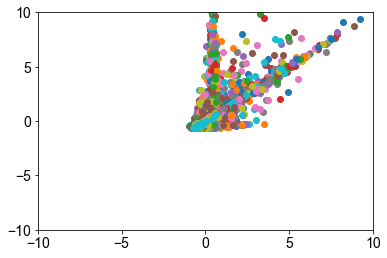

In [119]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
plt.xlim(-10,10)
plt.ylim(-10,10)

In [121]:
lesses=  np.zeros(300)
for i in range(300):
    lesses[i] = get_loss_paper(nmfY.inverse_transform(scalerY.inverse_transform(recon_x.detach().numpy()[i])), 
                                (nmfY.inverse_transform(scalerY.inverse_transform(y.detach().numpy()[i]))))

In [123]:
np.nanmean(lesses)

0.4781797585144414

In [124]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        x_nmf = nmfX.fit_transform(X)
         
        y_nmf = nmfY.fit_transform(Y)
        x_in = scalerX.fit_transform(x_nmf)
        y_in = scalerY.fit_transform(y_nmf)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = pcaY.fit_transform(normalize(Y))     
        
        
        an = anndata.AnnData(x_nmf)
        an.Y= y_nmf
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.857234524792608
0.9975131742719295
0.0010721778030750235 0.007446737378860348
9.561210829219627 376.0
encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[0.0000e+00, 2.3145e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.6500e-02, 4.9212e-02, 1.3358e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5099e-02, 0.0000e+00, 4.4020e-01,  ..., 2.0760e-04, 7.2743e-03,
         0.0000e+00],
        ...,
        [7.1672e-02, 0.0000e+00, 6.7331e-02,  ..., 6.2595e-05, 2.5625e-03,
         0.0000e+00],
        [2.1891e-02, 4.2673e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0651e-04, 0.0000e+00, 3.6026e-04,  ..., 0.0000e+00, 1.4542e-02,
         0.0000e+00]], dtype=torch.float64)
1 iteration
10.392791748046875
2 iteration
6.4979400634765625
3 iteration
4.682267189025879
4 iteration
4.246953010559082
5 iteration
3.7388932704925537
6 iteration
4.0598

0.17723868787288666
233 iteration
0.17641471326351166
234 iteration
0.1759081333875656
235 iteration
0.17575886845588684
236 iteration
0.17528389394283295
237 iteration
0.17546577751636505
238 iteration
0.1754213571548462
239 iteration
0.17612524330615997
240 iteration
0.17735017836093903
241 iteration
0.17462877929210663
242 iteration
0.17439104616641998
243 iteration
0.17440257966518402
244 iteration
0.17521506547927856
245 iteration
0.17397089302539825
246 iteration
0.17636407911777496
247 iteration
0.1744154393672943
248 iteration
0.1765911877155304
249 iteration
0.17436404526233673
250 iteration
0.1732933521270752
251 iteration
0.1729508489370346
252 iteration
0.17338618636131287
253 iteration
0.1727781742811203
254 iteration
0.17162257432937622
255 iteration
0.17374394834041595
256 iteration
0.171764075756073
257 iteration
0.17189353704452515
258 iteration
0.17304250597953796
259 iteration
0.17148903012275696
260 iteration
0.1751614511013031
261 iteration
0.1731388419866562
262 i

0.1507181078195572
489 iteration
0.15110743045806885
490 iteration
0.14972715079784393
491 iteration
0.15066398680210114
492 iteration
0.1508166640996933
493 iteration
0.15034861862659454
494 iteration
0.14932629466056824
495 iteration
0.15018513798713684
496 iteration
0.14946551620960236
497 iteration
0.14969199895858765
498 iteration
0.14932098984718323
499 iteration
0.1494264155626297
500 iteration
0.14945414662361145
501 iteration
0.14856067299842834
502 iteration
0.14896085858345032
503 iteration
0.14956392347812653
504 iteration
0.15029016137123108
505 iteration
0.1495729386806488
506 iteration
0.14908497035503387
507 iteration
0.1493796706199646
508 iteration
0.14910319447517395
509 iteration
0.14975899457931519
510 iteration
0.14892899990081787
511 iteration
0.14804886281490326
512 iteration
0.14886175096035004
513 iteration
0.14932453632354736
514 iteration
0.14882291853427887
515 iteration
0.14926499128341675
516 iteration
0.14913249015808105
517 iteration
0.14918817579746246

0.14167924225330353
738 iteration
0.14217910170555115
739 iteration
0.1406950205564499
740 iteration
0.14048001170158386
741 iteration
0.14147275686264038
742 iteration
0.1411459743976593
743 iteration
0.14016681909561157
744 iteration
0.14095406234264374
745 iteration
0.13945810496807098
746 iteration
0.1401582807302475
747 iteration
0.14139127731323242
748 iteration
0.1413785219192505
749 iteration
0.14050088822841644
750 iteration
0.14042271673679352
751 iteration
0.1407826542854309
752 iteration
0.14085236191749573
753 iteration
0.14044898748397827
754 iteration
0.14005999267101288
755 iteration
0.140491783618927
756 iteration
0.13947336375713348
757 iteration
0.14005017280578613
758 iteration
0.14111091196537018
759 iteration
0.14134787023067474
760 iteration
0.1400425285100937
761 iteration
0.14080360531806946
762 iteration
0.141106516122818
763 iteration
0.14001600444316864
764 iteration
0.14102661609649658
765 iteration
0.13953432440757751
766 iteration
0.13965298235416412
767 

KeyboardInterrupt: 

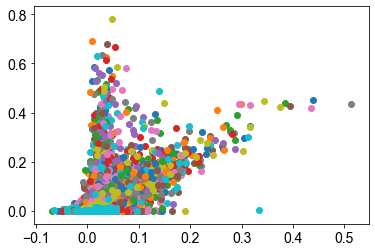

In [126]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

In [129]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        n_epochs = 100
        niter =1000
        batch_size=300#50
        
        #_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        x_nmf = nmfX.fit_transform(X)
         
        y_nmf = nmfY.fit_transform(Y)
        x_in = scalerX.fit_transform(x_nmf)
        y_in = scalerY.fit_transform(y_nmf)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = pcaY.fit_transform(normalize(Y))     
        
        
        an = anndata.AnnData(X)
        an.Y= Y
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

encoder_layer_sizes [240, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[1.0232e-02, 1.0038e-04, 5.6665e-07,  ..., 5.4900e-05, 3.2986e-06,
         4.3415e-04],
        [1.0593e-02, 1.9383e-07, 2.0765e-06,  ..., 0.0000e+00, 0.0000e+00,
         2.6395e-06],
        [1.9424e-02, 2.4611e-04, 6.9248e-04,  ..., 2.0926e-04, 5.0573e-04,
         2.0628e-03],
        ...,
        [3.3554e-03, 1.0405e-06, 2.1731e-07,  ..., 2.6498e-03, 4.2257e-02,
         8.7343e-02],
        [7.9301e-03, 8.0931e-06, 5.2631e-05,  ..., 1.5553e-06, 0.0000e+00,
         8.5367e-06],
        [6.0167e-04, 3.6588e-06, 0.0000e+00,  ..., 2.2039e-04, 3.1908e-02,
         3.7039e-02]], dtype=torch.float64)
1 iteration
98.35218048095703
2 iteration
65.56047821044922
3 iteration
54.652442932128906
4 iteration
44.868412017822266
5 iteration
36.23561477661133
6 iteration
29.084007263183594
7 iteration
24.143468856811523
8 iteration
21.38105583190918
9 iteration
20.270099639892578

0.5866329669952393
234 iteration
0.5772641897201538
235 iteration
0.590114951133728
236 iteration
0.5775074362754822
237 iteration
0.5766286253929138
238 iteration
0.5721192955970764
239 iteration
0.5750004649162292
240 iteration
0.5673097968101501
241 iteration
0.5806078314781189
242 iteration
0.5784210562705994
243 iteration
0.5653871893882751
244 iteration
0.5630355477333069
245 iteration
0.5580754280090332
246 iteration
0.5577500462532043
247 iteration
0.5539698600769043
248 iteration
0.5565457940101624
249 iteration
0.5649555921554565
250 iteration
0.5528971552848816
251 iteration
0.5481707453727722
252 iteration
0.5507976412773132
253 iteration
0.5451766848564148
254 iteration
0.5460406541824341
255 iteration
0.5516302585601807
256 iteration
0.5419098138809204
257 iteration
0.5478699803352356
258 iteration
0.5401903390884399
259 iteration
0.5377823710441589
260 iteration
0.5466576218605042
261 iteration
0.534243643283844
262 iteration
0.5336912274360657
263 iteration
0.5283280611

0.25670960545539856
484 iteration
0.2556106150150299
485 iteration
0.25549542903900146
486 iteration
0.2544991672039032
487 iteration
0.25460928678512573
488 iteration
0.25452327728271484
489 iteration
0.253359317779541
490 iteration
0.25246182084083557
491 iteration
0.252914696931839
492 iteration
0.24933527410030365
493 iteration
0.25103726983070374
494 iteration
0.24906639754772186
495 iteration
0.2482052594423294
496 iteration
0.2482426017522812
497 iteration
0.2472243309020996
498 iteration
0.2482871562242508
499 iteration
0.24695777893066406
500 iteration
0.2463962286710739
501 iteration
0.24443820118904114
502 iteration
0.2444530725479126
503 iteration
0.24668177962303162
504 iteration
0.24285008013248444
505 iteration
0.24429263174533844
506 iteration
0.24303357303142548
507 iteration
0.24418093264102936
508 iteration
0.24113738536834717
509 iteration
0.2412979155778885
510 iteration
0.24114006757736206
511 iteration
0.24007713794708252
512 iteration
0.24092750251293182
513 ite

0.18374724686145782
734 iteration
0.18252216279506683
735 iteration
0.18352189660072327
736 iteration
0.18254245817661285
737 iteration
0.18305154144763947
738 iteration
0.18290966749191284
739 iteration
0.1830020248889923
740 iteration
0.18095308542251587
741 iteration
0.18260812759399414
742 iteration
0.1832726001739502
743 iteration
0.18166421353816986
744 iteration
0.1811954528093338
745 iteration
0.18205516040325165
746 iteration
0.18146535754203796
747 iteration
0.1822134405374527
748 iteration
0.18208032846450806
749 iteration
0.18108537793159485
750 iteration
0.18142931163311005
751 iteration
0.18020270764827728
752 iteration
0.18074704706668854
753 iteration
0.17969542741775513
754 iteration
0.17996986210346222
755 iteration
0.18018583953380585
756 iteration
0.17905811965465546
757 iteration
0.17901112139225006
758 iteration
0.17892633378505707
759 iteration
0.17955359816551208
760 iteration
0.17995940148830414
761 iteration
0.17926442623138428
762 iteration
0.1795461028814315

0.15934357047080994
983 iteration
0.15742337703704834
984 iteration
0.15783490240573883
985 iteration
0.15713050961494446
986 iteration
0.15757980942726135
987 iteration
0.15752507746219635
988 iteration
0.1584477573633194
989 iteration
0.1577298790216446
990 iteration
0.1580873429775238
991 iteration
0.15689127147197723
992 iteration
0.1576656699180603
993 iteration
0.1572677344083786
994 iteration
0.1565990000963211
995 iteration
0.15631848573684692
996 iteration
0.15828250348567963
997 iteration
0.15631896257400513
998 iteration
0.15677602589130402
999 iteration
0.15633639693260193
1000 iteration
0.15620356798171997


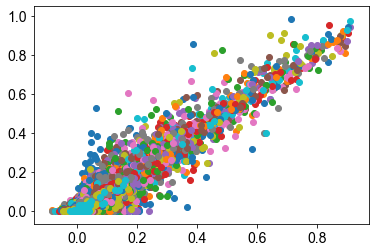

In [130]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

In [131]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572193300619538
0.9975154689456638
0.0010721778021524013 0.007446737378860348
9.494977367523903 376.0
encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.0186, -0.1872, -0.0951,  ..., -0.2613, -0.4126, -0.3122],
        [ 2.9790, -0.0566,  1.3396,  ..., -0.2605, -0.4048, -0.2711],
        [-0.1088, -0.1877, -0.2738,  ..., -0.2614, -0.4115, -0.3199],
        ...,
        [-0.2719, -0.1829, -0.2351,  ..., -0.2614, -0.4119, -0.3072],
        [-0.2578, -0.1866, -0.2594,  ...,  0.1582, -0.0797, -0.0331],
        [-0.1934,  0.1174,  1.2602,  ...,  0.1907,  0.0529,  0.1079]],
       dtype=torch.float64)
1 iteration
673.187255859375
2 iteration
627.0848388671875
3 iteration
619.2828979492188
4 iteration
597.1074829101562
5 iteration
582.2427978515625
6 iteration
564.7134399414062
7 iteration
538.8558349609375
8 iteration
508.9542236328125
9 iteration
494.8774108886719
10 iteration
476.8730773925781
11 iteration
457.3934936

37.282230377197266
248 iteration
37.14351272583008
249 iteration
37.062255859375
250 iteration
36.509830474853516
251 iteration
36.29259490966797
252 iteration
36.36341857910156
253 iteration
36.17977523803711
254 iteration
36.02979278564453
255 iteration
36.05282211303711
256 iteration
35.70709228515625
257 iteration
35.40601348876953
258 iteration
35.272525787353516
259 iteration
35.05690002441406
260 iteration
34.91774368286133
261 iteration
34.74151611328125
262 iteration
34.55292510986328
263 iteration
34.431793212890625
264 iteration
34.255558013916016
265 iteration
34.35551452636719
266 iteration
34.31062316894531
267 iteration
34.64186477661133
268 iteration
35.64799880981445
269 iteration
36.87977981567383
270 iteration
38.41740417480469
271 iteration
38.204132080078125
272 iteration
37.80617141723633
273 iteration
37.13457489013672
274 iteration
36.45615005493164
275 iteration
35.620208740234375
276 iteration
36.12918472290039
277 iteration
35.164649963378906
278 iteration
35

20.529415130615234
507 iteration
20.736225128173828
508 iteration
20.84259033203125
509 iteration
20.78502082824707
510 iteration
20.7883358001709
511 iteration
20.681629180908203
512 iteration
20.736047744750977
513 iteration
20.840911865234375
514 iteration
20.8896541595459
515 iteration
20.875816345214844
516 iteration
20.746337890625
517 iteration
20.454748153686523
518 iteration
20.27754783630371
519 iteration
20.287708282470703
520 iteration
20.4468994140625
521 iteration
20.479280471801758
522 iteration
20.414072036743164
523 iteration
20.40813446044922
524 iteration
20.394813537597656
525 iteration
20.466650009155273
526 iteration
20.432832717895508
527 iteration
20.283008575439453
528 iteration
20.198261260986328
529 iteration
20.033103942871094
530 iteration
19.871549606323242
531 iteration
19.767820358276367
532 iteration
19.803173065185547
533 iteration
19.98158073425293
534 iteration
20.23006820678711
535 iteration
20.17180824279785
536 iteration
20.121471405029297
537 ite

16.15545082092285
769 iteration
16.143783569335938
770 iteration
16.2625789642334
771 iteration
16.232032775878906
772 iteration
16.214397430419922
773 iteration
16.04253578186035
774 iteration
15.95674991607666
775 iteration
15.972870826721191
776 iteration
16.222837448120117
777 iteration
16.703655242919922
778 iteration
17.291584014892578
779 iteration
17.739858627319336
780 iteration
17.555891036987305
781 iteration
17.052541732788086
782 iteration
16.44785499572754
783 iteration
16.33865737915039
784 iteration
16.615196228027344
785 iteration
16.621564865112305
786 iteration
16.263147354125977
787 iteration
16.05480194091797
788 iteration
16.271493911743164
789 iteration
16.375171661376953
790 iteration
16.2155704498291
791 iteration
15.856115341186523
792 iteration
15.735372543334961
793 iteration
15.840799331665039
794 iteration
15.935954093933105
795 iteration
15.786416053771973
796 iteration
15.684406280517578
797 iteration
15.608582496643066
798 iteration
15.523299217224121
7

13.203970909118652
1019 iteration
13.356369972229004
1020 iteration
13.49459457397461
1021 iteration
13.73678207397461
1022 iteration
13.6448335647583
1023 iteration
13.757522583007812
1024 iteration
13.661012649536133
1025 iteration
13.722805976867676
1026 iteration
13.662187576293945
1027 iteration
13.715686798095703
1028 iteration
14.160934448242188
1029 iteration
14.033060073852539
1030 iteration
14.380362510681152
1031 iteration
14.97204875946045
1032 iteration
15.537093162536621
1033 iteration
15.820648193359375
1034 iteration
15.7581148147583
1035 iteration
15.097870826721191
1036 iteration
14.660579681396484
1037 iteration
14.295944213867188
1038 iteration
14.4705810546875
1039 iteration
14.40675163269043
1040 iteration
13.975577354431152
1041 iteration
13.68204402923584
1042 iteration
13.805373191833496
1043 iteration
14.001124382019043
1044 iteration
13.844106674194336
1045 iteration
13.455123901367188
1046 iteration
13.515767097473145
1047 iteration
13.468256950378418
1048 i

12.440978050231934
1264 iteration
12.396612167358398
1265 iteration
12.378778457641602
1266 iteration
11.876765251159668
1267 iteration
11.867241859436035
1268 iteration
11.79516887664795
1269 iteration
11.82739543914795
1270 iteration
11.632543563842773
1271 iteration
11.539726257324219
1272 iteration
11.55990982055664
1273 iteration
11.514674186706543
1274 iteration
11.412893295288086
1275 iteration
11.299708366394043
1276 iteration
11.260442733764648
1277 iteration
11.27539348602295
1278 iteration
11.136007308959961
1279 iteration
11.18505573272705
1280 iteration
11.195646286010742
1281 iteration
11.1602144241333
1282 iteration
11.14229679107666
1283 iteration
11.218866348266602
1284 iteration
11.389582633972168
1285 iteration
11.602690696716309
1286 iteration
12.196785926818848
1287 iteration
12.083127975463867
1288 iteration
11.921309471130371
1289 iteration
11.72350025177002
1290 iteration
11.723771095275879
1291 iteration
11.66171932220459
1292 iteration
11.874018669128418
1293 

9.622323036193848
1509 iteration
9.50129222869873
1510 iteration
9.429399490356445
1511 iteration
9.438389778137207
1512 iteration
9.458220481872559
1513 iteration
9.443997383117676
1514 iteration
9.447888374328613
1515 iteration
9.365714073181152
1516 iteration
9.315054893493652
1517 iteration
9.342082977294922
1518 iteration
9.35300064086914
1519 iteration
9.412718772888184
1520 iteration
9.428208351135254
1521 iteration
9.514747619628906
1522 iteration
9.729059219360352
1523 iteration
9.975194931030273
1524 iteration
10.328367233276367
1525 iteration
10.345505714416504
1526 iteration
10.289403915405273
1527 iteration
10.310373306274414
1528 iteration
10.437649726867676
1529 iteration
11.39282512664795
1530 iteration
12.8778715133667
1531 iteration
13.098751068115234
1532 iteration
13.1448335647583
1533 iteration
15.004117965698242
1534 iteration
14.978937149047852
1535 iteration
14.884445190429688
1536 iteration
13.528470993041992
1537 iteration
13.2601900100708
1538 iteration
13.38

8.531007766723633
1763 iteration
8.518064498901367
1764 iteration
8.640359878540039
1765 iteration
8.67990493774414
1766 iteration
8.620177268981934
1767 iteration
8.532065391540527
1768 iteration
8.593034744262695
1769 iteration
8.804759979248047
1770 iteration
8.897780418395996
1771 iteration
8.678418159484863
1772 iteration
8.474223136901855
1773 iteration
8.424298286437988
1774 iteration
8.536029815673828
1775 iteration
8.656769752502441
1776 iteration
8.374211311340332
1777 iteration
8.342235565185547
1778 iteration
8.385515213012695
1779 iteration
8.458172798156738
1780 iteration
8.540037155151367
1781 iteration
8.596904754638672
1782 iteration
8.534591674804688
1783 iteration
8.568906784057617
1784 iteration
8.618451118469238
1785 iteration
8.724034309387207
1786 iteration
8.774064064025879
1787 iteration
8.578645706176758
1788 iteration
8.585556030273438
1789 iteration
8.865837097167969
1790 iteration
9.235379219055176
1791 iteration
9.55539608001709
1792 iteration
9.8356399536

7.99943208694458
2022 iteration
7.8545451164245605
2023 iteration
7.858792304992676
2024 iteration
7.850582599639893
2025 iteration
7.828917503356934
2026 iteration
7.7660393714904785
2027 iteration
7.623350620269775
2028 iteration
7.636306285858154
2029 iteration
7.6577887535095215
2030 iteration
7.636651992797852
2031 iteration
7.63228178024292
2032 iteration
7.636271953582764
2033 iteration
7.7808709144592285
2034 iteration
7.715503692626953
2035 iteration
7.755757808685303
2036 iteration
7.647884845733643
2037 iteration
7.746416091918945
2038 iteration
7.848426818847656
2039 iteration
8.159079551696777
2040 iteration
8.224907875061035
2041 iteration
8.146553039550781
2042 iteration
7.870476722717285
2043 iteration
8.28475284576416
2044 iteration
8.08194637298584
2045 iteration
8.021658897399902
2046 iteration
8.276735305786133
2047 iteration
7.989964962005615
2048 iteration
8.326875686645508
2049 iteration
8.02907657623291
2050 iteration
7.751092910766602
2051 iteration
7.600229263

6.804370880126953
2271 iteration
6.7424468994140625
2272 iteration
6.833833694458008
2273 iteration
6.983354568481445
2274 iteration
7.130831718444824
2275 iteration
7.176750659942627
2276 iteration
7.0833845138549805
2277 iteration
6.880255699157715
2278 iteration
6.755129337310791
2279 iteration
6.703906059265137
2280 iteration
6.752769470214844
2281 iteration
6.921551704406738
2282 iteration
7.098151206970215
2283 iteration
7.263671875
2284 iteration
7.262288570404053
2285 iteration
7.249227046966553
2286 iteration
7.188930034637451
2287 iteration
7.180612564086914
2288 iteration
7.384652614593506
2289 iteration
7.664179801940918
2290 iteration
7.962808609008789
2291 iteration
8.315206527709961
2292 iteration
8.562344551086426
2293 iteration
8.462686538696289
2294 iteration
8.132067680358887
2295 iteration
7.940414905548096
2296 iteration
7.883139610290527
2297 iteration
7.752504825592041
2298 iteration
7.905763149261475
2299 iteration
8.074488639831543
2300 iteration
8.106287002563

7.212467670440674
2525 iteration
7.270778179168701
2526 iteration
7.262868881225586
2527 iteration
7.185484886169434
2528 iteration
7.178415298461914
2529 iteration
6.995489120483398
2530 iteration
6.859064102172852
2531 iteration
6.744904518127441
2532 iteration
6.682432174682617
2533 iteration
6.646475315093994
2534 iteration
6.597812652587891
2535 iteration
6.624772548675537
2536 iteration
6.66276216506958
2537 iteration
6.651378631591797
2538 iteration
6.671616554260254
2539 iteration
6.660641670227051
2540 iteration
6.630384922027588
2541 iteration
6.558785438537598
2542 iteration
6.531010627746582
2543 iteration
6.584731578826904
2544 iteration
6.664498329162598
2545 iteration
6.732700824737549
2546 iteration
6.762316703796387
2547 iteration
6.799173831939697
2548 iteration
6.885241508483887
2549 iteration
6.887781620025635
2550 iteration
6.844484806060791
2551 iteration
6.78947639465332
2552 iteration
6.762638568878174
2553 iteration
6.830564975738525
2554 iteration
6.9025464057

8.286275863647461
2782 iteration
8.197578430175781
2783 iteration
8.288105010986328
2784 iteration
8.617037773132324
2785 iteration
8.740548133850098
2786 iteration
8.250178337097168
2787 iteration
7.396203517913818
2788 iteration
7.512225151062012
2789 iteration
7.853914260864258
2790 iteration
7.822550296783447
2791 iteration
7.379214763641357
2792 iteration
7.0652618408203125
2793 iteration
7.107253551483154
2794 iteration
7.086925506591797
2795 iteration
6.981616020202637
2796 iteration
6.931498050689697
2797 iteration
6.887335777282715
2798 iteration
6.812442302703857
2799 iteration
6.6133928298950195
2800 iteration
6.544179439544678
2801 iteration
6.564116954803467
2802 iteration
6.535545825958252
2803 iteration
6.427614212036133
2804 iteration
6.349560260772705
2805 iteration
6.342715740203857
2806 iteration
6.303415775299072
2807 iteration
6.304722309112549
2808 iteration
6.31058406829834
2809 iteration
6.323732852935791
2810 iteration
6.292933464050293
2811 iteration
6.2753682

5.929296016693115
3031 iteration
5.9738993644714355
3032 iteration
6.061000347137451
3033 iteration
6.276898384094238
3034 iteration
6.539961814880371
3035 iteration
6.832566738128662
3036 iteration
7.074605941772461
3037 iteration
7.348424434661865
3038 iteration
7.555429458618164
3039 iteration
7.6095123291015625
3040 iteration
7.745348930358887
3041 iteration
7.794027328491211
3042 iteration
8.074411392211914
3043 iteration
8.329204559326172
3044 iteration
8.695964813232422
3045 iteration
8.720511436462402
3046 iteration
8.652555465698242
3047 iteration
8.349505424499512
3048 iteration
7.886590957641602
3049 iteration
7.659837245941162
3050 iteration
7.359578609466553
3051 iteration
7.244630336761475
3052 iteration
7.204730033874512
3053 iteration
7.174400806427002
3054 iteration
7.144946098327637
3055 iteration
7.075257778167725
3056 iteration
7.038851737976074
3057 iteration
6.886561870574951
3058 iteration
6.769145488739014
3059 iteration
6.793766021728516
3060 iteration
6.617005

5.826817035675049
3280 iteration
5.816025733947754
3281 iteration
5.79256010055542
3282 iteration
5.752365589141846
3283 iteration
5.75438117980957
3284 iteration
5.729221820831299
3285 iteration
5.734267711639404
3286 iteration
5.705827236175537
3287 iteration
5.685256481170654
3288 iteration
5.695866107940674
3289 iteration
5.666139602661133
3290 iteration
5.6492156982421875
3291 iteration
5.659960746765137
3292 iteration
5.6953864097595215
3293 iteration
5.747739315032959
3294 iteration
5.797831058502197
3295 iteration
5.845370769500732
3296 iteration
5.871664047241211
3297 iteration
5.884589195251465
3298 iteration
5.936761379241943
3299 iteration
6.111633777618408
3300 iteration
6.494321823120117
3301 iteration
7.105648517608643
3302 iteration
7.953129768371582
3303 iteration
8.366929054260254
3304 iteration
8.451516151428223
3305 iteration
7.89700174331665
3306 iteration
7.442348003387451
3307 iteration
7.849002361297607
3308 iteration
8.468199729919434
3309 iteration
8.920856475

6.045390605926514
3529 iteration
5.886495590209961
3530 iteration
5.783680438995361
3531 iteration
5.8240132331848145
3532 iteration
5.884763240814209
3533 iteration
5.842374324798584
3534 iteration
5.713751792907715
3535 iteration
5.697697162628174
3536 iteration
5.726539134979248
3537 iteration
5.756311416625977
3538 iteration
5.733051300048828
3539 iteration
5.683788299560547
3540 iteration
5.661859035491943
3541 iteration
5.702362537384033
3542 iteration
5.687180995941162
3543 iteration
5.616681098937988
3544 iteration
5.566610336303711
3545 iteration
5.55983304977417
3546 iteration
5.61682653427124
3547 iteration
5.623566627502441
3548 iteration
5.589014530181885
3549 iteration
5.593487739562988
3550 iteration
5.60420560836792
3551 iteration
5.635828495025635
3552 iteration
5.647437572479248
3553 iteration
5.67375373840332
3554 iteration
5.716346263885498
3555 iteration
5.785642147064209
3556 iteration
5.851965427398682
3557 iteration
5.850250244140625
3558 iteration
5.84078454971

5.7164998054504395
3786 iteration
5.694005489349365
3787 iteration
5.6483988761901855
3788 iteration
5.660671710968018
3789 iteration
5.739148139953613
3790 iteration
5.873293399810791
3791 iteration
6.021357536315918
3792 iteration
6.285272121429443
3793 iteration
6.581336498260498
3794 iteration
6.914243221282959
3795 iteration
7.0744500160217285
3796 iteration
7.129645824432373
3797 iteration
7.134922027587891
3798 iteration
7.101922988891602
3799 iteration
6.955567836761475
3800 iteration
6.71720552444458
3801 iteration
6.642812728881836
3802 iteration
6.7695207595825195
3803 iteration
6.847804546356201
3804 iteration
6.783163070678711
3805 iteration
6.700168609619141
3806 iteration
6.652703762054443
3807 iteration
6.593159198760986
3808 iteration
6.449479579925537
3809 iteration
6.256197929382324
3810 iteration
6.099864959716797
3811 iteration
6.029162406921387
3812 iteration
6.02836799621582
3813 iteration
6.100068092346191
3814 iteration
6.10500955581665
3815 iteration
5.9224886

5.358783721923828
4036 iteration
5.348184585571289
4037 iteration
5.352242469787598
4038 iteration
5.37539529800415
4039 iteration
5.375885009765625
4040 iteration
5.372296333312988
4041 iteration
5.341415882110596
4042 iteration
5.3717360496521
4043 iteration
5.378330707550049
4044 iteration
5.406074047088623
4045 iteration
5.432181358337402
4046 iteration
5.4178385734558105
4047 iteration
5.481701850891113
4048 iteration
5.5846028327941895
4049 iteration
5.69038724899292
4050 iteration
5.875480651855469
4051 iteration
6.075182914733887
4052 iteration
6.2982563972473145
4053 iteration
6.449807643890381
4054 iteration
6.434507846832275
4055 iteration
6.279078960418701
4056 iteration
6.002256870269775
4057 iteration
5.743667125701904
4058 iteration
5.580723762512207
4059 iteration
5.589422225952148
4060 iteration
5.623811721801758
4061 iteration
5.68034029006958
4062 iteration
5.728682518005371
4063 iteration
5.781807899475098
4064 iteration
5.6923370361328125
4065 iteration
5.593448638

5.689520835876465
4291 iteration
5.656005382537842
4292 iteration
5.596808910369873
4293 iteration
5.559169292449951
4294 iteration
5.580695152282715
4295 iteration
5.520296573638916
4296 iteration
5.495075702667236
4297 iteration
5.40159797668457
4298 iteration
5.3462815284729
4299 iteration
5.341975212097168
4300 iteration
5.305327892303467
4301 iteration
5.2761945724487305
4302 iteration
5.269321918487549
4303 iteration
5.287038803100586
4304 iteration
5.300351142883301
4305 iteration
5.280948638916016
4306 iteration
5.2662672996521
4307 iteration
5.199959754943848
4308 iteration
5.144495010375977
4309 iteration
5.125415325164795
4310 iteration
5.107826232910156
4311 iteration
5.130005836486816
4312 iteration
5.1196980476379395
4313 iteration
5.118415355682373
4314 iteration
5.103663921356201
4315 iteration
5.066798210144043
4316 iteration
5.071074962615967
4317 iteration
5.1121907234191895
4318 iteration
5.150034427642822
4319 iteration
5.160090923309326
4320 iteration
5.1513462066

5.045845985412598
4548 iteration
5.043035984039307
4549 iteration
5.040353298187256
4550 iteration
5.04327917098999
4551 iteration
5.075708866119385
4552 iteration
5.066747665405273
4553 iteration
5.059008598327637
4554 iteration
5.073962211608887
4555 iteration
5.077280521392822
4556 iteration
5.052932262420654
4557 iteration
5.0237135887146
4558 iteration
5.01696252822876
4559 iteration
5.033236503601074
4560 iteration
5.0487446784973145
4561 iteration
5.11183500289917
4562 iteration
5.147864818572998
4563 iteration
5.18092679977417
4564 iteration
5.192409515380859
4565 iteration
5.180016040802002
4566 iteration
5.146999359130859
4567 iteration
5.151787281036377
4568 iteration
5.1422529220581055
4569 iteration
5.113719463348389
4570 iteration
5.095315933227539
4571 iteration
5.1084442138671875
4572 iteration
5.12977409362793
4573 iteration
5.115367412567139
4574 iteration
5.13263463973999
4575 iteration
5.192992687225342
4576 iteration
5.313769340515137
4577 iteration
5.4506878852844

5.264100551605225
4798 iteration
5.264227867126465
4799 iteration
5.284030914306641
4800 iteration
5.2867536544799805
4801 iteration
5.333439826965332
4802 iteration
5.354572772979736
4803 iteration
5.346036911010742
4804 iteration
5.358928203582764
4805 iteration
5.33882999420166
4806 iteration
5.364084720611572
4807 iteration
5.294920444488525
4808 iteration
5.206859111785889
4809 iteration
5.198908805847168
4810 iteration
5.216471195220947
4811 iteration
5.200470447540283
4812 iteration
5.297441005706787
4813 iteration
5.280186176300049
4814 iteration
5.25285530090332
4815 iteration
5.191782474517822
4816 iteration
5.159282207489014
4817 iteration
5.151232719421387
4818 iteration
5.163695335388184
4819 iteration
5.184953212738037
4820 iteration
5.193967819213867
4821 iteration
5.119021892547607
4822 iteration
5.099091053009033
4823 iteration
5.10835599899292
4824 iteration
5.113071918487549
4825 iteration
5.092707633972168
4826 iteration
5.071099758148193
4827 iteration
5.1054840087

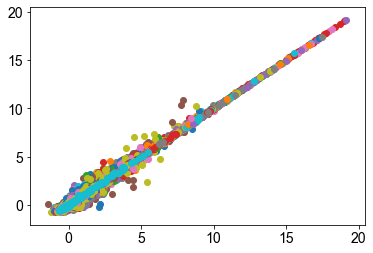

In [132]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

In [133]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        
        
        
        
        
        
        an = anndata.AnnData(pcaX.fit_transform(xnorm))
        an.Y= pcaX.fit_transform(ynorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

0.8572298695425934
0.9975139580716639
0.0010721778033505143 0.007446737378860348
9.553209446957482 376.0
encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-4.4471,  0.1013, -2.0197,  ...,  1.1642, -0.0301, -1.2228],
        [-3.8270, -0.4645, -0.1205,  ..., -0.7433, -0.0221,  2.2756],
        [-1.8710, -0.2411, -3.1016,  ..., -0.2414, -0.1093,  2.2145],
        ...,
        [-1.8614, -0.1977, -2.3941,  ..., -1.3365,  1.3499,  1.4574],
        [-4.3807,  0.4042, -2.2935,  ...,  1.0159,  0.1820, -2.7025],
        [-4.4035, -0.5375, -2.5224,  ...,  1.3254,  0.8909,  1.9822]],
       dtype=torch.float64)
1 iteration
402.5477600097656
2 iteration
398.5736999511719
3 iteration
394.0565490722656
4 iteration
385.9681396484375
5 iteration
380.1863708496094
6 iteration
383.699462890625
7 iteration
378.43310546875
8 iteration
361.1565246582031
9 iteration
352.1197509765625
10 iteration
347.6950378417969
11 iteration
340.6603393554

83.60401916503906
239 iteration
92.67945098876953
240 iteration
82.74208068847656
241 iteration
86.8118896484375
242 iteration
74.91913604736328
243 iteration
81.59027099609375
244 iteration
79.13390350341797
245 iteration
76.3120346069336
246 iteration
72.94422149658203
247 iteration
75.27657318115234
248 iteration
71.35513305664062
249 iteration
72.82910919189453
250 iteration
69.16202545166016
251 iteration
69.24884796142578
252 iteration
69.79850006103516
253 iteration
68.12519073486328
254 iteration
68.3611068725586
255 iteration
67.2281494140625
256 iteration
65.72932434082031
257 iteration
68.22161102294922
258 iteration
73.09331512451172
259 iteration
69.58086395263672
260 iteration
72.87802124023438
261 iteration
73.9179916381836
262 iteration
69.76424407958984
263 iteration
75.91206359863281
264 iteration
76.99314880371094
265 iteration
73.454345703125
266 iteration
80.62763214111328
267 iteration
77.0826187133789
268 iteration
73.63262176513672
269 iteration
75.4219131469726

37.19588851928711
497 iteration
39.52634048461914
498 iteration
39.641544342041016
499 iteration
37.430660247802734
500 iteration
33.07337951660156
501 iteration
34.26522445678711
502 iteration
35.76614761352539
503 iteration
38.08896255493164
504 iteration
39.029640197753906
505 iteration
34.52780532836914
506 iteration
34.10023498535156
507 iteration
37.31293869018555
508 iteration
41.72447204589844
509 iteration
42.69523239135742
510 iteration
36.40504455566406
511 iteration
36.99658966064453
512 iteration
39.8880615234375
513 iteration
37.23633575439453
514 iteration
38.814666748046875
515 iteration
42.76727294921875
516 iteration
37.75411605834961
517 iteration
37.45162582397461
518 iteration
35.375579833984375
519 iteration
36.0108642578125
520 iteration
35.02269744873047
521 iteration
36.433570861816406
522 iteration
36.59711456298828
523 iteration
36.46221923828125
524 iteration
35.9858283996582
525 iteration
39.161319732666016
526 iteration
36.66984558105469
527 iteration
36.2

28.6635799407959
755 iteration
25.765899658203125
756 iteration
24.061248779296875
757 iteration
26.11432456970215
758 iteration
26.246015548706055
759 iteration
24.475345611572266
760 iteration
23.482181549072266
761 iteration
23.602718353271484
762 iteration
24.43631362915039
763 iteration
24.554716110229492
764 iteration
23.57695198059082
765 iteration
22.714513778686523
766 iteration
22.2962703704834
767 iteration
22.74512481689453
768 iteration
22.961576461791992
769 iteration
23.117387771606445
770 iteration
22.896900177001953
771 iteration
22.282085418701172
772 iteration
22.06499481201172
773 iteration
21.655914306640625
774 iteration
21.729907989501953
775 iteration
22.008100509643555
776 iteration
23.201684951782227
777 iteration
23.301210403442383
778 iteration
23.830331802368164
779 iteration
22.127613067626953
780 iteration
21.678871154785156
781 iteration
21.870668411254883
782 iteration
24.377403259277344
783 iteration
30.281497955322266
784 iteration
35.56473159790039
7

36.00367736816406
1008 iteration
34.0067138671875
1009 iteration
29.76111602783203
1010 iteration
31.944915771484375
1011 iteration
27.844186782836914
1012 iteration
28.541278839111328
1013 iteration
26.608980178833008
1014 iteration
27.768293380737305
1015 iteration
25.98743438720703
1016 iteration
26.140689849853516
1017 iteration
25.90069007873535
1018 iteration
23.56725311279297
1019 iteration
26.11614227294922
1020 iteration
21.986787796020508
1021 iteration
23.697128295898438
1022 iteration
22.203298568725586
1023 iteration
21.6860294342041
1024 iteration
22.268604278564453
1025 iteration
20.932506561279297
1026 iteration
21.902732849121094
1027 iteration
20.368179321289062
1028 iteration
20.3476505279541
1029 iteration
20.55303955078125
1030 iteration
19.830291748046875
1031 iteration
19.94086456298828
1032 iteration
19.39984703063965
1033 iteration
19.401884078979492
1034 iteration
19.203325271606445
1035 iteration
18.751066207885742
1036 iteration
19.279508590698242
1037 itera

74.95840454101562
1261 iteration
69.92404174804688
1262 iteration
66.4819564819336
1263 iteration
63.406673431396484
1264 iteration
60.8911018371582
1265 iteration
58.398345947265625
1266 iteration
55.10385513305664
1267 iteration
52.65425491333008
1268 iteration
51.292091369628906
1269 iteration
48.71260452270508
1270 iteration
46.78443908691406
1271 iteration
45.49479675292969
1272 iteration
43.210975646972656
1273 iteration
41.5376091003418
1274 iteration
40.56907272338867
1275 iteration
39.67776870727539
1276 iteration
37.8690185546875
1277 iteration
36.229923248291016
1278 iteration
35.40235137939453
1279 iteration
34.30954360961914
1280 iteration
33.81866455078125
1281 iteration
33.13252639770508
1282 iteration
32.88214111328125
1283 iteration
33.741111755371094
1284 iteration
36.3950080871582
1285 iteration
44.393253326416016
1286 iteration
35.84394073486328
1287 iteration
30.067913055419922
1288 iteration
29.562131881713867
1289 iteration
32.67947769165039
1290 iteration
38.232

16.984542846679688
1515 iteration
15.72814655303955
1516 iteration
16.651960372924805
1517 iteration
18.65955924987793
1518 iteration
21.538206100463867
1519 iteration
16.41449737548828
1520 iteration
24.461524963378906
1521 iteration
28.982877731323242
1522 iteration
29.114648818969727
1523 iteration
22.673282623291016
1524 iteration
29.767539978027344
1525 iteration
26.973461151123047
1526 iteration
27.085920333862305
1527 iteration
24.22791862487793
1528 iteration
22.510318756103516
1529 iteration
23.23246955871582
1530 iteration
22.99857521057129
1531 iteration
21.592195510864258
1532 iteration
20.83953857421875
1533 iteration
20.630155563354492
1534 iteration
19.98377799987793
1535 iteration
20.009828567504883
1536 iteration
18.450788497924805
1537 iteration
19.11787223815918
1538 iteration
17.471067428588867
1539 iteration
18.610883712768555
1540 iteration
19.22678565979004
1541 iteration
18.77017593383789
1542 iteration
17.427114486694336
1543 iteration
18.39727210998535
1544 it

13.349157333374023
1760 iteration
13.271903038024902
1761 iteration
13.536514282226562
1762 iteration
14.119257926940918
1763 iteration
14.846189498901367
1764 iteration
16.34136962890625
1765 iteration
17.593860626220703
1766 iteration
17.801315307617188
1767 iteration
16.846649169921875
1768 iteration
14.317830085754395
1769 iteration
13.1835298538208
1770 iteration
14.311871528625488
1771 iteration
15.523808479309082
1772 iteration
15.016640663146973
1773 iteration
13.645042419433594
1774 iteration
13.10201644897461
1775 iteration
13.854063987731934
1776 iteration
14.537327766418457
1777 iteration
14.054491996765137
1778 iteration
13.161596298217773
1779 iteration
13.04395580291748
1780 iteration
13.529930114746094
1781 iteration
13.982664108276367
1782 iteration
13.833664894104004
1783 iteration
13.325736999511719
1784 iteration
12.952659606933594
1785 iteration
12.686676979064941
1786 iteration
12.730393409729004
1787 iteration
12.753244400024414
1788 iteration
12.873624801635742


12.630859375
2011 iteration
12.263787269592285
2012 iteration
11.880695343017578
2013 iteration
11.963947296142578
2014 iteration
12.182381629943848
2015 iteration
11.891639709472656
2016 iteration
12.026326179504395
2017 iteration
12.249774932861328
2018 iteration
11.928084373474121
2019 iteration
11.858078956604004
2020 iteration
12.014513969421387
2021 iteration
12.275080680847168
2022 iteration
12.51374626159668
2023 iteration
12.382407188415527
2024 iteration
12.120309829711914
2025 iteration
11.950115203857422
2026 iteration
11.982048988342285
2027 iteration
12.358380317687988
2028 iteration
13.01906681060791
2029 iteration
13.18583869934082
2030 iteration
13.416099548339844
2031 iteration
12.72695255279541
2032 iteration
12.270330429077148
2033 iteration
12.789917945861816
2034 iteration
14.25854206085205
2035 iteration
15.391350746154785
2036 iteration
15.049324989318848
2037 iteration
14.161842346191406
2038 iteration
12.731192588806152
2039 iteration
12.345223426818848
2040 i

47.671348571777344
2264 iteration
44.9358024597168
2265 iteration
46.599761962890625
2266 iteration
46.327980041503906
2267 iteration
45.32779312133789
2268 iteration
39.64228057861328
2269 iteration
37.44192123413086
2270 iteration
35.655662536621094
2271 iteration
30.657838821411133
2272 iteration
35.31904602050781
2273 iteration
30.526947021484375
2274 iteration
30.745397567749023
2275 iteration
28.284271240234375
2276 iteration
25.83928108215332
2277 iteration
26.49285888671875
2278 iteration
23.622655868530273
2279 iteration
23.832246780395508
2280 iteration
23.253734588623047
2281 iteration
22.099414825439453
2282 iteration
20.722360610961914
2283 iteration
19.426008224487305
2284 iteration
20.078916549682617
2285 iteration
17.93107032775879
2286 iteration
17.983823776245117
2287 iteration
17.257225036621094
2288 iteration
17.06488800048828
2289 iteration
16.463821411132812
2290 iteration
15.76123046875
2291 iteration
15.963502883911133
2292 iteration
15.060696601867676
2293 iter

10.906719207763672
2517 iteration
11.41182804107666
2518 iteration
11.625486373901367
2519 iteration
11.44481086730957
2520 iteration
11.73281478881836
2521 iteration
11.674941062927246
2522 iteration
10.656085968017578
2523 iteration
11.158309936523438
2524 iteration
11.730175018310547
2525 iteration
11.806057929992676
2526 iteration
11.31287670135498
2527 iteration
11.193841934204102
2528 iteration
11.577342987060547
2529 iteration
10.91601276397705
2530 iteration
10.310765266418457
2531 iteration
10.734922409057617
2532 iteration
11.46442699432373
2533 iteration
12.216608047485352
2534 iteration
12.37684440612793
2535 iteration
12.438472747802734
2536 iteration
12.4063138961792
2537 iteration
11.941250801086426
2538 iteration
11.25291633605957
2539 iteration
11.635238647460938
2540 iteration
12.051419258117676
2541 iteration
11.576470375061035
2542 iteration
11.11176586151123
2543 iteration
10.55492877960205
2544 iteration
11.25671672821045
2545 iteration
11.887365341186523
2546 ite

10.456380844116211
2765 iteration
9.990510940551758
2766 iteration
9.953154563903809
2767 iteration
10.049917221069336
2768 iteration
10.066401481628418
2769 iteration
10.342132568359375
2770 iteration
10.721288681030273
2771 iteration
11.210636138916016
2772 iteration
11.891249656677246
2773 iteration
12.6399507522583
2774 iteration
12.396258354187012
2775 iteration
11.708551406860352
2776 iteration
10.755002975463867
2777 iteration
10.00436019897461
2778 iteration
10.240706443786621
2779 iteration
11.034442901611328
2780 iteration
10.943184852600098
2781 iteration
10.66245174407959
2782 iteration
10.454570770263672
2783 iteration
10.564437866210938
2784 iteration
10.676680564880371
2785 iteration
10.551267623901367
2786 iteration
11.057709693908691
2787 iteration
11.253698348999023
2788 iteration
11.455297470092773
2789 iteration
10.880770683288574
2790 iteration
10.287001609802246
2791 iteration
9.883553504943848
2792 iteration
10.135051727294922
2793 iteration
11.020857810974121
27

9.589438438415527
3019 iteration
9.39942455291748
3020 iteration
9.509296417236328
3021 iteration
9.947830200195312
3022 iteration
9.918966293334961
3023 iteration
9.991386413574219
3024 iteration
9.584486961364746
3025 iteration
9.310462951660156
3026 iteration
9.204751014709473
3027 iteration
9.368758201599121
3028 iteration
9.362110137939453
3029 iteration
9.478972434997559
3030 iteration
9.397347450256348
3031 iteration
10.065165519714355
3032 iteration
10.974994659423828
3033 iteration
12.002849578857422
3034 iteration
13.745387077331543
3035 iteration
13.256484985351562
3036 iteration
12.849590301513672
3037 iteration
10.788049697875977
3038 iteration
10.0291109085083
3039 iteration
10.632547378540039
3040 iteration
10.86556339263916
3041 iteration
12.055636405944824
3042 iteration
11.494497299194336
3043 iteration
11.132837295532227
3044 iteration
10.582955360412598
3045 iteration
9.58171272277832
3046 iteration
10.12180233001709
3047 iteration
10.890534400939941
3048 iteration


11.74997329711914
3270 iteration
10.427064895629883
3271 iteration
9.290698051452637
3272 iteration
9.386430740356445
3273 iteration
10.429612159729004
3274 iteration
10.860746383666992
3275 iteration
10.277594566345215
3276 iteration
9.520758628845215
3277 iteration
9.232308387756348
3278 iteration
9.30693531036377
3279 iteration
9.564224243164062
3280 iteration
9.5303373336792
3281 iteration
9.312023162841797
3282 iteration
9.782668113708496
3283 iteration
9.972776412963867
3284 iteration
9.874764442443848
3285 iteration
9.700996398925781
3286 iteration
10.193143844604492
3287 iteration
10.97572135925293
3288 iteration
11.594541549682617
3289 iteration
11.880966186523438
3290 iteration
12.087676048278809
3291 iteration
11.660765647888184
3292 iteration
11.027223587036133
3293 iteration
10.970749855041504
3294 iteration
11.074748039245605
3295 iteration
11.547709465026855
3296 iteration
11.89782428741455
3297 iteration
12.137767791748047
3298 iteration
11.373751640319824
3299 iteratio

11.038775444030762
3517 iteration
10.809473991394043
3518 iteration
10.80811882019043
3519 iteration
10.672333717346191
3520 iteration
10.572455406188965
3521 iteration
10.56185245513916
3522 iteration
10.847055435180664
3523 iteration
10.5953369140625
3524 iteration
10.328834533691406
3525 iteration
10.05836009979248
3526 iteration
9.94724178314209
3527 iteration
9.894266128540039
3528 iteration
9.89013385772705
3529 iteration
9.741832733154297
3530 iteration
9.592010498046875
3531 iteration
9.521833419799805
3532 iteration
9.669614791870117
3533 iteration
9.634894371032715
3534 iteration
9.582261085510254
3535 iteration
9.592987060546875
3536 iteration
9.734493255615234
3537 iteration
9.342681884765625
3538 iteration
9.221487998962402
3539 iteration
9.21252727508545
3540 iteration
9.188755989074707
3541 iteration
9.276078224182129
3542 iteration
9.270271301269531
3543 iteration
9.56132984161377
3544 iteration
9.72610092163086
3545 iteration
9.813519477844238
3546 iteration
9.44600486

8.478981971740723
3771 iteration
8.259542465209961
3772 iteration
8.32619571685791
3773 iteration
8.72161865234375
3774 iteration
8.969969749450684
3775 iteration
8.78193187713623
3776 iteration
8.544024467468262
3777 iteration
8.571468353271484
3778 iteration
8.70931339263916
3779 iteration
8.795204162597656
3780 iteration
8.794252395629883
3781 iteration
9.102441787719727
3782 iteration
9.585855484008789
3783 iteration
9.544791221618652
3784 iteration
9.273321151733398
3785 iteration
8.676968574523926
3786 iteration
8.264389991760254
3787 iteration
8.202853202819824
3788 iteration
8.28135871887207
3789 iteration
8.445588111877441
3790 iteration
8.6537446975708
3791 iteration
8.512243270874023
3792 iteration
8.503630638122559
3793 iteration
8.556783676147461
3794 iteration
8.709400177001953
3795 iteration
8.932307243347168
3796 iteration
9.042810440063477
3797 iteration
9.066421508789062
3798 iteration
9.07129192352295
3799 iteration
9.063678741455078
3800 iteration
9.286453247070312


8.483874320983887
4029 iteration
8.871323585510254
4030 iteration
8.970285415649414
4031 iteration
9.092586517333984
4032 iteration
8.911728858947754
4033 iteration
8.7153959274292
4034 iteration
8.567017555236816
4035 iteration
8.544095993041992
4036 iteration
8.390630722045898
4037 iteration
8.225797653198242
4038 iteration
8.27072811126709
4039 iteration
8.407983779907227
4040 iteration
8.540403366088867
4041 iteration
8.59005069732666
4042 iteration
8.800429344177246
4043 iteration
8.942197799682617
4044 iteration
9.107619285583496
4045 iteration
8.912174224853516
4046 iteration
8.546236991882324
4047 iteration
8.210674285888672
4048 iteration
8.149443626403809
4049 iteration
8.168488502502441
4050 iteration
8.379718780517578
4051 iteration
8.839303970336914
4052 iteration
8.834386825561523
4053 iteration
8.630541801452637
4054 iteration
8.39089584350586
4055 iteration
8.305299758911133
4056 iteration
8.178481101989746
4057 iteration
8.373617172241211
4058 iteration
8.3815555572509

8.167532920837402
4279 iteration
8.094663619995117
4280 iteration
8.126245498657227
4281 iteration
8.207651138305664
4282 iteration
7.94508695602417
4283 iteration
8.014466285705566
4284 iteration
7.894008636474609
4285 iteration
7.984524726867676
4286 iteration
8.22923469543457
4287 iteration
8.47834587097168
4288 iteration
8.681381225585938
4289 iteration
8.64896011352539
4290 iteration
8.565622329711914
4291 iteration
8.385709762573242
4292 iteration
8.128989219665527
4293 iteration
7.985734939575195
4294 iteration
7.800000190734863
4295 iteration
7.757519721984863
4296 iteration
7.698312759399414
4297 iteration
7.855442047119141
4298 iteration
8.242142677307129
4299 iteration
8.786153793334961
4300 iteration
9.182546615600586
4301 iteration
9.257955551147461
4302 iteration
8.923670768737793
4303 iteration
8.560154914855957
4304 iteration
8.011985778808594
4305 iteration
7.855111598968506
4306 iteration
8.245604515075684
4307 iteration
8.993511199951172
4308 iteration
9.235531806945

9.456005096435547
4530 iteration
9.123090744018555
4531 iteration
8.52966022491455
4532 iteration
8.540124893188477
4533 iteration
8.703775405883789
4534 iteration
9.012776374816895
4535 iteration
8.819527626037598
4536 iteration
8.616211891174316
4537 iteration
8.574238777160645
4538 iteration
8.583398818969727
4539 iteration
8.432525634765625
4540 iteration
8.47413158416748
4541 iteration
8.370675086975098
4542 iteration
8.388286590576172
4543 iteration
8.292977333068848
4544 iteration
8.268519401550293
4545 iteration
8.467254638671875
4546 iteration
8.623947143554688
4547 iteration
8.760191917419434
4548 iteration
8.76241683959961
4549 iteration
8.633413314819336
4550 iteration
8.405718803405762
4551 iteration
8.37309455871582
4552 iteration
8.4489107131958
4553 iteration
8.682649612426758
4554 iteration
8.780078887939453
4555 iteration
8.900537490844727
4556 iteration
8.989044189453125
4557 iteration
9.054646492004395
4558 iteration
9.16574478149414
4559 iteration
9.325715065002441

8.764205932617188
4783 iteration
8.399981498718262
4784 iteration
8.16653823852539
4785 iteration
8.782295227050781
4786 iteration
8.410290718078613
4787 iteration
7.926312446594238
4788 iteration
7.8427839279174805
4789 iteration
8.073898315429688
4790 iteration
8.152385711669922
4791 iteration
7.879316329956055
4792 iteration
7.727997303009033
4793 iteration
7.836350917816162
4794 iteration
7.754053592681885
4795 iteration
7.666873455047607
4796 iteration
7.714356422424316
4797 iteration
7.7348127365112305
4798 iteration
7.6831536293029785
4799 iteration
7.563863277435303
4800 iteration
7.5054216384887695
4801 iteration
7.526230335235596
4802 iteration
7.6179938316345215
4803 iteration
7.739711761474609
4804 iteration
7.7862229347229
4805 iteration
7.726222991943359
4806 iteration
7.766618728637695
4807 iteration
7.648133277893066
4808 iteration
7.675843715667725
4809 iteration
7.731245040893555
4810 iteration
7.800981521606445
4811 iteration
7.621098041534424
4812 iteration
7.513900

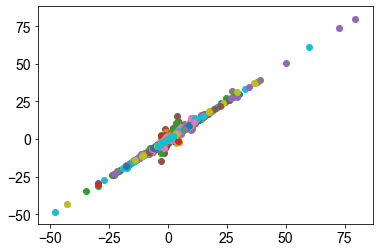

In [134]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

In [ ]:
np.var(X)

In [137]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

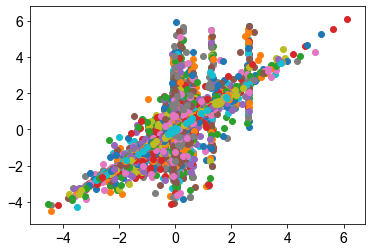

In [136]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

In [138]:
def normalize_variance(x):
    keep = np.where(np.linalg.norm(x, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x)/ np.var(x, axis = 0)**(0.5))


In [140]:
normalize_variance(X).shape

(376, 227)

In [142]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                print(ind, 'iteration')
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(train_loss)

encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
tensor([[-0.1174,  0.3418,  0.5808,  ...,  3.1259, -0.3666, -0.9649],
        [-1.3586,  0.0376, -0.2678,  ...,  0.1898,  0.3678,  0.2653],
        [-0.5048,  0.0510,  1.3295,  ...,  0.1189,  0.0221,  1.1013],
        ...,
        [-0.2774,  0.0852,  0.9696,  ...,  0.2046,  0.3861,  0.1752],
        [-0.5218, -0.9727, -0.0644,  ...,  0.2918,  1.4355, -0.4330],
        [ 2.2939,  1.1553,  0.0394,  ..., -0.5241,  0.0972, -0.4111]],
       dtype=torch.float64)
1 iteration
31.659584045410156
2 iteration
29.974323272705078
3 iteration
28.957136154174805
4 iteration
28.847749710083008
5 iteration
28.040546417236328
6 iteration
27.267484664916992
7 iteration
26.774560928344727
8 iteration
26.0732479095459
9 iteration
25.248502731323242
10 iteration
24.62554168701172
11 iteration
23.763561248779297
12 iteration
23.21378517150879
13 iteration
22.542146682739258
14 iteration
22.23242759704

5.700204849243164
241 iteration
5.695199966430664
242 iteration
5.907291889190674
243 iteration
6.078097820281982
244 iteration
5.995052337646484
245 iteration
5.943047046661377
246 iteration
5.738211154937744
247 iteration
5.682391166687012
248 iteration
5.844425678253174
249 iteration
5.85557746887207
250 iteration
5.656325817108154
251 iteration
5.559904098510742
252 iteration
5.6452789306640625
253 iteration
5.728626251220703
254 iteration
5.475613594055176
255 iteration
5.388947010040283
256 iteration
5.477987289428711
257 iteration
5.477124214172363
258 iteration
5.322839736938477
259 iteration
5.308425426483154
260 iteration
5.3135223388671875
261 iteration
5.329624652862549
262 iteration
5.1689982414245605
263 iteration
5.232275009155273
264 iteration
5.23984432220459
265 iteration
5.1673903465271
266 iteration
5.157723426818848
267 iteration
5.453803062438965
268 iteration
5.680016040802002
269 iteration
5.6055145263671875
270 iteration
5.392492771148682
271 iteration
5.406043

3.331864595413208
501 iteration
3.38061785697937
502 iteration
3.325808525085449
503 iteration
3.267426013946533
504 iteration
3.204312324523926
505 iteration
3.3363232612609863
506 iteration
3.3285813331604004
507 iteration
3.2554569244384766
508 iteration
3.2328691482543945
509 iteration
3.2587318420410156
510 iteration
3.279477834701538
511 iteration
3.250128746032715
512 iteration
3.2036166191101074
513 iteration
3.2070839405059814
514 iteration
3.096656322479248
515 iteration
3.1141610145568848
516 iteration
3.186152458190918
517 iteration
3.2817909717559814
518 iteration
3.3005378246307373
519 iteration
3.256629467010498
520 iteration
3.191394567489624
521 iteration
3.101323127746582
522 iteration
3.0507652759552
523 iteration
3.0691230297088623
524 iteration
3.2267909049987793
525 iteration
3.251551628112793
526 iteration
3.277318000793457
527 iteration
3.4715206623077393
528 iteration
3.509906053543091
529 iteration
3.4541015625
530 iteration
3.356796979904175
531 iteration
3.1

2.6457278728485107
761 iteration
2.5469274520874023
762 iteration
2.4995851516723633
763 iteration
2.5049045085906982
764 iteration
2.565361499786377
765 iteration
2.515550374984741
766 iteration
2.4244420528411865
767 iteration
2.4613308906555176
768 iteration
2.5688047409057617
769 iteration
2.584895133972168
770 iteration
2.4894261360168457
771 iteration
2.6242897510528564
772 iteration
2.731344699859619
773 iteration
2.8435356616973877
774 iteration
2.9700605869293213
775 iteration
3.007338047027588
776 iteration
2.861274242401123
777 iteration
2.558168411254883
778 iteration
2.686143636703491
779 iteration
2.644988536834717
780 iteration
2.561795234680176
781 iteration
2.5351884365081787
782 iteration
2.585068941116333
783 iteration
2.447948694229126
784 iteration
2.4502341747283936
785 iteration
2.528702974319458
786 iteration
2.4311978816986084
787 iteration
2.403878688812256
788 iteration
2.4009344577789307
789 iteration
2.3883728981018066
790 iteration
2.40769100189209
791 ite

2.0326948165893555
1022 iteration
2.0009841918945312
1023 iteration
2.0465519428253174
1024 iteration
2.1822681427001953
1025 iteration
2.079209089279175
1026 iteration
1.9918550252914429
1027 iteration
2.0285236835479736
1028 iteration
2.0823519229888916
1029 iteration
2.13270902633667
1030 iteration
2.040940046310425
1031 iteration
1.972609281539917
1032 iteration
2.02923846244812
1033 iteration
2.090981960296631
1034 iteration
2.2193353176116943
1035 iteration
2.2684662342071533
1036 iteration
2.219151020050049
1037 iteration
2.12593150138855
1038 iteration
2.1030373573303223
1039 iteration
2.125028371810913
1040 iteration
2.158057928085327
1041 iteration
2.151869773864746
1042 iteration
2.177684783935547
1043 iteration
2.3272347450256348
1044 iteration
2.4847214221954346
1045 iteration
2.4199442863464355
1046 iteration
2.2997171878814697
1047 iteration
2.3422951698303223
1048 iteration
5.450438022613525
1049 iteration
4.831721782684326
1050 iteration
5.826201915740967
1051 iteratio

2.082881212234497
1277 iteration
1.9902905225753784
1278 iteration
1.943122386932373
1279 iteration
1.9290204048156738
1280 iteration
1.9970921277999878
1281 iteration
1.946403980255127
1282 iteration
1.8683149814605713
1283 iteration
1.8869764804840088
1284 iteration
1.894826054573059
1285 iteration
1.9107104539871216
1286 iteration
1.960181713104248
1287 iteration
1.9594132900238037
1288 iteration
1.8678779602050781
1289 iteration
1.8328344821929932
1290 iteration
1.8515608310699463
1291 iteration
1.8208431005477905
1292 iteration
1.8167235851287842
1293 iteration
1.8438069820404053
1294 iteration
1.9185837507247925
1295 iteration
1.9344680309295654
1296 iteration
1.9064886569976807
1297 iteration
1.901851773262024
1298 iteration
1.9056811332702637
1299 iteration
1.9838838577270508
1300 iteration
2.1030619144439697
1301 iteration
2.2280421257019043
1302 iteration
2.0974645614624023
1303 iteration
1.999352216720581
1304 iteration
1.986755609512329
1305 iteration
1.963703989982605
1306

1.674904227256775
1522 iteration
1.739500880241394
1523 iteration
1.7650976181030273
1524 iteration
1.7651482820510864
1525 iteration
1.7401037216186523
1526 iteration
1.7019450664520264
1527 iteration
1.6822515726089478
1528 iteration
1.6918987035751343
1529 iteration
1.6905463933944702
1530 iteration
1.7060034275054932
1531 iteration
1.7729918956756592
1532 iteration
1.8500909805297852
1533 iteration
1.9542008638381958
1534 iteration
1.939882755279541
1535 iteration
1.9965014457702637
1536 iteration
1.950635552406311
1537 iteration
1.9746577739715576
1538 iteration
1.9322575330734253
1539 iteration
1.8425054550170898
1540 iteration
1.7752522230148315
1541 iteration
1.7466528415679932
1542 iteration
1.8058350086212158
1543 iteration
1.8846993446350098
1544 iteration
1.8401483297348022
1545 iteration
1.6696412563323975
1546 iteration
1.6583400964736938
1547 iteration
1.7798160314559937
1548 iteration
1.7517852783203125
1549 iteration
1.633528470993042
1550 iteration
1.6155925989151
155

1.7635231018066406
1772 iteration
1.73039710521698
1773 iteration
1.7455023527145386
1774 iteration
1.7315356731414795
1775 iteration
1.7025808095932007
1776 iteration
1.6369885206222534
1777 iteration
1.6628830432891846
1778 iteration
1.7005805969238281
1779 iteration
1.7053120136260986
1780 iteration
1.6733956336975098
1781 iteration
1.5828341245651245
1782 iteration
1.518820881843567
1783 iteration
1.5734450817108154
1784 iteration
1.6391456127166748
1785 iteration
1.656064510345459
1786 iteration
1.597015142440796
1787 iteration
1.5512807369232178
1788 iteration
1.598771572113037
1789 iteration
1.6362282037734985
1790 iteration
1.5989270210266113
1791 iteration
1.621045708656311
1792 iteration
1.7091622352600098
1793 iteration
1.7254101037979126
1794 iteration
1.6411471366882324
1795 iteration
1.60662043094635
1796 iteration
1.6244240999221802
1797 iteration
1.704014778137207
1798 iteration
1.6900825500488281
1799 iteration
1.6315547227859497
1800 iteration
1.5803271532058716
1801 

1.7982479333877563
2019 iteration
1.828118920326233
2020 iteration
1.7470003366470337
2021 iteration
1.8142683506011963
2022 iteration
1.6980183124542236
2023 iteration
1.6307568550109863
2024 iteration
1.7462060451507568
2025 iteration
1.6247377395629883
2026 iteration
1.7081290483474731
2027 iteration
1.708135962486267
2028 iteration
1.6144976615905762
2029 iteration
1.6240640878677368
2030 iteration
1.6538147926330566
2031 iteration
1.7262639999389648
2032 iteration
1.7707710266113281
2033 iteration
2.088775157928467
2034 iteration
1.9229992628097534
2035 iteration
2.024257183074951
2036 iteration
2.0438311100006104
2037 iteration
1.986148715019226
2038 iteration
1.9536616802215576
2039 iteration
1.8726648092269897
2040 iteration
1.8797701597213745
2041 iteration
1.8718501329421997
2042 iteration
1.7563785314559937
2043 iteration
1.7277933359146118
2044 iteration
1.719636082649231
2045 iteration
1.659818172454834
2046 iteration
1.6191895008087158
2047 iteration
1.643272876739502
204

1.4778239727020264
2273 iteration
1.4465919733047485
2274 iteration
1.5127949714660645
2275 iteration
1.6941050291061401
2276 iteration
1.9112327098846436
2277 iteration
1.7842704057693481
2278 iteration
1.565500259399414
2279 iteration
1.4255646467208862
2280 iteration
1.500151515007019
2281 iteration
1.5909098386764526
2282 iteration
1.5174468755722046
2283 iteration
1.437228798866272
2284 iteration
1.4519004821777344
2285 iteration
1.52456533908844
2286 iteration
1.5620605945587158
2287 iteration
1.5018844604492188
2288 iteration
1.4627553224563599
2289 iteration
1.5687943696975708
2290 iteration
1.4980679750442505
2291 iteration
1.4000252485275269
2292 iteration
1.481771469116211
2293 iteration
1.4963493347167969
2294 iteration
1.4232579469680786
2295 iteration
1.378840684890747
2296 iteration
1.3931814432144165
2297 iteration
1.4002643823623657
2298 iteration
1.4183499813079834
2299 iteration
1.4213082790374756
2300 iteration
1.4157336950302124
2301 iteration
1.4234408140182495
23

1.2701480388641357
2526 iteration
1.239255428314209
2527 iteration
1.259764313697815
2528 iteration
1.2942873239517212
2529 iteration
1.2880488634109497
2530 iteration
1.3100850582122803
2531 iteration
1.3339208364486694
2532 iteration
1.3101439476013184
2533 iteration
1.2858524322509766
2534 iteration
1.290928602218628
2535 iteration
1.325290560722351
2536 iteration
1.3387088775634766
2537 iteration
1.394614815711975
2538 iteration
1.3899401426315308
2539 iteration
1.3824459314346313
2540 iteration
1.3498324155807495
2541 iteration
1.325553297996521
2542 iteration
1.3545989990234375
2543 iteration
1.367254376411438
2544 iteration
1.406385064125061
2545 iteration
1.368407130241394
2546 iteration
1.3081841468811035
2547 iteration
1.318110704421997
2548 iteration
1.3513906002044678
2549 iteration
1.4477994441986084
2550 iteration
1.498158574104309
2551 iteration
1.4524414539337158
2552 iteration
1.3692307472229004
2553 iteration
1.3728305101394653
2554 iteration
1.3468624353408813
2555 i

1.3107578754425049
2778 iteration
1.2945200204849243
2779 iteration
1.3026974201202393
2780 iteration
1.3495548963546753
2781 iteration
1.451431155204773
2782 iteration
1.6641225814819336
2783 iteration
1.5607657432556152
2784 iteration
1.3721567392349243
2785 iteration
1.318867564201355
2786 iteration
1.3667856454849243
2787 iteration
1.4162801504135132
2788 iteration
1.2855948209762573
2789 iteration
1.338089108467102
2790 iteration
1.4701118469238281
2791 iteration
1.383958339691162
2792 iteration
1.2914899587631226
2793 iteration
1.3122625350952148
2794 iteration
1.356308102607727
2795 iteration
1.3472626209259033
2796 iteration
1.2455501556396484
2797 iteration
1.2560696601867676
2798 iteration
1.2837525606155396
2799 iteration
1.2626557350158691
2800 iteration
1.2437537908554077
2801 iteration
1.2479571104049683
2802 iteration
1.268235683441162
2803 iteration
1.3211052417755127
2804 iteration
1.2605592012405396
2805 iteration
1.2009563446044922
2806 iteration
1.1927565336227417
2

1.3560996055603027
3023 iteration
1.3401353359222412
3024 iteration
1.35093092918396
3025 iteration
1.371488094329834
3026 iteration
1.3677740097045898
3027 iteration
1.3535054922103882
3028 iteration
1.3342105150222778
3029 iteration
1.3008651733398438
3030 iteration
1.2817918062210083
3031 iteration
1.2461837530136108
3032 iteration
1.2513991594314575
3033 iteration
1.2634271383285522
3034 iteration
1.2732621431350708
3035 iteration
1.2776073217391968
3036 iteration
1.280210018157959
3037 iteration
1.2520960569381714
3038 iteration
1.2196184396743774
3039 iteration
1.2203173637390137
3040 iteration
1.1927977800369263
3041 iteration
1.212684988975525
3042 iteration
1.223905324935913
3043 iteration
1.2401834726333618
3044 iteration
1.2342119216918945
3045 iteration
1.2218207120895386
3046 iteration
1.2034811973571777
3047 iteration
1.228344202041626
3048 iteration
1.231128454208374
3049 iteration
1.2362134456634521
3050 iteration
1.2497633695602417
3051 iteration
1.254660964012146
3052

1.2129408121109009
3273 iteration
1.1891661882400513
3274 iteration
1.1488313674926758
3275 iteration
1.1159933805465698
3276 iteration
1.1453908681869507
3277 iteration
1.1933095455169678
3278 iteration
1.2150100469589233
3279 iteration
1.2595502138137817
3280 iteration
1.2627884149551392
3281 iteration
1.2716540098190308
3282 iteration
1.2912864685058594
3283 iteration
1.2318428754806519
3284 iteration
1.1623148918151855
3285 iteration
1.1461162567138672
3286 iteration
1.1482256650924683
3287 iteration
1.2017992734909058
3288 iteration
1.2527137994766235
3289 iteration
1.3438645601272583
3290 iteration
1.2966169118881226
3291 iteration
1.1978906393051147
3292 iteration
1.1294962167739868
3293 iteration
1.13564133644104
3294 iteration
1.1768990755081177
3295 iteration
1.2172414064407349
3296 iteration
1.1661268472671509
3297 iteration
1.10625159740448
3298 iteration
1.0910065174102783
3299 iteration
1.130487322807312
3300 iteration
1.1507997512817383
3301 iteration
1.1330986022949219


1.1389045715332031
3517 iteration
1.2108991146087646
3518 iteration
1.242096185684204
3519 iteration
1.25283944606781
3520 iteration
1.2208091020584106
3521 iteration
1.1866402626037598
3522 iteration
1.1804516315460205
3523 iteration
1.1935927867889404
3524 iteration
1.218929409980774
3525 iteration
1.2135884761810303
3526 iteration
1.1651407480239868
3527 iteration
1.1320366859436035
3528 iteration
1.1036045551300049
3529 iteration
1.0838203430175781
3530 iteration
1.1326121091842651
3531 iteration
1.2111928462982178
3532 iteration
1.1946568489074707
3533 iteration
1.1779658794403076
3534 iteration
1.1824947595596313
3535 iteration
1.2179622650146484
3536 iteration
1.1474422216415405
3537 iteration
1.103041648864746
3538 iteration
1.077453851699829
3539 iteration
1.1156717538833618
3540 iteration
1.1553224325180054
3541 iteration
1.1712627410888672
3542 iteration
1.202842354774475
3543 iteration
1.2027655839920044
3544 iteration
1.214332938194275
3545 iteration
1.1735061407089233
354

1.1326344013214111
3762 iteration
1.088513970375061
3763 iteration
1.0898997783660889
3764 iteration
1.0952918529510498
3765 iteration
1.128305435180664
3766 iteration
1.1430788040161133
3767 iteration
1.1192524433135986
3768 iteration
1.100403904914856
3769 iteration
1.0631523132324219
3770 iteration
1.0590031147003174
3771 iteration
1.0783591270446777
3772 iteration
1.0860011577606201
3773 iteration
1.0552244186401367
3774 iteration
1.0554968118667603
3775 iteration
1.0576095581054688
3776 iteration
1.095182180404663
3777 iteration
1.0988177061080933
3778 iteration
1.1150434017181396
3779 iteration
1.1110981702804565
3780 iteration
1.1429474353790283
3781 iteration
1.0828850269317627
3782 iteration
1.0416427850723267
3783 iteration
1.0447615385055542
3784 iteration
1.0906739234924316
3785 iteration
1.118882656097412
3786 iteration
1.1506787538528442
3787 iteration
1.1805541515350342
3788 iteration
1.1557166576385498
3789 iteration
1.1123988628387451
3790 iteration
1.1045973300933838


0.9955618381500244
4014 iteration
1.0002299547195435
4015 iteration
1.0172573328018188
4016 iteration
1.0264660120010376
4017 iteration
1.0082679986953735
4018 iteration
1.0203707218170166
4019 iteration
0.9919820427894592
4020 iteration
1.0300192832946777
4021 iteration
1.0935372114181519
4022 iteration
1.1472926139831543
4023 iteration
1.1948423385620117
4024 iteration
1.2230383157730103
4025 iteration
1.2412093877792358
4026 iteration
1.2653437852859497
4027 iteration
1.1714709997177124
4028 iteration
1.1732577085494995
4029 iteration
1.1552103757858276
4030 iteration
1.1706815958023071
4031 iteration
1.1533870697021484
4032 iteration
1.154518723487854
4033 iteration
1.1588904857635498
4034 iteration
1.1820625066757202
4035 iteration
1.1805168390274048
4036 iteration
1.1540342569351196
4037 iteration
1.085068941116333
4038 iteration
1.1394723653793335
4039 iteration
1.2349181175231934
4040 iteration
1.1274479627609253
4041 iteration
1.0934385061264038
4042 iteration
1.13357031345367

1.0195335149765015
4259 iteration
1.0000795125961304
4260 iteration
1.0289795398712158
4261 iteration
1.0556138753890991
4262 iteration
1.0715230703353882
4263 iteration
1.1101168394088745
4264 iteration
1.1013767719268799
4265 iteration
1.1003029346466064
4266 iteration
1.0546410083770752
4267 iteration
1.0546762943267822
4268 iteration
1.0703709125518799
4269 iteration
1.0604727268218994
4270 iteration
1.0443171262741089
4271 iteration
1.039307713508606
4272 iteration
1.068170189857483
4273 iteration
1.0681617259979248
4274 iteration
1.0266355276107788
4275 iteration
1.0008307695388794
4276 iteration
1.0179834365844727
4277 iteration
1.0271408557891846
4278 iteration
1.021761417388916
4279 iteration
0.9961884617805481
4280 iteration
0.9946573972702026
4281 iteration
0.9839765429496765
4282 iteration
0.9932928681373596
4283 iteration
1.0212138891220093
4284 iteration
1.043520450592041
4285 iteration
1.0561443567276
4286 iteration
1.0711641311645508
4287 iteration
1.037819266319275
428

1.111268162727356
4508 iteration
1.137555718421936
4509 iteration
1.1216412782669067
4510 iteration
1.1216785907745361
4511 iteration
1.049196720123291
4512 iteration
1.0157899856567383
4513 iteration
1.04179048538208
4514 iteration
1.0681781768798828
4515 iteration
1.111634373664856
4516 iteration
1.0810883045196533
4517 iteration
1.0933033227920532
4518 iteration
1.0332118272781372
4519 iteration
1.0219711065292358
4520 iteration
1.0533478260040283
4521 iteration
1.0572340488433838
4522 iteration
1.0305575132369995
4523 iteration
0.9966058135032654
4524 iteration
1.0033717155456543
4525 iteration
0.9753044843673706
4526 iteration
0.9626293182373047
4527 iteration
0.973693311214447
4528 iteration
0.9762076735496521
4529 iteration
0.9771580100059509
4530 iteration
0.9744879007339478
4531 iteration
0.9889392852783203
4532 iteration
0.9741060137748718
4533 iteration
0.9823159575462341
4534 iteration
0.9744853973388672
4535 iteration
0.9877192974090576
4536 iteration
0.971802294254303
453

1.2676368951797485
4761 iteration
1.7168190479278564
4762 iteration
1.7731112241744995
4763 iteration
2.067296266555786
4764 iteration
2.0505011081695557
4765 iteration
1.8970866203308105
4766 iteration
1.9298487901687622
4767 iteration
1.8652524948120117
4768 iteration
1.933733344078064
4769 iteration
1.8964709043502808
4770 iteration
1.780429482460022
4771 iteration
1.7574321031570435
4772 iteration
1.8424893617630005
4773 iteration
1.8463140726089478
4774 iteration
1.6354358196258545
4775 iteration
1.8415169715881348
4776 iteration
1.855231523513794
4777 iteration
1.7878046035766602
4778 iteration
1.798004150390625
4779 iteration
1.813893437385559
4780 iteration
1.661253809928894
4781 iteration
1.670487403869629
4782 iteration
1.5794951915740967
4783 iteration
1.5059934854507446
4784 iteration
1.5364168882369995
4785 iteration
1.4965037107467651
4786 iteration
1.4531445503234863
4787 iteration
1.4622061252593994
4788 iteration
1.4145625829696655
4789 iteration
1.4143157005310059
479

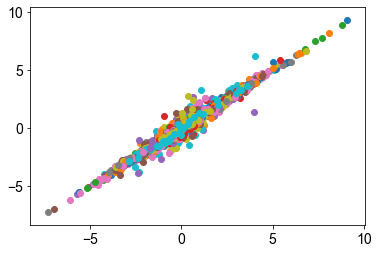

In [143]:
for i in range(300):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])
#plt.xlim(-10,10)
#plt.ylim(-10,10)

(array([2.1856e+04, 4.2200e+02, 1.5100e+02, 5.5000e+01, 2.2000e+01,
        1.5000e+01, 4.0000e+00, 7.0000e+00, 9.0000e+00, 1.9000e+01]),
 array([-0.55544818,  1.43177799,  3.41900417,  5.40623034,  7.39345652,
         9.38068269, 11.36790887, 13.35513505, 15.34236122, 17.3295874 ,
        19.31681357]),
 <a list of 10 Patch objects>)

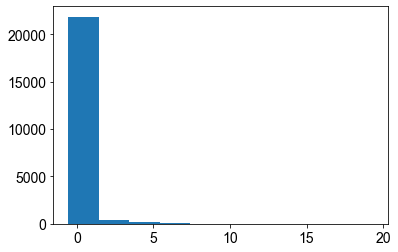

In [144]:
plt.hist(ynmfnorm.flatten())